In [1]:
sample_size = 1000
mcmc_resets = 5
mcmc_steps = 12000
mcmc_ens_avg=[10000,100]
log_flows = True
new_train_test=False
#"""
XLABS = [
    'd',
    'm_o',
    'm_d']
params = 6

In [2]:
import pandas as pd
import numpy as np
import sys
import warnings
import gc
warnings.filterwarnings('default')

import matplotlib.pyplot as plt
from copy import deepcopy,copy
from ipywidgets import IntProgress
from itertools import chain
from IPython.display import display
from datetime import datetime
import pickle
import os
# Since the 'user' column do not have relevant information will not be read

# Import Machine Scientist
from importlib.machinery import SourceFileLoader
path = './rguimera-machine-scientist/machinescientist.py'
ms = SourceFileLoader('ms', path).load_module()

# Read data
states=['New York','Massachusetts','California','Florida','Washington','Texas']


In [3]:
print(np.__version__)

1.21.4


In [4]:
print(np.__version__)

1.21.4


In [5]:
def get_train_test(features):
    import random
    name_unique = np.unique(list(features.name_o)+list(features.name_d))
    random.shuffle(name_unique)
    split = len(name_unique) // 2
    name_train = name_unique[:split]
    name_test = name_unique[split:]
    
    train_data = features[(features.name_o.isin(name_train))&(features.name_d.isin(name_train))]
    test_data = features[(features.name_o.isin(name_test))&(features.name_d.isin(name_test))]
    return train_data,test_data
def delete_nan(a,b):
    a_new=[i for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    b_new=[j for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    return a_new,b_new
def common_part_of_commuters(values1, values2):
    values1,values2=delete_nan(values1,values2)
    tot = np.sum(values1) + np.sum(values2)
    return 2.0 * np.sum(np.minimum(values1, values2)) / tot
def common_part_of_commuters_accuracy(real, predicted):
    real,predicted=delete_nan(real,predicted)
    tot = 2.*np.sum(real)
    return 2.0 * np.sum(np.minimum(real,predicted)) / tot
def RMSE(real,predicted):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=delete_nan(real,predicted)
    return np.sqrt(np.square(np.subtract(real,predicted)).mean())
def RE(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return np.array(list(np.abs((y-y1)/y1) for y,y1 in zip(predicted,real))).mean()
def ensemble_prediction_median_np(list_models,data):
    ens_pred=[]
    for i,x in data.iterrows():
        res=[]
        for model in list_models:
            df=pd.DataFrame(x).transpose()
            res1=model.predict(df)
            if np.iscomplex(res1.values[0])==False:
                res.append(res1.values[0])
        if log_flows==True:
            median=np.nanmedian(np.exp(res))
        else:
            median=np.nanmedian(res)
        ens_pred.append(median)
    return ens_pred
def ensemble_prediction_median(list_models,data):
    import multiprocessing
    num_cores = max(int(multiprocessing.cpu_count()/2.),1)  #half of available cores or one
    #print('Debug, num cores:',num_cores)
    num_cores=5
    num_partitions = num_cores #number of partitions to split dataframe
    df_split = np.array_split(data, num_partitions)
    global func_median
    def func_median(data):
        ens_pred=[]
        for i,x in data.iterrows():
            res=[]
            for model in list_models:
                df=pd.DataFrame(x).transpose()
                res1=model.predict(df)
                if np.iscomplex(res1.values[0])==False:
                    res.append(res1.values[0])
            if log_flows==True:
                median=np.nanmedian(np.exp(res))
            else:
                median=np.nanmedian(res)
            ens_pred.append(median)
        return ens_pred
    pool = multiprocessing.Pool(num_cores)
    #df = pd.concat(pool.map(func_median, df_split))
    df=list(chain(*pool.map(func_median, df_split)))
    pool.close()
    pool.join()
    return df

### Train/Test

In [6]:
if new_train_test==True:
    list_states_dataframes = [
        pd.read_pickle('data/NewYork/city_trips_features_2022_10_28-04_02_13.pkl'),#.sample(machinescientist_sample_size),
        pd.read_pickle('data/Massachusetts/city_trips_features_2022_10_28-09_28_48.pkl'),#.sample(machinescientist_sample_size),
        pd.read_pickle('data/California/city_trips_features_2022_10_30-03_06_27.pkl'),#.sample(machinescientist_sample_size),
        pd.read_pickle('data/Florida/city_trips_features_2022_10_31-12_54_59.pkl'),#.sample(machinescientist_sample_size),
        pd.read_pickle('data/Washington/city_trips_features_2022_10_31-07_50_13.pkl'),#ample(machinescientist_sample_size),
        pd.read_pickle('data/Texas/city_trips_features_2022_11_01-04_52_48.pkl'),#ample(machinescientist_sample_size),
    ]

    train_list_dataframes={}
    test_list_dataframes={}
    train_list_sample={}
    test_list_sample={}
    for i,df in enumerate(list_states_dataframes):
        print(df.columns)
        # Get list of all cities
        df=df[df.total_pop_flow>0.0]
        train,test=get_train_test(df)
        #
        train_list_dataframes[states[i]]=train
        train_list_sample[states[i]]=train.sample(sample_size)
        test_list_dataframes[states[i]]=test
        test_list_sample[states[i]]=test.sample(sample_size)

    #
    name=open('./data/checkpoints/'+f'list_states_dataframes_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl', "wb")
    pickle.dump(list_states_dataframes, name)
    print(name)
    name.close()
    #
    name=open('./data/checkpoints/'+f'fold1_dataframes_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl', "wb")
    pickle.dump(train_list_dataframes, name)
    print(name)
    name.close()
    #
    name=open('./data/checkpoints/'+f'fold1_sample_dataframes_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl', "wb")
    pickle.dump(train_list_sample, name)
    print(name)
    name.close()
    #
    name=open('./data/checkpoints/'+f'fold2_dataframes_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl', "wb")
    pickle.dump(test_list_dataframes, name)
    print(name)
    name.close()
    #
    name=open('./data/checkpoints/'+f'fold2_sample_dataframes_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl', "wb")
    pickle.dump(test_list_sample, name)
    print(name)
    name.close()
else:
    fold='fold1'
    name=open(f'./data/checkpoints/{fold}_sample_dataframes_2022_11_02-02_54_03.pkl', "rb")
    train_list_sample=pickle.load(name)
    name.close()
    

### Computing natural logarithm of population flow

In [7]:
if log_flows==True:
    for i,key in enumerate(states):
        train_list_sample[states[i]]['total_pop_flow']=train_list_sample[states[i]]['total_pop_flow'].apply(lambda x : np.log(x))
        print(train_list_sample[states[i]].head())
    log_scale=False
else:
    log_scale=True


                          name_o          name_d  total_pop_flow          d  \
14594  Jefferson Valley-Yorktown  Heritage Hills        4.465908   8.604705   
10842                      Coram         Syosset        5.993961  42.363684   
14394                      Islip     Garden City        6.230481  36.177391   
12424            Franklin Square  Huntington Bay        4.158883  31.783607   
14749                 Kings Park        Copiague        4.709530  27.087126   

                s     area_o     area_d    m_o    m_d  food_point_o  ...  \
14594     14828.0  18.023643   4.833175  14444   4511             0  ...   
10842   1431584.0  35.809365  12.885287  40220  19259             6  ...   
14394   2047849.0  12.292964  13.799905  18418  23272            17  ...   
12424  10911308.0   7.458918   2.585393  30903   1446            47  ...   
14749   1289844.0  17.279484   8.008831  17085  23429             5  ...   

       commercial_landuse_d  retail_point_d  retail_poly_d  school_p

# Machine Scientist

## BMS C: One model, multiDataFrame

In [ ]:
res={}



best_model, state_ensemble, fig = ms.machinescientist(x=train_list_sample,
                                               y={key:i['total_pop_flow'] for key,i in train_list_sample.items()},
                                               XLABS=XLABS,n_params=params,
                                               resets=mcmc_resets,
                                               steps_prod=mcmc_steps,
                                               log_scale_prediction=log_scale,
                                                ensemble_avg=mcmc_ens_avg
                                              )

name=f'./data/checkpoints/{fold}_state_model_C_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
name=f'./data/checkpoints/{fold}_ensemble_model_C_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(state_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)

<lambdifygenerated-52>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
/export/home/shared/Projects/City_flows/repository/venv_project/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
<lambdifygenerated-53>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-54>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-55>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-56>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-57>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
/export/home/shared/Projects/City_flows/repository/rguimera-machine-scientist/parallel.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modi

<lambdifygenerated-294>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-295>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-296>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-304>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-305>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-306>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-337>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-338>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-342>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-343>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-344>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifyge

<lambdifygenerated-458>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-459>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-489>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-490>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-530>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-531>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-574>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-575>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)


<lambdifygenerated-587>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-588>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-592>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-593>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-601>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_ + _a5_**(-_a2_)
<lambdifygenerated-601>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_ + _a5_**(-_a2_)
<lambdifygenerated-657>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_ + _a5_**(-_a5_)
<lambdifygenerated-689>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ + sinh(_a1_)**(-2*d)
<lambdifygenerated-689>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + sinh(_a1_)**(-2*d)
<lambdifygenerated-700>:2: RuntimeWarning: invalid value encountered in power

<lambdifygenerated-708>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-709>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-710>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-714>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-d**2)
<lambdifygenerated-741>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ + _a5_**(-d*m_o)
<lambdifygenerated-741>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-d*m_o)
<lambdifygenerated-747>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-_a0_**m_o*d)
<lambdifygenerated-748>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-_a0_**m_o*d)
<lambdifygenerated-749>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-_a0_**m_o*d)
<lambdifygenerated-756>:2: RuntimeWarning: divide by zero encountered in power
  return

<lambdifygenerated-823>:2: RuntimeWarning: overflow encountered in power
  return d + _a5_**(-d**2)
<lambdifygenerated-831>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ + _a5_**(-d*(_a5_ + m_d))
<lambdifygenerated-831>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-d*(_a5_ + m_d))
<lambdifygenerated-840>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-_a1_*d/_a4_)
<lambdifygenerated-867>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-868>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-869>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-875>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ + _a5_**(-d*m_d)
<lambdifygenerated-875>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a5_**(-d*m_d)
<lambdifygenerated-891>:2: RuntimeWarning: invalid value encountered in d

<lambdifygenerated-957>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-958>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-966>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-967>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-968>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-969>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-988>:2: RuntimeWarning: overflow encountered in exp
  return (_a0_ + _a5_**(-d*exp(m_o)))*tan(_a3_)
<lambdifygenerated-989>:2: RuntimeWarning: overflow encountered in exp
  return (_a0_ + _a5_**(-d*exp(m_o)))*tan(_a3_)
<lambdifygenerated-990>:2: RuntimeWarning: overflow encountered in exp
  return (_a0_ + _a5_**(-d*exp(m_o)))*tan(_a3_)
<lambdifygenerated-1023>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-10

<lambdifygenerated-1055>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-1056>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-1061>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-d*d**_a0_))**cosh(_a3_)
<lambdifygenerated-1073>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_ + m_o)
<lambdifygenerated-1074>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_ + m_o)
<lambdifygenerated-1075>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_ + m_o)
<lambdifygenerated-1076>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -_a0_**_a1_
<lambdifygenerated-1082>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-1083>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-1101>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-11

<lambdifygenerated-1217>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-1218>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-1239>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-1240>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-1245>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-cos(_a4_)))**_a1_
<lambdifygenerated-1259>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_ + m_d + _a5_**(-_a1_*d))**_a1_
<lambdifygenerated-1272>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_**(-_a1_*d)/_a0_)**_a1_
<lambdifygenerated-1272>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(-_a1_*d)/_a0_)**_a1_
<lambdifygenerated-1272>:2: RuntimeWarning: divide by zero encountered in power
  return (_a5_**(-_a1_*d)/_a0_)**_a1_
<lambdifygenerated-1286>:2: RuntimeWa

<lambdifygenerated-1340>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-d*cos(m_o)))**_a1_
<lambdifygenerated-1340>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a5_**(-d*cos(m_o)))**_a1_
<lambdifygenerated-1341>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-d*cos(m_o)))**_a1_
<lambdifygenerated-1342>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-d*cos(m_o)))**_a1_
<lambdifygenerated-1348>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_ + log(_a3_)**(-_a1_*d))**_a1_
<lambdifygenerated-1348>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + log(_a3_)**(-_a1_*d))**_a1_
<lambdifygenerated-1349>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_ + log(_a3_)**(-_a1_*d))**_a1_
<lambdifygenerated-1350>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_ + log(_a3_)**(-_a1_*d))**_a1_
<lambdifygenerated-1358>:2: R

<lambdifygenerated-1462>:2: RuntimeWarning: overflow encountered in power
  return (cosh(_a4_) + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1462>:2: RuntimeWarning: invalid value encountered in power
  return (cosh(_a4_) + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1481>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-tan(_a4_)))**_a1_
<lambdifygenerated-1497>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-1498>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-1501>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**(-sinh(_a3_)))**_a1_
<lambdifygenerated-1501>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a0_ + _a5_**(-sinh(_a3_)))**_a1_
<lambdifygenerated-1501>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-sinh(_a3_)))**_a1_
<lambdifygenerated-1520>:2: RuntimeWarning: overflow encountered

<lambdifygenerated-1603>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-_a0_*d))**(-_a0_)
<lambdifygenerated-1615>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**sinh(_a0_*d))**_a1_
<lambdifygenerated-1615>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**sinh(_a0_*d))**_a1_
<lambdifygenerated-1616>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**sinh(_a0_*d))**_a1_
<lambdifygenerated-1616>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**sinh(_a0_*d))**_a1_
<lambdifygenerated-1623>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-1624>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-1658>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-1659>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-1660>:2: RuntimeWarning: invalid value

<lambdifygenerated-1708>:2: RuntimeWarning: invalid value encountered in log
  return log(cos(_a3_))
<lambdifygenerated-1712>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a5_**cosh(_a0_*d))**_a1_
<lambdifygenerated-1712>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**cosh(_a0_*d))**_a1_
<lambdifygenerated-1713>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a5_**cosh(_a0_*d))**_a1_
<lambdifygenerated-1713>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**cosh(_a0_*d))**_a1_
<lambdifygenerated-1718>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(sin(_a0_))
<lambdifygenerated-1723>:2: RuntimeWarning: overflow encountered in power
  return (_a5_ + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1730>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-_a0_*_a4_**_a4_))**_a1_
<lambdifygenerated-1730>:2: RuntimeWarning: overflow encountered in double_scal

<lambdifygenerated-1854>:2: RuntimeWarning: overflow encountered in power
  return m_d*(_a0_ + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1854>:2: RuntimeWarning: overflow encountered in multiply
  return m_d*(_a0_ + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1854>:2: RuntimeWarning: invalid value encountered in power
  return m_d*(_a0_ + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1855>:2: RuntimeWarning: overflow encountered in power
  return m_d*(_a0_ + _a5_**(-_a0_*d))**_a1_
<lambdifygenerated-1866>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-cos(_a1_)))**_a1_
<lambdifygenerated-1870>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-1871>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-1898>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-1905>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**3*_a3_**(3*_a2_**3)


<lambdifygenerated-1999>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(_a0_**3*d**3))**_a1_
<lambdifygenerated-2000>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(_a0_**3*d**3))**_a1_
<lambdifygenerated-2001>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-2002>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-2006>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a0_*d)
<lambdifygenerated-2007>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a0_*d)
<lambdifygenerated-2008>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a0_*d)
<lambdifygenerated-2026>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a5_**(-d))**(sqrt(d))
<lambdifygenerated-2026>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(-d))**(sqrt(d))
<lambdifygenerated-2042>:2: RuntimeWarning: overflow encountered

<lambdifygenerated-2129>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sinh(_a0_*_a3_**tan(_a0_))
<lambdifygenerated-2134>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a5_**(-sin(_a0_)))/_a1_
<lambdifygenerated-2147>:2: RuntimeWarning: invalid value encountered in power
  return sinh(_a0_*log(_a3_)**d)
<lambdifygenerated-2148>:2: RuntimeWarning: invalid value encountered in power
  return sinh(_a0_*log(_a3_)**d)
<lambdifygenerated-2149>:2: RuntimeWarning: invalid value encountered in power
  return sinh(_a0_*log(_a3_)**d)
<lambdifygenerated-2151>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(d + m_d))/_a1_
<lambdifygenerated-2151>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a0_ + _a5_**(d + m_d))/_a1_
<lambdifygenerated-2152>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a5_**(d + m_d))/_a1_
<lambdifygenerated-2152>:2: RuntimeWarning: overflow encountered 

<lambdifygenerated-2290>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a5_**(-d))*sin(_a1_)
<lambdifygenerated-2295>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a0_**(_a3_ + d))
<lambdifygenerated-2295>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a0_**(_a3_ + d))
<lambdifygenerated-2296>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a0_**(_a3_ + d))
<lambdifygenerated-2296>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a0_**(_a3_ + d))
<lambdifygenerated-2300>:2: RuntimeWarning: divide by zero encountered in power
  return (_a5_**(-d))**_a0_/sin(_a1_)
<lambdifygenerated-2300>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(-d))**_a0_/sin(_a1_)
<lambdifygenerated-2300>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a5_**(-d))**_a0_/sin(_a1_)
<lambdifygenerated-2309>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a3_**(_a3_**d))
<lambdi

<lambdifygenerated-2441>:2: RuntimeWarning: overflow encountered in cosh
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2441>:2: RuntimeWarning: overflow encountered in exp
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2442>:2: RuntimeWarning: overflow encountered in cosh
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2442>:2: RuntimeWarning: overflow encountered in exp
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2443>:2: RuntimeWarning: overflow encountered in cosh
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2443>:2: RuntimeWarning: overflow encountered in exp
  return exp(cosh(m_o)**(_a3_**d))
<lambdifygenerated-2451>:2: RuntimeWarning: invalid value encountered in double_scalars
  return exp(_a0_**_a3_)
<lambdifygenerated-2464>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**((_a3_*m_o)**d))
<lambdifygenerated-2465>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**((_a3_*m_o)**d))
<lambdifygenerated-246

<lambdifygenerated-2582>:2: RuntimeWarning: overflow encountered in power
  return sin(_a0_**(_a3_**d))
<lambdifygenerated-2582>:2: RuntimeWarning: invalid value encountered in power
  return sin(_a0_**(_a3_**d))
<lambdifygenerated-2582>:2: RuntimeWarning: invalid value encountered in sin
  return sin(_a0_**(_a3_**d))
<lambdifygenerated-2593>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-2594>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-2596>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**(_a3_**cosh(m_o)))
<lambdifygenerated-2597>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**(_a3_**cosh(m_o)))
<lambdifygenerated-2598>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**(_a3_**cosh(m_o)))
<lambdifygenerated-2604>:2: RuntimeWarning: invalid value encountered in power
  return (d*m_d + _a5_**(-d))/sin(_a1_)
<lambdifygenerated-2626>:2: RuntimeWarning: inva

<lambdifygenerated-2758>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-2759>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-2765>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a0_ + _a5_**tanh(d))/sin(_a1_)
<lambdifygenerated-2775>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-2776>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-2777>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a0_ + _a5_**(-d))**sin(_a1_)
<lambdifygenerated-2782>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a0_ + _a5_**(-d))/(_a2_ + m_d)
<lambdifygenerated-2782>:2: RuntimeWarning: overflow encountered in power
  return _a5_*(_a0_ + _a5_**(-d))/(_a2_ + m_d)
<lambdifygenerated-2785>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-2786>:2: RuntimeWarning: ove

<lambdifygenerated-2846>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a0_ + _a5_**(_a2_*d))/sin(_a1_)
<lambdifygenerated-2866>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-2867>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-2870>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_*(_a0_ + _a5_**(-_a2_))/sin(_a1_)
<lambdifygenerated-2884>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_*(_a0_ + _a5_**(_a1_*_a2_))/sin(_a1_)
<lambdifygenerated-2884>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_*(_a0_ + _a5_**(_a1_*_a2_))/sin(_a1_)
<lambdifygenerated-2889>:2: RuntimeWarning: invalid value encountered in double_scalars
  return exp(_a0_**sin(_a2_))
<lambdifygenerated-2894>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*_a5_**(-d)/(_a0_*sin(_a1_))
<lambdifygenerated-2907>:2: RuntimeWarning

<lambdifygenerated-2980>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-2981>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-2983>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o**(_a3_**d))
<lambdifygenerated-2984>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o**(_a3_**d))
<lambdifygenerated-2997>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a0_**(_a3_**d))/_a4_
<lambdifygenerated-3003>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-3004>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-3008>:2: RuntimeWarning: invalid value encountered in log
  return _a5_*(_a0_ + _a5_**(-log(_a4_)))/sin(_a1_)
<lambdifygenerated-3008>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_*(_a0_ + _a5_**(-log(_a4_)))/sin(_a1_)
<lambdifygenerated-3024>:2: RuntimeWarning: ove

<lambdifygenerated-3160>:2: RuntimeWarning: overflow encountered in power
  return _a5_*(m_d**m_d + _a5_**(-d))/_a1_
<lambdifygenerated-3171>:2: RuntimeWarning: invalid value encountered in power
  return (exp(_a0_**(_a3_**d))/_a4_)**_a5_
<lambdifygenerated-3201>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(_a0_**d))/_a4_
<lambdifygenerated-3201>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**(_a0_**d))/_a4_
<lambdifygenerated-3202>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(_a0_**d))/_a4_
<lambdifygenerated-3202>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**(_a0_**d))/_a4_
<lambdifygenerated-3205>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + m_d)
<lambdifygenerated-3208>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-3209>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-3213>:2: RuntimeWarning: o

<lambdifygenerated-3257>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**_a0_)/_a4_
<lambdifygenerated-3263>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-3264>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-3269>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-3270>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-3273>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3273>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3274>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3274>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3277>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_*(_a0_ + _a5_**(_a0_*

<lambdifygenerated-3393>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(m_d**d))/_a4_
<lambdifygenerated-3394>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(m_d**d))/_a4_
<lambdifygenerated-3409>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3409>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3410>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3410>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**m_d)/_a4_
<lambdifygenerated-3415>:2: RuntimeWarning: overflow encountered in sinh
  return abs(sinh(m_d))
<lambdifygenerated-3416>:2: RuntimeWarning: overflow encountered in sinh
  return abs(sinh(m_d))
<lambdifygenerated-3417>:2: RuntimeWarning: overflow encountered in sinh
  return abs(sinh(m_d))
<lambdifygenerated-3432>:2: RuntimeWarning: invalid value encountered in power
  retu

<lambdifygenerated-3528>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_**(-d)/(_a0_*_a1_))**_a5_
<lambdifygenerated-3534>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3534>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3535>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3535>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3536>:2: RuntimeWarning: overflow encountered in cosh
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3536>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**cosh(m_o))/_a4_
<lambdifygenerated-3554>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a1_*(_a0_ + _a5_**(-_a4_)))**_a5_
<lambdifygenerated-3554>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_

<lambdifygenerated-3671>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**((_a3_**2)**sin(d)))/_a4_
<lambdifygenerated-3675>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-3676>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-3688>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(_a0_ - _a5_*d))**_a5_
<lambdifygenerated-3689>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(_a0_ - _a5_*d))**_a5_
<lambdifygenerated-3695>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(m_o**d))/_a4_
<lambdifygenerated-3696>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_**(m_o**d))/_a4_
<lambdifygenerated-3706>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(_a0_ + _a5_**(-d)))**(d/_a0_)
<lambdifygenerated-3706>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**(-d)))**(d/_a0_)
<lambdif

<lambdifygenerated-3787>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-3788>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-3791>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*fac(_a0_))/_a4_
<lambdifygenerated-3796>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a1_*(_a0_ + _a5_**(_a0_*_a5_)))**_a5_
<lambdifygenerated-3796>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_*(_a0_ + _a5_**(_a0_*_a5_)))**_a5_
<lambdifygenerated-3800>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_*_a2_**d)/(d + m_d)
<lambdifygenerated-3800>:2: RuntimeWarning: overflow encountered in multiply
  return exp(_a0_*_a2_**d)/(d + m_d)
<lambdifygenerated-3800>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*_a2_**d)/(d + m_d)
<lambdifygenerated-3807>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(_a5_**(-d) + m_o

<lambdifygenerated-3984>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a1_*(_a0_ + _a5_))**_a5_
<lambdifygenerated-3984>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_*(_a0_ + _a5_))**_a5_
<lambdifygenerated-4002>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4002>:2: RuntimeWarning: overflow encountered in multiply
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4003>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4003>:2: RuntimeWarning: overflow encountered in multiply
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4004>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4004>:2: RuntimeWarning: overflow encountered in multiply
  return (_a1_*(_a0_ + _a5_**m_d))**_a5_
<lambdifygenerated-4021>:2: RuntimeWarning: overflow encou

<lambdifygenerated-4082>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**m_o))**_a5_
<lambdifygenerated-4082>:2: RuntimeWarning: overflow encountered in multiply
  return (_a1_*(_a0_ + _a5_**m_o))**_a5_
<lambdifygenerated-4083>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a0_ + _a5_**m_o))**_a5_
<lambdifygenerated-4083>:2: RuntimeWarning: overflow encountered in multiply
  return (_a1_*(_a0_ + _a5_**m_o))**_a5_
<lambdifygenerated-4086>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*abs(d)**d)
<lambdifygenerated-4086>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*abs(d)**d)
<lambdifygenerated-4087>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*abs(d)**d)
<lambdifygenerated-4087>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*abs(d)**d)
<lambdifygenerated-4088>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*abs(d)**d

<lambdifygenerated-4239>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-4240>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-4251>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*d**d)
<lambdifygenerated-4251>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*d**d)
<lambdifygenerated-4252>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*d**d)
<lambdifygenerated-4252>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*d**d)
<lambdifygenerated-4258>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-4259>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-4267>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*(d + m_d))
<lambdifygenerated-4268>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*(d + m_d))
<lambdifygen

<lambdifygenerated-4343>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**(-d))*(_a1_ + sinh(m_d))
<lambdifygenerated-4344>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**(-d))*(_a1_ + sinh(m_d))
<lambdifygenerated-4345>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a5_**(-d))*(_a1_ + sinh(m_d))
<lambdifygenerated-4348>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-4349>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-4350>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*m_d)
<lambdifygenerated-4350>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*exp(_a2_**d*m_d)
<lambdifygenerated-4351>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*m_d)
<lambdifygenerated-4351>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*exp(_a2_**d*m_d)
<lambdifygenerated-4369>:2: Run

<lambdifygenerated-4500>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*_a2_)
<lambdifygenerated-4508>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a0_ + _a5_**(m_d/_a0_))
<lambdifygenerated-4509>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a0_ + _a5_**(m_d/_a0_))
<lambdifygenerated-4510>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a0_ + _a5_**(m_d/_a0_))
<lambdifygenerated-4513>:2: RuntimeWarning: overflow encountered in cosh
  return _a4_*exp(_a0_*cosh(m_o)**d)
<lambdifygenerated-4513>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*cosh(m_o)**d)
<lambdifygenerated-4513>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a0_*cosh(m_o)**d)
<lambdifygenerated-4514>:2: RuntimeWarning: overflow encountered in cosh
  return _a4_*exp(_a0_*cosh(m_o)**d)
<lambdifygenerated-4514>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a0_*cosh(m_o)**d)
<lambd

<lambdifygenerated-4631>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-4632>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-4633>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-4634>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-4635>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-4636>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-4637>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-4638>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-4649>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-4650>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-4658>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a0_*_a2

<lambdifygenerated-4752>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**4)/_a4_
<lambdifygenerated-4766>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-4767>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-4790>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-4791>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-4800>:2: RuntimeWarning: overflow encountered in power
  return _a2_**3*(_a0_ + _a5_**(_a3_*m_o))**3
<lambdifygenerated-4801>:2: RuntimeWarning: overflow encountered in power
  return _a2_**3*(_a0_ + _a5_**(_a3_*m_o))**3
<lambdifygenerated-4802>:2: RuntimeWarning: overflow encountered in power
  return _a2_**3*(_a0_ + _a5_**(_a3_*m_o))**3
<lambdifygenerated-4812>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**3*(_a0_ + _a5_**_a0_)**3
<lambdifygenerated-4812>:2: RuntimeWarning: overflow 

<lambdifygenerated-4906>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_*(_a0_ + _a5_**(-d)))
<lambdifygenerated-4906>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_*(_a0_ + _a5_**(-d)))
<lambdifygenerated-4906>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_*(_a0_ + _a5_**(-d)))
<lambdifygenerated-4906>:2: RuntimeWarning: overflow encountered in multiply
  return log(_a2_*(_a0_ + _a5_**(-d)))
<lambdifygenerated-4916>:2: RuntimeWarning: invalid value encountered in power
  return _a2_**3*(_a0_ + (_a0_ + _a4_)**(-d))**3
<lambdifygenerated-4919>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*m_d)/_a4_
<lambdifygenerated-4920>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*m_d)/_a4_
<lambdifygenerated-4921>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*m_d)/_a4_
<lambdifygenerated-4924>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerate

<lambdifygenerated-5053>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**3*_a2_**3*_a5_**(-3*d)
<lambdifygenerated-5053>:2: RuntimeWarning: overflow encountered in power
  return _a0_**3*_a2_**3*_a5_**(-3*d)
<lambdifygenerated-5053>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_**3*_a2_**3*_a5_**(-3*d)
<lambdifygenerated-5063>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5064>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5070>:2: RuntimeWarning: invalid value encountered in sqrt
  return exp(_a0_*sqrt(_a5_))/_a4_
<lambdifygenerated-5079>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_*(m_o/_a1_)**d)/_a4_
<lambdifygenerated-5079>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*(m_o/_a1_)**d)/_a4_
<lambdifygenerated-5080>:2: RuntimeWarning: overflow encountered in power
  return exp(_a0_*(m_o/_a1_)**d)/_a4_
<lambdifygenerated-5080>:

<lambdifygenerated-5128>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_**2)/_a4_
<lambdifygenerated-5131>:2: RuntimeWarning: overflow encountered in sinh
  return _a2_*(_a0_ + _a5_**(-sinh(_a2_)))
<lambdifygenerated-5131>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a0_ + _a5_**(-sinh(_a2_)))
<lambdifygenerated-5162>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-5163>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-5176>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*m_o)/_a4_
<lambdifygenerated-5177>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*m_o)/_a4_
<lambdifygenerated-5180>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-5181>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-5185>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenera

<lambdifygenerated-5290>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_**d*_a4_)/_a4_
<lambdifygenerated-5290>:2: RuntimeWarning: overflow encountered in true_divide
  return exp(_a2_**d*_a4_)/_a4_
<lambdifygenerated-5303>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*tan(_a3_)**d)/_a4_
<lambdifygenerated-5304>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*tan(_a3_)**d)/_a4_
<lambdifygenerated-5305>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*tan(_a3_)**d)/_a4_
<lambdifygenerated-5307>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5308>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5313>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-5314>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-5338>:2: RuntimeWarning: invalid value encountered in power
  return exp(_

<lambdifygenerated-5413>:2: RuntimeWarning: invalid value encountered in log
  return m_o*(log(_a2_) + _a5_**(-d))
<lambdifygenerated-5420>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*cosh(_a3_))/_a4_
<lambdifygenerated-5423>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(log(_a2_) + _a5_**(-d))/m_d
<lambdifygenerated-5423>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(log(_a2_) + _a5_**(-d))/m_d
<lambdifygenerated-5423>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(log(_a2_) + _a5_**(-d))/m_d
<lambdifygenerated-5435>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a0_*_a4_)/_a4_
<lambdifygenerated-5447>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*_a2_**d*_a4_)/_a4_
<lambdifygenerated-5450>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a4_*(log(_a2_) + _a5_**(-d))
<lambdifygenerated-5466>:2: RuntimeWarning: invalid value encountered in power
  return 

<lambdifygenerated-5565>:2: RuntimeWarning: overflow encountered in power
  return _a2_**(3*d)*_a3_**3/_a4_
<lambdifygenerated-5565>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_**(3*d)*_a3_**3/_a4_
<lambdifygenerated-5572>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-5573>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-5574>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-5575>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-5592>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5593>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-5609>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*exp(_a2_**_a5_*_a3_)
<lambdifygenerated-5609>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**_a5_*_a3_)
<la

<lambdifygenerated-5684>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_**d*_a3_)
<lambdifygenerated-5684>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_**d*_a3_)
<lambdifygenerated-5686>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a5_**_a3_ + log(_a2_))
<lambdifygenerated-5686>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a5_**_a3_ + log(_a2_))
<lambdifygenerated-5686>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(_a5_**_a3_ + log(_a2_))
<lambdifygenerated-5691>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-5692>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-5700>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_o)
<lambdifygenerated-5701>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_o)
<lambdifygenerated-5702>:2: RuntimeWarning: overflow en

<lambdifygenerated-5851>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*_a5_**(-d)*log(_a2_)
<lambdifygenerated-5851>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*_a5_**(-d)*log(_a2_)
<lambdifygenerated-5861>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5861>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5862>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5862>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5870>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5870>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_o**d)
<lambdifygenerated-5877>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-5878>:2: RuntimeWarning: overflow encou

<lambdifygenerated-5947>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_d)
<lambdifygenerated-5948>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_d)
<lambdifygenerated-5949>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a3_*m_d)
<lambdifygenerated-5960>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*exp(_a2_**_a4_*_a3_)
<lambdifygenerated-5960>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp(_a2_**_a4_*_a3_)
<lambdifygenerated-5971>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_**d*_a3_)**_a4_
<lambdifygenerated-5971>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_**d*_a3_)**_a4_
<lambdifygenerated-6000>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-6001>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-6009>:2: RuntimeWarning: invalid value encounter

<lambdifygenerated-6055>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a5_**(_a1_**_a5_) + log(_a2_))
<lambdifygenerated-6055>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(_a5_**(_a1_**_a5_) + log(_a2_))
<lambdifygenerated-6055>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a5_**(_a1_**_a5_) + log(_a2_))
<lambdifygenerated-6062>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6063>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6069>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6070>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6077>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6078>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6109>:2: RuntimeWarning: overflow encountered in

<lambdifygenerated-6241>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a5_**(_a3_/_a4_) + log(_a2_))
<lambdifygenerated-6241>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(_a5_**(_a3_/_a4_) + log(_a2_))
<lambdifygenerated-6249>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-6250>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-6255>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6256>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6257>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*exp(cos(_a2_)**(_a2_**d))
<lambdifygenerated-6279>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(log(d)**d*cos(_a2_))
<lambdifygenerated-6279>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(log(d)**d*cos(_a2_))
<lambdifygenerated-6280>:2: RuntimeW

<lambdifygenerated-6330>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6331>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6335>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**exp(d) + log(_a2_))
<lambdifygenerated-6335>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a5_**exp(d) + log(_a2_))
<lambdifygenerated-6336>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**exp(d) + log(_a2_))
<lambdifygenerated-6336>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a5_**exp(d) + log(_a2_))
<lambdifygenerated-6349>:2: RuntimeWarning: overflow encountered in sinh
  return -_a4_*sinh(_a2_**d*cos(_a2_))
<lambdifygenerated-6360>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -_a4_*exp(_a2_**_a4_*cos(_a2_))
<lambdifygenerated-6360>:2: RuntimeWarning: overflow encountered in exp
  return -_a4_*exp(_a2_**_a4_*cos(_a2_))
<lambdifyg

<lambdifygenerated-6469>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a4_ + m_d + _a5_**(-d))
<lambdifygenerated-6476>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6477>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6490>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6491>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6494>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(log(_a2_) + _a5_**(-m_o))
<lambdifygenerated-6534>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6535>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6541>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**(m_d/d) + log(_a2_))
<lambdifygenerated-6541>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*(_a5_**(m_d/d) + log(_a2

<lambdifygenerated-6596>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a5_**(_a4_/m_d) + log(_a2_))
<lambdifygenerated-6599>:2: RuntimeWarning: invalid value encountered in log
  return _a4_*exp(log(_a3_)*cos(_a2_))
<lambdifygenerated-6604>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6605>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-6606>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-6607>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-6613>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(log(_a2_) + _a5_**(-log(_a0_)))
<lambdifygenerated-6616>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*exp(_a2_**d*_a3_**_a3_)
<lambdifygenerated-6636>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*cos(_a4_))
<lambdifygenerated-6636>:2: RuntimeWa

<lambdifygenerated-6738>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp(_a2_**_a2_*cos(_a2_))
<lambdifygenerated-6738>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**_a2_*cos(_a2_))
<lambdifygenerated-6753>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6753>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6754>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6754>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6755>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6755>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*exp(_a2_**d*(_a1_ + m_o))
<lambdifygenerated-6762>:2: RuntimeWarning: overflow encountered in sinh
  ret

<lambdifygenerated-6901>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6902>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-6903>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**(d/_a5_)*cos(_a2_))
<lambdifygenerated-6914>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(log(_a2_) + (_a5_*log(m_d))**(-d))
<lambdifygenerated-6924>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-6925>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-6930>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6931>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6932>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6933>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-6971>:2:

<lambdifygenerated-7023>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(log(_a2_) + (_a5_*_a5_**d)**(-d))
<lambdifygenerated-7032>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(log(_a2_) + (_a5_**2)**(-cos(_a5_)))
<lambdifygenerated-7045>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(d + (_a5_**2)**(-d))
<lambdifygenerated-7082>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(cos(_a2_)*tan(_a0_)**d)
<lambdifygenerated-7083>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(cos(_a2_)*tan(_a0_)**d)
<lambdifygenerated-7084>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(cos(_a2_)*tan(_a0_)**d)
<lambdifygenerated-7100>:2: RuntimeWarning: divide by zero encountered in log
  return log(log(_a2_))
<lambdifygenerated-7101>:2: RuntimeWarning: divide by zero encountered in log
  return log(log(_a2_))
<lambdifygenerated-7102>:2: RuntimeWarning: divide by zero encountered in log
  return log(l

<lambdifygenerated-7141>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*(log(_a2_) + (_a5_**2)**(-_a5_))
<lambdifygenerated-7141>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(log(_a2_) + (_a5_**2)**(-_a5_))
<lambdifygenerated-7170>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(log(_a2_) + (_a5_*exp(d))**(-d))
<lambdifygenerated-7170>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(log(_a2_) + (_a5_*exp(d))**(-d))
<lambdifygenerated-7171>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(log(_a2_) + (_a5_*exp(d))**(-d))
<lambdifygenerated-7172>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(log(_a2_) + (_a5_*exp(d))**(-d))
<lambdifygenerated-7190>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-7191>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-7201>:2: RuntimeWarning: overflow encountered in exp
  retur

<lambdifygenerated-7305>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(log(m_d) + (_a5_**2)**(-d))
<lambdifygenerated-7310>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-7311>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-7319>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(m_o + (_a5_**2)**(-d))
<lambdifygenerated-7322>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_**d*cos(_a2_))**_a4_
<lambdifygenerated-7322>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_**d*cos(_a2_))**_a4_
<lambdifygenerated-7325>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-7326>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-7329>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*((_a5_**2)**tan(d) + log(_a2_))
<lambdifygenerated-7342>:2: RuntimeWarning: overflow encountered i

<lambdifygenerated-7404>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(_a2_**m_o*cos(_a2_))
<lambdifygenerated-7404>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**m_o*cos(_a2_))
<lambdifygenerated-7409>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-7410>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-7419>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-7420>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-7437>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(log(_a2_) + (_a5_*cosh(d))**(-d))
<lambdifygenerated-7437>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + (_a5_*cosh(d))**(-d))
<lambdifygenerated-7438>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + (_a5_*cosh(d))**(-d))
<lambdifygenerated-7439>:2: RuntimeWarni

<lambdifygenerated-7542>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(log(_a2_) + exp(d)**(-d))
<lambdifygenerated-7543>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(log(_a2_) + exp(d)**(-d))
<lambdifygenerated-7574>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-7575>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-7580>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*exp(_a2_**d*cos(d))
<lambdifygenerated-7595>:2: RuntimeWarning: overflow encountered in power
  return m_d**m_o*(log(_a2_) + (_a5_**2)**(-d))
<lambdifygenerated-7608>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-7609>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-7613>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-7614>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)

<lambdifygenerated-7710>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-7711>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-7719>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(d**d*cos(_a1_**m_d))
<lambdifygenerated-7719>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(d**d*cos(_a1_**m_d))
<lambdifygenerated-7720>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(d**d*cos(_a1_**m_d))
<lambdifygenerated-7720>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(d**d*cos(_a1_**m_d))
<lambdifygenerated-7721>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-7722>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-7727>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-7728>:2: RuntimeWarning: invalid value encountered in log
  return -log(_a

<lambdifygenerated-7862>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*((_a5_**2)**(_a1_ + _a5_) + log(_a2_))
<lambdifygenerated-7862>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*((_a5_**2)**(_a1_ + _a5_) + log(_a2_))
<lambdifygenerated-7868>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-7869>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-7871>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-7880>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(m_d**d*cos(_a1_**m_d))
<lambdifygenerated-7880>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(m_d**d*cos(_a1_**m_d))
<lambdifygenerated-7881>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(m_d**d*cos(_a1_**m_d))
<lambdifygenerated-7881>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(m_d**d*cos(_a1_**m_d))
<lambdi

<lambdifygenerated-8012>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_**d*cos(_a1_**m_d))
<lambdifygenerated-8012>:2: RuntimeWarning: invalid value encountered in cos
  return exp(_a2_**d*cos(_a1_**m_d))
<lambdifygenerated-8012>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_**d*cos(_a1_**m_d))
<lambdifygenerated-8018>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*((_a5_**2)**(_a2_ + _a3_) + log(_a2_))
<lambdifygenerated-8018>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*((_a5_**2)**(_a2_ + _a3_) + log(_a2_))
<lambdifygenerated-8021>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp(_a2_**abs(_a5_)*cos(_a1_**m_d))
<lambdifygenerated-8021>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(_a2_**abs(_a5_)*cos(_a1_**m_d))
<lambdifygenerated-8021>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*exp(_a2_**abs(_a5_)*cos(_a1_**m_d))
<lambdi

<lambdifygenerated-8164>:2: RuntimeWarning: overflow encountered in power
  return _a2_*exp(_a2_**d*cos(_a1_**m_d))/d
<lambdifygenerated-8164>:2: RuntimeWarning: invalid value encountered in cos
  return _a2_*exp(_a2_**d*cos(_a1_**m_d))/d
<lambdifygenerated-8164>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*exp(_a2_**d*cos(_a1_**m_d))/d
<lambdifygenerated-8167>:2: RuntimeWarning: invalid value encountered in log
  return _a2_*((_a5_**2)**_a2_ + log(_a2_))
<lambdifygenerated-8167>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*((_a5_**2)**_a2_ + log(_a2_))
<lambdifygenerated-8179>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-8180>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-8181>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(cos(_a1_**m_d)*tan(_a5_)**d)
<lambdifygenerated-8182>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(cos(

<lambdifygenerated-8331>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*exp((_a3_/_a5_)**d*cos(_a1_ + m_d))
<lambdifygenerated-8345>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8345>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8346>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8346>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8347>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8347>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*exp((_a3_/_a5_)**d*cos(_a5_**m_d))
<lambdifygenerated-8348>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + (_a5_*cosh(_a4_))**(-d))

<lambdifygenerated-8463>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + cosh(m_d)**(-d))
<lambdifygenerated-8464>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + cosh(m_d)**(-d))
<lambdifygenerated-8465>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_*(log(_a2_) + cosh(m_d)**(-d))
<lambdifygenerated-8469>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-8470>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-8480>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(exp(d)**d*cos(_a1_**m_d))
<lambdifygenerated-8480>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(exp(d)**d*cos(_a1_**m_d))
<lambdifygenerated-8481>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(exp(d)**d*cos(_a1_**m_d))
<lambdifygenerated-8481>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(exp(d)**d*cos(_a1_**m_d

<lambdifygenerated-8578>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*exp((_a3_/_a5_)**_a0_*cos(_a1_**m_d))
<lambdifygenerated-8578>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp((_a3_/_a5_)**_a0_*cos(_a1_**m_d))
<lambdifygenerated-8578>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp((_a3_/_a5_)**_a0_*cos(_a1_**m_d))
<lambdifygenerated-8590>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(log(_a2_) + _a5_**(-_a3_*d))
<lambdifygenerated-8590>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(log(_a2_) + _a5_**(-_a3_*d))
<lambdifygenerated-8590>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*(log(_a2_) + _a5_**(-_a3_*d))
<lambdifygenerated-8596>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-8597>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-8601>:2: RuntimeWarning: overflow encoun

<lambdifygenerated-8766>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**(_a1_*m_o) + log(log(m_d)))
<lambdifygenerated-8767>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**(_a1_*m_o) + log(log(m_d)))
<lambdifygenerated-8768>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a5_**(_a1_*m_o) + log(log(m_d)))
<lambdifygenerated-8778>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-8779>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-8782>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-8783>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-8786>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp(fac(_a0_)**d*cos(m_d))
<lambdifygenerated-8789>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a5_**(_a1_ + _a2_) + log(log(m_d)))
<lambdifygenerated

<lambdifygenerated-8910>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*exp((_a1_/_a2_)**d*cos(m_d))
<lambdifygenerated-8913>:2: RuntimeWarning: divide by zero encountered in log
  return _a2_*(log(log(_a1_)) + _a5_**(-d))
<lambdifygenerated-8914>:2: RuntimeWarning: divide by zero encountered in log
  return _a2_*(log(log(_a1_)) + _a5_**(-d))
<lambdifygenerated-8925>:2: RuntimeWarning: overflow encountered in power
  return _a4_*(_a1_/_a2_)**(2*d)*cos(_a1_**m_d)**2
<lambdifygenerated-8930>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a4_ + _a5_**_a3_)**2
<lambdifygenerated-8930>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a4_ + _a5_**_a3_)**2
<lambdifygenerated-8933>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-8934>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-8941>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_

<lambdifygenerated-9040>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(_a2_*(log(m_d**_a5_) + _a5_**(-d)))
<lambdifygenerated-9043>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a4_ + _a5_**(_a5_/sin(_a1_)))**2
<lambdifygenerated-9056>:2: RuntimeWarning: overflow encountered in exp
  return exp((_a1_/_a2_)**d*cos(_a1_**m_d))/_a4_
<lambdifygenerated-9056>:2: RuntimeWarning: invalid value encountered in power
  return exp((_a1_/_a2_)**d*cos(_a1_**m_d))/_a4_
<lambdifygenerated-9056>:2: RuntimeWarning: overflow encountered in power
  return exp((_a1_/_a2_)**d*cos(_a1_**m_d))/_a4_
<lambdifygenerated-9058>:2: RuntimeWarning: invalid value encountered in power
  return cosh(_a2_*_a5_**(-d)/log(log(m_d)))
<lambdifygenerated-9058>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(_a2_*_a5_**(-d)/log(log(m_d)))
<lambdifygenerated-9060>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a4_ + _a5_**(sqrt(_a5_)))**2
<lambdifygene

<lambdifygenerated-9203>:2: RuntimeWarning: overflow encountered in power
  return cosh(_a2_*(log(m_d**2) + _a5_**(-d)))
<lambdifygenerated-9205>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*exp((_a1_/(_a5_ + m_o))**d*cos(_a1_**m_d))
<lambdifygenerated-9205>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a1_/(_a5_ + m_o))**d*cos(_a1_**m_d))
<lambdifygenerated-9205>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*exp((_a1_/(_a5_ + m_o))**d*cos(_a1_**m_d))
<lambdifygenerated-9214>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-9215>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-9220>:2: RuntimeWarning: invalid value encountered in power
  return _a4_**2*_a5_**(2*_a5_/m_o)
<lambdifygenerated-9228>:2: RuntimeWarning: overflow encountered in cosh
  return -cosh(d)
<lambdifygenerated-9229>:2: RuntimeWarning: overflow encountered in cosh
  return -cosh(d)
<

<lambdifygenerated-9336>:2: RuntimeWarning: invalid value encountered in power
  return cosh(_a2_*(log(m_d**_a4_) + _a5_**(-d)))
<lambdifygenerated-9336>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(_a2_*(log(m_d**_a4_) + _a5_**(-d)))
<lambdifygenerated-9339>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*exp((_a1_/_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9339>:2: RuntimeWarning: overflow encountered in power
  return _a2_*exp((_a1_/_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9341>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*_a5_**fac(_a1_)
<lambdifygenerated-9341>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*_a5_**fac(_a1_)
<lambdifygenerated-9346>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-9347>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-9351>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp

<lambdifygenerated-9511>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*_a5_**(_a4_/_a2_)
<lambdifygenerated-9514>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-9515>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-9524>:2: RuntimeWarning: invalid value encountered in power
  return cosh(_a2_*(log(log(m_d)) + (_a0_ + _a2_)**(-d)))
<lambdifygenerated-9524>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(_a2_*(log(log(m_d)) + (_a0_ + _a2_)**(-d)))
<lambdifygenerated-9530>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a1_**_a2_)**d*cos(_a1_**(_a2_**2)))
<lambdifygenerated-9530>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp((_a1_**_a2_)**d*cos(_a1_**(_a2_**2)))
<lambdifygenerated-9530>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp((_a1_**_a2_)**d*cos(_a1_**(_a2_**2)))
<lambdifygenerated-9530>:2: Run

<lambdifygenerated-9677>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*exp((_a1_**_a2_)**d*cos(sin(_a0_)))
<lambdifygenerated-9677>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp((_a1_**_a2_)**d*cos(sin(_a0_)))
<lambdifygenerated-9677>:2: RuntimeWarning: overflow encountered in exp
  return _a4_*exp((_a1_**_a2_)**d*cos(sin(_a0_)))
<lambdifygenerated-9680>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_*(log(log(m_d)) + (_a0_ + _a2_)**(-d)))
<lambdifygenerated-9680>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_*(log(log(m_d)) + (_a0_ + _a2_)**(-d)))
<lambdifygenerated-9695>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-9696>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-9697>:2: RuntimeWarning: overflow encountered in power
  return _a4_*exp(cos(_a1_**m_d)*abs(_a2_)**d)
<lambdifygenerated-9697>:2: RuntimeWarning: overflow 

<lambdifygenerated-9789>:2: RuntimeWarning: overflow encountered in power
  return _a4_**2*exp((_a1_*_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9789>:2: RuntimeWarning: overflow encountered in exp
  return _a4_**2*exp((_a1_*_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9790>:2: RuntimeWarning: overflow encountered in power
  return _a4_**2*exp((_a1_*_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9790>:2: RuntimeWarning: overflow encountered in exp
  return _a4_**2*exp((_a1_*_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-9794>:2: RuntimeWarning: overflow encountered in power
  return _a5_*_a5_**(m_o/d)
<lambdifygenerated-9794>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_*_a5_**(m_o/d)
<lambdifygenerated-9795>:2: RuntimeWarning: overflow encountered in power
  return _a5_*_a5_**(m_o/d)
<lambdifygenerated-9795>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_*_a5_**(m_o/d)
<lambdifygenerated-9800>:2: RuntimeWarning: overflow encountered in cosh
  return cosh

<lambdifygenerated-9964>:2: RuntimeWarning: overflow encountered in power
  return _a5_**tan(d)/_a4_
<lambdifygenerated-9965>:2: RuntimeWarning: overflow encountered in power
  return _a5_**tan(d)/_a4_
<lambdifygenerated-9975>:2: RuntimeWarning: overflow encountered in sinh
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdifygenerated-9975>:2: RuntimeWarning: overflow encountered in power
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdifygenerated-9975>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdifygenerated-9975>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdifygenerated-9976>:2: RuntimeWarning: overflow encountered in sinh
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdifygenerated-9977>:2: RuntimeWarning: overflow encountered in sinh
  return _a2_*exp((_a1_**sinh(d))**d*cos(_a1_**m_d))/_a3_
<lambdif

<lambdifygenerated-10150>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-10151>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-10165>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*exp((_a1_**_a2_)**d*cos(_a1_**m_d))/_a3_)**_a5_
<lambdifygenerated-10165>:2: RuntimeWarning: overflow encountered in exp
  return (_a2_*exp((_a1_**_a2_)**d*cos(_a1_**m_d))/_a3_)**_a5_
<lambdifygenerated-10168>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_**(_a4_/_a0_)/_a5_
<lambdifygenerated-10171>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-10172>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-10177>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (log(log(m_d)) + (_a0_ + _a2_)**(-_a0_))**_a2_
<lambdifygenerated-10180>:2: RuntimeWarning: overflow encountered in power
  return _a5

<lambdifygenerated-10307>:2: RuntimeWarning: invalid value encountered in power
  return (log(log(d)) + (_a0_ + _a2_)**(-d))**_a2_
<lambdifygenerated-10309>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10309>:2: RuntimeWarning: overflow encountered in power
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10309>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10309>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10310>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10310>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*exp(_a5_**d*cos(_a1_**m_d))/_a3_ + _a5_
<lambdifygenerated-10311>:2: RuntimeWarning: invalid value encountered in power
  retu

<lambdifygenerated-10511>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a0_ + _a2_)**(_a4_/_a0_) + log(log(m_d)))**_a2_
<lambdifygenerated-10514>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + tan(_a0_*d)*cosh((_a1_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10514>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + tan(_a0_*d)*cosh((_a1_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10547>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + tan(_a2_) + cosh((_a1_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10547>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + tan(_a2_) + cosh((_a1_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10549>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(d + tanh(m_d)))/_a5_
<lambdifygenerated-10557>:2: RuntimeWarning: overflow encountered in power
  return ((_a0_ + _a2_)**cosh(d) + log(log(m_d)))**_a2_
<lambdifygenerated-10557>:2: RuntimeWar

<lambdifygenerated-10668>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_ - d + log(log(m_d)))**_a2_
<lambdifygenerated-10669>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_ - d + log(log(m_d)))**_a2_
<lambdifygenerated-10684>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**(m_d**2)*cos(_a1_**m_d))
<lambdifygenerated-10684>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**(m_d**2)*cos(_a1_**m_d))
<lambdifygenerated-10684>:2: RuntimeWarning: invalid value encountered in cos
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**(m_d**2)*cos(_a1_**m_d))
<lambdifygenerated-10684>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**(m_d**2)*cos(_a1_**m_d))
<lambdifygenerated-10687>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_**(_a4_/(_a2_*_a4_ + cosh(m_d)))/_a5_
<lambdifygenerated-10688>

<lambdifygenerated-10815>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-10816>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-10821>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_**(_a4_/m_d) + log(log(m_d)))**_a2_/_a3_
<lambdifygenerated-10824>:2: RuntimeWarning: overflow encountered in sinh
  return _a5_**(_a4_/(d + sinh(m_o)))/_a5_
<lambdifygenerated-10825>:2: RuntimeWarning: overflow encountered in sinh
  return _a5_**(_a4_/(d + sinh(m_o)))/_a5_
<lambdifygenerated-10826>:2: RuntimeWarning: overflow encountered in sinh
  return _a5_**(_a4_/(d + sinh(m_o)))/_a5_
<lambdifygenerated-10837>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(m_o**_a1_) + log(log(m_d)))**_a2_/_a3_
<lambdifygenerated-10838>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(m_o**_a1_) + log(log(m_d)))**_a2_/_a3_
<lambdifygenerated-10839>:2: RuntimeWarning: overflow encountered 

<lambdifygenerated-10965>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + tan(_a2_)*cosh((_a5_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10966>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + tan(_a2_)*cosh((_a5_**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-10968>:2: RuntimeWarning: overflow encountered in power
  return _a5_**((_a0_ + m_o)/(_a2_*_a4_ + d))/_a5_
<lambdifygenerated-10968>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**((_a0_ + m_o)/(_a2_*_a4_ + d))/_a5_
<lambdifygenerated-10984>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_**(_a4_/(_a2_*_a4_ + _a2_ + _a3_))/_a5_
<lambdifygenerated-10991>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-10992>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-10998>:2: RuntimeWarning: invalid value encountered in power
  return (log(log(m_d)) + _a5_*

<lambdifygenerated-11175>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + tan(_a2_)*cosh((m_o**_a2_)**d*cos(_a1_**m_d))
<lambdifygenerated-11178>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(_a0_*_a4_*d + d))/_a5_
<lambdifygenerated-11194>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(d + _a4_*_a5_/_a1_))/_a5_
<lambdifygenerated-11207>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-11208>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-11211>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + (log(log(m_d)) + _a5_**(-_a3_))**(_a0_**2)
<lambdifygenerated-11213>:2: RuntimeWarning: overflow encountered in power
  return exp(_a1_)**(_a4_/(-_a3_*_a4_ + d))/_a5_
<lambdifygenerated-11243>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a3_*cosh((_a1_**_a2_)**d*cos(_a1_**m_d))/_a2_
<lambdifyg

<lambdifygenerated-11333>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**d + cos(_a4_))
<lambdifygenerated-11336>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (sin(log(m_d)) + _a5_**(-d))**(_a0_**2)
<lambdifygenerated-11337>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (sin(log(m_d)) + _a5_**(-d))**(_a0_**2)
<lambdifygenerated-11338>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))/_a5_
<lambdifygenerated-11339>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))/_a5_
<lambdifygenerated-11340>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))/_a5_
<lambdifygenerated-11349>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + tan(_a2_)*cosh((_a1_**_a2_)**d + cos(_a1_**_a0_))
<lambdifygenerated-11351>:2: RuntimeWarning: overflow encountered in powe

<lambdifygenerated-11476>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a3_*cosh((_a1_**_a2_)**d + cos(_a1_**_a2_)) + _a5_
<lambdifygenerated-11476>:2: RuntimeWarning: invalid value encountered in cos
  return _a3_*cosh((_a1_**_a2_)**d + cos(_a1_**_a2_)) + _a5_
<lambdifygenerated-11476>:2: RuntimeWarning: overflow encountered in power
  return _a3_*cosh((_a1_**_a2_)**d + cos(_a1_**_a2_)) + _a5_
<lambdifygenerated-11476>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh((_a1_**_a2_)**d + cos(_a1_**_a2_)) + _a5_
<lambdifygenerated-11481>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_**(_a4_/(-_a3_*_a4_ + tanh(_a2_)))/_a5_
<lambdifygenerated-11498>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(-_a3_*m_d**_a4_ + d))/_a5_
<lambdifygenerated-11508>:2: RuntimeWarning: overflow encountered in power
  return _a3_*cosh((_a1_**_a2_)**d + cos(m_d**m_d)) + _a5_
<lambdifygenerated-11508>:2: RuntimeWarn

<lambdifygenerated-11654>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11654>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11655>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11655>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11656>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11656>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + (log(_a3_**_a0_) + _a5_**(-d))**(_a0_*_a5_)
<lambdifygenerated-11657>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(-_a3_*_a4_ + d))/tan(d)
<lambdi

<lambdifygenerated-11818>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh((_a1_**_a2_)**(-d)*cos(_a1_**m_d)) + _a5_
<lambdifygenerated-11818>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*cosh((_a1_**_a2_)**(-d)*cos(_a1_**m_d)) + _a5_
<lambdifygenerated-11819>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh((_a1_**_a2_)**(-d)*cos(_a1_**m_d)) + _a5_
<lambdifygenerated-11819>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*cosh((_a1_**_a2_)**(-d)*cos(_a1_**m_d)) + _a5_
<lambdifygenerated-11822>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))
<lambdifygenerated-11822>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))
<lambdifygenerated-11823>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(_a4_*(_a1_ + _a5_) + d))
<lambdifygenerated-11824>:2: RuntimeWarning: overflow encoun

<lambdifygenerated-11984>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh((_a1_**_a2_)**cos(_a1_) + cos(_a1_**m_d)) + _a5_
<lambdifygenerated-11987>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(abs(log(m_d)) + _a5_**(-d))**_a0_
<lambdifygenerated-11989>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(d - _a4_/_a3_))
<lambdifygenerated-11989>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(d - _a4_/_a3_))
<lambdifygenerated-11996>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh((_a1_**_a2_)**d + cosh(_a1_**m_d)) + _a5_
<lambdifygenerated-12002>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-12003>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-12011>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(log(_a0_ + _a5_) + _a5_**(-d))**_a0_
<lambdifygenerated-12011>:2: RuntimeWarning: invalid

<lambdifygenerated-12132>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-12133>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-12142>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_)*(sin(log(m_d)) + _a5_**(-d))**_a0_
<lambdifygenerated-12143>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_)*(sin(log(m_d)) + _a5_**(-d))**_a0_
<lambdifygenerated-12144>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(d - _a4_/_a3_)) + cos(m_o)
<lambdifygenerated-12144>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(d - _a4_/_a3_)) + cos(m_o)
<lambdifygenerated-12158>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-12159>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-12160>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_)*(_a5_**d + log(log

<lambdifygenerated-12296>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_**3/(-_a3_*_a4_ + d))
<lambdifygenerated-12296>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_**3/(-_a3_*_a4_ + d))
<lambdifygenerated-12309>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**(-d)))**_a3_
<lambdifygenerated-12309>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**(-d)))**_a3_
<lambdifygenerated-12309>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**(-d)))**_a3_
<lambdifygenerated-12312>:2: RuntimeWarning: invalid value encountered in sqrt
  return ((log(log(m_d)) + _a5_**(-d))**_a0_)**(sqrt(_a3_))
<lambdifygenerated-12317>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a2_**d + cos(_a1_**m_d))**_a3_
<lambdifygenerated-12317>:2: RuntimeWarning: overflow encount

<lambdifygenerated-12450>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(_a1_**d - _a3_*_a4_))
<lambdifygenerated-12450>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(_a1_**d - _a3_*_a4_))
<lambdifygenerated-12466>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_)*(_a5_**_a1_ + log(log(_a3_ + m_d)))**_a0_
<lambdifygenerated-12466>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_)*(_a5_**_a1_ + log(log(_a3_ + m_d)))**_a0_
<lambdifygenerated-12466>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_)*(_a5_**_a1_ + log(log(_a3_ + m_d)))**_a0_
<lambdifygenerated-12466>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_)*(_a5_**_a1_ + log(log(_a3_ + m_d)))**_a0_
<lambdifygenerated-12493>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_)*(_a5_**(_a2_*m_d) + log(log(_a3_ + m_d)))**_a0_
<lambdifygenerated-12494>:2: Ru

<lambdifygenerated-12622>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-12623>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-12646>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(-_a0_*_a4_ + d))
<lambdifygenerated-12646>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(-_a0_*_a4_ + d))
<lambdifygenerated-12655>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**_a5_))**_a3_
<lambdifygenerated-12655>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**_a5_))**_a3_
<lambdifygenerated-12655>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh((_a1_**_a2_)**d + cos(_a1_**_a5_))**_a3_
<lambdifygenerated-12658>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(_a4_ + d))
<lambdifygenerated-12658>:2:

<lambdifygenerated-12781>:2: RuntimeWarning: overflow encountered in cosh
  return cosh((_a1_**_a2_)**d + cos(_a1_**m_d))**_a3_/_a5_
<lambdifygenerated-12781>:2: RuntimeWarning: overflow encountered in power
  return cosh((_a1_**_a2_)**d + cos(_a1_**m_d))**_a3_/_a5_
<lambdifygenerated-12783>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(_a1_ + _a5_ + (_a5_**log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-12789>:2: RuntimeWarning: invalid value encountered in log
  return _a3_ + _a5_**(log(_a5_)/(-_a3_*_a4_ + d))
<lambdifygenerated-12789>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(log(_a5_)/(-_a3_*_a4_ + d))
<lambdifygenerated-12797>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a2_**d + cos(_a1_**m_d))**_a3_
<lambdifygenerated-12797>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh(_a2_**d + cos(_a1_**m_d))**_a3_
<lambdifygenerated-12798>:2: RuntimeWarning: overflow encountered in po

<lambdifygenerated-12947>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a1_ + _a5_ + (_a5_/log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-12949>:2: RuntimeWarning: overflow encountered in power
  return _a5_**(_a4_/(-_a3_*_a4_ + d)) + _a2_/_a0_
<lambdifygenerated-12949>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(-_a3_*_a4_ + d)) + _a2_/_a0_
<lambdifygenerated-12953>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-12954>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-12965>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh((_a1_**_a2_)**d + cos(m_o**m_d))**_a3_
<lambdifygenerated-12965>:2: RuntimeWarning: invalid value encountered in cos
  return _a5_ + cosh((_a1_**_a2_)**d + cos(m_o**m_d))**_a3_
<lambdifygenerated-12969>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(_a4_*fac(_a3_) + d))
<lambdifyg

<lambdifygenerated-13144>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(-_a3_*d**_a4_ + d))
<lambdifygenerated-13144>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + _a5_**(_a4_/(-_a3_*d**_a4_ + d))
<lambdifygenerated-13144>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_ + _a5_**(_a4_/(-_a3_*d**_a4_ + d))
<lambdifygenerated-13149>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-13150>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-13164>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + cosh((_a1_**_a2_)**_a0_ + cos(_a1_**m_d))**_a3_
<lambdifygenerated-13164>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a5_ + cosh((_a1_**_a2_)**_a0_ + cos(_a1_**m_d))**_a3_
<lambdifygenerated-13164>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh((_a1_**_a2_)**_a0_ + cos(_a1_**m_d))*

<lambdifygenerated-13287>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + _a5_**(_a4_/(-_a4_*_a5_ + _a5_))
<lambdifygenerated-13299>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-13300>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-13302>:2: RuntimeWarning: divide by zero encountered in log
  return _a3_*(_a1_ + _a5_ + (_a5_**log(d) + log(log(_a4_)))**_a0_)
<lambdifygenerated-13302>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a1_ + _a5_ + (_a5_**log(d) + log(log(_a4_)))**_a0_)
<lambdifygenerated-13303>:2: RuntimeWarning: divide by zero encountered in log
  return _a3_*(_a1_ + _a5_ + (_a5_**log(d) + log(log(_a4_)))**_a0_)
<lambdifygenerated-13304>:2: RuntimeWarning: divide by zero encountered in log
  return _a3_*(_a1_ + _a5_ + (_a5_**log(d) + log(log(_a4_)))**_a0_)
<lambdifygenerated-13305>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + 

<lambdifygenerated-13454>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(_a2_ + _a3_ + (_a5_**log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13458>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(cos(m_d)/(-_a4_*_a5_ + d))
<lambdifygenerated-13462>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-13463>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-13464>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_d)
<lambdifygenerated-13465>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_d)
<lambdifygenerated-13466>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_d)
<lambdifygenerated-13470>:2: RuntimeWarning: divide by zero encountered in log
  return _a3_*(_a2_ + _a3_ + (_a5_**log(d) + log(log(_a1_)))**_a0_)
<lambdifygenerated-13470>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a2_ + _a3_ 

<lambdifygenerated-13624>:2: RuntimeWarning: overflow encountered in cosh
  return cosh((_a1_**_a2_)**d + cos(_a1_**m_d))**_a3_
<lambdifygenerated-13624>:2: RuntimeWarning: overflow encountered in power
  return cosh((_a1_**_a2_)**d + cos(_a1_**m_d))**_a3_
<lambdifygenerated-13635>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_**(d**3/_a3_)
<lambdifygenerated-13635>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*_a4_**(d**3/_a3_)
<lambdifygenerated-13638>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(2*_a1_ + _a3_ + (_a5_**(m_d/_a3_) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13638>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(2*_a1_ + _a3_ + (_a5_**(m_d/_a3_) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13638>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(2*_a1_ + _a3_ + (_a5_**(m_d/_a3_) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13642>:2: RuntimeWarning: invalid 

<lambdifygenerated-13807>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh((_a1_**_a2_)**d + abs(_a1_**m_d))**_a3_
<lambdifygenerated-13807>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh((_a1_**_a2_)**d + abs(_a1_**m_d))**_a3_
<lambdifygenerated-13809>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(-_a3_**3*_a4_ + d))
<lambdifygenerated-13815>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*m_o*(2*_a1_ + d + (_a5_**log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13815>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*m_o*(2*_a1_ + d + (_a5_**log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13835>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(2*_a1_ + d + ((_a3_ + m_d)**log(d) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13836>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(2*_a1_ + d + ((_a3_ + m_d)**log(d) + log(l

<lambdifygenerated-13977>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(_a5_**2) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13977>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(_a5_**2) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13977>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(_a5_**2) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13977>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(_a5_**2) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-13986>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(-_a5_*sinh(_a4_) + d))
<lambdifygenerated-13986>:2: RuntimeWarning: overflow encountered in sinh
  return _a3_ + _a5_**(_a4_/(-_a5_*sinh(_a4_) + d))
<lambdifygenerated-13999>:2: RuntimeWarning: invalid value encountered in log
  retu

<lambdifygenerated-14155>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-14156>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-14169>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(d) + log(log(_a2_ + m_d)))**(_a5_ + m_o))
<lambdifygenerated-14170>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(d) + log(log(_a2_ + m_d)))**(_a5_ + m_o))
<lambdifygenerated-14171>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**log(d) + log(log(_a2_ + m_d)))**(_a5_ + m_o))
<lambdifygenerated-14172>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(-_a5_*exp(_a4_) + d))
<lambdifygenerated-14172>:2: RuntimeWarning: overflow encountered in exp
  return _a3_ + _a5_**(_a4_/(-_a5_*exp(_a4_) + d))
<lambdifygenerated-14173>:2: RuntimeWarning: overflow encountered in exp
  r

<lambdifygenerated-14353>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(tanh(_a3_)/(-_a4_**3*_a5_ + d))
<lambdifygenerated-14362>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-14363>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-14369>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*(_a1_ + m_d))
<lambdifygenerated-14370>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*(_a1_ + m_d))
<lambdifygenerated-14371>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*(_a1_ + m_d))
<lambdifygenerated-14372>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(_a0_*m_o) + log(log(_a2_ + m_d)))**_a0_)
<lambdifygenerated-14372>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*

<lambdifygenerated-14527>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(_a4_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14527>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(_a4_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14527>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(_a4_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14537>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(_a3_ + _a5_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14537>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(_a3_ + _a5_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14543>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(sin(_a5_)/(-_a4_**3*_a5_ + d))
<lambdifygenerated-14556>:2: RuntimeWarnin

<lambdifygenerated-14720>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh(_a5_**d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-14720>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a5_**d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-14721>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(_a0_*_a4_**3/_a1_ + d))
<lambdifygenerated-14736>:2: RuntimeWarning: invalid value encountered in log
  return _a5_ + cosh(log(_a0_) + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-14739>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_**(_a4_/(-_a4_**3*_a5_ + d)))**_a3_
<lambdifygenerated-14739>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(_a4_/(-_a4_**3*_a5_ + d)))**_a3_
<lambdifygenerated-14752>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + sin(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-14752>:2: RuntimeWarning: invalid value encounter

<lambdifygenerated-14860>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_/sqrt(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14863>:2: RuntimeWarning: invalid value encountered in power
  return _a5_**(_a4_/(-_a4_**3*_a5_ + d)) + _a2_/_a0_
<lambdifygenerated-14881>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-14882>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-14883>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-14886>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**_a4_
<lambdifygenerated-14894>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(d + m_d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14926>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (d**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-14927>:2

<lambdifygenerated-15129>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-15129>:2: RuntimeWarning: invalid value encountered in log
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-15134>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a5_**(_a4_/(_a1_*_a4_**3/_a5_ + d))
<lambdifygenerated-15150>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**(_a4_/_a3_))
<lambdifygenerated-15151>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**(_a4_/_a3_))
<lambdifygenerated-15152>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a1_ + _a2_ + d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**(_a4_/_a3_))
<lambdifygenerated-15155>:2: RuntimeWarning: invalid value encountered in powe

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

<lambdifygenerated-15183>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + (_a0_/m_o)**(_a4_/(_a2_**2*_a4_**3 + d))
<lambdifygenerated-15184>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + (_a0_/m_o)**(_a4_/(_a2_**2*_a4_**3 + d))
<lambdifygenerated-15185>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + (_a0_/m_o)**(_a4_/(_a2_**2*_a4_**3 + d))
<lambdifygenerated-15189>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_**(d + sinh(_a2_))
<lambdifygenerated-15189>:2: RuntimeWarning: overflow encountered in power
  return _a0_**(d + sinh(_a2_))
<lambdifygenerated-15192>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-m_d - m_o)
<lambdifygenerated-15193>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-m_d - m_o)
<lambdifygenerated-15194>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-m_d - m_o)
<lambdifygenerated-15197>:2: RuntimeWarning: overflow encountered in power
 

<lambdifygenerated-15342>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_ + d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-15342>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh(_a3_ + d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-15343>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_ + d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-15343>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + cosh(_a3_ + d + cos(_a1_**m_d))**(_a4_*_a5_)
<lambdifygenerated-15344>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + (_a0_/m_o)**(_a4_/(-_a4_*_a5_ + d))
<lambdifygenerated-15355>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-15356>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-15357>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-15360>:2: RuntimeWarning:

<lambdifygenerated-15570>:2: RuntimeWarning: overflow encountered in power
  return _a3_*(_a2_ + d + (_a5_**d + log(log(m_d + m_o)))**_a0_ + _a2_/_a0_)
<lambdifygenerated-15583>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**(d/_a3_)
<lambdifygenerated-15585>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-15586>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-15596>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a0_*(_a5_**(sqrt(d)) + log(log(m_d + m_o))) + _a2_ + d + _a2_/_a0_)
<lambdifygenerated-15598>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + cos(exp(_a5_)**m_d))**(_a4_*_a5_)
<lambdifygenerated-15598>:2: RuntimeWarning: invalid value encountered in cos
  return _a5_ + cosh(_a3_**d + cos(exp(_a5_)**m_d))**(_a4_*_a5_)
<lambdifygenerated-15599>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + cosh(_a3_**d + cos(e

<lambdifygenerated-15754>:2: RuntimeWarning: invalid value encountered in log
  return _a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d))
<lambdifygenerated-15765>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-15766>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-15767>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-15768>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(d + m_o + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a2_/_a0_)
<lambdifygenerated-15770>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_*_a5_)))**_a2_
<lambdifygenerated-15772>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + (_a5_*d**m_d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d))
<lambdifygenerated-15772>:2: RuntimeWarning: invalid value encountered in log
  return _a3_ + (_a5_*d**m_d/m_o)**(log(_a0_)/(-_a4_*_

<lambdifygenerated-15916>:2: RuntimeWarning: overflow encountered in cosh
  return (_a4_ + cosh(_a2_))/_a3_
<lambdifygenerated-15932>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-15933>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-15943>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*_a5_**_a4_))
<lambdifygenerated-15943>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*_a5_**_a4_))
<lambdifygenerated-15943>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a5_*_a5_**_a4_))


<lambdifygenerated-15965>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15965>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15965>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15965>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15965>:2: RuntimeWarning: invalid value encountered in cos
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15966>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygenerated-15967>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**_a4_)
<lambdifygen

<lambdifygenerated-16130>:2: RuntimeWarning: overflow encountered in power
  return _a0_**(-_a1_*d)
<lambdifygenerated-16136>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a5_**4 + d)))
<lambdifygenerated-16136>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a5_**4 + d)))
<lambdifygenerated-16136>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a5_**4 + d)))
<lambdifygenerated-16140>:2: RuntimeWarning: overflow encountered in power
  return (_a3_**2*(_a4_ + 2*m_d))**m_o
<lambdifygenerated-16141>:2: RuntimeWarning: overflow encountered in power
  return (_a3_**2*(_a4_ + 2*m_d))**m_o


<lambdifygenerated-16150>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*_a4_*(d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + exp(m_d) + _a2_/_a0_)
<lambdifygenerated-16151>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*_a4_*(d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + exp(m_d) + _a2_/_a0_)
<lambdifygenerated-16152>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*_a4_*(d + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + exp(m_d) + _a2_/_a0_)
<lambdifygenerated-16153>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a5_ + cosh(_a3_**(m_d**2) + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16153>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**(m_d**2) + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16156>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(_a4_**2 + d)))
<lambdifygenerated-16156>:2: RuntimeWarning: invalid

<lambdifygenerated-16346>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a2_*_a4_*d))
<lambdifygenerated-16346>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a2_*_a4_*d))
<lambdifygenerated-16349>:2: RuntimeWarning: invalid value encountered in power
  return ((_a5_ + m_d)*log(_a4_))**_a3_
<lambdifygenerated-16364>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_**2 + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16364>:2: RuntimeWarning: invalid value encountered in cos
  return _a0_*_a1_*(_a0_**2 + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16364>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a0_**2 + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16365>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a0_**2 + cosh(_a3_**d + cos(_a1

<lambdifygenerated-16530>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16530>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16530>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16530>:2: RuntimeWarning: invalid value encountered in cos
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16530>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16530>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a4_*(_a5_ + cosh(_a3_**d + cos(_a1_**m_d))**(_a4_**_a5_))
<lambdifygenerated-16532>:2: RuntimeWarning: divide by zero encountered in power
 

<lambdifygenerated-16690>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_*(_a5_ + m_d))**_a3_)**_a0_
<lambdifygenerated-16694>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-16695>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-16697>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**(_a2_*_a4_ + _a3_)
<lambdifygenerated-16697>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**(_a2_*_a4_ + _a3_)
<lambdifygenerated-16706>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(2*_a0_ + _a2_*_a4_**(-_a4_*m_d) + (_a5_**m_o + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-16709>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*d*(_a5_ + cosh((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16709>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*d*(_a5_ + cosh((_a3_*_a4_)**d + cos(_a1_*

<lambdifygenerated-16719>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + d**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-16721>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a3_*sinh(_a0_))**_a3_
<lambdifygenerated-16721>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*sinh(_a0_))**_a3_
<lambdifygenerated-16730>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a4_*(_a5_ + cosh((_a3_*_a4_)**_a2_ + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16730>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a4_*(_a5_ + cosh((_a3_*_a4_)**_a2_ + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16730>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a4_*(_a5_ + cosh((_a3_*_a4_)**_a2_ + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16732>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a5_*tan(_a1_

<lambdifygenerated-16858>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_ + _a4_**(-_a0_)
<lambdifygenerated-16866>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a4_*(_a5_ + cosh((_a3_*_a4_)**_a5_ + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16866>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a4_*(_a5_ + cosh((_a3_*_a4_)**_a5_ + cos(_a1_**m_d))**(_a4_*_a5_))
<lambdifygenerated-16868>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*_a5_ + _a4_)))
<lambdifygenerated-16868>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*_a5_ + _a4_)))
<lambdifygenerated-16868>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*_a5_ + _a4_)))
<lambdifygenerated-16877>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_ + _a2_*_a4_**(-_a4_*

<lambdifygenerated-16899>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*_a5_ + m_d/_a3_)))
<lambdifygenerated-16905>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-16906>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-16911>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-16912>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-16924>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_))
<lambdifygenerated-16924>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_))
<lambdifygenerated-16927>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_/(d*m_o))**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-16927>:

<lambdifygenerated-17051>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(-_a0_/(-_a4_*_a5_ + d)))
<lambdifygenerated-17053>:2: RuntimeWarning: invalid value encountered in power
  return (cos(d)/_a3_)**_a3_
<lambdifygenerated-17054>:2: RuntimeWarning: invalid value encountered in power
  return (cos(d)/_a3_)**_a3_
<lambdifygenerated-17055>:2: RuntimeWarning: invalid value encountered in power
  return (cos(d)/_a3_)**_a3_
<lambdifygenerated-17056>:2: RuntimeWarning: overflow encountered in power
  return _a2_ + _a4_**(d**_a3_)
<lambdifygenerated-17056>:2: RuntimeWarning: invalid value encountered in power
  return _a2_ + _a4_**(d**_a3_)
<lambdifygenerated-17059>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-17060>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-17061>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-17065>:2: RuntimeWarn

<lambdifygenerated-17087>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_**d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17087>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_**d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17087>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_**d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17087>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_ + (_a5_**d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17088>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_ + (_a5_**d/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17089>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**m_d/_a3_)**_a3_
<lambdifygenerated-17090>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**m_d/_a3_)**_a3_
<lambdifygenerated-17092>:2: RuntimeWarning: invalid value en

<lambdifygenerated-17204>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17204>:2: RuntimeWarning: invalid value encountered in cos
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17205>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17205>:2: RuntimeWarning: invalid value encountered in cos
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17206>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17206>:2: RuntimeWarning: invalid value encountered in cos
  return sqrt(_a0_*_a4_*(_a5_ + (((_a3_*_a4_)**d + cos((_a3_**_a0_)**m_

<lambdifygenerated-17262>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a1_*m_d*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17262>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a0_*_a1_*m_d*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17265>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (d*sinh(d)/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17265>:2: RuntimeWarning: overflow encountered in sinh
  return sqrt(_a3_ + (d*sinh(d)/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17265>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a3_ + (d*sinh(d)/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17266>:2: RuntimeWarning: overflow encountered in sinh
  return sqrt(_a3_ + (d*sinh(d)/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17266>:2: RuntimeWarning: overflow encountered in multiply
  retur

<lambdifygenerated-17380>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a0_*_a1_*(_a5_ + ((_a0_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17381>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a1_*(_a5_ + ((_a0_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17381>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a0_*_a1_*(_a5_ + ((_a0_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17382>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a1_*(_a5_ + ((_a0_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17382>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a0_*_a1_*(_a5_ + ((_a0_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17383>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(log(_a0_)/(_a1_*_a4_ + d)))
<lambdifygenerated-17383>:2: RuntimeWarning: invalid value encountered in power
  

<lambdifygenerated-17467>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a3_**m_d/(-_a4_*_a5_ + d)))
<lambdifygenerated-17468>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a3_**m_d/(-_a4_*_a5_ + d)))
<lambdifygenerated-17469>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a3_**m_d/(-_a4_*_a5_ + d)))
<lambdifygenerated-17476>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-17477>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-17478>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(_a5_/_a1_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-17478>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(_a5_/_a1_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-

<lambdifygenerated-17583>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(_a4_/_a0_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-17586>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a5_))**3)**(_a4_*_a5_)))
<lambdifygenerated-17587>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a5_))**3)**(_a4_*_a5_)))
<lambdifygenerated-17588>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a5_))**3)**(_a4_*_a5_)))
<lambdifygenerated-17591>:2: RuntimeWarning: overflow encountered in power
  return _a2_ + (_a1_**2)**(_a4_*m_o + d)
<lambdifygenerated-17602>:2: RuntimeWarning: overflow encountered in sinh
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(sqrt(d)) + log(sinh(m_d + m_o)))**_a0_)
<lambdifygenerated-17603>:2: RuntimeWarning: overfl

<lambdifygenerated-17675>:2: RuntimeWarning: overflow encountered in power
  return _a2_ + _a2_**(_a3_ + d)
<lambdifygenerated-17676>:2: RuntimeWarning: overflow encountered in power
  return _a2_ + _a2_**(_a3_ + d)
<lambdifygenerated-17685>:2: RuntimeWarning: overflow encountered in power
  return sqrt(sqrt(_a3_) + (_a5_**2/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17685>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(sqrt(_a3_) + (_a5_**2/m_o)**(log(_a0_)/(-_a4_*_a5_ + d)))
<lambdifygenerated-17687>:2: RuntimeWarning: invalid value encountered in power
  return ((_a5_ + m_d)/_a5_)**_a3_
<lambdifygenerated-17705>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a4_))
<lambdifygenerated-17705>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a4_))
<lambdifygenerated-17705>:2: RuntimeWarning: invalid value

<lambdifygenerated-17813>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-17813>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-17814>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-17814>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*_a2_*_a4_**(-_a5_*m_d) + _a0_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-17815>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a5_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**exp(_a1_)))
<lambdifygenerated-17815>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_*(_a5_ + (((_a3_*_a4_)

<lambdifygenerated-17832>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(sqrt(_a3_) + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*m_o + d)))
<lambdifygenerated-17832>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(sqrt(_a3_) + (_a5_*d/m_o)**(log(_a0_)/(-_a4_*m_o + d)))
<lambdifygenerated-17847>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a5_ + ((_a5_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17847>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a5_ + ((_a5_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17848>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a5_ + ((_a5_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17848>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a5_ + ((_a5_**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-17849>:2: RuntimeWarning: overflow encountered in power
  ret

<lambdifygenerated-17986>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a4_**(-m_d) + _a0_ + (_a5_**_a2_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-17989>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a0_*_a1_*_a4_)))
<lambdifygenerated-17989>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a0_*_a1_*_a4_)))
<lambdifygenerated-17989>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a0_*_a1_*_a4_)))
<lambdifygenerated-17989>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a0_*_a1_*_a4_)))
<lambdifygenerated-17992>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(sqrt(_a3_) + (_a5_*d + m_o)**(_a2_/(-_a4_*_a5_ + d)))

<lambdifygenerated-18008>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_ + _a0_*_a4_**(-m_d)*m_o + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18008>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_ + _a0_*_a4_**(-m_d)*m_o + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18010>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a5_*m_d)))
<lambdifygenerated-18011>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a5_*m_d)))
<lambdifygenerated-18012>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_/(-_a4_*_a5_ + d) + sqrt(_a3_) + _a5_*d/m_o)
<lambdifygenerated-18014>:2: RuntimeWarning: overflow encountered in exp
  return (_a5_ + m_d + exp(_a5_))**_a3_
<lambdifygenerated-18015>:2: RuntimeWarning: overflow encountered in exp
  return (_a5

<lambdifygenerated-18154>:2: RuntimeWarning: overflow encountered in sinh
  return (_a3_*(_a5_ + sinh(_a0_)))**_a3_
<lambdifygenerated-18160>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-18161>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-18162>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-_a5_)*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18164>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((d**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18164>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + ((d**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18165>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((d**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18165>:2: RuntimeWarning: overflow

<lambdifygenerated-18201>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**(sqrt(d)) + log(log(_a2_**_a3_ + m_d)))**_a0_)
<lambdifygenerated-18204>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a4_*(_a0_ + m_d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18204>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (((_a4_*(_a0_ + m_d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18205>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a4_*(_a0_ + m_d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18205>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (((_a4_*(_a0_ + m_d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18206>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a4_*(_a0_ + 

<lambdifygenerated-18319>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**m_d/_a3_)**_a3_
<lambdifygenerated-18323>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**(d*m_d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18323>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**(d*m_d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18326>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*(_a1_ + d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18326>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*(_a1_ + d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18327>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*(_a1_ + d))**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18327>:2: RuntimeWarn

<lambdifygenerated-18384>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(sqrt(m_o)))**3)**(_a4_*_a5_)))
<lambdifygenerated-18385>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(sqrt(m_o)))**3)**(_a4_*_a5_)))
<lambdifygenerated-18386>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(sqrt(m_o)))**3)**(_a4_*_a5_)))
<lambdifygenerated-18387>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a5_*sin(_a1_) + d)))
<lambdifygenerated-18387>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a5_*sin(_a1_) + d)))
<lambdifygenerated-18387>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a5_*sin(_a1_) + d)))
<lambdifygenerated-18388>:2: RuntimeWarning: overflow encountered in powe

<lambdifygenerated-18502>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**cosh(_a0_) + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18503>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**cosh(_a0_) + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18504>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt((_a5_*d/m_o)**(_a2_/(-_a4_*_a5_ + d))/_a3_)
<lambdifygenerated-18504>:2: RuntimeWarning: overflow encountered in power
  return sqrt((_a5_*d/m_o)**(_a2_/(-_a4_*_a5_ + d))/_a3_)
<lambdifygenerated-18513>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**_a5_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18516>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a1_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-1851

<lambdifygenerated-18571>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18574>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_**d*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18574>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_**d*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18575>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_**d*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18575>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_**d*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambdifygenerated-18576>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_**d*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**(_a4_*_a5_)))
<lambd

<lambdifygenerated-18737>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a4_)))
<lambdifygenerated-18737>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a4_)))
<lambdifygenerated-18737>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a4_)))
<lambdifygenerated-18739>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a2_*_a4_ - _a4_*_a5_)))
<lambdifygenerated-18739>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a2_*_a4_ - _a4_*_a5_)))
<lambdifygenerated-18748>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**d + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18751>:2: RuntimeWarning: ov

<lambdifygenerated-18766>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(_a0_ + _a0_*_a4_**(-m_d)*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18768>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18768>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18768>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18768>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18774>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a4_*m_o + d)))
<lambdifygenerated-18774>:2: RuntimeWarning: 

<lambdifygenerated-18914>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a4_**(-m_d)*_a5_*m_d/_a0_)
<lambdifygenerated-18914>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(_a0_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a4_**(-m_d)*_a5_*m_d/_a0_)
<lambdifygenerated-18917>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (d**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18917>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (d**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18918>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (d**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18918>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (d**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-18919>:2: RuntimeWarning: ov

<lambdifygenerated-18953>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a0_*_a4_ + d)))
<lambdifygenerated-18954>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a0_*_a4_ + d)))
<lambdifygenerated-18955>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**(d**tan(_a2_)) + _a2_)*exp(_a2_)
<lambdifygenerated-18958>:2: RuntimeWarning: invalid value encountered in power
  return (cos(_a4_)/d)**_a3_
<lambdifygenerated-18973>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-cosh(d))*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18973>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-cosh(d))*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-18973>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-cosh(d))*_a5_ + (_a5_**(sq

<lambdifygenerated-19065>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a4_*_a5_ + d)))
<lambdifygenerated-19066>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(_a4_*_a5_ + d)))
<lambdifygenerated-19080>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a0_))
<lambdifygenerated-19080>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a0_))
<lambdifygenerated-19080>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a0_))
<lambdifygenerated-19080>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**3)**_a0_))
<lambdifygenerated-19082>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a

<lambdifygenerated-19134>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a1_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19134>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19136>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a4_*_a5_ + _a4_)))
<lambdifygenerated-19136>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d/m_o)**(_a2_/(-_a4_*_a5_ + _a4_)))
<lambdifygenerated-19138>:2: RuntimeWarning: overflow encountered in power
  return _a3_**_a1_*(_a1_**(d**_a1_) + _a2_)
<lambdifygenerated-19138>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_**_a1_*(_a1_**(d**_a1_) + _a2_)
<lambdifygenerated-19151>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a2_*d/(_a3_*m_o))**(_a2_/(-_a4_*_a5_ + d)))
<l

<lambdifygenerated-19272>:2: RuntimeWarning: overflow encountered in double_scalars
  return ((_a0_**_a0_ + m_d)/d)**_a3_
<lambdifygenerated-19283>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a0_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-19284>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a0_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-19285>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos((_a2_ + _a4_)**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19285>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos((_a2_ + _a4_)**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19285>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos((_a2_ + _a4_)**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19286

<lambdifygenerated-19328>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-19329>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-19334>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_**3*_a4_**(-m_d)*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-19337>:2: RuntimeWarning: invalid value encountered in sqrt
  return d**3*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19337>:2: RuntimeWarning: invalid value encountered in power
  return d**3*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19337>:2: RuntimeWarning: overflow encountered in power
  return d**3*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<lambdifygenerated-19337>:2: RuntimeWarning: overflow encountered in multiply
  return d**3*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_)))
<

<lambdifygenerated-19434>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*(_a4_ + _a5_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19435>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*(_a4_ + _a5_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19436>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*(_a4_ + _a5_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19437>:2: RuntimeWarning: invalid value encountered in power
  return m_o*(_a1_**(d**_a1_) + _a2_)
<lambdifygenerated-19450>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(sqrt(_a1_)))**((1/2)*_a0_)))
<lambdifygenerated-19450>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_*(_a3_ + ((_a3_*_a4_)**d + cos(sqrt(_a1_)))**((1/2)*_a0_)))
<lambdifygenerated-19453>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + 

<lambdifygenerated-19509>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**(d**(d**_a2_)) + _a2_)*exp(_a2_)
<lambdifygenerated-19510>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**(d**(d**_a2_)) + _a2_)*exp(_a2_)
<lambdifygenerated-19511>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**(d**(d**_a2_)) + _a2_)*exp(_a2_)
<lambdifygenerated-19520>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_o)
<lambdifygenerated-19521>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a4_**(-m_d)*_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_o)
<lambdifygenerated-19528>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + m_d**(d**_a1_))*exp(_a2_)
<lambdifygenerated-19528>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + m_d**(d**_a1_))*exp(_a2_)
<lambdifygenerated-19529>:2: RuntimeWarning

<lambdifygenerated-19664>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (sin(_a2_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19664>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (sin(_a2_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19665>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (sin(_a2_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19666>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (sin(_a2_)/m_o)**(_a2_/(-_a4_*_a5_ + d)))
<lambdifygenerated-19669>:2: RuntimeWarning: overflow encountered in cosh
  return (_a1_**(cosh(_a5_)**_a1_) + _a2_)*exp(_a2_)
<lambdifygenerated-19669>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a1_**(cosh(_a5_)**_a1_) + _a2_)*exp(_a2_)
<lambdifygenerated-19669>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_**(cosh(_a5_)**_a1_) + _a2_)*exp(_a2_)
<lambdifygenerated-19676>:2

<lambdifygenerated-19697>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-19698>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-19701>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(_a0_*_a2_ + m_o)))**_a0_)
<lambdifygenerated-19701>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(_a0_*_a2_ + m_o)))**_a0_)
<lambdifygenerated-19704>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_*(_a3_ + (_a5_**d + cos(_a1_**(_a1_*m_d)))**((1/2)*_a0_)))
<lambdifygenerated-19708>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d/m_o)**(m_d/(-_a4_*_a5_ + d)))
<lambdifygenerated-19709>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_**(cos(_a5_)**_a1_) + _a2_)*exp(_a2_)
<la

<lambdifygenerated-19833>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-19834>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-19836>:2: RuntimeWarning: divide by zero encountered in power
  return _a2_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-19845>:2: RuntimeWarning: overflow encountered in power
  return (d**(-_a4_)*(_a5_ + m_d))**(m_d/m_o)
<lambdifygenerated-19846>:2: RuntimeWarning: overflow encountered in power
  return (d**(-_a4_)*(_a5_ + m_d))**(m_d/m_o)
<lambdifygenerated-19847>:2: RuntimeWarning: overflow encountered in power
  return (d**(-_a4_)*(_a5_ + m_d))**(m_d/m_o)
<lambdifygenerated-19848>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(_a4_**2 + m_d)))
<lambdifygenerated-19851>:2: RuntimeWarning: overflow encountered in exp
  return (_a1_**(exp(_a0_)**_a1_) + _a2_)*exp(_a2_)
<lam

<lambdifygenerated-19885>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (exp(_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a4_)))
<lambdifygenerated-19885>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (exp(_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a4_)))
<lambdifygenerated-19886>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + (exp(_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a4_)))
<lambdifygenerated-19886>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_*sqrt(_a2_*(_a3_ + (exp(_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a4_)))
<lambdifygenerated-19889>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2 + m_o)**(_a2_/(-_a4_*_a5_ + m_d)))
<lambdifygenerated-19889>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d**2 + m_o)**(_a2_/(-_a4_*_a5_ + m_d)))
<lambdifygenerated-19903>:2: RuntimeWarning: overflow encount

<lambdifygenerated-20010>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20010>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20012>:2: RuntimeWarning: overflow encountered in power
  return d*(_a1_**(d**_a1_) + _a2_)/_a0_
<lambdifygenerated-20012>:2: RuntimeWarning: overflow encountered in multiply
  return d*(_a1_**(d**_a1_) + _a2_)/_a0_
<lambdifygenerated-20021>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(_a3_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20021>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(_a3_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20021>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a

<lambdifygenerated-20085>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a2_*_a5_*d/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20089>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-20090>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-20096>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**_a0_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20096>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**_a0_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20103>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_**(_a4_*_a5_ + m_d)))
<lambdifygenerated-20104>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_**(_a4_*_a5_ + m_d)))
<lambdifygenerated-20105>:2:

<lambdifygenerated-20225>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_*m_d**(-_a4_*_a5_)))
<lambdifygenerated-20226>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_*m_d**(-_a4_*_a5_)))
<lambdifygenerated-20238>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + cosh((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a4_)))
<lambdifygenerated-20238>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_*(_a3_ + cosh((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a4_)))
<lambdifygenerated-20238>:2: RuntimeWarning: overflow encountered in cosh
  return _a4_*sqrt(_a2_*(_a3_ + cosh((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a4_)))
<lambdifygenerated-20238>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_*(_a3_ + cosh((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a4_)))
<lambdifygenerated-20240>:2: RuntimeWarning: invalid value encountered in 

<lambdifygenerated-20282>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*(_a2_ + d)/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20282>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (d**2*(_a2_ + d)/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20282>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (d**2*(_a2_ + d)/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20283>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*(_a2_ + d)/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20284>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*(_a2_ + d)/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20288>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**_a5_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20288>:2: RuntimeWarning: divide by zero encounte

<lambdifygenerated-20390>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*m_d*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20392>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20392>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20397>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a0_*d/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20405>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-tanh(_a4_)) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20410>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a1_**2*d**2/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<la

<lambdifygenerated-20458>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20458>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20459>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20460>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_*m_d**(-_a4_*_a5_)))
<lambdifygenerated-20461>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_*(_a2_/d)**(-_a3_*_a4_))**_a3_
<lambdifygenerated-20461>:2: RuntimeWarning: divide by zero encountered in power
  return (_a5_*(_a2_/d)**(-_a3_*_a4_))**_a3_
<lambdifygenerated-20474>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_*_a2_*_a5_*fac(_a1_)**(-

<lambdifygenerated-20563>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a2_**_a5_ + (_a5_*d**2/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20564>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a2_**_a5_ + (_a5_*d**2/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20573>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a0_*_a2_**4*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20576>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_))
<lambdifygenerated-20576>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_))
<lambdifygenerated-20576>:2: RuntimeWarning: invalid value encountered in cos
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_))
<lambdifygenerated-20576

<lambdifygenerated-20632>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_/(_a4_*_a5_ + m_d) + _a3_ + _a5_*d**2/m_o)
<lambdifygenerated-20634>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a1_**tan(_a2_) + _a2_)*exp(_a2_)
<lambdifygenerated-20643>:2: RuntimeWarning: divide by zero encountered in power
  return -_a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20645>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_) + sinh(_a4_))
<lambdifygenerated-20645>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_) + sinh(_a4_))
<lambdifygenerated-20648>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_/d)**(-_a3_*m_d**_a5_)*(_a5_ + m_d))**_a3_
<lambdifygenerated-20649>:2: RuntimeWarning: overflow encountered in 

<lambdifygenerated-20789>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a0_*_a5_*d/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20789>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a0_*_a5_*d/m_o)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-20799>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + ((m_d*m_o)**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20800>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + ((m_d*m_o)**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20801>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + ((m_d*m_o)**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-20802>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_

<lambdifygenerated-20823>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_**3/_a3_))
<lambdifygenerated-20823>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_**3/_a3_))
<lambdifygenerated-20823>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_**3/_a3_))
<lambdifygenerated-20824>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_**3/_a3_))
<lambdifygenerated-20825>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_**3/_a3_))
<lambdifygenerated-20826>:2: RuntimeWarning: invalid value encountered in log
  return ((abs(m_o)/d)**(-_a3_*log(_a1_))*(_a5_ + m_d))**_a3_
<lambdifygenerated-20826>:

<lambdifygenerated-20899>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(exp(d))))**_a0_)
<lambdifygenerated-20899>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(exp(d))))**_a0_)
<lambdifygenerated-20899>:2: RuntimeWarning: overflow encountered in exp
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(exp(d))))**_a0_)
<lambdifygenerated-20900>:2: RuntimeWarning: overflow encountered in exp
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(exp(d))))**_a0_)
<lambdifygenerated-20901>:2: RuntimeWarning: overflow encountered in exp
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(exp(d))))**_a0_)
<lambdifygenerated-20902>:2: RuntimeWarning: overflow encountered in cosh
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + 

<lambdifygenerated-20996>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(cosh(_a4_)))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20997>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(cosh(_a4_)))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20998>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*sqrt(_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(cosh(_a4_)))**((1/2)*_a5_/_a3_))
<lambdifygenerated-20999>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_**2)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21002>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-21002>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-21003>:2: RuntimeWarning: invalid value encountered in p

<lambdifygenerated-21017>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + ((_a5_**(sqrt(d)))**log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21017>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + ((_a5_**(sqrt(d)))**log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21019>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_*sqrt(_a2_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a3_)
<lambdifygenerated-21019>:2: RuntimeWarning: overflow encountered in power
  return _a4_*sqrt(_a2_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a3_)
<lambdifygenerated-21021>:2: RuntimeWarning: invalid value encountered in log
  return (d**(-_a3_*log(_a1_))*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21024>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(_a4_*_a5_*m_d)))
<lambdifygenerated-21036>:2: Runtime

<lambdifygenerated-21155>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_*d)**(-log(_a1_)/_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21155>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-log(_a1_)/_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21155>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_*d)**(-log(_a1_)/_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21155>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a2_*d)**(-log(_a1_)/_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21155>:2: RuntimeWarning: divide by zero encountered in power
  return ((_a2_*d)**(-log(_a1_)/_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21157>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**((1/2)*_a2_/m_d))
<lambdifygenerated-21157>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**((1/2)*_a2_/m_d))
<lambdifygenerated-21158>:2: RuntimeWarni

<lambdifygenerated-21192>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_*_a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**log(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21197>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_*log(_a1_))*(_a1_ + m_d + fac(_a4_)))**_a3_
<lambdifygenerated-21197>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_*d)**(-_a3_*log(_a1_))*(_a1_ + m_d + fac(_a4_)))**_a3_
<lambdifygenerated-21200>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(m_d + log(_a5_))))
<lambdifygenerated-21200>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(m_d + log(_a5_))))
<lambdifygenerated-21201>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(m_d + log(_a5_))))
<lambdifygenerated-21202>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*

<lambdifygenerated-21358>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a1_**(-m_d)*_a2_*_a5_)
<lambdifygenerated-21359>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a0_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a1_**(-m_d)*_a2_*_a5_)
<lambdifygenerated-21360>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*m_d))**((1/2)*_a4_)
<lambdifygenerated-21361>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*m_d))**((1/2)*_a4_)
<lambdifygenerated-21362>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*m_d))**((1/2)*_a4_)
<lambdifygenerated-21367>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_**_a3_*(_a1_**(d**cosh(_a4_)) + _a3_**m_o)
<lambdifygenerated-21368>:2: RuntimeWar

<lambdifygenerated-21383>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21383>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a1_**d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21385>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_ + 2*m_d)*sinh(m_d)**(-_a3_*log(_a1_)))**_a3_
<lambdifygenerated-21385>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + 2*m_d)*sinh(m_d)**(-_a3_*log(_a1_)))**_a3_
<lambdifygenerated-21385>:2: RuntimeWarning: invalid value encountered in log
  return ((_a1_ + 2*m_d)*sinh(m_d)**(-_a3_*log(_a1_)))**_a3_
<lambdifygenerated-21386>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_ + 2*m_d)*sinh(m_d)**(-_a3_*log(_a1_)))**_a3_
<lambdifygenerated-21387>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_ + 2*m_d)*sinh(m_d)**(-_a3_*log

<lambdifygenerated-21494>:2: RuntimeWarning: divide by zero encountered in power
  return m_d**2*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21497>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + (_a3_*_a4_ + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21500>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_*log(_a5_))*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21502>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**_a3_*(_a1_**(d**(_a3_**_a4_)) + _a3_ + m_o)
<lambdifygenerated-21502>:2: RuntimeWarning: overflow encountered in power
  return _a0_**_a3_*(_a1_**(d**(_a3_**_a4_)) + _a3_ + m_o)
<lambdifygenerated-21502>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**_a3_*(_a1_**(d**(_a3_**_a4_)) + _a3_ + m_o)
<lambdifygenerated-21511>:2: RuntimeWarning: overflow encountered in power
  return (_

<lambdifygenerated-21570>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a2_*_a3_)*(_a1_ + 2*m_d))**_a3_
<lambdifygenerated-21573>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(_a4_/_a5_ + m_d)))
<lambdifygenerated-21573>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(_a4_/_a5_ + m_d)))
<lambdifygenerated-21589>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_*log(_a1_))*(_a1_ + m_d**3 + m_d))**_a3_
<lambdifygenerated-21590>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_*log(_a1_))*(_a1_ + m_d**3 + m_d))**_a3_
<lambdifygenerated-21591>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(-_a3_*log(_a1_))*(_a1_ + m_d**3 + m_d))**_a3_
<lambdifygenerated-21595>:2: RuntimeWarning: overflow encountered in power
  return _a0_**_a3_*(_a3_**(m_d**m_o) + _a5_**(d**(_a3_**_a4_)))
<

<lambdifygenerated-21714>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_**(_a3_*log(_a1_))*(2*m_d + m_o))**_a3_
<lambdifygenerated-21714>:2: RuntimeWarning: invalid value encountered in log
  return (_a0_**(_a3_*log(_a1_))*(2*m_d + m_o))**_a3_
<lambdifygenerated-21717>:2: RuntimeWarning: invalid value encountered in power
  return tan(sqrt(_a3_ + (_a5_*d**2/m_o)**(_a2_/(_a4_*_a5_ + m_d))))
<lambdifygenerated-21726>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-21727>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-21738>:2: RuntimeWarning: invalid value encountered in power
  return (-m_o**(_a3_*log(_a1_))*(2*m_d + m_o))**_a3_
<lambdifygenerated-21739>:2: RuntimeWarning: invalid value encountered in power
  return (-m_o**(_a3_*log(_a1_))*(2*m_d + m_o))**_a3_
<lambdifygenerated-21740>:2: RuntimeWarning: invalid value encountered in power
  return (-m_o**(_a3_*log(_a1_))*(2*m_d + 

<lambdifygenerated-21752>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(_a5_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21752>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(_a5_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-21754>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a0_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21754>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a0_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21755>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a0_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21756>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*_a5_**d)**(_a3_*log(_a1_

<lambdifygenerated-21852>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(_a3_*_a4_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-21858>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(m_d/(_a4_*_a5_ + m_d)))
<lambdifygenerated-21871>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21871>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21872>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_/_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21876>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_*(_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-21876>:2: RuntimeWarning: invalid value encountered in sq

<lambdifygenerated-21940>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + cos((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21941>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + cos((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-21946>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a3_**m_d + (_a4_**_a3_)**(d**(_a3_**_a4_)))
<lambdifygenerated-21947>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a3_**m_d + (_a4_**_a3_)**(d**(_a3_**_a4_)))
<lambdifygenerated-21948>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a3_**m_d + (_a4_**_a3_)**(d**(_a3_**_a4_)))
<lambdifygenerated-21952>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-21953>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-21954>:2: 

<lambdifygenerated-22053>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(log(_a2_)))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22053>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(log(_a2_)))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22053>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(log(_a2_)))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22054>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(log(_a2_)))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22055>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(log(_a2_)))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22056>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (sqrt(_a1_)*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<

<lambdifygenerated-22121>:2: RuntimeWarning: divide by zero encountered in log
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(_a4_)))**_a0_)
<lambdifygenerated-22122>:2: RuntimeWarning: divide by zero encountered in log
  return _a0_*_a1_*(_a0_ + _a2_*_a5_*fac(_a1_)**(-m_d) + (_a5_**(sqrt(d)) + log(log(_a4_)))**_a0_)
<lambdifygenerated-22123>:2: RuntimeWarning: invalid value encountered in power
  return ((-d*m_d)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22124>:2: RuntimeWarning: invalid value encountered in power
  return ((-d*m_d)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22125>:2: RuntimeWarning: invalid value encountered in power
  return ((-d*m_d)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22126>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_ + ((_a3_*_a4_)**d + cos(_a5_))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22127>:2: RuntimeWarning: invalid value encountered in powe

<lambdifygenerated-22257>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*tan(_a4_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22258>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*tan(_a4_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22259>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d**2*tan(_a4_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22271>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + (_a2_*fac(_a1_)**(-m_d))**_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22273>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_*d)**(_a0_*m_o)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22274>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_*d)**(_a0_*m_o)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22275>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + ((_a3_ + _a4_)**d 

<lambdifygenerated-22308>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22309>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22310>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22311>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + (cos(_a1_**m_d)**((_a3_*_a4_)**d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22311>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + (cos(_a1_**m_d)**((_a3_*_a4_)**d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22311>:2: RuntimeWarning: invalid value encountered in cos
  return (2*_a2_ + (cos(_a1_**m_d)**((_a3_*_a4_)**d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdifygenerated-22311>:2: RuntimeWarning: divide by zero encountered in power
  return

<lambdifygenerated-22411>:2: RuntimeWarning: divide by zero encountered in power
  return (_a2_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a2_)**((1/2)*_a4_)
<lambdifygenerated-22412>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a2_)**((1/2)*_a4_)
<lambdifygenerated-22415>:2: RuntimeWarning: overflow encountered in power
  return _a2_ + _a3_**m_d + _a5_**(d**(_a3_**_a4_))
<lambdifygenerated-22423>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_/sqrt(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22423>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_/sqrt(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22426>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d*cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a4_)
<lambdif

<lambdifygenerated-22497>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a1_)
<lambdifygenerated-22499>:2: RuntimeWarning: invalid value encountered in power
  return ((_a4_*d/_a0_)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22500>:2: RuntimeWarning: invalid value encountered in power
  return ((_a4_*d/_a0_)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22501>:2: RuntimeWarning: invalid value encountered in power
  return ((_a4_*d/_a0_)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22502>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a0_)
<lambdifygenerated-22502>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**((1/2)*_a0_)
<lambdifygenerated-22504>:2: RuntimeWarning: invalid value encountered i

<lambdifygenerated-22649>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_ + sqrt(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22652>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22653>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22654>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-22655>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_**(-_a2_)*_a5_))**((1/2)*_a4_)
<lambdifygenerated-22655>:2: RuntimeWarning: overflow encountered in double_scalars
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a0_**(-_a2_)*_a5_))**((1/2)*_a4_)
<lambdifygenerated

<lambdifygenerated-22714>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a0_**(d**(_a3_**_a4_)))**(_a3_**m_d)
<lambdifygenerated-22716>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-22717>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-22727>:2: RuntimeWarning: invalid value encountered in power
  return cos(2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a4_
<lambdifygenerated-22728>:2: RuntimeWarning: invalid value encountered in power
  return cos(2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a3_))**_a4_
<lambdifygenerated-22733>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + _a4_/_a3_)))**_a0_)
<lambdifygenerated-22736>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**(_a0_*_a3_)*(m_d + sinh(_a3_)))**_a3_
<lambdifygenerated-22739>:2: RuntimeWar

<lambdifygenerated-22853>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-22853>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-22854>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-22854>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(tan(m_d + m_o)))**_a0_)
<lambdifygenerated-22855>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*m_o)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22857>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_

<lambdifygenerated-22892>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_*d/m_d)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22892>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a3_*d/m_d)**(_a0_*_a3_)*(2*m_d + m_o))**_a3_
<lambdifygenerated-22897>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(-_a0_**(d**(_a3_**_a4_)) + _a3_**m_d)
<lambdifygenerated-22897>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(-_a0_**(d**(_a3_**_a4_)) + _a3_**m_d)
<lambdifygenerated-22907>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a5_**(1/4)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22907>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a5_**(1/4)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-22911>:2: RuntimeWarning: invalid value encountered in power
  retu

<lambdifygenerated-23040>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a5_))**((1/2)*_a3_*_a5_))**((1/2)*_a4_)
<lambdifygenerated-23041>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a5_))**((1/2)*_a3_*_a5_))**((1/2)*_a4_)
<lambdifygenerated-23042>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a5_))**((1/2)*_a3_*_a5_))**((1/2)*_a4_)
<lambdifygenerated-23043>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a0_**(d**(_a3_**_a4_)) + _a3_**_a5_)
<lambdifygenerated-23043>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a0_**(d**(_a3_**_a4_)) + _a3_**_a5_)
<lambdifygenerated-23055>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a2_)))**_a0_)
<lambdifygenerated-23055>:2: RuntimeWarning: invalid value encountere

<lambdifygenerated-23098>:2: RuntimeWarning: overflow encountered in double_scalars
  return ((_a0_*_a2_)**_a5_*(2*m_d + m_o))**_a3_
<lambdifygenerated-23098>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a0_*_a2_)**_a5_*(2*m_d + m_o))**_a3_
<lambdifygenerated-23101>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a1_*_a3_))**((1/2)*_a4_)
<lambdifygenerated-23101>:2: RuntimeWarning: overflow encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a1_*_a3_))**((1/2)*_a4_)
<lambdifygenerated-23101>:2: RuntimeWarning: invalid value encountered in cos
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**(_a1_*_a3_))**((1/2)*_a4_)
<lambdifygenerated-23110>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(2)*sqrt(m_o)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23110>:2: RuntimeWarning: invalid value

<lambdifygenerated-23229>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a0_*_a3_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23229>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a0_*_a3_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23229>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a0_*_a3_) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23232>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_*_a3_)**_a5_*(2*m_d + m_o))**_a3_
<lambdifygenerated-23235>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a2_*_a3_))**((1/2)*_a4_)
<lambdifygenerated-23237>:2: RuntimeWarning: overflow encountered in sinh
  return _a2_*(_a0_**(d**(_a3_**_a4_)) + sinh(m_o))
<lambd

<lambdifygenerated-23284>:2: RuntimeWarning: divide by zero encountered in power
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23284>:2: RuntimeWarning: overflow encountered in power
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23284>:2: RuntimeWarning: overflow encountered in multiply
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23285>:2: RuntimeWarning: divide by zero encountered in power
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23285>:2: RuntimeWarning: overflow encountered in power
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23285>:2: RuntimeWarning: overflow encountered in multiply
  return ((2*m_d + m_o)*(_a2_**d)**_a5_)**_a3_
<lambdifygenerated-23286>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt((_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)) + tan(_a4_))
<lambdifygenerated-23286>:2: RuntimeWarning: invalid value encountered in power
  return sqrt((_a5_*d*

<lambdifygenerated-23429>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-sinh(_a2_))/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23430>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-sinh(_a2_))/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23431>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-sinh(_a2_))/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23432>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*d)**_a5_*(m_d + m_o/m_d))**_a3_
<lambdifygenerated-23434>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a0_*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-23437>:2: RuntimeWarning: invalid value encountered in power
  return sqrt((_a2_ + sqrt(_a3_) + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a2_*_a3_/m_o))**((

<lambdifygenerated-23487>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**m_o + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23494>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a0_**cos(_a3_) + _a3_**m_d)
<lambdifygenerated-23498>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-23499>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-23503>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_*d)**(-_a1_ - d)*(2*m_d + m_o))**_a3_
<lambdifygenerated-23503>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a2_*d)**(-_a1_ - d)*(2*m_d + m_o))**_a3_
<lambdifygenerated-23503>:2: RuntimeWarning: divide by zero encountered in power
  return ((_a2_*d)**(-_a1_ - d)*(2*m_d + m_o))**_a3_
<lambdifygenerated-23509>:2: RuntimeWarning: invalid value encountered in power
  return sqrt((_a2_ + sqrt(_a4_) +

<lambdifygenerated-23675>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a3_**2)/sqrt(_a4_))**((1/2)*_a4_))
<lambdifygenerated-23677>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a0_**(d**_a5_) + _a5_**3)
<lambdifygenerated-23677>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*(_a0_**(d**_a5_) + _a5_**3)
<lambdifygenerated-23684>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-23685>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-23693>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**sinh(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23693>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**sinh(d) + log(log(m_d + m_o)))**_a0_)


<lambdifygenerated-23693>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**sinh(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23694>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**sinh(d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23698>:2: RuntimeWarning: invalid value encountered in power
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a3_*_a5_)/sqrt(_a4_))**((1/2)*_a4_))/_a0_
<lambdifygenerated-23698>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*_a3_*_a5_)/sqrt(_a4_))**((1/2)*_a4_))/_a0_
<lambdifygenerated-23700>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-23701>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-23704>:2: RuntimeWarning: divide by zero encountered in power
  ret

<lambdifygenerated-23809>:2: RuntimeWarning: invalid value encountered in power
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))**((1/2)*_a4_))
<lambdifygenerated-23809>:2: RuntimeWarning: overflow encountered in power
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))**((1/2)*_a4_))
<lambdifygenerated-23809>:2: RuntimeWarning: invalid value encountered in cos
  return sqrt((_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))**((1/2)*_a4_))
<lambdifygenerated-23815>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a0_**(d**_a5_) + _a5_)
<lambdifygenerated-23823>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*d*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-23825>:2: RuntimeWarning: invalid value encountered in power
  return exp(((_a2_*d)**(-d)*(2*m_d + m_o))**_a3_)
<lambdifygenerated-23828>:2: Run

<lambdifygenerated-23882>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-23883>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-23884>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/(_a1_*m_d))**((1/2)*_a4_)
<lambdifygenerated-23884>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/(_a1_*m_d))**((1/2)*_a4_)
<lambdifygenerated-23884>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/(_a1_*m_d))**((1/2)*_a4_)
<lambdifygenerated-23887>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a0_**(_a2_**_a5_) + _a3_**m_d)
<lambdifygenerated-23887>:2: RuntimeWarning: invalid value encountere

<lambdifygenerated-24059>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_*(_a4_*_a5_ + m_d)))
<lambdifygenerated-24067>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-24068>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-24069>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_d)
<lambdifygenerated-24070>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_d)
<lambdifygenerated-24073>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a0_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))**((1/2)*_a4_)
<lambdifygenerated-24073>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a0_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4

<lambdifygenerated-24093>:2: RuntimeWarning: divide by zero encountered in power
  return exp((m_d**(-_a4_)*(2*m_d + m_o))**_a3_)
<lambdifygenerated-24096>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + sqrt(_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))
<lambdifygenerated-24096>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a4_ + sqrt(_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))
<lambdifygenerated-24096>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + sqrt(_a2_ + ((_a3_*_a4_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/sqrt(_a4_))
<lambdifygenerated-24098>:2: RuntimeWarning: invalid value encountered in power
  return sin(sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d))))
<lambdifygenerated-24098>:2: RuntimeWarning: invalid value encountered in sqrt
  return sin(sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d))))
<lambdifygenerated-24108>:2: RuntimeWarning: overflow encounter

<lambdifygenerated-24292>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24292>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24293>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24293>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24294>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24294>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a3_ + (_a2_**_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24299>:2: RuntimeWarning: divide by zero e

<lambdifygenerated-24425>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a3_**2)**d + cos(_a1_**m_d))**((1/2)*cos(m_o))/_a4_)**((1/2)*_a4_)
<lambdifygenerated-24427>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(m_d + sin(_a2_))))
<lambdifygenerated-24428>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(m_d + sin(_a2_))))
<lambdifygenerated-24429>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(m_d + sin(_a2_))))
<lambdifygenerated-24430>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a2_ + (_a4_**2)**(d**_a5_))
<lambdifygenerated-24440>:2: RuntimeWarning: invalid value encountered in log
  return exp(((_a2_/d)**(-_a4_)*(m_d + log(_a5_)))**_a3_)/_a2_
<lambdifygenerated-24443>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a3_**2)**d + cos(_a1_**m_d))**((1/2)*_a4_)/_a4_)**((1/2)

<lambdifygenerated-24477>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-24480>:2: RuntimeWarning: overflow encountered in exp
  return exp(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**_a3_)/m_o
<lambdifygenerated-24480>:2: RuntimeWarning: invalid value encountered in power
  return exp(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**_a3_)/m_o
<lambdifygenerated-24480>:2: RuntimeWarning: overflow encountered in power
  return exp(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**_a3_)/m_o
<lambdifygenerated-24480>:2: RuntimeWarning: overflow encountered in multiply
  return exp(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**_a3_)/m_o
<lambdifygenerated-24482>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(cos(_a1_**m_d) + cos(m_o)**d)**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24483>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(cos(_a1_*

<lambdifygenerated-24622>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-24623>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-24626>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-24627>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-24628>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a3_)
<lambdifygenerated-24628>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a3_)
<lambdifygenerated-24628>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a3_)
<lambdifygenerated-24630>:2: RuntimeWarning: overflow encountered in power
  ret

<lambdifygenerated-24663>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24669>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ - ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a4_)**((1/2)*_a4_)
<lambdifygenerated-24670>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ - ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a4_)**((1/2)*_a4_)
<lambdifygenerated-24671>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ - ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a4_)**((1/2)*_a4_)
<lambdifygenerated-24677>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-_a5_)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-24679>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(m_d + m_o**m_d))**(-_a3_))/_a2_
<lambdifygener

<lambdifygenerated-24777>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24778>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-24779>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_**m_d + (_a4_**d)**_a1_)
<lambdifygenerated-24779>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_**m_d + (_a4_**d)**_a1_)
<lambdifygenerated-24779>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*(_a3_**m_d + (_a4_**d)**_a1_)
<lambdifygenerated-24792>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-d/_a1_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24792>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-d/_a1_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24792>:2: RuntimeWarning: overflow encountered in multi

<lambdifygenerated-24856>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_*_a3_/d)**(-_a4_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24857>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_*_a3_/d)**(-_a4_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24858>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_*_a3_/d)**(-_a4_)*(2*m_d + m_o))**(-_a3_))/_a2_
<lambdifygenerated-24859>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24859>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24859>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24859>:2: RuntimeWa

<lambdifygenerated-24978>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a0_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24978>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a0_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24978>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a0_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-24981>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a4_))))
<lambdifygenerated-24982>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a4_))))
<lambdifygenerated-24983>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a4_))))
<lambdifygenerated-24984>:2: RuntimeWarning: invalid 

<lambdifygenerated-25028>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(_a2_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25028>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(_a2_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25028>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(_a2_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25028>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(_a2_)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25030>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(m_o**_a0_))/_a2_
<lambdifygenerated-25030>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)

<lambdifygenerated-25123>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*m_o**3 + m_d)))
<lambdifygenerated-25138>:2: RuntimeWarning: divide by zero encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a2_
<lambdifygenerated-25138>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a2_
<lambdifygenerated-25138>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a2_
<lambdifygenerated-25138>:2: RuntimeWarning: overflow encountered in multiply
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a2_
<lambdifygenerated-25139>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a2_
<lambdifygenerated-25139>:2: RuntimeWarning: overflow encountered in multiply
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_/m_d))/_a

<lambdifygenerated-25212>:2: RuntimeWarning: overflow encountered in cosh
  return (_a2_ + _a4_*((_a1_*_a3_)**cosh(m_o) + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25212>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**cosh(m_o) + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25213>:2: RuntimeWarning: overflow encountered in cosh
  return (_a2_ + _a4_*((_a1_*_a3_)**cosh(m_o) + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25214>:2: RuntimeWarning: overflow encountered in cosh
  return (_a2_ + _a4_*((_a1_*_a3_)**cosh(m_o) + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25228>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(-_a0_**2))/_a2_
<lambdifygenerated-25228>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(-_a0_**2))/_a2_
<lam

<lambdifygenerated-25371>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a4_**(_a3_ + d) + d**_a5_ + m_o)
<lambdifygenerated-25371>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a4_**(_a3_ + d) + d**_a5_ + m_o)
<lambdifygenerated-25383>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a0_*d**3/m_d)**(_a2_/(_a4_*_a5_ + m_d)))


<lambdifygenerated-25386>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_**m_d + _a4_**(_a3_ + d) + d)
<lambdifygenerated-25390>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-25391>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-25397>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(_a3_/d + m_d + m_o))**(_a2_*_a5_))/_a2_
<lambdifygenerated-25400>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25400>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25400>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25401>:2: RuntimeWarning: o

<lambdifygenerated-25503>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/_a2_)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-25519>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_o)
<lambdifygenerated-25520>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a2_*_a5_))/(_a5_ + m_o)
<lambdifygenerated-25520>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a2_*_a5_))/(_a5_ + m_o)
<lambdifygenerated-25520>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a2_*_a5_))/(_a5_ + m_o)
<lambdifygenerated-25523>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_**m_d)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25524>:2: RuntimeWarning: overflow

<lambdifygenerated-25584>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25585>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25586>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25587>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (d*abs(_a5_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-25594>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-25595>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-25607>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a2_*_a5_))/cosh(_a4_)
<lambdifygenerated-25607>:2

<lambdifygenerated-25739>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-25740>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-25746>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(sqrt(m_d)))/_a2_
<lambdifygenerated-25746>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(sqrt(m_d)))/_a2_
<lambdifygenerated-25747>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(sqrt(m_d)))/_a2_
<lambdifygenerated-25747>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(sqrt(m_d)))/_a2_
<lambdifygenerated-25748>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(sqrt(m_d)))/_a2_
<lambdifygenerated-25748>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a2_/d)**(-_a4_)*(2*m_d 

<lambdifygenerated-25790>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*_a4_*m_d + _a4_**(_a3_ + d) + d**_a5_)/_a2_
<lambdifygenerated-25800>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_*fac(_a1_)**(-m_d)/_a5_ + _a4_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25803>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(sin(d)**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25803>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(sin(d)**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25806>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/(_a0_ + _a5_))**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-25809>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a0_**_a5_ + _a3_*_a4_*m_d + _a4_**(_a3_ + d))
<lambdifygenerated-25820>:2: 

<lambdifygenerated-25928>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25928>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25928>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a1_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25932>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*_a4_*m_d + _a4_**log(d) + d**_a5_)
<lambdifygenerated-25949>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a3_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25949>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a3_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-

<lambdifygenerated-25956>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a5_/d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-25959>:2: RuntimeWarning: invalid value encountered in power
  return cos(((_a2_/d)**(-_a4_)*(2*m_d + m_o))**(_a2_*_a5_))/_a2_
<lambdifygenerated-25961>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25961>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25961>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-25962>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o)/_a5_)**((1/2)*_a4_)
<lamb

<lambdifygenerated-26094>:2: RuntimeWarning: invalid value encountered in power
  return cosh((_a4_*d*(2*m_d + m_o)/_a5_)**(_a0_*_a5_))/_a2_
<lambdifygenerated-26095>:2: RuntimeWarning: invalid value encountered in power
  return cosh((_a4_*d*(2*m_d + m_o)/_a5_)**(_a0_*_a5_))/_a2_
<lambdifygenerated-26096>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(log(_a3_)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26096>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(log(_a3_)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26096>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(log(_a3_)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26101>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(-_a2_*_a3_*m_d + _a4_**_a3_ + d**_a5_)
<lambdifygenerated-26113>:2: RuntimeWarning: overflow encoun

<lambdifygenerated-26154>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a5_/d)**(-_a4_)*(d**3 + m_d + m_o))**(_a0_*_a5_))/_a2_
<lambdifygenerated-26175>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tanh(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26175>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tanh(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26177>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-26179>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a3_ + d) + (_a4_ + _a5_)**_a5_)
<lambdifygenerated-26187>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(_a1_**_a5_ + m_d + m_o))**(_a0_*_a5_))/_a2_
<lambdifygenerated-26190>:2: Runt

<lambdifygenerated-26291>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/_a4_**2
<lambdifygenerated-26294>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(_a3_ + d) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26297>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a2_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26297>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a2_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26297>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a2_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26298>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a5_/_a2_)/_a

<lambdifygenerated-26327>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(m_d**m_o) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26328>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(m_d**m_o) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26331>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(-_a3_*sqrt(_a5_)*m_d + _a4_**(_a3_ + d) + d**_a5_)
<lambdifygenerated-26332>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(-_a3_*sqrt(_a5_)*m_d + _a4_**(_a3_ + d) + d**_a5_)
<lambdifygenerated-26333>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(-_a3_*sqrt(_a5_)*m_d + _a4_**(_a3_ + d) + d**_a5_)
<lambdifygenerated-26340>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a3_))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26343>:2: Runtime

<lambdifygenerated-26476>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/m_d
<lambdifygenerated-26476>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/m_d
<lambdifygenerated-26476>:2: RuntimeWarning: overflow encountered in multiply
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/m_d
<lambdifygenerated-26478>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**m_o)
<lambdifygenerated-26479>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + log(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26480>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + log(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26484>:2: RuntimeWarning: over

<lambdifygenerated-26520>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a1_)))**_a0_)
<lambdifygenerated-26521>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a1_)))**_a0_)
<lambdifygenerated-26522>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*_a1_*(_a2_ + _a2_*fac(_a1_)**(-m_d)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a1_)))**_a0_)
<lambdifygenerated-26523>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(sqrt(_a3_)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26523>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(sqrt(_a3_)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26526>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a0_**_a5_ + _a3_*m_d

<lambdifygenerated-26640>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/_a3_
<lambdifygenerated-26647>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a0_**(-d)*_a2_*fac(_a1_)**(-m_d))
<lambdifygenerated-26647>:2: RuntimeWarning: invalid value encountered in multiply
  return _a0_*_a1_*(_a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_ + _a0_**(-d)*_a2_*fac(_a1_)**(-m_d))
<lambdifygenerated-26650>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(-_a0_*d))/_a2_
<lambdifygenerated-26650>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(-_a0_*d))/_a2_
<lambdifygenerated-26651>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(-_a0_*d))/_a2_
<lambdifygenerated-26651>:2: RuntimeWarning

<lambdifygenerated-26669>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)) + _a2_)**((1/2)*_a4_)
<lambdifygenerated-26670>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)) + _a2_)**((1/2)*_a4_)
<lambdifygenerated-26671>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (d*sin(_a0_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-26674>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + _a5_ + d)/_a3_
<lambdifygenerated-26684>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26689>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)))**(_a5_/_a4_))**((1/2)*_a4_)
<lambdifygenerated-266

<lambdifygenerated-26768>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-26769>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-26770>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-26771>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a5_ + m_d) + d**_a5_)/_a3_
<lambdifygenerated-26780>:2: RuntimeWarning: divide by zero encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(d + m_d)))**_a0_)
<lambdifygenerated-26798>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*d*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-26798>:2: RuntimeWarning: overflow encountered in cosh
  return _a4_*d*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_

<lambdifygenerated-26850>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_*_a5_*(_a1_*m_o)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26851>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_*_a5_*(_a1_*m_o)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26852>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_*_a5_*(_a1_*m_o)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26853>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*cosh(((2*m_d + m_o)*tan(m_d)**(-_a4_))**(_a0_*_a5_))
<lambdifygenerated-26854>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*cosh(((2*m_d + m_o)*tan(m_d)**(-_a4_))**(_a0_*_a5_))
<lambdifygenerated-26855>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*cosh(((2*m_d + m_o)*tan(m_d)**(-_a4_))**(_a0_*_a5_))
<lambdifygenerated-

<lambdifygenerated-26951>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**_a4_ + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-26956>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a0_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-26962>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)*tan(m_d)/_a3_
<lambdifygenerated-26968>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-26969>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-26970>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-26971>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-26974>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**

<lambdifygenerated-27054>:2: RuntimeWarning: divide by zero encountered in power
  return -_a4_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-27060>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)) + _a5_/_a4_)**((1/2)*_a4_)
<lambdifygenerated-27060>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)) + _a5_/_a4_)**((1/2)*_a4_)
<lambdifygenerated-27061>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o)) + _a5_/_a4_)**((1/2)*_a4_)
<lambdifygenerated-27062>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_ + m_d)))
<lambdifygenerated-27063>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_ + m_d)))
<lambdifygenerated-27064>:2: Runt

<lambdifygenerated-27152>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*d)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27153>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*d)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27154>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*(_a0_ + d) + m_d)))
<lambdifygenerated-27155>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*(_a0_ + d) + m_d)))
<lambdifygenerated-27156>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*(_a0_ + d) + m_d)))
<lambdifygenerated-27167>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_ + d)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-27169>:2: RuntimeWarning: overflow encountered in sinh
  return (_a2_

<lambdifygenerated-27221>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**(m_o**3)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27221>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**(m_o**3)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27222>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**(m_o**3)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27222>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**(m_o**3)))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27233>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-27234>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-27235>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a

<lambdifygenerated-27350>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(m_d + m_o + cosh(_a2_)))**(_a0_*_a5_))
<lambdifygenerated-27353>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*sqrt((_a1_*_a3_)**d + cos(_a1_**m_d))/(_a5_*log(m_o)))**((1/2)*_a4_)
<lambdifygenerated-27353>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_ + _a4_*sqrt((_a1_*_a3_)**d + cos(_a1_**m_d))/(_a5_*log(m_o)))**((1/2)*_a4_)
<lambdifygenerated-27353>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*sqrt((_a1_*_a3_)**d + cos(_a1_**m_d))/(_a5_*log(m_o)))**((1/2)*_a4_)
<lambdifygenerated-27353>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*sqrt((_a1_*_a3_)**d + cos(_a1_**m_d))/(_a5_*log(m_o)))**((1/2)*_a4_)
<lambdifygenerated-27361>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-_a4_) + _a2_ + (_a5_**(sqrt(d)

<lambdifygenerated-27395>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**(_a5_/_a3_))
<lambdifygenerated-27395>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**(_a5_/_a3_))
<lambdifygenerated-27398>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))*tanh(_a5_)
<lambdifygenerated-27398>:2: RuntimeWarning: overflow encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))*tanh(_a5_)
<lambdifygenerated-27401>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(m_o**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27401>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(m_o**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdi

<lambdifygenerated-27489>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_**2 + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-27489>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_**2 + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-27495>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-27496>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-27500>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_*_a5_*m_d*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-27505>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + sqrt(_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)
<lambdifygenerated-27505>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + sqrt(_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)
<la

<lambdifygenerated-27606>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_**_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27606>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_**_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27607>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_**_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27607>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_**_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27608>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a0_ + m_d)))
<lambdifygenerated-27609>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a0_ + m_d)))
<lambdifygenerated-27617>:2: R

<lambdifygenerated-27691>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27691>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27692>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27692>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27693>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27693>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(d**2))
<lambdifygenerated-27694>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1

<lambdifygenerated-27787>:2: RuntimeWarning: divide by zero encountered in power
  return d*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)/_a0_
<lambdifygenerated-27791>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_/d + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-27794>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + d**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-27806>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(_a3_)))**_a0_)/_a0_
<lambdifygenerated-27806>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(_a3_)))**_a0_)/_a0_
<lambdifygenerated-27807>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*_a5_*fac(_a1_)**(-m_d) + _a2_ + (_a5_**(sqrt(d)) + log(log(

<lambdifygenerated-27958>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + _a5_**_a5_)/_a2_
<lambdifygenerated-27970>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_)**((1/2)*_a4_)
<lambdifygenerated-27971>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_)**((1/2)*_a4_)
<lambdifygenerated-27973>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + d**_a5_ + (_a2_/_a5_)**(sqrt(d)))/_a2_
<lambdifygenerated-27974>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + d**_a5_ + (_a2_/_a5_)**(sqrt(d)))/_a2_


<lambdifygenerated-27975>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + d**_a5_ + (_a2_/_a5_)**(sqrt(d)))/_a2_
<lambdifygenerated-27984>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_*(_a4_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)/_a0_
<lambdifygenerated-27984>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a4_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)/_a0_
<lambdifygenerated-27986>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a3_ - d)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-27986>:2: RuntimeWarning: overflow encountered in multiply
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a3_ - d)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-27986>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a3_ - d)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-27

<lambdifygenerated-28090>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-28093>:2: RuntimeWarning: overflow encountered in exp
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + exp(_a2_)))**(_a0_*_a5_))
<lambdifygenerated-28093>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + exp(_a2_)))**(_a0_*_a5_))
<lambdifygenerated-28093>:2: RuntimeWarning: overflow encountered in multiply
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + exp(_a2_)))**(_a0_*_a5_))
<lambdifygenerated-28096>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + abs(_a3_))**((1/2)*_a4_)
<lambdifygenerated-28096>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + abs(_a3_))**((1/2)*_a4_)


<lambdifygenerated-28137>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a1_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)/_a0_
<lambdifygenerated-28140>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/(_a0_ + _a4_)
<lambdifygenerated-28140>:2: RuntimeWarning: invalid value encountered in power
  return cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))/(_a0_ + _a4_)
<lambdifygenerated-28142>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a3_*m_o)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28142>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a3_*m_o)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28142>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a2_ + _a4_*((_a3_*m_o)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)


<lambdifygenerated-28218>:2: RuntimeWarning: overflow encountered in power
  return (-_a3_*(_a0_ + m_o)**m_d + _a4_**(sqrt(d)) + d**_a5_)/_a2_
<lambdifygenerated-28219>:2: RuntimeWarning: overflow encountered in power
  return (-_a3_*(_a0_ + m_o)**m_d + _a4_**(sqrt(d)) + d**_a5_)/_a2_
<lambdifygenerated-28230>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_**2))
<lambdifygenerated-28230>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_o))**(_a5_**2))
<lambdifygenerated-28232>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o**_a1_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28232>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*m_o**_a1_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28232>:2: RuntimeWarning: overflow encountered in true_

<lambdifygenerated-28326>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a3_**_a3_) + d**_a5_)/_a2_
<lambdifygenerated-28327>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a3_**_a3_) + d**_a5_)/_a2_
<lambdifygenerated-28328>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a3_**_a3_) + d**_a5_)/_a2_
<lambdifygenerated-28329>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-28330>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-28336>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-28337>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-28345>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a4_))**((1/2)*log(m_o))/_a5_)**((1

<lambdifygenerated-28475>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a2_*m_o + _a4_*_a5_)))
<lambdifygenerated-28478>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(_a2_*d) + d**_a5_)/_a2_
<lambdifygenerated-28481>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-28482>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-28488>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-28489>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-28494>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_*d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28494>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_*d)**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28494>:2: R

<lambdifygenerated-28518>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_ + _a4_)*cosh((_a2_**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28518>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*cosh((_a2_**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28518>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh((_a2_**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28518>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_)*cosh((_a2_**(-_a4_)*(2*m_d + m_o))**(_a0_*_a5_))
<lambdifygenerated-28523>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/_a3_
<lambdifygenerated-28527>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + _a1_*(_a2_*_a5_*(_a0_/_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/_a0_
<lambdifygenerated-28527>:2: RuntimeWarning: overflow e

<lambdifygenerated-28632>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d*cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28646>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + _a1_*(_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a4_ + m_d)
<lambdifygenerated-28646>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_ + _a1_*(_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a4_ + m_d)
<lambdifygenerated-28646>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + _a1_*(_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a4_ + m_d)
<lambdifygenerated-28646>:2: RuntimeWarning: invalid value encountered in add
  return _a1_ + _a1_*(_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a4_ + m_d)
<lambdifygenerated-28646>:2: Ru

<lambdifygenerated-28720>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28720>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28721>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28721>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a5_**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28722>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(sqrt(_a5_)/(_a4_*_a5_ + m_d)))
<lambdifygenerated-28734>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-28735>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifyge

<lambdifygenerated-28852>:2: RuntimeWarning: divide by zero encountered in log
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a3_**_a5_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28852>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a3_**_a5_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28852>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a3_**_a5_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28852>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a3_**_a5_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28852>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a3_**_a5_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-28852>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_

<lambdifygenerated-28926>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(2*m_d + m_d/_a2_))**(_a0_*_a5_))
<lambdifygenerated-28930>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d)/_a2_
<lambdifygenerated-28940>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-28941>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-28942>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a1_ + sqrt(_a3_)*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-28942>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + sqrt(_a3_)*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-28942>:2: RuntimeWarning: invalid value encountered in log
  return _a1_ + sqrt(_a3_)*(_a0_*_a2_*_

<lambdifygenerated-29060>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_**2)**((1/2)*_a4_)
<lambdifygenerated-29060>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_**2)**((1/2)*_a4_)
<lambdifygenerated-29061>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_**2)**((1/2)*_a4_)
<lambdifygenerated-29062>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a1_**2)**((1/2)*_a4_)
<lambdifygenerated-29065>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/_a2_
<lambdifygenerated-29065>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/_a2_
<lambdifygenerated-29074>:2: RuntimeWa

<lambdifygenerated-29103>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-abs(_a0_)) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/_a3_ + _a5_
<lambdifygenerated-29106>:2: RuntimeWarning: overflow encountered in exp
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*exp(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29106>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*exp(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29107>:2: RuntimeWarning: overflow encountered in exp
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*exp(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29107>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*exp(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29111>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-291

<lambdifygenerated-29215>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(_a2_*m_d*m_o + d))**_a0_)
<lambdifygenerated-29216>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(_a2_*m_d*m_o + d))**_a0_)
<lambdifygenerated-29217>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-_a4_)*(_a2_*m_d*m_o + d))**_a0_)
<lambdifygenerated-29218>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_/_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29218>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_/_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29218>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a2_/_a5_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29218>:2: RuntimeWa

<lambdifygenerated-29303>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh(m_o)
<lambdifygenerated-29304>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh(m_o)
<lambdifygenerated-29305>:2: RuntimeWarning: overflow encountered in cosh
  return _a3_*cosh(m_o)
<lambdifygenerated-29309>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(_a0_)
<lambdifygenerated-29312>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*_a3_**(-_a0_)*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_) + _a5_
<lambdifygenerated-29312>:2: RuntimeWarning: overflow encountered in power
  return _a1_*_a3_**(-_a0_)*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_) + _a5_
<lambdifygenerated-29312>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*_a3_**(-_a0_)*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m

<lambdifygenerated-29392>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a0_ + _a4_)*cosh(((_a5_/d)**(-sqrt(_a2_))*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-29396>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cosh(_a4_) + m_d)))
<lambdifygenerated-29397>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cosh(_a4_) + m_d)))
<lambdifygenerated-29398>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cosh(_a4_) + m_d)))
<lambdifygenerated-29399>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d/_a0_)) + d**_a5_)/_a2_
<lambdifygenerated-29399>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d/_a0_)) + d**_a5_)/_a2_
<lambdifygenerated-29408>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_

<lambdifygenerated-29495>:2: RuntimeWarning: overflow encountered in cosh
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*cosh(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29495>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*cosh(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29498>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/m_d**2
<lambdifygenerated-29498>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a5_)/m_d**2
<lambdifygenerated-29508>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*cosh(((_a5_/d)**(-_a4_)*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-29521>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*_a4_ + sqrt(_a4_)
<lambdifygenerated-29524>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_*(_a0_*_a2_

<lambdifygenerated-29644>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*cosh(((_a4_/d)**_a4_*(_a2_*m_d*m_o + exp(_a2_)))**(_a0_*_a5_))
<lambdifygenerated-29647>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tan(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29647>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tan(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29647>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tan(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29648>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*tan(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29657>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-29658>:2: RuntimeWarning: overflow enco

<lambdifygenerated-29701>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a2_))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29702>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a2_))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29703>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_*(_a4_*_a5_ + m_d)))
<lambdifygenerated-29708>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-29709>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-29713>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a5_*(_a4_ + m_d)*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-29713>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a5_*(_a4_ + m_d)*fac(_a4_)**(-m_d) + m_o + (_a5

<lambdifygenerated-29816>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*(d + m_o))**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29816>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*(d + m_o))**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29816>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a2_ + _a4_*((_a1_*(d + m_o))**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29817>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*(d + m_o))**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29817>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*(d + m_o))**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-29817>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a2_ + _a4_*((_a1_*(d + m_o

<lambdifygenerated-29861>:2: RuntimeWarning: overflow encountered in multiply
  return m_o*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-29861>:2: RuntimeWarning: overflow encountered in power
  return m_o*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-29864>:2: RuntimeWarning: overflow encountered in sinh
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*sinh(_a5_))
<lambdifygenerated-29864>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*sinh(_a5_))
<lambdifygenerated-29864>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*sinh(_a5_))
<lambdifygenerated-29864>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _

<lambdifygenerated-29983>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a0_*d)
<lambdifygenerated-29983>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a0_*d)
<lambdifygenerated-29983>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a0_*d)
<lambdifygenerated-29983>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)/(_a0_*d)
<lambdifygenerated-29986>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*d*m_d*m_o*(_a4_/d)**_a4_)**(3*_a0_*_a5_)*(_a0_ + _a4_)
<lambdifygenerated-29986>:2: RuntimeWarning: overflow encountered in power
 

<lambdifygenerated-30062>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d))*log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-30062>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d))*log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-30062>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d))*log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-30062>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d))*log(log(m_d**_a3_*m_o)))**_a0_)/_a4_
<lambdifygenerated-30064>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*sqrt(((_a4_/d)**_a4_*(_a2_*m_o/m_d + d))**(_a0_*_a5_))
<lambdifygenerated-30064>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + 

<lambdifygenerated-30228>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_)*sqrt(((_a4_**2/_a0_)**_a4_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30228>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_ + _a4_)*sqrt(((_a4_**2/_a0_)**_a4_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30228>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_)*sqrt(((_a4_**2/_a0_)**_a4_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30228>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_)*sqrt(((_a4_**2/_a0_)**_a4_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30233>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((-_a1_**2)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-30234>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((-_a1_**2)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)

<lambdifygenerated-30282>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + (_a0_ + _a4_)*sqrt(((_a4_/d**2)**_a4_*(_a2_*m_d*m_o + d))**(_a3_*_a5_))
<lambdifygenerated-30282>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + (_a0_ + _a4_)*sqrt(((_a4_/d**2)**_a4_*(_a2_*m_d*m_o + d))**(_a3_*_a5_))
<lambdifygenerated-30284>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(sin(_a3_))**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30284>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a2_*_a5_*fac(sin(_a3_))**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30284>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(sin(_a3_))**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30285>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*

<lambdifygenerated-30385>:2: RuntimeWarning: invalid value encountered in power
  return (-_a1_ + _a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d)/_a2_
<lambdifygenerated-30393>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-30394>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-30395>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-30396>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-30404>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_ + sqrt(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30404>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_ + sqrt(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30404>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a2_*_a5_*fac

<lambdifygenerated-30506>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_ + m_o)))**_a0_)
<lambdifygenerated-30506>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_ + m_o)))**_a0_)
<lambdifygenerated-30508>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + (_a0_ + _a4_)*sqrt(((_a4_/_a2_)**_a0_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30511>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a5_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-30511>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a5_**m_d))**((1/2)*log(m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-30511>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*

<lambdifygenerated-30596>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-30596>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-30597>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-30598>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + ((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-30599>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**((1/2)*_a2_/m_d))
<lambdifygenerated-30600>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**((1/2)*_a2_/m_d))
<lambdifygenerated-30601>:2: RuntimeWarning: invalid value encountered in sqr

<lambdifygenerated-30699>:2: RuntimeWarning: divide by zero encountered in power
  return _a4_ + (_a0_ + _a1_)*sqrt(((_a4_/_a2_)**_a0_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30700>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + (_a0_ + _a1_)*sqrt(((_a4_/_a2_)**_a0_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30701>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + (_a0_ + _a1_)*sqrt(((_a4_/_a2_)**_a0_*(_a2_*m_d*m_o + d))**(_a0_*_a5_))
<lambdifygenerated-30704>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_**(sqrt(d)) + m_d*(-_a0_ - m_o)*cosh(_a2_) + d**(-_a1_))/_a2_
<lambdifygenerated-30704>:2: RuntimeWarning: overflow encountered in power
  return (_a4_**(sqrt(d)) + m_d*(-_a0_ - m_o)*cosh(_a2_) + d**(-_a1_))/_a2_
<lambdifygenerated-30721>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)

<lambdifygenerated-30848>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d/_a5_)**(d**(_a2_/d))
<lambdifygenerated-30864>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_)**((3/2)*_a4_)
<lambdifygenerated-30866>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a2_ + _a4_*_a5_ + m_o)))
<lambdifygenerated-30866>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a2_ + _a4_*_a5_ + m_o)))
<lambdifygenerated-30871>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d**m_d)**(d**(_a2_/d))
<lambdifygenerated-30871>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d**m_d)**(d**(_a2_/d))
<lambdifygenerated-30872>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d**m_d)**(d**(_a2_/d))
<lambdifygenerated-30875>:2: RuntimeWarning: overflow 

<lambdifygenerated-30908>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**abs(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-30910>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a4_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-30911>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*_a4_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-30916>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a4_/d**2)**(d*m_d)*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-30916>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a4_/d**2)**(d*m_d)*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-30919>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*_a2_*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(_a3_ + m_o) + log(log(m_d**_a3

<lambdifygenerated-31018>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_/_a4_)**(_a0_*_a3_) + d**(-_a1_))/_a2_
<lambdifygenerated-31019>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_/_a4_)**(_a0_*_a3_) + d**(-_a1_))/_a2_
<lambdifygenerated-31020>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_/_a4_)**(_a0_*_a3_) + d**(-_a1_))/_a2_
<lambdifygenerated-31021>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d**fac(m_o))**(d**(_a2_/d))
<lambdifygenerated-31022>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d**fac(m_o))**(d**(_a2_/d))
<lambdifygenerated-31023>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d**fac(m_o))**(d**(_a2_/d))
<lambdifygenerated-31033>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*cos(_a2_)) 

<lambdifygenerated-31099>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*_a4_*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_)
<lambdifygenerated-31104>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + _a5_/_a3_)**((1/2)*_a4_)
<lambdifygenerated-31104>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + _a5_/_a3_)**((1/2)*_a4_)
<lambdifygenerated-31105>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + _a5_/_a3_)**((1/2)*_a4_)
<lambdifygenerated-31106>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(m_o))/_a5_ + _a5_/_a3_)**((1/2)*_a4_)
<lambdifygenerated-31109>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_/_a4_)**(sqrt(d)) + d**

<lambdifygenerated-31227>:2: RuntimeWarning: overflow encountered in exp
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*exp(m_d) + m_d)))
<lambdifygenerated-31227>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*exp(m_d) + m_d)))
<lambdifygenerated-31228>:2: RuntimeWarning: overflow encountered in exp
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*exp(m_d) + m_d)))
<lambdifygenerated-31229>:2: RuntimeWarning: overflow encountered in exp
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*exp(m_d) + m_d)))
<lambdifygenerated-31230>:2: RuntimeWarning: invalid value encountered in power
  return cos((_a3_*m_d*(-_a0_ - m_o) + (_a1_/_a4_)**(sqrt(d)) + d**(-_a1_))/_a2_)
<lambdifygenerated-31235>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-31236>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-31241>:2: RuntimeWarning: overflow encountered in power
  return d

<lambdifygenerated-31294>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**2*((_a2_/_a0_)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-31294>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_**2*((_a2_/_a0_)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-31294>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/_a0_)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-31297>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_*(_a0_**2*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-31297>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_**2*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-31297>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_**2*_a5_*fac(_a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(

<lambdifygenerated-31414>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a1_*_a3_/d + cos(_a1_**m_d))**((1/2)*log(_a2_ + m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31414>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a1_*_a3_/d + cos(_a1_**m_d))**((1/2)*log(_a2_ + m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31414>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a1_*_a3_/d + cos(_a1_**m_d))**((1/2)*log(_a2_ + m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31421>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_**_a4_)**_a3_ + d**(-_a1_))/_a2_
<lambdifygenerated-31422>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_**_a4_)**_a3_ + d**(-_a1_))/_a2_
<lambdifygenerated-31423>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_a3_*m_d*(-_a0_ - m_o) + (_a1_**_a4_)**_a3_ + d

<lambdifygenerated-31492>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_**_a5_) + _a4_
<lambdifygenerated-31492>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_**_a5_) + _a4_
<lambdifygenerated-31492>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_**_a5_) + _a4_
<lambdifygenerated-31492>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_**_a5_) + _a4_
<lambdifygenerated-31500>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a3_*tan(_a1_))**d + cos(_a1_**m_d))**((1/2)*log(_a1_ + m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31500>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a3_*tan(_a1_))**d + cos(_a1_**m_d))**((1/2)*log(_a1_ + m_o))/_a5_)**((1/2)*_

<lambdifygenerated-31609>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**_a2_ + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-31612>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(sqrt(_a5_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31612>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(sqrt(_a5_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31612>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(sqrt(_a5_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31612>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(sqrt(_a5_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31613>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a

<lambdifygenerated-31699>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_ + abs(d)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31702>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_ + _a5_*d**2*(_a4_*_a5_ + m_d)/(_a2_*m_d))
<lambdifygenerated-31716>:2: RuntimeWarning: overflow encountered in sinh
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + sinh(m_o))
<lambdifygenerated-31717>:2: RuntimeWarning: overflow encountered in sinh
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + sinh(m_o))
<lambdifygenerated-31718>:2: RuntimeWarning: overflow encountered in sinh
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + sinh(m_o))
<lambdifygenerated-31719>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a3_*d)**d + 

<lambdifygenerated-31736>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_)**d
<lambdifygenerated-31736>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_)**d
<lambdifygenerated-31737>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_)**d
<lambdifygenerated-31738>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-31738>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-31738>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3

<lambdifygenerated-31854>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a2_/(_a4_*m_d))**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-31860>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*log(m_o))
<lambdifygenerated-31860>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*log(m_o))
<lambdifygenerated-31860>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*log(m_o))
<lambdifygenerated-31873>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_*_a5_)/_a1_**2
<lambdifygenerated-31873>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a2_/d**2)**_a0_*(_a2_*m_d*m_o + d))**(2*_a0_

<lambdifygenerated-31928>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(_a3_/_a0_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-31931>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + sin(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-31933>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(cosh(_a5_)/(_a4_*_a5_ + m_d)))
<lambdifygenerated-31933>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(cosh(_a5_)/(_a4_*_a5_ + m_d)))
<lambdifygenerated-31933>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(cosh(_a5_)/(_a4_*_a5_ + m_d)))
<lambdifygenerated-31934>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(cosh(_a5_)/(_a4_*_a5_ + m_d)))
<lambdifygenerated-31935>:2: RuntimeWar

<lambdifygenerated-32055>:2: RuntimeWarning: overflow encountered in power
  return (_a1_**2*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-32055>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_**2*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-32058>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))**((1/2)*m_d)
<lambdifygenerated-32059>:2: RuntimeWarning: invalid value encountered in log
  return (-_a3_*m_d*log(_a0_) + _a4_**(sqrt(d)) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32071>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_*m_d*m_o + d)**((_a2_/d**2)**_a0_))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32072>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(_a3_*m_d*m_o)))**_a0_)
<lam

<lambdifygenerated-32151>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(_a4_)) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32156>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a3_**3*m_d + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32160>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_o))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-32162>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-32163>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-32164>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**(-_a2_/d)*_a3_*m_d**abs(cos(_a0_))
<lambdifygenerated-32166>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*m_d*(-_a0_ - m_o) + _a4_**(

<lambdifygenerated-32271>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*d**(-_a2_/d)*m_d**abs(cos(_a0_)))**_a2_
<lambdifygenerated-32286>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a0_*_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(_a5_**2) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-32289>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_o**2 + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32291>:2: RuntimeWarning: overflow encountered in power
  return tan(_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**_a4_
<lambdifygenerated-32291>:2: RuntimeWarning: invalid value encountered in power
  return tan(_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**_a4_
<lambdifygenerated-32292>:2: RuntimeWarning: overflow encountered in power
  return tan(_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**_a4_
<lam

<lambdifygenerated-32365>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*((_a1_*_a3_)**d + cos(_a1_**(_a4_ + m_o)))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-32368>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cos(_a3_) + m_d)))
<lambdifygenerated-32369>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cos(_a3_) + m_d)))
<lambdifygenerated-32370>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a5_*cos(_a3_) + m_d)))
<lambdifygenerated-32375>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-32376>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-32378>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifygenerated-32379>:2: RuntimeWarning: overflow encountered in power
  return _a1_**d
<lambdifyg

<lambdifygenerated-32479>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a0_*_a2_*_a5_*(_a3_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-32479>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a0_*_a2_*_a5_*(_a3_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-32480>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*m_d*((_a2_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32492>:2: RuntimeWarning: divide by zero encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(d + (_a3_ + m_d)*sin(_a2_)))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32492>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(d + (_a3_ + m_d)*sin(_a2_)))**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-32492>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(d + (_a3_ + m_

<lambdifygenerated-32556>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_**2*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(_a3_*m_o)))**_a0_)
<lambdifygenerated-32559>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a4_*_a5_*m_d) + _a4_
<lambdifygenerated-32560>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a4_*_a5_*m_d) + _a4_
<lambdifygenerated-32561>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a2_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a4_*_a5_*m_d) + _a4_
<lambdifygenerated-32562>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**(d + m_o) + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-32562>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**(d + m_o) + cos(_a1_**m_d))**((1/2)*log(_a

<lambdifygenerated-32688>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a5_*d*abs(m_o)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-32691>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(exp(d))) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32691>:2: RuntimeWarning: overflow encountered in exp
  return (2*_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(exp(d))) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32692>:2: RuntimeWarning: overflow encountered in exp
  return (2*_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(exp(d))) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32693>:2: RuntimeWarning: overflow encountered in exp
  return (2*_a3_*m_d*(-_a0_ - m_o) + _a4_**(sqrt(exp(d))) + d**tanh(_a1_))/_a2_
<lambdifygenerated-32706>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_**2*(_a1_**_a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-32706>:2: RuntimeWarning: overfl

<lambdifygenerated-32804>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))**((1/2)*_a1_)
<lambdifygenerated-32808>:2: RuntimeWarning: overflow encountered in power
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32808>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32809>:2: RuntimeWarning: overflow encountered in power
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32809>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32810>:2: RuntimeWarning: overflow encountered in power
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32810>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*d**(m_o/(_a0_*d))*m_d**abs(cos(_a0_))
<lambdifygenerated-32815>:2: RuntimeWarning: overflow encountered in power


<lambdifygenerated-32886>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a1_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*m_o**3) + _a4_
<lambdifygenerated-32887>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a1_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*m_o**3) + _a4_
<lambdifygenerated-32888>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*((_a1_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*m_o**3) + _a4_
<lambdifygenerated-32889>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/d**2)**((1/2)*_a4_)
<lambdifygenerated-32889>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/d**2)**((1/2)*_a4_)
<lambdifygenerated-32889>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/d**2)**((1/2)*_a4_)

<lambdifygenerated-32996>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(m_o + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-32997>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(m_o + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-32998>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a3_*_a5_/_a4_ + m_d)))
<lambdifygenerated-32999>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a3_*_a5_/_a4_ + m_d)))
<lambdifygenerated-33000>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_*d**2/m_d)**(_a2_/(_a3_*_a5_/_a4_ + m_d)))
<lambdifygenerated-33012>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_*d*(_a1_ + _a4_)**m_d/_a3_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33012>:2: RuntimeWarning: overflow enc

<lambdifygenerated-33146>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a5_ + m_d)
<lambdifygenerated-33147>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a5_ + m_d)
<lambdifygenerated-33148>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a5_ + m_d)
<lambdifygenerated-33160>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o) + _a4_**(sqrt(d)) + d**_a4_)/_a2_
<lambdifygenerated-33175>:2: RuntimeWarning: invalid value encountered in power
  return 2*_a0_*((_a2_*m_o*(_a3_ + m_d) + d)*(d**(-1.0))**_a0_)**(2*_a0_*_a5_) + _a4_
<lambdifygenerated-33177>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**d*m_o)))**_a0_)
<lambdifygenerated-33177>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**d*m_o)))**_a0_)
<lambdifygenerated-33178>:2: Runti

<lambdifygenerated-33216>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((d/_a3_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*_a5_)*(_a0_ + _a1_)
<lambdifygenerated-33217>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((d/_a3_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*_a5_)*(_a0_ + _a1_)
<lambdifygenerated-33218>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((d/_a3_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_*_a5_)*(_a0_ + _a1_)
<lambdifygenerated-33219>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*(_a2_**_a4_)**_a3_)))**_a0_)
<lambdifygenerated-33222>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*d*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-33226>:2: RuntimeWarning: overflow encountered in sinh
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a

<lambdifygenerated-33317>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (-_a1_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-33318>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (-_a1_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-33319>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (-_a1_*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-33320>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(sqrt(d)) + d**(_a0_ + _a1_ + _a5_))/_a2_
<lambdifygenerated-33320>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(sqrt(d)) + d**(_a0_ + _a1_ + _a5_))/_a2_
<lambdifygenerated-33320>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(sqrt(d)) + d**(_a0_ + _a1_ + _a5_))/_a2_
<lambdifygenerated-33321>:2: 

<lambdifygenerated-33422>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-33423>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-33425>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-_a4_*m_d)
<lambdifygenerated-33430>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a2_*m_o*(_a3_ + m_d) + d)*(d**(-1.0))**_a0_)**(2*_a1_*_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33433>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*m_o*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33433>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*m_o*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33433>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*m_o*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lamb

<lambdifygenerated-33453>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_*m_o*(_a3_ + m_d) + d)*(d**(-1.0))**_a0_)**(2*_a1_*_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33455>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_o**(m_d**_a3_))))**_a0_)
<lambdifygenerated-33456>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a5_*(_a1_ + _a4_)**m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_o**(m_d**_a3_))))**_a0_)
<lambdifygenerated-33457>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a4_)**((1/2)*_a4_)
<lambdifygenerated-33460>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_**2*d**2/m_d)**(_a2_ + _a4_*_a5_ + m_d))
<lambdifygenerated-33461>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_**2*d**2/m_d)**(_a2_ + _a4_*_a5_ + m_d))
<lambdifygenerated-33

<lambdifygenerated-33552>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**m_o) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_))/_a2_
<lambdifygenerated-33554>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_ + (d**2*fac(_a5_)/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-33566>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a2_*_a3_*m_o/m_d + d)*(d**(-1.0))**_a0_)**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33566>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a2_*_a3_*m_o/m_d + d)*(d**(-1.0))**_a0_)**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33566>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a2_*_a3_*m_o/m_d + d)*(d**(-1.0))**_a0_)**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33566>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a2_*_a3_*m_o/m_d + d)*(d**(-1.0))**_a0_)**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambd

<lambdifygenerated-33668>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-33669>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-33674>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + (d**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33674>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + (d**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33674>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + (d**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)


<lambdifygenerated-33680>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(m_o*exp(_a2_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33683>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(sqrt(d)) + d**(-_a0_ + _a1_))/_a2_
<lambdifygenerated-33683>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(sqrt(d)) + d**(-_a0_ + _a1_))/_a2_
<lambdifygenerated-33697>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a2_*m_o*(_a3_ + m_d) + d)*(d**(-1.0))**_a0_)**(2*_a1_**(_a0_/_a2_))*(_a1_ + _a2_)
<lambdifygenerated-33698>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a2_*m_o*(_a3_ + m_d) + d)*(d**(-1.0))**_a0_)**(2*_a1_**(_a0_/_a2_))*(_a1_ + _a2_)
<lambdifygenerated-33699>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a2_*m_o*(_a3_ + m

<lambdifygenerated-33803>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-33804>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-33806>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a5_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33807>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a5_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33808>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a5_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-33809>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*m_o*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33809>:2: RuntimeWarning: overflow encountered in mu

<lambdifygenerated-33869>:2: RuntimeWarning: overflow encountered in power
  return _a0_*_a1_*(-_a2_*_a5_**m_d + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33869>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(-_a2_*_a5_**m_d + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33872>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_ + _a4_*(_a3_**(_a2_ + _a5_) + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33872>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**(_a2_ + _a5_) + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33872>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a3_**(_a2_ + _a5_) + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33872>:2: RuntimeWarning: invalid value encountered in power
  retu

<lambdifygenerated-33903>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(_a0_**_a4_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33903>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(_a0_**_a4_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33903>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(_a0_**_a4_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-33906>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_ + m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33907>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_ + m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-33908>:2: RuntimeWarning: overflow encountered in power
 

<lambdifygenerated-34007>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a1_**d*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34007>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a3_ + (_a1_**d*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34008>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a1_**d*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34008>:2: RuntimeWarning: overflow encountered in multiply
  return sqrt(_a3_ + (_a1_**d*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34013>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-34014>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-34018>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ - ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-34018>:2: RuntimeWarning: invalid value encounter

<lambdifygenerated-34083>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(_a4_**_a3_*m_o)))**_a0_)
<lambdifygenerated-34083>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*(_a1_ + _a4_)**m_d + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(_a4_**_a3_*m_o)))**_a0_)
<lambdifygenerated-34085>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-34085>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-34086>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a3_)**((1/2)*_a4_)
<lambdifygenerated-34087>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1

<lambdifygenerated-34179>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34180>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_ + (_a4_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34187>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a5_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-34188>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a5_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)
<lambdifygenerated-34189>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*_a5_*m_d + _a2_*(_a1_ + _a4_)**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-34189>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a5_*m_d + _a2_*(_a1_ + _a4_)**(-m_d) + m_o + (_a5_*

<lambdifygenerated-34259>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34259>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34260>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34261>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(m_o**d) + d**(_a1_ + _a2_))
<lambdifygenerated-34262>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(m_o**d) + d**(_a1_ + _a2_))
<lambdifygenerated-34263>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - m_o**_a5_) + _a4_**(m_o**d) + d**(_a1_ + _a2_))
<lam

<lambdifygenerated-34301>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(cos(_a1_**m_d) + cos(_a4_)**d)**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34302>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(cos(_a1_**m_d) + cos(_a4_)**d)**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34333>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*(_a1_ + _a4_)**(-m_d) + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_ + m_o)))**_a0_)
<lambdifygenerated-34333>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*(_a1_ + _a4_)**(-m_d) + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_ + m_o)))**_a0_)
<lambdifygenerated-34335>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(tan(_a2_)))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34335>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ +

<lambdifygenerated-34479>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(-_a1_*d))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34480>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(-_a1_*d))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34481>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(-_a1_*d))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34482>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*(-_a0_ + sqrt(m_d) - m_o**_a5_) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_))
<lambdifygenerated-34484>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a3_**2*_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + m_d)))
<lambdifygenerated-34502>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_*_a5_**(-m_d))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_)

<lambdifygenerated-34604>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_d**_a3_)))**_a0_)
<lambdifygenerated-34604>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a5_*m_o + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_d**_a3_)))**_a0_)
<lambdifygenerated-34606>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a5_)
<lambdifygenerated-34606>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a5_)
<lambdifygenerated-34606>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o))/_a5_)**((1/2)*_a5_)
<lambdifygenerated-34607>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**

<lambdifygenerated-34751>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(tan(_a5_)))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34752>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(tan(_a5_)))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-34756>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_**2*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-34757>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_ + (_a5_**2*d**2/m_d)**(_a2_/(d + m_d)))
<lambdifygenerated-34762>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-34763>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-34764>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-34770>:2: RuntimeWarning: invalid value encountered in power
  return

<lambdifygenerated-34870>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(d + (_a3_ + m_d)*tanh(_a4_)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-34870>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(d + (_a3_ + m_d)*tanh(_a4_)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-34870>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(d + (_a3_ + m_d)*tanh(_a4_)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-34871>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(d + (_a3_ + m_d)*tanh(_a4_)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-34872>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(d + (_a3_ + m_d)*tanh(_a4_)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-34876>:2: RuntimeWarning: invalid value encountered in power
  

<lambdifygenerated-35001>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_ + 2*_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35006>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/d)**((1/2)*_a4_)
<lambdifygenerated-35006>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/d)**((1/2)*_a4_)
<lambdifygenerated-35007>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/d)**((1/2)*_a4_)
<lambdifygenerated-35008>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(_a2_*m_d) + d**(_a1_ + _a2_))/_a2_
<lambdifygenerated-35008>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4

<lambdifygenerated-35088>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35088>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35088>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35101>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(d + m_o**_a2_*(_a3_ + m_d)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35101>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(d + m_o**_a2_*(_a3_ + m_d)))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35102>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ +

<lambdifygenerated-35106>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(fac(_a5_)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35107>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(fac(_a5_)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35107>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(fac(_a5_)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35108>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(fac(_a5_)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35108>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(fac(_a5_)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35109>:2: RuntimeWarning: invalid value encountered in sqrt
  retur

<lambdifygenerated-35206>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a1_)**((1/2)*_a4_)
<lambdifygenerated-35206>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a1_)**((1/2)*_a4_)
<lambdifygenerated-35207>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a1_)**((1/2)*_a4_)
<lambdifygenerated-35208>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**_a4_ + d**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35208>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**_a4_ + d**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35208>:2: RuntimeWarning: overflow encountered in square
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m

<lambdifygenerated-35314>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35314>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35316>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + m_o*(_a4_**2)**(-m_d)/d)
<lambdifygenerated-35316>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + m_o*(_a4_**2)**(-m_d)/d)
<lambdifygenerated-35322>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(-_a1_**2))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35323>:2: RuntimeWarning: invalid value encountered in log
  return (

<lambdifygenerated-35336>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)
<lambdifygenerated-35336>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)
<lambdifygenerated-35336>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)
<lambdifygenerated-35337>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)
<lambdifygenerated-35337>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**m_d*m_o)))**_a0_)
<lambdifygenerated-35338>:

<lambdifygenerated-35448>:2: RuntimeWarning: invalid value encountered in cos
  return tanh((_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_))
<lambdifygenerated-35450>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_ + _a2_ + _a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d)**2/_a2_**2
<lambdifygenerated-35461>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**m_d + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35461>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**m_d + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35461>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*(_a4_**2)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**m_d + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35464>:2: RuntimeWarning: invalid value encountered in

<lambdifygenerated-35552>:2: RuntimeWarning: overflow encountered in exp
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*(_a1_ + _a2_) + m_o + (exp(m_o)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35552>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*(_a1_ + _a2_) + m_o + (exp(m_o)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35553>:2: RuntimeWarning: overflow encountered in exp
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*(_a1_ + _a2_) + m_o + (exp(m_o)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35553>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*(_a1_ + _a2_) + m_o + (exp(m_o)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35554>:2: RuntimeWarning: overflow encountered in exp
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*(_a1_ + _a2_) + m_o + (exp(m_o)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35554>:

<lambdifygenerated-35628>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*d**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35628>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*d**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35635>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a3_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35635>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(_a3_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35648>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*cos(_a4_)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35648>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a2_*cos(_a4_)**(-m_d) + _a3_*(_a1_ + _a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**

<lambdifygenerated-35705>:2: RuntimeWarning: overflow encountered in cosh
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cosh(m_d)**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35705>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cosh(m_d)**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35706>:2: RuntimeWarning: overflow encountered in cosh
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cosh(m_d)**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35707>:2: RuntimeWarning: overflow encountered in cosh
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cosh(m_d)**(_a1_ + _a2_))**2/_a2_**2
<lambdifygenerated-35708>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35714>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + log(m_d))**(d**(_a3_*_a4_/d))
<lambdifygenerated-357

<lambdifygenerated-35805>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*cos(_a5_)**_a1_
<lambdifygenerated-35806>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(2*_a1_*_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35806>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(2*_a1_*_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-35820>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - _a3_*_a5_ + m_o + (_a5_**(sqrt(d)) + log(log(_a0_**2*m_o)))**_a0_)
<lambdifygenerated-35823>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_**_a0_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35823>:2: RuntimeWarning: invalid value encountered in power
  return _

<lambdifygenerated-35893>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a0_*_a5_ + (d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35893>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35894>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a0_*_a5_ + (d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35895>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a0_*_a5_ + (d**2/_a4_)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-35903>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - _a3_*_a5_ + m_o + (exp(_a4_)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35903>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - _a3_*_a5_ + m_o + (exp(_a4_)**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-35903>:2: RuntimeWarnin

<lambdifygenerated-35988>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*sin(_a4_)**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35988>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*sin(_a4_)**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35988>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*sin(_a4_)**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35989>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*sin(_a4_)**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35989>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*sin(_a4_)**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-35990>:2: RuntimeWarning: overflow encountered in pow

<lambdifygenerated-36012>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a2_*m_d/_a0_)
<lambdifygenerated-36012>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a2_*m_d/_a0_)
<lambdifygenerated-36012>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a2_*m_d/_a0_)
<lambdifygenerated-36012>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a2_*m_d/_a0_)
<lambdifygenerated-36015>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d**2)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a3_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36016>:2: RuntimeWarning: overflow encountered in pow

<lambdifygenerated-36116>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a2_**d*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36116>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a2_**d*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36116>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a2_**d*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36117>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a2_**d*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36117>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a2_**d*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36118>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a

<lambdifygenerated-36207>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/sin(_a4_))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36207>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/sin(_a4_))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36207>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/sin(_a4_))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36208>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/sin(_a4_))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36208>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/sin(_a4_))**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a5_))
<lambdifygenerated-36209>:2: RuntimeWarning: overflow 

<lambdifygenerated-36250>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(2*_a1_ + m_d)
<lambdifygenerated-36250>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(2*_a1_ + m_d)
<lambdifygenerated-36250>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(2*_a1_ + m_d)
<lambdifygenerated-36250>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(2*_a1_ + m_d)
<lambdifygenerated-36253>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o))))**((1/2)*_a4_)
<lambdifygenerated-36253>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a

<lambdifygenerated-36328>:2: RuntimeWarning: overflow encountered in power
  return log(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-36328>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-36335>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a3_*m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a4_**(-1/2*m_d)*(_a1_ + _a3_))
<lambdifygenerated-36335>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a3_*m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a4_**(-1/2*m_d)*(_a1_ + _a3_))
<lambdifygenerated-36335>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a3_*m_d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_ + _a4_**(-1/2*m_d)*(_a1_ + _a3_))
<lambdifygenerated-36338>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_

<lambdifygenerated-36421>:2: RuntimeWarning: overflow encountered in power
  return _a2_**2*(-_a3_*sqrt(m_d)*m_o**((1/2)*_a0_) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-36421>:2: RuntimeWarning: overflow encountered in square
  return _a2_**2*(-_a3_*sqrt(m_d)*m_o**((1/2)*_a0_) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-36422>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (_a0_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-36424>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**_a0_)**(d**(-_a2_))
<lambdifygenerated-36424>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_ + m_d**_a0_)**(d**(-_a2_))
<lambdifygenerated-36434>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-36435>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-36436>:2: RuntimeWarning: overflow encountered in power
  return d**

<lambdifygenerated-36449>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**2*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(_a1_**_a0_) + d**(_a1_ + _a4_))**2
<lambdifygenerated-36450>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**2*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(_a1_**_a0_) + d**(_a1_ + _a4_))**2
<lambdifygenerated-36451>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**2*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(_a1_**_a0_) + d**(_a1_ + _a4_))**2
<lambdifygenerated-36452>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_/_a5_ + m_o)))
<lambdifygenerated-36461>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a3_*m_d + m_o + (_a5_**(sqrt(d)) + log(log(_a0_**_a3_*m_o)))**_a0_)
<lambdifygenerated-36461>:2: RuntimeWarning: overflow encountered in double_scalars
  return _

<lambdifygenerated-36544>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_*_a4_*_a5_/m_o))
<lambdifygenerated-36545>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + tanh(_a4_))**(d**(-_a2_)))**_a1_
<lambdifygenerated-36557>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**tan(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36557>:2: RuntimeWarning: divide by zero encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**tan(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36557>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**tan(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36557>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**tan(d) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36558>:2: Runti

<lambdifygenerated-36619>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (_a4_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-36621>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + _a4_)**(d**(-_a2_)))**_a1_
<lambdifygenerated-36626>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-36627>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-36630>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o**(_a2_*_a4_**(-1/2*m_d) + m_o) + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36631>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o**(_a2_*_a4_**(-1/2*m_d) + m_o) + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36632>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + cos(_a4_**_a4_))
<lam

<lambdifygenerated-36653>:2: RuntimeWarning: overflow encountered in power
  return _a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-36653>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-36655>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_/_a4_ + _a1_)
<lambdifygenerated-36655>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_/_a4_ + _a1_)
<lambdifygenerated-36655>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_/_a4_ + _a1_)
<lambdifygenerated-36658>:2: RuntimeWarning: invalid value encountered in power
  return _a2_**2*(_a4_**(sqrt(d)) + d**(_a1_ + _a4_) 

<lambdifygenerated-36752>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(_a2_*d**_a3_/d)))**_a1_
<lambdifygenerated-36753>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(_a2_*d**_a3_/d)))**_a1_
<lambdifygenerated-36771>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a4_*_a5_ + cos(_a1_))))
<lambdifygenerated-36774>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(-_a2_)))**_a0_
<lambdifygenerated-36774>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(-_a2_)))**_a0_
<lambdifygenerated-36781>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-36782>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-36785>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a0_*(_a5_*

<lambdifygenerated-36864>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a4_**_a5_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36864>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a4_**_a5_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36864>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a4_**_a5_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36864>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a4_**_a5_*_a4_**(-1/2*m_d) + 2*m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-36868>:2: RuntimeWarning: invalid value encountered in power
  return m_o*(_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36874>:2: RuntimeWarning: invalid value encountered in pow

<lambdifygenerated-36980>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + m_d)
<lambdifygenerated-36983>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_d/_a4_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36983>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_d/_a4_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-36989>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + ((_a0_*m_d + _a3_)**(d**(-_a2_)))**_a1_
<lambdifygenerated-36994>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-36995>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-37002>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + (_a1_ + cos(_a5_))*fac(((_a0_/d)**_a0_*(_a2_*m

<lambdifygenerated-37089>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a4_)
<lambdifygenerated-37092>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*(_a3_*d)**_a3_)))**_a0_)
<lambdifygenerated-37095>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*fac(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a4_ + m_o))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-37097>:2: RuntimeWarning: invalid value encountered in power
  return _a2_**2*(_a1_*_a3_*m_d*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-37100>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a5_ + m_o)))
<lambdifygenerated-37101>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a5_**2*d**2/m_d)**(_a2_/(_a5_ + m_o)))
<lambdifyg

<lambdifygenerated-37193>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/m_o)**((1/2)*_a4_)
<lambdifygenerated-37193>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/m_o)**((1/2)*_a4_)
<lambdifygenerated-37193>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/m_o)**((1/2)*_a4_)
<lambdifygenerated-37196>:2: RuntimeWarning: overflow encountered in exp
  return _a2_**2*(_a3_*(-_a0_ - sqrt(m_o))*exp(m_d) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-37196>:2: RuntimeWarning: overflow encountered in square
  return _a2_**2*(_a3_*(-_a0_ - sqrt(m_o))*exp(m_d) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-37197>:2: RuntimeWarning: overflow encountered in exp
  return _a2_**2*(_a3_*(-_a0_ - sqrt(m_o))*exp(m_d) + _a4_**(sqrt(d)) + d*

<lambdifygenerated-37267>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37267>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37267>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37267>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37267>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o/(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37270>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(sqrt(_a3_**

<lambdifygenerated-37305>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + m_o))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37305>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + m_o))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37305>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + m_o))**(2*_a1_**_a5_)*(_a1_ + _a2_**_a0_)
<lambdifygenerated-37307>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**_a0_ + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37307>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**_a0_ + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37310>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*

<lambdifygenerated-37419>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d/(_a1_ + _a4_))**2/_a2_**2
<lambdifygenerated-37421>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_/_a3_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37422>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_/_a3_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37423>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_/_a3_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37424>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(-_a2_*d/m_d**2)))**_a1_
<lambdifygenerated-37424>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + ((_a3_ + m_d**_a0_)**(d**(-_a2_*d/m_d**2)))**_a1_
<lambdifygenerated-37425>:2: RuntimeWarning: overflow encountered in power
  retu

<lambdifygenerated-37500>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_/_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37501>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_/_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37502>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_*_a5_/_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37503>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a4_)**(d**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37503>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a4_)**(d**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37504>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a4_)**(d**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37515>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*m_d)

<lambdifygenerated-37515>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(_a0_*_a3_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37515>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(_a0_*_a3_) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37518>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**(-_a0_)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37518>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**(-_a0_)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37520>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(sin(m_o)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-37521>:2: RuntimeWarning: invalid value encountered in power
  

<lambdifygenerated-37599>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a2_ + _a4_*(_a3_**(m_o/_a1_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-37602>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d*(_a1_ + _a4_))**2/_a2_**2
<lambdifygenerated-37604>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a0_)**(d**(_a2_*_a5_/d)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37605>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a0_)**(d**(_a2_*_a5_/d)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37606>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a0_)**(d**(_a2_*_a5_/d)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37616>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + _a1_**(-2*_a5_)*(_a0_/d)**(2*_a0_)*(_a0_*_a2_ + _a1_)*(_a2_*m_o*(_a3_ + m_d) + d)**2
<lambdifygenerate

<lambdifygenerated-37691>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + cos(_a4_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37692>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + cos(_a4_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37693>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + cos(_a4_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37694>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**m_o)**2/_a2_**2
<lambdifygenerated-37694>:2: RuntimeWarning: overflow encountered in square
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**m_o)**2/_a2_**2
<lambdifygenerated-37695>:2: RuntimeWarning: overflow encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(

<lambdifygenerated-37732>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*cosh(d))))**_a0_)
<lambdifygenerated-37732>:2: RuntimeWarning: overflow encountered in cosh
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*cosh(d))))**_a0_)
<lambdifygenerated-37732>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*cosh(d))))**_a0_)
<lambdifygenerated-37733>:2: RuntimeWarning: overflow encountered in cosh
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*cosh(d))))**_a0_)
<lambdifygenerated-37733>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_o*cosh(d))))**_a0_)
<lambdifygenerated-37734>:2: RuntimeWarning: overflow encountered in cosh
  return _a1_*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a

<lambdifygenerated-37820>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_ + _a0_/d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37820>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_ + _a0_/d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-37822>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*_a1_) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37824>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a1_**2))**2/_a2_**2
<lambdifygenerated-37827>:2: RuntimeWarning: overflow encountered in cosh
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*cosh(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-37827>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos

<lambdifygenerated-37923>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + cos(m_o))**(d**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37924>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + cos(m_o))**(d**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-37927>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-37928>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-37935>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + tanh(_a5_))
<lambdifygenerated-37935>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + tanh(_a5_))
<lambdifygenerated-37935>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ 

<lambdifygenerated-37967>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(tanh(_a4_)/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37967>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(tanh(_a4_)/(_a4_*_a5_ + m_o)))
<lambdifygenerated-37970>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/d + ((_a3_ + m_d**_a0_)**(d**(-_a2_)))**_a1_
<lambdifygenerated-37981>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a1_ + tanh(m_o))
<lambdifygenerated-37984>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-37984>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*(_a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdify

<lambdifygenerated-38053>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*m_o**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38053>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*m_o**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38053>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*m_o**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38065>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + (((_a3_ + _a4_)/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38066>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + (((_a3_ + _a4_)/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38067>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + (((_a3_ + _a4_)/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_

<lambdifygenerated-38128>:2: RuntimeWarning: overflow encountered in power
  return _a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-38128>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*_a4_**(-1/2*m_d) - d + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-38130>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**d + d**(_a1_ + _a4_))**2/_a2_**2
<lambdifygenerated-38133>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*tanh(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38133>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*tanh(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38137>:2: RuntimeWarning: overflow encountered in power
  return (d**(-_a2_*m_d/d)*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_

<lambdifygenerated-38174>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**tanh(m_d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38174>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**tanh(m_d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38174>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**tanh(m_d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38174>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**tanh(m_d)*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38177>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*tan(d)**(-1/2*m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-38177>:2: RuntimeWarning: invalid value encountered in power
  return

<lambdifygenerated-38257>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d))**d)**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38257>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d))**d)**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38258>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d))**d)**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38258>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d))**d)**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38262>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o**_a4_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38262>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))

<lambdifygenerated-38347>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*m_d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38347>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*m_d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38349>:2: RuntimeWarning: overflow encountered in power
  return (d**_a2_*(m_d**_a0_)**_a3_)**_a1_ + _a1_/_a0_
<lambdifygenerated-38349>:2: RuntimeWarning: divide by zero encountered in power
  return (d**_a2_*(m_d**_a0_)**_a3_)**_a1_ + _a1_/_a0_
<lambdifygenerated-38349>:2: RuntimeWarning: overflow encountered in multiply
  return (d**_a2_*(m_d**_a0_)**_a3_)**_a1_ + _a1_/_a0_
<lambdifygenerated-38350>:2: RuntimeWarning: overflow encountered in power
  return (d**_a2_*(m_d**_a0_)**_a3_)**_a1_ + _a1_/_a0_
<lambdifygenerated-38357>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a1_**_a5_)*(_a0_*_a2_ + 

<lambdifygenerated-38383>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + abs(_a3_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38383>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + abs(_a3_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38383>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a3_ + m_d) + abs(_a3_)))**(2*_a1_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38386>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-1/2*m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(_a2_**_a3_*m_o)))**_a0_)
<lambdifygenerated-38391>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/m_d)**((1/2)*_a4_)
<lambdifygenerated-38391>:2: RuntimeWarning: overflow encountered in power
  r

<lambdifygenerated-38446>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*sin(d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38446>:2: RuntimeWarning: overflow encountered in multiply
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*sin(d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38446>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*sin(d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38449>:2: RuntimeWarning: overflow encountered in power
  return _a5_*(_a2_*_a4_**(-1/2*m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-38449>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_*(_a2_*_a4_**(-1/2*m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-38449>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a2_*_a4_**(-1/2*m_d) + _a4_ + m_o + (_

<lambdifygenerated-38542>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a2_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38542>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/_a2_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38542>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/_a2_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38542>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/_a2_)**_a0_*(_a2_*m_o*(_a3_ + m_d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38544>:2: RuntimeWarning: overflow encountered in cosh
  return _a2_**2*(_a3_*sqrt(m_d)*(-_a0_ - cosh(m_o)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))**2
<lambdifygenerated-38544>:2: RuntimeWarning: overflow encountered in square
  return _a2_**2*(_a3_*sqrt(m_d)

<lambdifygenerated-38598>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(d + (_a3_ + m_d)*tan(_a5_)))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38599>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(d + (_a3_ + m_d)*tan(_a5_)))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38600>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(d + (_a3_ + m_d)*tan(_a5_)))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38601>:2: RuntimeWarning: invalid value encountered in power
  return _a2_**2*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a1_/_a4_))**2
<lambdifygenerated-38603>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o))) + _a5_/_a4_)**((1/2)*_a4_)
<lambdifygenerated-38605>:2: RuntimeWarning: invalid value encountered in power
  return (d**_a2_*(_a2_ + _a3_))**_a1_ 

<lambdifygenerated-38717>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**2*(_a1_**(_a1_ + _a4_) + _a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)))**2
<lambdifygenerated-38718>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_**2*(_a1_**(_a1_ + _a4_) + _a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)))**2
<lambdifygenerated-38720>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o**m_d)))
<lambdifygenerated-38720>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o**m_d)))
<lambdifygenerated-38720>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o**m_d)))
<lambdifygenerated-38723>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a4_ + d)**(2*_a0_))**_a1_ + _a1_/_a0_
<lambdifygener

<lambdifygenerated-38804>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*(_a2_ + _a3_ + m_d)*tan(d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38804>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*(_a2_ + _a3_ + m_d)*tan(d) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38810>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos((m_d**2)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38810>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos((m_d**2)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38810>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos((m_d**2)**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-38811>:2: RuntimeWarning: invalid value encountered in power
 

<lambdifygenerated-38824>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_d*m_o*(_a2_ + _a3_) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38825>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_d*m_o*(_a2_ + _a3_) + d))**(2*_a0_**_a5_)*(_a0_*_a2_ + _a1_)
<lambdifygenerated-38826>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*m_d**3*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-38827>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*m_d**3*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-38831>:2: RuntimeWarning: overflow encountered in power
  return (m_d**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-38831>:2: RuntimeWarning: invalid value encountered in power
  return (m_d**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-38838>:2: RuntimeWarni

<lambdifygenerated-38891>:2: RuntimeWarning: invalid value encountered in sqrt
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(sqrt(_a1_))))
<lambdifygenerated-38892>:2: RuntimeWarning: invalid value encountered in sqrt
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(sqrt(_a1_))))
<lambdifygenerated-38893>:2: RuntimeWarning: invalid value encountered in sqrt
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(sqrt(_a1_))))
<lambdifygenerated-38896>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (sqrt(_a1_)*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38896>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (sqrt(_a1_)*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-38899>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a1_ + _a4_ + d)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-38910>:2: Ru

<lambdifygenerated-39001>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_**(_a4_**m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_)
<lambdifygenerated-39003>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**fac(_a2_)))
<lambdifygenerated-39003>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**fac(_a2_)))
<lambdifygenerated-39004>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**fac(_a2_)))
<lambdifygenerated-39005>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**fac(_a2_)))
<lambdifygenerated-39006>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**

<lambdifygenerated-39053>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log((_a4_ + m_o)*tan(_a0_)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39057>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a1_)*(_a1_ + _a4_ + d)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-39057>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a1_)*(_a1_ + _a4_ + d)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-39058>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a1_)*(_a1_ + _a4_ + d)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-39069>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + ((_a0_/_a3_**3)**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdifygenerated-39069>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + ((_a0_/_a3_**3)**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdi

<lambdifygenerated-39152>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39152>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39157>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a5_ + m_d) + abs(_a1_)))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdifygenerated-39163>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(2*m_o*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39163>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(2*m_o*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39167>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_**_a1_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambd

<lambdifygenerated-39261>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-39262>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-39267>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-39268>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-39269>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + _a5_ + ((_a0_/abs(m_d))**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdifygenerated-39269>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + _a5_ + ((_a0_/abs(m_d))**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdifygenerated-39269>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + _a5_ + ((_a0_/abs(m_d))**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a1_ + _a5_)
<lambdifygenerated-39270>:2: RuntimeWarning: overflow encountered in double_sc

<lambdifygenerated-39272>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-39272>:2: RuntimeWarning: overflow encountered in power
  return _a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-39274>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39274>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39274>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a4_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39275>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)

<lambdifygenerated-39375>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + _a5_ + ((_a0_/d)**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_/_a5_)*(_a0_ + _a1_)
<lambdifygenerated-39377>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(m_d**(3*_a3_)*m_o**3))**_a0_)
<lambdifygenerated-39378>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(m_d**(3*_a3_)*m_o**3))**_a0_)
<lambdifygenerated-39380>:2: RuntimeWarning: invalid value encountered in log
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(log(_a5_))) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-39380>:2: RuntimeWarning: invalid value encountered in sqrt
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(log(_a5_))) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-39380>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_

<lambdifygenerated-39469>:2: RuntimeWarning: overflow encountered in power
  return _a1_ + _a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-39469>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_ + _a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d**_a3_*m_o)))**_a0_
<lambdifygenerated-39471>:2: RuntimeWarning: overflow encountered in power
  return (_a4_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39471>:2: RuntimeWarning: invalid value encountered in power
  return (_a4_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39472>:2: RuntimeWarning: overflow encountered in power
  return (_a4_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39473>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - 

<lambdifygenerated-39494>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*(_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39498>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2*m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39498>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2*m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39502>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-39503>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_o)
<lambdifygenerated-39506>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-39507>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-39508>:2: RuntimeWarning: overflow encountered in power
  return _a4_ + _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))*

<lambdifygenerated-39591>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + _a5_ + ((_a1_*d)**_a0_*(_a2_*m_o*(_a5_ + m_d) + d))**(2*_a0_**_a5_)*(_a0_ + _a1_)
<lambdifygenerated-39595>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o**_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39595>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o**_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39596>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*m_o**_a4_))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39597>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(_a1_*m_o) + d**(_a1_ + _a4_)))
<lambdifygenerated-39597>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + 

<lambdifygenerated-39661>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*sqrt(_a3_**d + cos(_a1_**m_d))/(_a5_*log(_a1_*(_a4_ + m_o))))**((1/2)*_a4_)
<lambdifygenerated-39661>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a4_*sqrt(_a3_**d + cos(_a1_**m_d))/(_a5_*log(_a1_*(_a4_ + m_o))))**((1/2)*_a4_)
<lambdifygenerated-39663>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cos(d)**(_a1_ + _a4_)))
<lambdifygenerated-39664>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cos(d)**(_a1_ + _a4_)))
<lambdifygenerated-39665>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + cos(d)**(_a1_ + _a4_)))
<lambdifygenerated-39666>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**

<lambdifygenerated-39711>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39712>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-39713>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + _a4_)**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-39713>:2: RuntimeWarning: divide by zero encountered in power
  return ((_a2_ + _a4_)**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-39713>:2: RuntimeWarning: overflow encountered in double_scalars
  return ((_a2_ + _a4_)**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-39713>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + _a4_)**_a2_*(_a3_ + m_d**_a0_))**_a1_ + _a1_/_a0_
<lambdifygenerated-39714>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 

<lambdifygenerated-39792>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(_a5_*m_d*m_d**_a3_)))**_a0_)
<lambdifygenerated-39798>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a1_*_a2_*_a5_ + m_o)))
<lambdifygenerated-39798>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a1_*_a2_*_a5_ + m_o)))
<lambdifygenerated-39801>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a1_ + _a4_ + d)**(-_a2_*_a3_/d))**_a1_ + _a1_/_a0_
<lambdifygenerated-39801>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**_a0_)*(_a1_ + _a4_ + d)**(-_a2_*_a3_/d))**_a1_ + _a1_/_a0_
<lambdifygenerated-39801>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a3_ + m_d**_a0_)*(_a1_ + _a4_ + d)**(-_a2_*_a3_/d))**_a1_ + _a1_/_a0_
<lambdifygenerated-39804>:

<lambdifygenerated-39900>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a5_ + fac(_a2_)
<lambdifygenerated-39909>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a4_ + d)))
<lambdifygenerated-39909>:2: RuntimeWarning: overflow encountered in multiply
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a4_ + d)))
<lambdifygenerated-39909>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a4_ + d)))
<lambdifygenerated-39910>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_a4_ + d)))
<lambdifygenerated-39910>:2: RuntimeWarning: overflow encountered in multiply
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**(_

<lambdifygenerated-39929>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**tan(_a0_)))
<lambdifygenerated-39929>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**tan(_a0_)))
<lambdifygenerated-39930>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**tan(_a0_)))
<lambdifygenerated-39931>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o)) + _a4_**(sqrt(d)) + d**tan(_a0_)))
<lambdifygenerated-39932>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a4_*((_a0_ + m_d)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o)))/_a5_)**((1/2)*_a4_)
<lambdifygenerated-39932>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_ + _a4_*((_a0_ + m_d)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m

<lambdifygenerated-40048>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40048>:2: RuntimeWarning: overflow encountered in power
  return _a3_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40054>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o**d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40054>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o**d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40055>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o**d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40055>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o**d)) + _a4_**(sqrt(d)

<lambdifygenerated-40140>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a3_*d*m_o/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40141>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a3_*d*m_o/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40142>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a3_*d*m_o/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40143>:2: RuntimeWarning: overflow encountered in power
  return (((_a3_ + m_d**_a0_)*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_)**m_o
<lambdifygenerated-40144>:2: RuntimeWarning: overflow encountered in power
  return (((_a3_ + m_d**_a0_)*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_)**m_o
<lambdifygenerated-40153>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*tan(((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(_a0_**_a5_)) + _a4_ + _a5_


<lambdifygenerated-40158>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(m_d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40158>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(m_d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40158>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(m_d)) + d**(_a1_ + _a4_)))
<lambdifygenerated-40160>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + _a5_)))*abs(_a4_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-40160>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + _a5_)))*abs(_a4_)/_a5_)**((1/2)*_a4_)
<lambdifygenerated-40160>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + (_a3_**d + cos(_a

<lambdifygenerated-40240>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**d + d**(_a1_ + _a4_)))
<lambdifygenerated-40246>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a4_ + d**_a0_ + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-40247>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a4_ + d**_a0_ + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-40248>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**_a0_)*(_a4_ + d**_a0_ + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-40254>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + _a5_ + d*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_)
<lambdifygenerated-40257>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(log(d))))**_a0_)
<lambdifygen

<lambdifygenerated-40332>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**_a3_ + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-40335>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**_a0_))
<lambdifygenerated-40336>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**_a0_))
<lambdifygenerated-40337>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**_a0_))
<lambdifygenerated-40338>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(cos(_a1_**m_d) + tan(_a1_)**d)**((1/2)*log(_a1_*(_a5_ + m_o)))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-40338>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(cos(_a1_**m_d) + tan(_a1_)**d)**((1/2)*log(_a1_*(_a5_ + m_o)))/_a5_ +

<lambdifygenerated-40377>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-cos(_a1_)) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-40383>:2: RuntimeWarning: overflow encountered in power
  return (_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_**2 + _a5_)))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-40383>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_**2 + _a5_)))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-40383>:2: RuntimeWarning: invalid value encountered in log
  return (_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_**2 + _a5_)))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-40383>:2: RuntimeWarning: invalid value encountered in cos
  return (_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_**2 + _a5_)))/_a5_ + _a2_)**((1/2)*_a4_)
<lambdifygenerated-40386>:2: RuntimeWarning: invalid value encountered in sqrt
  

<lambdifygenerated-40463>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + m_o/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-40471>:2: RuntimeWarning: overflow encountered in power
  return _a2_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40471>:2: RuntimeWarning: invalid value encountered in multiply
  return _a2_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40471>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40471>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) + d))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-40471>:2: RuntimeWarning: overflow encountered in multiply
  return _a2_*((_a1_/d)**_a0_*(_a2_*m_o*(m_d + m_d**_a1_) 

<lambdifygenerated-40602>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**_a2_))**((1/2)*log(_a1_*(_a5_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-40602>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**_a2_))**((1/2)*log(_a1_*(_a5_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-40602>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**_a2_))**((1/2)*log(_a1_*(_a5_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-40604>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_**_a5_ + m_o)))
<lambdifygenerated-40604>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_**_a5_ + m_o)))
<lambdifygenerated-40604>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_**2*

<lambdifygenerated-40621>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(_a1_)))))**((1/2)*_a4_)
<lambdifygenerated-40621>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(_a1_)))))**((1/2)*_a4_)
<lambdifygenerated-40621>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(_a1_)))))**((1/2)*_a4_)
<lambdifygenerated-40621>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(_a1_)))))**((1/2)*_a4_)
<lambdifygenerated-40621>:2: RuntimeWarning: invalid value encountered in cos
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(_a1_)))))**((1/2)*_a4_)
<lambdifygenerated-40623>:2: RuntimeWarning: 

<lambdifygenerated-40684>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(m_o))))/_a0_**2)**((1/2)*_a4_)
<lambdifygenerated-40684>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(m_o))))/_a0_**2)**((1/2)*_a4_)
<lambdifygenerated-40685>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(m_o))))/_a0_**2)**((1/2)*_a4_)
<lambdifygenerated-40686>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + abs(m_o))))/_a0_**2)**((1/2)*_a4_)
<lambdifygenerated-40687>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a1_*_a3_**2/d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40690>:2: RuntimeWarning: divide by zero encountered in power
  return ((_a1_ + _a4_)**_a2_*(_a3_ + m_d**(_a

<lambdifygenerated-40771>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_ + _a4_**(-m_d)*_a5_)
<lambdifygenerated-40773>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**(-1/2*_a1_*(_a4_ + abs(m_o))))**((1/2)*_a4_)
<lambdifygenerated-40774>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**(-1/2*_a1_*(_a4_ + abs(m_o))))**((1/2)*_a4_)
<lambdifygenerated-40775>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_**d*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40775>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_**d*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40775>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_**d*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated

<lambdifygenerated-40839>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_*m_d)))
<lambdifygenerated-40839>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_*m_d)))
<lambdifygenerated-40840>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_*m_d)))
<lambdifygenerated-40840>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_*m_d)))
<lambdifygenerated-40841>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_*m_d)))
<lambdifygenerated-40841>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4

<lambdifygenerated-40927>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(_a2_*_a4_**(-_a0_) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-40929>:2: RuntimeWarning: invalid value encountered in power
  return d*(_a2_ + _a5_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-40931>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(2*_a3_**2*_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40931>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(2*_a3_**2*_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40931>:2: RuntimeWarning: overflow encountered in power
  return sqrt(2*_a3_**2*_a4_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-40934>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + _a4_/(_a1_*d))**_a2_)**_a1_ + _a1_/_a0_
<la

<lambdifygenerated-41013>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_ + _a2_)))
<lambdifygenerated-41014>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(_a4_**d) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41014>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(_a4_**d) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41017>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_ + _a5_**(-_a1_)*(_a2_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-41017>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_ + _a5_**(-_a1_)*(_a2_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-41020>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ +

<lambdifygenerated-41054>:2: RuntimeWarning: overflow encountered in power
  return (_a2_ + _a1_**(-_a1_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o)))))**((1/2)*_a4_)
<lambdifygenerated-41055>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*_a5_**_a3_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41055>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a5_*_a5_**_a3_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41058>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a3_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-41058>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a3_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-41059>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a3_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-41059

<lambdifygenerated-41157>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o + (_a4_**(-m_d)*d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41158>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*sinh(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41158>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*sinh(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41159>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*sinh(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41159>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*sinh(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41160>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*_a3_*

<lambdifygenerated-41255>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a1_*m_o)))**_a0_)
<lambdifygenerated-41256>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a1_*m_o)))**_a0_)
<lambdifygenerated-41257>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a2_ + _a4_)))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41260>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_**3*_a3_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41261>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_**3*_a3_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41262>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_**3*_a3_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lam

<lambdifygenerated-41337>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-41338>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-41341>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + m_d**_a3_) + d))**(2*log(_a1_)) + _a4_ + _a5_
<lambdifygenerated-41341>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + m_d**_a3_) + d))**(2*log(_a1_)) + _a4_ + _a5_
<lambdifygenerated-41342>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + m_d**_a3_) + d))**(2*log(_a1_)) + _a4_ + _a5_
<lambdifygenerated-41343>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + m_d**_a3_) + d))**(2*log(_a1_)) + _a4_ + _a5_
<lambdifygenerated-41344>:2: RuntimeWarning: overflow encountered in e

<lambdifygenerated-41417>:2: RuntimeWarning: overflow encountered in power
  return (_a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(m_d**_a3_ + (_a0_*_a1_)**_a4_) + d))**(2*_a0_**_a5_) + _a4_)**_a5_
<lambdifygenerated-41419>:2: RuntimeWarning: invalid value encountered in power
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_*_a4_)))
<lambdifygenerated-41419>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + d**(_a1_*_a4_)))
<lambdifygenerated-41421>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o + (_a2_/m_d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41424>:2: RuntimeWarning: invalid value encountered in power
  return d*((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41426>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*_a3_*d/m_d)**(

<lambdifygenerated-41483>:2: RuntimeWarning: overflow encountered in power
  return _a1_*((_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**(m_o + (_a2_*_a4_**(-m_d))**_a4_)
<lambdifygenerated-41484>:2: RuntimeWarning: overflow encountered in power
  return _a1_*((_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**(m_o + (_a2_*_a4_**(-m_d))**_a4_)
<lambdifygenerated-41485>:2: RuntimeWarning: overflow encountered in exp
  return ((_a1_*(exp(m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41485>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(exp(m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41486>:2: RuntimeWarning: overflow encountered in exp
  return ((_a1_*(exp(m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41486>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(exp(m_d) + cos(_a1_**m_d))**((1/2)*

<lambdifygenerated-41567>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**abs(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41567>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a1_*(_a3_**abs(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41570>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a1_*_a5_/_a2_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41581>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-41582>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-41586>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*(m_d**_a3_ + (_a0_*_a1_)**_a4_) + d))**(2*_a0_**_a5_) + _a3_ + _a5_
<lambdifygenerated-41586>:2: RuntimeWarning: invalid value encountered in power
  

<lambdifygenerated-41658>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-41658>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-41658>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a0_)))**_a0_)
<lambdifygenerated-41661>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a1_*(_a3_**d + cos(sinh(_a5_)))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41661>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a1_*(_a3_**d + cos(sinh(_a5_)))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41661>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**d + cos(sinh(_a5_)))**((1/2)*lo

<lambdifygenerated-41708>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(sinh(_a0_))) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))
<lambdifygenerated-41709>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(sinh(_a0_))) + _a4_**(sqrt(d)) + d**(_a1_ + _a4_))
<lambdifygenerated-41710>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d))/log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41712>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**_a4_
<lambdifygenerated-41712>:2: RuntimeWarning: invalid value encountered in power
  return sinh(_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**_a4_
<lambdifygenerated-41713>:2: RuntimeWarning: overflow encountered in power
  return sinh(_a1_*(_a3_**d + cos(_a1_**m_d))*

<lambdifygenerated-41820>:2: RuntimeWarning: invalid value encountered in power
  return _a4_ + _a5_ + m_o*((_a1_/d)**_a0_*(_a2_*m_o*((_a0_*_a1_)**_a4_ + (_a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_)
<lambdifygenerated-41820>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_ + _a5_ + m_o*((_a1_/d)**_a0_*(_a2_*m_o*((_a0_*_a1_)**_a4_ + (_a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_)
<lambdifygenerated-41820>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a4_ + _a5_ + m_o*((_a1_/d)**_a0_*(_a2_*m_o*((_a0_*_a1_)**_a4_ + (_a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_)
<lambdifygenerated-41823>:2: RuntimeWarning: overflow encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + d**(sqrt(d)) + d**(_a1_ + _a4_))
<lambdifygenerated-41825>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_*(m_o + (_a2_/_a4_)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41829>:2: RuntimeWarning: invalid value enc

<lambdifygenerated-41923>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(m_o + (_a0_**(-m_d)*_a2_)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)
<lambdifygenerated-41925>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_ + _a3_ + _a4_)))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41925>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_ + _a3_ + _a4_)))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-41928>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d*m_d**_a4_/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41928>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d*m_d**_a4_/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-41929>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d*m_d**_a4_/m_d)**(_a2_/(_a4_*_a5_ + 

<lambdifygenerated-42014>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a4_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-42015>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a4_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-42016>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**m_d)**_a1_ + _a1_/_a0_
<lambdifygenerated-42016>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**m_d)**_a1_ + _a1_/_a0_
<lambdifygenerated-42016>:2: RuntimeWarning: divide by zero encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**m_d)**_a1_ + _a1_/_a0_
<lambdifygenerated-42016>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**m_d)**_a1_ + _a1_/_a0_
<lambdifygenerated-42017>:2: RuntimeWarning: overflow encountered in power
  r

<lambdifygenerated-42130>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(_a0_/d)) + _a4_**(sqrt(d)) + _a4_**(_a1_ + _a4_))
<lambdifygenerated-42131>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(_a0_/d)) + _a4_**(sqrt(d)) + _a4_**(_a1_ + _a4_))
<lambdifygenerated-42132>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-42132>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d + m_o)))**_a0_)
<lambdifygenerated-42134>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**d + cos(m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42135>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**d + cos(m_d))**((1/2)*log(_

<lambdifygenerated-42200>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*sin(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a4_ + abs(m_o)))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42211>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-42212>:2: RuntimeWarning: overflow encountered in power
  return d**d
<lambdifygenerated-42225>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a4_)))**_a0_)
<lambdifygenerated-42226>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a4_)))**_a0_)
<lambdifygenerated-42227>:2: RuntimeWarning: invalid value encountered in log
  return _a1_*(m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a4_)))**_a0_)
<lambdifygenerated-42228>:2: RuntimeWarning: invalid value encountered in log
  return ((_a1_*(_a3_**d + cos(_a0_**m_d))**((1/2)*log(_a1_*(_a4

<lambdifygenerated-42320>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_*(_a3_**(2*m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42320>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_*(_a3_**(2*m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42320>:2: RuntimeWarning: overflow encountered in square
  return ((_a1_*(_a3_**(2*m_d) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42323>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_**2 + m_o)))
<lambdifygenerated-42324>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + sin(_a3_))**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-42325>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + sin(_a3_)

<lambdifygenerated-42342>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + sinh(_a3_)
<lambdifygenerated-42342>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + sinh(_a3_)
<lambdifygenerated-42343>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + sinh(_a3_)
<lambdifygenerated-42344>:2: RuntimeWarning: overflow encountered in sinh
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + sinh(_a3_)
<lambdifygenerated-42350>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a2_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42350>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ 

<lambdifygenerated-42409>:2: RuntimeWarning: invalid value encountered in multiply
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**(-_a2_*_a5_**_a3_/d))**_a1_ + _a1_/_a0_
<lambdifygenerated-42421>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-42422>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-42423>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/m_o)**_a0_*(_a2_*m_o*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42423>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/m_o)**_a0_*(_a2_*m_o*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42425>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - exp(m_o/d)) + _a4_**(sqrt(d)) + _a4_**(_a1_ + _a4_))
<lambdifygenerated-42426>:

<lambdifygenerated-42492>:2: RuntimeWarning: invalid value encountered in log
  return ((_a1_*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_d/_a4_)))/_a5_ + _a2_)**2)**_a4_
<lambdifygenerated-42495>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(2*_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-42495>:2: RuntimeWarning: overflow encountered in power
  return sqrt(2*_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-42495>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(2*_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-42498>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + m_d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-42498>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + m_d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-42499>:2: RuntimeWarning: invalid va

<lambdifygenerated-42563>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/fac(_a1_))**2)**_a4_
<lambdifygenerated-42564>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/fac(_a1_))**2)**_a4_
<lambdifygenerated-42565>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/fac(_a1_))**2)**_a4_
<lambdifygenerated-42566>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a2_**2*_a5_ + m_o)))
<lambdifygenerated-42566>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a2_**2*_a5_ + m_o)))
<lambdifygenerated-42569>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**tan(_a0_))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0

<lambdifygenerated-42661>:2: RuntimeWarning: overflow encountered in power
  return _a1_**2*(_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_ + _a4_**(-m_d)*tan(d))**2
<lambdifygenerated-42661>:2: RuntimeWarning: overflow encountered in square
  return _a1_**2*(_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_ + _a4_**(-m_d)*tan(d))**2
<lambdifygenerated-42661>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*(_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_ + _a4_**(-m_d)*tan(d))**2
<lambdifygenerated-42661>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_**2*(_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_ + _a4_**(-m_d)*tan(d))**2
<lambdifygenerated-42664>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a4_**2))**((1/2)*log(_a1_*(_a4_ + abs(m_o))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-42665>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3

<lambdifygenerated-42719>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + _a4_**exp(_a0_))
<lambdifygenerated-42722>:2: RuntimeWarning: overflow encountered in square
  return (_a2_/log(_a2_) + _a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-42725>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(d))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-42725>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + abs(d))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-42729>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))**((_a4_ + d + d/_a1_)**(-_a2_)))**_a1_ + _a1_/_a0_
<lambdifygenerated-42729>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))**((_a4_ + d + d/

<lambdifygenerated-42791>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*_a4_*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42791>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*_a4_*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42791>:2: RuntimeWarning: overflow encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*_a4_*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42791>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*_a4_*((_a1_*(_a0_ + _a3_))**_a4_ + (_a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-42794>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-_a4_ - m_d) + _a4_ + m_

<lambdifygenerated-42907>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + log(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a4_ + d + m_o))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-42908>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + log(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a4_ + d + m_o))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-42922>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_
<lambdifygenerated-42922>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_
<lambdifygenerated-42924>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a3_*sqrt(m_d)*(-_a0_ - sqrt(m_o/d)) + _a4_**_a0_ + _a4_**_a4_)
<lambdifygenerated-42928>:2: Runt

<lambdifygenerated-43009>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_ + sinh(_a3_)
<lambdifygenerated-43009>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_ + sinh(_a3_)
<lambdifygenerated-43014>:2: RuntimeWarning: overflow encountered in power
  return (m_o**(_a2_*_a4_**(-_a4_ - m_d)/_a4_) + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43015>:2: RuntimeWarning: overflow encountered in power
  return (m_o**(_a2_*_a4_**(-_a4_ - m_d)/_a4_) + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43016>:2: RuntimeWarning: overflow encountered in exp
  return ((_a2_ + (_a3_**d + cos(exp(_a4_)))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdif

<lambdifygenerated-43080>:2: RuntimeWarning: overflow encountered in power
  return ((_a4_ + d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43081>:2: RuntimeWarning: overflow encountered in power
  return ((_a4_ + d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43082>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a3_**2*_a5_ + (_a0_**(-_a2_)*_a3_*d**2)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-43082>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_**2*_a5_ + (_a0_**(-_a2_)*_a3_*d**2)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-43082>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a0_**(-_a2_)*_a3_*d**2)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-43082>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a0_**(-_a2_)*_a3_*d**2)**(_a2_/(_a

<lambdifygenerated-43158>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-d - m_d)/_a4_ + m_o + (_a5_**_a0_ + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43161>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a5_ + m_o))**2)**_a4_
<lambdifygenerated-43161>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a5_ + m_o))**2)**_a4_
<lambdifygenerated-43161>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a5_ + m_o))**2)**_a4_
<lambdifygenerated-43161>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a5_ + m_o))**2)**_a4_
<lambdifygenerated-43163>:2: RuntimeWarning: invalid value encountered in sqrt
  retur

<lambdifygenerated-43217>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_**(-_a2_)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43218>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_**(-_a2_)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43219>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_**(-_a2_)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43220>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + ((_a2_/_a5_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43221>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + ((_a2_/_a5_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43222>:2: RuntimeWarning: invalid value encounter

<lambdifygenerated-43306>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + sin(_a0_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43306>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + sin(_a0_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43306>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + sin(_a0_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43306>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + sin(_a0_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43306>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + sin(_a0_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43309>:2: RuntimeWarning: overflow encountered in powe

<lambdifygenerated-43413>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_d + m_o)))
<lambdifygenerated-43414>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_d + m_o)))
<lambdifygenerated-43415>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*(_a2_/_a1_)**_a1_
<lambdifygenerated-43420>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-43421>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)


<lambdifygenerated-43430>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a4_**(sqrt(d)) + sqrt(m_d)*sqrt(m_o)*(-_a4_ - _a5_ - sqrt(m_o/d)) + exp(_a1_))
<lambdifygenerated-43430>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a4_**(sqrt(d)) + sqrt(m_d)*sqrt(m_o)*(-_a4_ - _a5_ - sqrt(m_o/d)) + exp(_a1_))
<lambdifygenerated-43433>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_*_a4_**(-d - m_d)/_a4_ + m_o + (_a5_**(sqrt(-m_d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43434>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_*_a4_**(-d - m_d)/_a4_ + m_o + (_a5_**(sqrt(-m_d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43435>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_*_a4_**(-d - m_d)/_a4_ + m_o + (_a5_**(sqrt(-m_d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43436>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a1_ + _a5_)*(

<lambdifygenerated-43531>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**cos(m_o)))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43534>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-43537>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**m_d)**_a1_ + _a1_/_a0_
<lambdifygenerated-43543>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*sin(_a4_)) + _a3_*_a4_ + _a5_
<lambdifygenerated-43543>:2: RuntimeWarning: overflow encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a0_*_a4_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*sin(_a4_)) + _a3_*_a4_ + _a5_
<lambdifygenerated-43543>:2: RuntimeWarning: invalid value encountered in do

<lambdifygenerated-43664>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a1_*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43664>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a1_*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43666>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43667>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43668>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-43670>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((

<lambdifygenerated-43765>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a0_**(_a0_**3) + _a3_)*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + _a1_/_a0_
<lambdifygenerated-43770>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-43771>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-43778>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*m_o**2*(-_a4_ - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-43781>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a1_*_a2_*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43781>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_**2*((_a1_/d)**_a0_*(_a1_*_a2_*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43781>:2: Runtim

<lambdifygenerated-43850>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((d + _a2_*m_o*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_)*fac(_a1_)**_a0_)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43850>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return _a0_**2*((d + _a2_*m_o*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_)*fac(_a1_)**_a0_)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43851>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((d + _a2_*m_o*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_)*fac(_a1_)**_a0_)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43852>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((d + _a2_*m_o*((_a1_*(sqrt(_a1_) + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_)*fac(_a1_)**_a0_)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-43856>:2: RuntimeWarning: invalid value encountered in powe

<lambdifygenerated-43901>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_/d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43904>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/m_d)**2)**_a4_
<lambdifygenerated-43904>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/m_d)**2)**_a4_
<lambdifygenerated-43904>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/m_d)**2)**_a4_
<lambdifygenerated-43904>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/m_d)**2)**_a4_
<lambdifygenerated-43904>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1

<lambdifygenerated-43993>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_ + _a4_*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a0_*_a2_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a5_
<lambdifygenerated-43993>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_ + _a4_*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a0_*_a2_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a5_
<lambdifygenerated-43996>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(_a0_ + m_o) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43996>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(_a0_ + m_o) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-43996>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(_a0_ + m_o) + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-4400

<lambdifygenerated-44070>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a4_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44071>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a4_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44072>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44073>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44074>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44090>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_ + _a5_ + m_o*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a0_*_a2_ + _a3_))**_a4_ + (_a0_ + m_d)**_a3_)/

<lambdifygenerated-44145>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*d/m_o + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44145>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*d/m_o + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44145>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*d/m_o + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44161>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(d + _a2_*m_o*(_a1_**_a3_ + (_a1_*(_a0_*_a2_ + _a3_))**_a4_)/_a1_))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-44161>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(d + _a2_*m_o*(_a1_**_a3_ + (_a1_*(_a0_*_a2_ + _a3_))**_a4_)/_a1_))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-44161>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0

<lambdifygenerated-44235>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**d + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-44235>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**d + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-44235>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**d + log(log(m_d*m_o)))**_a0_)**2/_a1_**2
<lambdifygenerated-44238>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (m_d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44238>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (m_d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + d + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44238>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (m_d + cos(_a1_**m_d))**((1/2)*log(_a1_*

<lambdifygenerated-44296>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (log(log(m_d*m_o)) + _a5_**(-d))**_a0_)**2/_a1_**2
<lambdifygenerated-44296>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (log(log(m_d*m_o)) + _a5_**(-d))**_a0_)**2/_a1_**2
<lambdifygenerated-44297>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (log(log(m_d*m_o)) + _a5_**(-d))**_a0_)**2/_a1_**2
<lambdifygenerated-44297>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (log(log(m_d*m_o)) + _a5_**(-d))**_a0_)**2/_a1_**2
<lambdifygenerated-44298>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44304>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/(_a1_ 

<lambdifygenerated-44362>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o + cosh(_a4_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44363>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o + cosh(_a4_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44364>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + m_o + cosh(_a4_))))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44365>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**3/_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-44375>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_ + _a5_*d*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a3_ + _a4_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a5_
<lambdifygenerated-44375>:2: RuntimeWarning: invalid value e

<lambdifygenerated-44465>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(_a1_**3)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-44466>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(_a1_**3)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-44467>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(_a1_**3)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-44468>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a3_ + _a4_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a4_ + _a5_
<lambdifygenerated-44472>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a0_))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44472>:2: RuntimeWarning: overflow encountered in power
  return ((

<lambdifygenerated-44550>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*m_o**2*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a3_ + _a4_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-44550>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**2*m_o**2*((_a1_/d)**_a0_*(d + _a2_*m_o*((_a1_*(_a3_ + _a4_))**_a4_ + (_a0_ + m_d)**_a3_)/_a1_))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-44556>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/(_a1_ + _a5_))**2)**fac(m_o)
<lambdifygenerated-44557>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/(_a1_ + _a5_))**2)**fac(m_o)
<lambdifygenerated-44558>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4

<lambdifygenerated-44582>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*tanh(d))))**_a0_)**2/_a1_**2
<lambdifygenerated-44582>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*tanh(d))))**_a0_)**2/_a1_**2
<lambdifygenerated-44585>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/m_o)**2)**_a4_
<lambdifygenerated-44585>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/m_o)**2)**_a4_
<lambdifygenerated-44585>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a1_*_a5_ + _a4_ + m_o)))/m_o)**2)**_a4_
<lambdifygenerated-44585>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a

<lambdifygenerated-44698>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_*_a1_*_a4_ + m_o)))
<lambdifygenerated-44698>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_*_a1_*_a4_ + m_o)))
<lambdifygenerated-44699>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_*_a1_*_a4_ + m_o)))
<lambdifygenerated-44700>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_*_a1_*_a4_ + m_o)))
<lambdifygenerated-44702>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a4_) + sin(_a0_)**_a1_
<lambdifygenerated-44702>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a4_) + sin(_a0_)**_a1_
<lambdifygenerated-44705>:2: RuntimeWarning: overflow encountered in power
  return m_o**d
<lambdifygenerated-44706>:2: RuntimeWarning: overflow

<lambdifygenerated-44814>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a4_*_a5_ - sqrt(m_o/d)) + _a4_**cos(d) + exp(_a1_))
<lambdifygenerated-44819>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**sinh(d) + log(log(m_d*m_o)))**_a0_)**2/_a3_**4
<lambdifygenerated-44819>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**sinh(d) + log(log(m_d*m_o)))**_a0_)**2/_a3_**4
<lambdifygenerated-44819>:2: RuntimeWarning: overflow encountered in sinh
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**sinh(d) + log(log(m_d*m_o)))**_a0_)**2/_a3_**4
<lambdifygenerated-44820>:2: RuntimeWarning: overflow encountered in sinh
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**sinh(d) + log(log(m_d*m_o)))**_a0_)**2/_a3_**4
<lambdifygenerated-44821>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**(_a4_**m_o)))**((1/2)*log(_a1_*(2*_a4_ + m

<lambdifygenerated-44879>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(sqrt(_a5_))))**_a0_)**2/_a3_**4
<lambdifygenerated-44880>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(sqrt(_a5_))))**_a0_)**2/_a3_**4
<lambdifygenerated-44881>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(sqrt(_a5_))))**_a0_)**2/_a3_**4
<lambdifygenerated-44882>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a5_*(2*_a4_ + m_o)/_a1_))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44883>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a5_*(2*_a4_ + m_o)/_a1_))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-44884>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2

<lambdifygenerated-45010>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a5_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-45011>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a5_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-45012>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*(_a4_*_a5_ + m_o)))
<lambdifygenerated-45013>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a0_ + _a4_ + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45014>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a0_ + _a4_ + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45015>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a1_ + sqrt(_a4_)
<lambdifygenerated-45023>:2: RuntimeWarning: invalid value

<lambdifygenerated-45028>:2: RuntimeWarning: divide by zero encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45028>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45028>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45028>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45028>:2: RuntimeWarning: overflow encountered in multiply
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45028>:2: RuntimeWarning: invalid va

<lambdifygenerated-45119>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (m_o + (_a2_/_a4_)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45122>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a0_ + _a1_))**2)**_a4_
<lambdifygenerated-45123>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a0_ + _a1_))**2)**_a4_
<lambdifygenerated-45126>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + fac(_a2_)
<lambdifygenerated-45126>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_ + fac(_a2_)
<lambdifygenerated-45129>:2: RuntimeWarning: invalid value encountered in sqrt
  return cosh(sqrt(_a4_) + m_d**_a1_)
<lambdifygenerated-45

<lambdifygenerated-45225>:2: RuntimeWarning: overflow encountered in power
  return -_a1_/_a5_ - ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45225>:2: RuntimeWarning: invalid value encountered in power
  return -_a1_/_a5_ - ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45226>:2: RuntimeWarning: overflow encountered in power
  return -_a1_/_a5_ - ((_a3_ + m_d**(_a0_**3))*(_a4_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45227>:2: RuntimeWarning: overflow encountered in power
  return (sqrt(_a4_) + m_d**_a1_)**d
<lambdifygenerated-45228>:2: RuntimeWarning: overflow encountered in power
  return (sqrt(_a4_) + m_d**_a1_)**d
<lambdifygenerated-45233>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*(_a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_)
<lambdifygenerated-45233>:2: RuntimeWarning: invalid value encountered in double_scala

<lambdifygenerated-45236>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (m_o + (_a2_*_a4_**(-_a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45238>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/_a2_**2)**2)**_a4_
<lambdifygenerated-45238>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/_a2_**2)**2)**_a4_
<lambdifygenerated-45238>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/_a2_**2)**2)**_a4_
<lambdifygenerated-45238>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/_a2_**2)**2)**_a4_
<lambdifygenerated-45238>:2: RuntimeWarning: overflow encountered in true_divide
  return ((_a2_ + 

<lambdifygenerated-45299>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45302>:2: RuntimeWarning: overflow encountered in cosh
  return sqrt(_a4_) + cosh(_a1_)**_a1_
<lambdifygenerated-45302>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a4_) + cosh(_a1_)**_a1_
<lambdifygenerated-45302>:2: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(_a4_) + cosh(_a1_)**_a1_
<lambdifygenerated-45307>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-45308>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-45314>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a0_*_a2_*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-45314>:2: RuntimeWarning: invalid value encountered in double_scalars
  

<lambdifygenerated-45393>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-45394>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + m_o)))
<lambdifygenerated-45395>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a0_*_a2_/(_a5_*d)))**_a1_
<lambdifygenerated-45395>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a0_*_a2_/(_a5_*d)))**_a1_
<lambdifygenerated-45395>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a0_*_a2_/(_a5_*d)))**_a1_
<lambdifygenerated-45410>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**m_d + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)

<lambdifygenerated-45463>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-45463>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-45464>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-45465>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-45466>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a2_**(-d)/d))**_a1_
<lambdifygenerated-45467>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a2_**(-d)/d))**_a1_
<lambdifygenerated-45468>:2: RuntimeWarning: overflow encountered i

<lambdifygenerated-45547>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a5_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45548>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a5_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45549>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a5_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45550>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a5_))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-45550>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a5_))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-45551>:2: RuntimeWarning: invalid value encountered in power
  return 

<lambdifygenerated-45591>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + _a5_/_a4_ + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45591>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + _a5_/_a4_ + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-45600>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45600>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45603>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a3_*sqrt(m_d)*(-_a2_*_a5_ - sqrt(_a3_)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-45604>:2: RuntimeWarning: invalid value encount

<lambdifygenerated-45661>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/tanh(_a5_))**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45662>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/tanh(_a5_))**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45663>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**2*((_a1_/tanh(_a5_))**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45667>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_/sqrt(d) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45669>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(m_o**m

<lambdifygenerated-45734>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(-_a5_*m_o + log(m_o))))
<lambdifygenerated-45735>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(-_a5_*m_o + log(m_o))))
<lambdifygenerated-45736>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a0_*m_d/_a1_ + _a5_ + d)**_a2_)**_a1_
<lambdifygenerated-45736>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a0_*m_d/_a1_ + _a5_ + d)**_a2_)**_a1_
<lambdifygenerated-45750>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_**2*_a0_**(2*_a5_)*(_a1_/d)**(2*_a0_)*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d)**2 + _a3_ + _a4_ + _a5_
<lambdifygenerated-45750>:2: RuntimeWarning: invalid value encountered in multiply
  return _a0_**2*_a0_**(2*_a5_)*(_a1_/d)**(2*_a0_)*(_a2_*m_o*((

<lambdifygenerated-45854>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-45860>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a2_*_a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))/m_o
<lambdifygenerated-45864>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-45864>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-45864>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-45867>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + sinh(_a5_))**_a2_)**_a

<lambdifygenerated-45913>:2: RuntimeWarning: divide by zero encountered in power
  return (m_o + (_a2_*d**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45913>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*d**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45913>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*d**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-45915>:2: RuntimeWarning: overflow encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a0_**_a4_ + _a5_))**2)**_a4_
<lambdifygenerated-45915>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a0_**_a4_ + _a5_))**2)**_a4_
<lambdifygenerated-45918>:2: RuntimeWarning: overf

<lambdifygenerated-46005>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) - _a0_ + _a3_ + _a4_
<lambdifygenerated-46005>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) - _a0_ + _a3_ + _a4_
<lambdifygenerated-46008>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a5_*m_d - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))/_a5_
<lambdifygenerated-46010>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/fac(d)**2
<lambdifygenerated-46010>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/fac(d)**2
<lambdifygenerated-46011>:2: Runtim

<lambdifygenerated-46091>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/m_d**2
<lambdifygenerated-46094>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(tanh(_a3_)))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46097>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*m_o + log(m_o))))
<lambdifygenerated-46097>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*m_o + log(m_o))))
<lambdifygenerated-46098>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*m_o + log(m_o))))
<lambdifygenerated-46099>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(_a1_*_a2_/d))**_a1_
<lambdifygen

<lambdifygenerated-46131>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a4_ + _a5_ + tanh(_a5_)
<lambdifygenerated-46131>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_)/m_d + d))**(2*_a0_**_a5_) + _a4_ + _a5_ + tanh(_a5_)
<lambdifygenerated-46134>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a3_*sqrt(m_d)*(-_a2_*_a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + m_d)
<lambdifygenerated-46137>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**(-_a3_))**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46137>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**(-_a3_))**2/(_a3_**2*_a4_**2)
<lambdifygen

<lambdifygenerated-46240>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_**m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46240>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_**m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46241>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_**m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46241>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_**m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46242>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_**m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46242>:2: RuntimeWarning: overflow encountered in power
  

<lambdifygenerated-46332>:2: RuntimeWarning: invalid value encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a1_ + tanh(_a5_)
<lambdifygenerated-46332>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a1_ + tanh(_a5_)
<lambdifygenerated-46351>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a4_**(-m_d)*m_d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46351>:2: RuntimeWarning: overflow encountered in multiply
  return (m_o + (_a4_**(-m_d)*m_d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46351>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**(-m_d)*m_d)**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46351>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**(-m_d)*m_d)**_a4_ + (_a5_*

<lambdifygenerated-46367>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**exp(_a3_)) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46367>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**exp(_a3_)) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46373>:2: RuntimeWarning: divide by zero encountered in power
  return (m_o + (_a0_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46373>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a0_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46373>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a0_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)

<lambdifygenerated-46453>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + fac(d))**_a2_)**_a1_
<lambdifygenerated-46464>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_ + d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46464>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_ + d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46468>:2: RuntimeWarning: overflow encountered in sinh
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*sinh(m_o)**2)
<lambdifygenerated-46468>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**2/(_a3_**2*sinh(m_o)**2)
<lambdifygenerated-46469>:2: Runti

<lambdifygenerated-46555>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**(-m_d))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o)))**_a0_)**(2*_a3_*_a4_)
<lambdifygenerated-46559>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*m_o/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-46560>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*m_o/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-46561>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*m_o/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-46562>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + m_d/_a1_)**_a2_)**_a1_
<lambdifygenerated-46562>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + m_d/_a1_)**_a2_)**_a1_
<lambdifygenerated-46572>:2: Runtime

<lambdifygenerated-46599>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_/m_d))**((1/2)*log(_a1_*(_a4_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46601>:2: RuntimeWarning: divide by zero encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(fac(_a5_)))))
<lambdifygenerated-46601>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(fac(_a5_)))))
<lambdifygenerated-46604>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + _a5_/m_d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-46619>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(m_o**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46619>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*

<lambdifygenerated-46674>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a4_
<lambdifygenerated-46679>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-46680>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-46688>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a0_*_a2_*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46688>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a0_*_a2_*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46688>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a0_*_a2_*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46690

<lambdifygenerated-46821>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_o + log(m_o))))
<lambdifygenerated-46821>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_o + log(m_o))))
<lambdifygenerated-46822>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_o + log(m_o))))
<lambdifygenerated-46823>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_o + log(m_o))))


<lambdifygenerated-46831>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_ + cos(_a1_)
<lambdifygenerated-46831>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_ + cos(_a1_)
<lambdifygenerated-46831>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a3_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_ + cos(_a1_)
<lambdifygenerated-46836>:2: RuntimeWarning: overflow encountered in power
  return _a0_*(_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + fac(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-46836>:2: RuntimeWarning: overflow encountered in square
  return _a0_*(_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + fac(log(m_d*m_o)))**_a0_)**2/(_a3_**2*_a4

<lambdifygenerated-46958>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**(-_a0_)*(_a2_*m_o*((2*_a1_)**_a4_ + (_a0_ + _a1_ + _a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46958>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**(-_a0_)*(_a2_*m_o*((2*_a1_)**_a4_ + (_a0_ + _a1_ + _a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-46962>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + tanh(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + 2*m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-46964>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(-_a2_ + log(m_o))))
<lambdifygenerated-46964>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(-_a2_ + log(m_o))))
<lambdifygenerated-46967>:2: RuntimeWarning: overflow encountered in pow

<lambdifygenerated-47062>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (d*abs(_a3_)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47062>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (d*abs(_a3_)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47065>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + ((_a3_ + log(m_o)**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-47065>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + log(m_o)**(_a0_**3))*(_a5_ + d + d/_a1_)**_a2_)**_a1_
<lambdifygenerated-47078>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + d**_a1_)**_a4_ + (_a0_ + _a1_ + _a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47078>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + d**_a1_)**_a4_ + (

<lambdifygenerated-47079>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + d**_a1_)**_a4_ + (_a0_ + _a1_ + _a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47080>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + d**_a1_)**_a4_ + (_a0_ + _a1_ + _a4_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47084>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a2_/(_a4_*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/_a4_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-47084>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*(_a2_/(_a4_*m_d) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/_a4_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-47090>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + ((_a3_ + m_d**(_a0_**3))*(_a2_ + _a5_ + d)**_a2_)**_a1_
<lambdifygenerated-47091>:2: 

<lambdifygenerated-47192>:2: RuntimeWarning: invalid value encountered in power
  return _a1_*(_a3_ + m_d**(_a0_**3))**((_a5_ + d + d/_a1_)**(-_a2_)) + _a1_/_a5_
<lambdifygenerated-47192>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a3_ + m_d**(_a0_**3))**((_a5_ + d + d/_a1_)**(-_a2_)) + _a1_/_a5_
<lambdifygenerated-47193>:2: RuntimeWarning: overflow encountered in power
  return _a1_*(_a3_ + m_d**(_a0_**3))**((_a5_ + d + d/_a1_)**(-_a2_)) + _a1_/_a5_
<lambdifygenerated-47206>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/_a4_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-47209>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/sinh(d))**2)**_a4_
<lambdifygenerated-47209>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o))

<lambdifygenerated-47299>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a4_**(sqrt(d)) + sqrt(m_d)*(-_a5_ - sqrt(m_o/d) - 1)*fac(_a0_) + exp(_a1_))
<lambdifygenerated-47299>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a4_**(sqrt(d)) + sqrt(m_d)*(-_a5_ - sqrt(m_o/d) - 1)*fac(_a0_) + exp(_a1_))
<lambdifygenerated-47301>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47301>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a1_**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47304>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/_a4_)))**_a0_)**2/m_d**2
<lambdifygenerated-47304>:2: RuntimeWarning: overflow encountered in s

<lambdifygenerated-47326>:2: RuntimeWarning: invalid value encountered in power
  return -_a2_*(_a4_**(sqrt(d)) + exp(_a1_))/(_a0_*sqrt(m_d)*(-_a5_ - sqrt(m_o/d) - 1))
<lambdifygenerated-47328>:2: RuntimeWarning: invalid value encountered in power
  return cos(_a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_)
<lambdifygenerated-47328>:2: RuntimeWarning: invalid value encountered in double_scalars
  return cos(_a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_)
<lambdifygenerated-47330>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a0_ + _a5_) + log(log(m_d*m_o/_a4_)))**_a0_)**2/(_a3_**2*_a4_**2)
<lambdifygenerated-47333>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/_a1_**2)**2)**_a4_
<lambdifygener

<lambdifygenerated-47409>:2: RuntimeWarning: overflow encountered in power
  return _a1_/_a5_ + (_a1_ + _a5_)*(_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a2_*_a4_/d)
<lambdifygenerated-47409>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + (_a1_ + _a5_)*(_a3_ + m_d**(_a0_**3))*(_a5_ + d + d/_a1_)**(-_a2_*_a4_/d)
<lambdifygenerated-47412>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + m_d**(_a2_**_a5_/d)
<lambdifygenerated-47412>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a3_ + m_d**(_a2_**_a5_/d)
<lambdifygenerated-47412>:2: RuntimeWarning: overflow encountered in power
  return _a3_ + m_d**(_a2_**_a5_/d)
<lambdifygenerated-47426>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a5_ + sqrt(m_o)
<lambdifygenerated-47426>:2: RuntimeWarning: invalid value encountered in double_scala

<lambdifygenerated-47563>:2: RuntimeWarning: invalid value encountered in multiply
  return _a0_*((_a1_/m_d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47571>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + tan(m_o))))
<lambdifygenerated-47571>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + tan(m_o))))
<lambdifygenerated-47576>:2: RuntimeWarning: invalid value encountered in power
  return _a1_/_a5_ + (_a1_ + _a5_)*(_a3_ + m_d**_a0_)*(_a5_ + d + d/_a1_)**(-_a1_*_a2_/d)
<lambdifygenerated-47580>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-47581>:2: RuntimeWarning: overflow encountered in power
  return _a1_**m_o
<lambdifygenerated-47589>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_

<lambdifygenerated-47597>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a1_ + _a5_)*(_a3_ + m_d**_a0_)*(_a5_ + d + d/_a1_)**_a2_
<lambdifygenerated-47609>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a0_*_a1_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(-_a2_)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-47610>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a0_*_a1_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(-_a2_)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-47611>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a0_*_a1_*sqrt(m_d)*(-_a4_ - _a5_ - sqrt(-_a2_)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-47612>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(m_o**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + _a2_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47612>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(m_o**_a0_*(_a2_*

<lambdifygenerated-47710>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (-_a2_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47710>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a2_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47711>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a2_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47712>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a2_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47716>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a1_ + _a5_)*(_a3_ + m_d**_a3_)*(_a5_ + d + d/_a1_)**_a2_
<lambdifygenerated-47716>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a1_ + _a5_)*(_a3_ + m_d**_a3_)*(_a5_ + d + d/_a1_)**_a2_
<lambdifygenerated-47717>:2: RuntimeWarning: overflow encountered 

<lambdifygenerated-47809>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a4_**2) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-47809>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a4_**2) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-47812>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_**2*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-47814>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a5_*m_d + _a5_))**2)**_a4_
<lambdifygenerated-47814>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a5_*m_d + _a5_))**2)**_a4_
<lambdifygenerated-47814>:2: RuntimeWarning: overflow encountered in power
  return (

<lambdifygenerated-47831>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a3_ + (2*_a1_)**_a4_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47831>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a3_ + (2*_a1_)**_a4_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47831>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a3_ + (2*_a1_)**_a4_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-47835>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**(_a3_**2))**2/_a3_**2
<lambdifygenerated-47836>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**(_a3_**2))**2/_a3_**2
<lambdifygenerated-47837>:2: RuntimeWa

<lambdifygenerated-47936>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-47937>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-47938>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-47939>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-47948>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(_a1_*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-47948>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(_a1_*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-47948>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(_a1_*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-47951>:2: RuntimeWarning: overflow encountered in power
  return (((

<lambdifygenerated-48030>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d)/(_a0_*d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48030>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*(_a1_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d)/(_a0_*d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48030>:2: RuntimeWarning: overflow encountered in power
  return _a0_*(_a1_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d)/(_a0_*d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48032>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a1_*_a2_**_a2_*(_a0_ + _a2_)*(-_a0_ - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-48032>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a1_*_a2_**_a2_*(_a0_ + _a2_)*(-_a0_ - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-48035>:2: 

<lambdifygenerated-48062>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*tanh(_a1_*(_a5_ + d**2 + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-48062>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*tanh(_a1_*(_a5_ + d**2 + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-48062>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*tanh(_a1_*(_a5_ + d**2 + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-48096>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a2_ + _a5_
<lambdifygenerated-48096>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a2_ + _a5_
<lambdifygenerated-48099>:2: RuntimeWarning: 

<lambdifygenerated-48172>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**(d/_a2_) + (_a1_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48173>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*m_d**_a3_*(_a1_*sqrt(m_d)*(_a0_ + _a2_)*(-_a0_ - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-48176>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/m_d**2
<lambdifygenerated-48176>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/m_d**2
<lambdifygenerated-48178>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(exp(_a0_)**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a1_ + _a5_))**2)**_a4_
<lambdifygenerated-48178>:2: RuntimeWarning: invalid value

<lambdifygenerated-48240>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a5_
<lambdifygenerated-48243>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*_a4_*(_a1_*_a2_*_a3_*(_a0_ + _a2_)*(-_a0_ - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-48246>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48246>:2: RuntimeWarning: overflow encountered in power
  return (_a0_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48246>:2: RuntimeWarning: overflow encountered in square
  return (_a0_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48246>:2: RuntimeWarning: overflow encountered in multi

<lambdifygenerated-48290>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**(-_a1_*_a2_/d)
<lambdifygenerated-48302>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(d + m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_)/_a2_))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48302>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(d + m_o*((2*_a1_)**_a4_ + (_a1_ + m_d)**_a3_)/_a2_))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48307>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_**(-m_d))**2/_a3_**2
<lambdifygenerated-48307>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_**(-m_d))**2/_a3_**2
<lambdifygenerated-48307>:2: RuntimeWarning: overflow encountered in powe

<lambdifygenerated-48396>:2: RuntimeWarning: invalid value encountered in sqrt
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(_a2_ + m_o)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48396>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(_a2_ + m_o)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48396>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(_a2_ + m_o)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48399>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48399>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48399>:2: Runtim

<lambdifygenerated-48499>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**d + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48499>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**d + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48505>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*(_a1_ + m_o) + log(m_o))))
<lambdifygenerated-48505>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*(_a1_ + m_o) + log(m_o))))
<lambdifygenerated-48505>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*(_a1_ + m_o) + log(m_o))))
<lambdifygenerated-48506>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*(_a1_ + m_o) + log(m_o))))
<lambd

<lambdifygenerated-48525>:2: RuntimeWarning: invalid value encountered in power
  return ((_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_*_a4_**m_d*m_o/_a2_)**2/_a3_**2
<lambdifygenerated-48525>:2: RuntimeWarning: overflow encountered in power
  return ((_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_*_a4_**m_d*m_o/_a2_)**2/_a3_**2
<lambdifygenerated-48525>:2: RuntimeWarning: overflow encountered in square
  return ((_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_*_a4_**m_d*m_o/_a2_)**2/_a3_**2
<lambdifygenerated-48525>:2: RuntimeWarning: overflow encountered in multiply
  return ((_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_ + _a4_*_a4_**m_d*m_o/_a2_)**2/_a3_**2
<lambdifygenerated-48527>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2*_a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48529>:2: RuntimeWarning: invalid value encountered in power
  return _a5

<lambdifygenerated-48603>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(d**3))/_a4_
<lambdifygenerated-48603>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_ + m_d**(d**3))/_a4_
<lambdifygenerated-48604>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(d**3))/_a4_
<lambdifygenerated-48604>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_ + m_d**(d**3))/_a4_
<lambdifygenerated-48614>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*m_o**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48614>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*m_o**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48614>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)

<lambdifygenerated-48672>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-_a1_/_a2_)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48675>:2: RuntimeWarning: overflow encountered in cosh
  return ((_a2_ + (cos(_a1_**m_d) + cosh(_a5_))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48676>:2: RuntimeWarning: overflow encountered in cosh
  return ((_a2_ + (cos(_a1_**m_d) + cosh(_a5_))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48677>:2: RuntimeWarning: overflow encountered in cosh
  return ((_a2_ + (cos(_a1_**m_d) + cosh(_a5_))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48678>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(log(m_o) + cos(_a3_))))
<lambdifygenerated-48678>:2: RuntimeWarning: invalid v

<lambdifygenerated-48751>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**(_a2_**2*_a3_*_a5_/d)
<lambdifygenerated-48754>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_o**(_a0_**4/d))/_a4_
<lambdifygenerated-48754>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_ + m_o**(_a0_**4/d))/_a4_
<lambdifygenerated-48762>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d)**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48762>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d)**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_


<lambdifygenerated-48766>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_/(_a4_*tan(_a0_)) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48766>:2: RuntimeWarning: overflow encountered in square
  return (_a2_/(_a4_*tan(_a0_)) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sqrt(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-48770>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**(_a2_*_a5_) + _a5_
<lambdifygenerated-48773>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a1_**2*_a3_**2/d))/_a4_
<lambdifygenerated-48773>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_ + m_d**(_a1_**2*_a3_**2/d))/_a4_
<lambdifygenerated-48785>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**d) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48786>:2:

<lambdifygenerated-48851>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (m_d + m_o)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48851>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (m_d + m_o)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48853>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*_a4_*(_a1_*sqrt(m_d)*(_a0_ + _a2_)*(-sqrt(_a5_) - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-48857>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (cos(_a1_**m_d) + tan(_a0_))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-48857>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (cos(_a1_**m_d) + tan(_a0_))**((1/2)*log(_a1_*(_a5_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0

<lambdifygenerated-48932>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*cosh(_a1_)) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48932>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*cosh(_a1_)) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48933>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*cosh(_a1_)) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48933>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*cosh(_a1_)) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48934>:2: RuntimeWarning: overflow encountered in power
  return _a2_*_a4_*(-_a1_*(_a0_ + _a2_)*(_a0_ + _a5_ + sqrt(m_o/d))**(sqrt(m_d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifyge

<lambdifygenerated-48984>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + _a5_)))
<lambdifygenerated-48987>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**_a2_*abs(_a3_)
<lambdifygenerated-48990>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a1_**2*_a3_**2/_a4_))/_a4_
<lambdifygenerated-48990>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a3_ + m_d**(_a1_**2*_a3_**2/_a4_))/_a4_
<lambdifygenerated-48997>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*tanh(((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(_a0_**_a5_)) + _a3_ + _a4_ + _a5_
<lambdifygenerated-48997>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*tanh(((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(_a0_**_a5_)) + _a3_ + _a4_ + _a5_
<lamb

<lambdifygenerated-49049>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**(_a2_**2/d)
<lambdifygenerated-49060>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a3_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49060>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a3_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49060>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*((_a1_ + _a3_)**_a4_ + (_a1_ + m_d)**_a3_) + d))**(2*_a3_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49069>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_**2*_a5_ + (_a5_**_a1_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-49069>:2: RuntimeWarning: overflow encount

<lambdifygenerated-49182>:2: RuntimeWarning: overflow encountered in power
  return (_a4_*_a5_ + m_d**(_a1_**2*_a3_**2/d))/_a4_
<lambdifygenerated-49182>:2: RuntimeWarning: overflow encountered in true_divide
  return (_a4_*_a5_ + m_d**(_a1_**2*_a3_**2/d))/_a4_
<lambdifygenerated-49189>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-49190>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-49192>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a2_*d*m_o*(_a1_/d)**_a0_*((_a3_*m_d)**_a3_ + (_a1_ + _a3_)**_a4_))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49192>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a2_*d*m_o*(_a1_/d)**_a0_*((_a3_*m_d)**_a3_ + (_a1_ + _a3_)**_a4_))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49198>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_

<lambdifygenerated-49223>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + ((_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o))))**(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-49223>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + ((_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o))))**(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-49223>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + ((_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o))))**(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-49224>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + ((_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o))))**(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-49225>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + tanh(m_o))))
<lambdifygenerated-49227>:2: RuntimeWarni

<lambdifygenerated-49313>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(d + (_a1_**_a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49314>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(d + (_a1_**_a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49315>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(d + (_a1_**_a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49316>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*m_d*(_a1_*sqrt(m_d)*(_a0_ + _a2_)*(-_a0_/(_a1_*d) - _a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-49319>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a1_ + (_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2
<lambdifygenerated-49319>

<lambdifygenerated-49406>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*d**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-49408>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a0_*m_d + _a3_)*(d + tan(_a3_) + d/_a1_)**_a2_
<lambdifygenerated-49421>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49421>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49421>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49422>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a1

<lambdifygenerated-49452>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**sin(_a5_)
<lambdifygenerated-49452>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**sin(_a5_)
<lambdifygenerated-49452>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**sin(_a5_)
<lambdifygenerated-49452>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**sin(_a5_)
<lambdifygenerated-49452>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**sin(_a5_)
<lambdifygenerated-49456>:2:

<lambdifygenerated-49524>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*_a4_*(_a1_*sqrt(m_d)*(-_a0_/(_a1_*d) - sqrt(_a5_) - _a5_)*cosh(_a1_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-49525>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*_a4_*(_a1_*sqrt(m_d)*(-_a0_/(_a1_*d) - sqrt(_a5_) - _a5_)*cosh(_a1_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-49526>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*_a4_*(_a1_*sqrt(m_d)*(-_a0_/(_a1_*d) - sqrt(_a5_) - _a5_)*cosh(_a1_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-49528>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_/_a1_)
<lambdifygenerated-49528>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_/_a1_)
<lambdifygenerated-49528>:2:

<lambdifygenerated-49610>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (m_d*tan(_a5_))**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49611>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (m_d*tan(_a5_))**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49612>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (m_d*tan(_a5_))**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49616>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_ + d))))**m_o)**2/_a3_**2
<lambdifygenerated-49616>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_ + d))))**m_o)**2/_a3_**2
<lambdifygenerated-49617>:2: Runtim

<lambdifygenerated-49656>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/_a3_)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49656>:2: RuntimeWarning: invalid value encountered in multiply
  return _a0_*((_a1_/_a3_)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49661>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_ + d))))**_a0_)**(2*_a3_)
<lambdifygenerated-49662>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_ + d))))**_a0_)**(2*_a3_)
<lambdifygenerated-49663>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + d**2 + m_o)))/(_a1_*m_o + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-49663>:2: Ru

<lambdifygenerated-49718>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-49719>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_d)
<lambdifygenerated-49727>:2: RuntimeWarning: invalid value encountered in power
  return _a3_ + _a4_ + _a5_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_
<lambdifygenerated-49727>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_ + _a4_ + _a5_**2*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a5_
<lambdifygenerated-49730>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(sqrt(_a1_) + _a1_*sqrt(m_d)*(-_a0_/(_a1_*d) - _a5_ - sqrt(m_o/d))*cosh(_a1_) + _a4_**(sqrt(d)))
<lambdifygenerated-49731>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(sqrt(_a1_) + _a1_*sqrt(m_d)*(-_a0_/(_a1_*d) - _a5_ - sqrt(m_o/d))*cosh(_a1_) + _a4_**(sqrt(d)))
<lambdifygenerated-49734>:2: Runt

<lambdifygenerated-49829>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a4_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49829>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a4_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49834>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o**(_a5_ + d))))**_a0_)**2/_a3_**2
<lambdifygenerated-49834>:2: RuntimeWarning: overflow encountered in multiply
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o**(_a5_ + d))))**_a0_)**2/_a3_**2
<lambdifygenerated-49835>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o**(_a5_ + d))))**_a0_)**2/_a3_**2
<lambdifygenerated-49835>:2: RuntimeWarning: o

<lambdifygenerated-49907>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2 + _a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-49907>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2 + _a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-49907>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2 + _a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-49909>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(d + 2*d/_a1_)**_a2_
<lambdifygenerated-49912>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a1_**2*_a3_**2/(_a2_ + d)))/m_o**3
<lambdifygenerated-49920>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a2_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-49920>:2: RuntimeWarning: inval

<lambdifygenerated-50011>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50011>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50011>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50012>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50012>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50012>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + _a1_*(_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**d/_a0_
<lambdifygenerated-50021>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ 

<lambdifygenerated-50126>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a2_ + _a3_ + _a4_ + m_o
<lambdifygenerated-50126>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a2_ + _a3_ + _a4_ + m_o
<lambdifygenerated-50127>:2: RuntimeWarning: invalid value encountered in power
  return d*(_a1_*_a4_*sqrt(m_d)*(-_a0_/(_a1_*d) - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-50129>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sinh(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-50129>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sinh(d))))**_a0_)**2/_a3_**2
<lambdifygenerated-50129>:2: Runtim

<lambdifygenerated-50152>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*(d/_a3_)**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50152>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*(d/_a3_)**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50160>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a5_**2*d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50161>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a5_**2*d**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50162>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a5_**2*d**2 + m_o)))/(_a3_**2 + _a5_))**2)**

<lambdifygenerated-50228>:2: RuntimeWarning: overflow encountered in sinh
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-50228>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-50228>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-50229>:2: RuntimeWarning: overflow encountered in sinh
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-50231>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(sinh(_a5_)**2/_a2_))/_a4_
<lambdifygenerated-50241>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a1_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50241>:2: RuntimeWarning: overflow encountered i

<lambdifygenerated-50318>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + m_d))**2)**(_a0_ + _a1_)
<lambdifygenerated-50319>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + m_d))**2)**(_a0_ + _a1_)
<lambdifygenerated-50320>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(((_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))**(_a3_**2*_a5_))
<lambdifygenerated-50320>:2: RuntimeWarning: overflow encountered in power
  return sqrt(((_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))**(_a3_**2*_a5_))
<lambdifygenerated-50322>:2: RuntimeWarning: invalid value encountered in power
  return _a0_ + _a1_ + _a5_ + (_a3_ + m_d**_a0_)*(d + tan(_a3_) + d/_a1_)**_a2_
<lambdifygenerated-50324>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_**(sinh(_a5_)**2/(_a2_ + d)) + _

<lambdifygenerated-50384>:2: RuntimeWarning: overflow encountered in power
  return ((m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50384>:2: RuntimeWarning: invalid value encountered in power
  return ((m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50384>:2: RuntimeWarning: invalid value encountered in cos
  return ((m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50384>:2: RuntimeWarning: overflow encountered in square
  return ((m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50385>:2: RuntimeWarning: overflow encountered in power
  return ((m_d + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<

<lambdifygenerated-50452>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o + m_o**m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50452>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o + m_o**m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50453>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*abs(_a4_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-50453>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*abs(_a4_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-50456>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(d + fac(_a0_) + tan(_a3_))**_a2_
<lambdifygenerated-50457>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_

<lambdifygenerated-50531>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**(_a0_**3)) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50532>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**(_a0_**3)) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50534>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log((_a0_ + _a1_**2 + m_o)*sin(m_d)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50535>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log((_a0_ + _a1_**2 + m_o)*sin(m_d)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-50536>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log((_a0_ + _a1_**2 + m_o)*sin(m_d)))/(_a3_**2 + _a5_))**2)**(_a0_ 

<lambdifygenerated-50591>:2: RuntimeWarning: overflow encountered in power
  return -_a3_**2*_a5_ - (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o)))
<lambdifygenerated-50591>:2: RuntimeWarning: invalid value encountered in power
  return -_a3_**2*_a5_ - (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o)))
<lambdifygenerated-50593>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(d + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**_a2_
<lambdifygenerated-50610>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**cosh(d) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-50610>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**cosh(d) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-50610>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**cosh(d) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**

<lambdifygenerated-50679>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**(_a2_*d/tan(_a4_))
<lambdifygenerated-50680>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**(_a2_*d/tan(_a4_))
<lambdifygenerated-50692>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a2_*_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50692>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a2_*_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50692>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a2_*_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_ + _a4_ + _a5_
<lambdifygenerated-50692>:2: RuntimeWarn

<lambdifygenerated-50764>:2: RuntimeWarning: overflow encountered in power
  return (((_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_**2 + m_o)))/(_a3_**2 + _a5_))**(2*_a2_))**(_a0_ + _a1_)
<lambdifygenerated-50766>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(m_d + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**_a2_
<lambdifygenerated-50775>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_)/_a5_
<lambdifygenerated-50775>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_)/_a5_
<lambdifygenerated-50775>:2: RuntimeWarning: overflow encountered in power
  return (_a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_)/_a5_
<lambdifygenerated-50777>:2: RuntimeWarning: invalid val

<lambdifygenerated-50796>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a0_*_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d)/d)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50796>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a0_*_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d)/d)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50796>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*(_a0_*_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d)/d)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50796>:2: RuntimeWarning: overflow encountered in power
  return _a0_*(_a0_*_a1_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d)/d)**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50800>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(-d/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-50800>:2: RuntimeWarning: invalid value encountered in sqr

<lambdifygenerated-50862>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_/d - _a1_ - sqrt(_a3_) - _a5_)/_a5_ + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-50865>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a4_*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50865>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a4_*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50865>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a4_*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50865>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a4_*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-50868>:2: RuntimeWarning: inva

<lambdifygenerated-50948>:2: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a0_**_a3_))))
<lambdifygenerated-50948>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a0_**_a3_))))
<lambdifygenerated-50951>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**(-_a2_**2/d)
<lambdifygenerated-50951>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**(-_a2_**2/d)
<lambdifygenerated-50952>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) + d/_a1_)**(-_a2_**2/d)
<lambdifygenerated-50953>:2: RuntimeWarning: overflow encountered in true_divide
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + tan(_a3_) +

<lambdifygenerated-51031>:2: RuntimeWarning: overflow encountered in sinh
  return (_a2_*sinh(_a1_)**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51031>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*sinh(_a1_)**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51031>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*sinh(_a1_)**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51034>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_*m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51035>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_*m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51036>:2: Runt

<lambdifygenerated-51131>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a5_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51131>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a5_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51131>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a5_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51131>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a5_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51133>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(-_a4_*m_o + log(m_o))))
<lambdifygenerated-51133>:2: RuntimeWarn

<lambdifygenerated-51214>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/_a0_)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-51218>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(d**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51218>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(d**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51218>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(d**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51219>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(d**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdif

<lambdifygenerated-51258>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*m_d + _a5_
<lambdifygenerated-51258>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*m_d + _a5_
<lambdifygenerated-51258>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*m_d + _a5_
<lambdifygenerated-51258>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a0_**_a5_) + _a3_*m_d + _a5_
<lambdifygenerated-51260>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**_a3_ + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51260>:2: Runti

<lambdifygenerated-51347>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_/d - _a1_ - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(_a2_**3)) + exp(_a1_))
<lambdifygenerated-51347>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_/d - _a1_ - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(_a2_**3)) + exp(_a1_))
<lambdifygenerated-51350>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_
<lambdifygenerated-51350>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_
<lambdifygenerated-51353>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2)**m_o))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-5135

<lambdifygenerated-51418>:2: RuntimeWarning: overflow encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**m_o + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51418>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**m_o + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51418>:2: RuntimeWarning: overflow encountered in square
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**m_o + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51421>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**2 + _a5_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o))))**2)**(_a0_ + _a1_)
<lambdifygenerated-51421>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**2 + _a5_)*(_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o))))**2)**(_a0_ + _a1_)
<lambdifygenerated-51421>:2: RuntimeWarning: invalid value encountered

<lambdifygenerated-51495>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/cos(d))**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-51496>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/cos(d))**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-51497>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/cos(d))**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-51498>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_/(_a1_*d) - _a5_ - sqrt(m_o/d))/_a5_ + _a4_*m_d + _a4_**(sqrt(d)))
<lambdifygenerated-51501>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_ + _a4_**(-1.0))**2/_a3_**2
<lambdifygenerated-51504>:2: RuntimeWarning: o

<lambdifygenerated-51560>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_ + _a4_**(-m_d)*(d + m_d)/_a4_)**2/_a3_**2
<lambdifygenerated-51560>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_ + _a4_**(-m_d)*(d + m_d)/_a4_)**2/_a3_**2
<lambdifygenerated-51560>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_ + _a4_**(-m_d)*(d + m_d)/_a4_)**2/_a3_**2
<lambdifygenerated-51560>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_ + _a4_**(-m_d)*(d + m_d)/_a4_)**2/_a3_**2
<lambdifygenerated-51571>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**_a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a3_*_a4_)/_a5_
<lambdifygenerated-51571>:2: RuntimeWarning: invalid v

<lambdifygenerated-51633>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d/_a4_)))
<lambdifygenerated-51633>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d/_a4_)))
<lambdifygenerated-51636>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**(_a5_*d)))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51636>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**(_a5_*d)))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51636>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**(_a5_*d)))**((1/2)*log(_a1_*(_a0_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51636>:2: RuntimeWarning: invalid value encountered in

<lambdifygenerated-51710>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a0_ + _a1_)*(2*_a2_ + tan(_a3_))**_a2_*(_a3_ + m_d**_a0_)
<lambdifygenerated-51710>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a0_ + _a1_)*(2*_a2_ + tan(_a3_))**_a2_*(_a3_ + m_d**_a0_)
<lambdifygenerated-51711>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a0_ + _a1_)*(2*_a2_ + tan(_a3_))**_a2_*(_a3_ + m_d**_a0_)
<lambdifygenerated-51712>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a0_ + _a1_)*(2*_a2_ + tan(_a3_))**_a2_*(_a3_ + m_d**_a0_)
<lambdifygenerated-51721>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a3_*m_d)**_a3_/(_a1_ + _a4_) + d))**(2*_a3_**_a5_) + _a3_*_a4_ + _a5_
<lambdifygenerated-51721>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a3_*m_d)**_a3_/(_a1_ +

<lambdifygenerated-51755>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**_a5_
<lambdifygenerated-51757>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a5_)/(_a3_ + _a4_**2)))/_a4_
<lambdifygenerated-51765>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a0_**_a0_) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51765>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a0_**_a0_) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51765>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(_a0_**_a0_) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-51768>:2: RuntimeWarning: overflow encountered in power
  return _a0_ + _a1_ + (_a2_ + (_a3_**d + cos(_a1_

<lambdifygenerated-51853>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(_a2_*d/_a3_)
<lambdifygenerated-51853>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(_a2_*d/_a3_)
<lambdifygenerated-51854>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(_a2_*d/_a3_)
<lambdifygenerated-51854>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(_a2_*d/_a3_)
<lambdifygenerated-51855>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(exp(2*_a5_)/(_a4_**2 + d)))/_a4_)**m_o
<lambdifygenerated-51856>:2: RuntimeWarning: overflow encountered in power
  return ((_a3_ + m_d**(exp(2*_a5_)/(_a4_**2 + d)))/_a4_)**m_o
<lambdifygenerated-51865>:2: RuntimeWarning: overf

<lambdifygenerated-51947>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a1_*sqrt(m_d)*(-_a0_*_a1_/d - _a5_ - sqrt(m_o/d))*exp(_a3_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-51950>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/tanh(_a4_))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-51950>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/tanh(_a4_))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-51956>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (sin(_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51956>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (sin(_a3_)**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(

<lambdifygenerated-51971>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a1_) + _a4_ + _a5_
<lambdifygenerated-51971>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a1_) + _a4_ + _a5_
<lambdifygenerated-51972>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a1_) + _a4_ + _a5_
<lambdifygenerated-51973>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a1_) + _a4_ + _a5_
<lambdifygenerated-51976>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (cos(_a1_**m_d) + cos(m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-51977>:2: RuntimeWarni

<lambdifygenerated-52096>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a3_**_a3_ + _a4_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52096>:2: RuntimeWarning: overflow encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(-_a3_ + _a3_**_a3_ + _a4_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52101>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (cos(_a1_**m_d) + abs(d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52101>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (cos(_a1_**m_d) + abs(d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52102>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (cos(_a1_**m_d) + abs(d))**((1/2)*log(_a1_*(_a0_*_a1_ + _a3_**2 + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<l

<lambdifygenerated-52210>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*((_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d)*(_a0_**(-1.0))**_a0_)**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52210>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a2_*m_o*(-_a3_ + _a4_ + (_a3_*m_d)**_a3_) + d)*(_a0_**(-1.0))**_a0_)**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52219>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a2_ + 2*_a4_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-52220>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a2_ + 2*_a4_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-52221>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a2_ + 2*_a4_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-52228>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a0_/_a2_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_

<lambdifygenerated-52295>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*m_d**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52295>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*m_d**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52295>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*m_d**2 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52297>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + _a2_ + m_d + d/_a1_)**_a2_
<lambdifygenerated-52297>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + _a2_ + m_d + d/_a1_)**_a2_
<lambdifygenerated-52297>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a0_ + _a2_ + m_d + d/_a1_)**_a2_
<lambdifygenerated-52297>:2: RuntimeWarning: invalid 

<lambdifygenerated-52379>:2: RuntimeWarning: invalid value encountered in power
  return _a2_*(_a4_*d*sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-52379>:2: RuntimeWarning: overflow encountered in exp
  return _a2_*(_a4_*d*sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-52381>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(d + (_a3_**2 + _a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52382>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(d + (_a3_**2 + _a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52383>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/(_a0_*d))**_a0_*(d + (_a3_**2 + _a4_ + (_a3_*m_d)**_a3_)*sin(m_d)))**(2*_a3_**_a5_) + _a4_ + _a5_
<lambdifygenerated-52384>:2: RuntimeWarnin

<lambdifygenerated-52430>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*cos(((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a3_**2 + _a4_ + (_a3_*m_d)**_a3_) + d))**(_a3_**_a5_)) + _a4_ + _a5_
<lambdifygenerated-52437>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52437>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(m_d**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52437>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52438>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(m_d**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1

<lambdifygenerated-52510>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (sqrt(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52510>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (sqrt(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52510>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (sqrt(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52510>:2: RuntimeWarning: invalid value encountered in sqrt
  return ((_a2_ + (sqrt(_a4_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_*_a1_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52516>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a5_)/(_a4_**2 + d)))/d
<lambdifygenerated-52534>:2: RuntimeWarning: invalid value

<lambdifygenerated-52665>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_*_a4_**(-m_d) + m_o + (_a5_**(_a5_/m_d) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-52665>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_*_a4_**(-m_d) + m_o + (_a5_**(_a5_/m_d) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-52673>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a1_ + _a2_ + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-52673>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a1_ + _a2_ + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-52676>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(exp(2*_a5_)/(d + m_o)))/_a4_
<lambdifygenerated-52691>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + _a2_))**(2*

<lambdifygenerated-52695>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_*_a4_**(-_a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-52696>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a2_*_a4_*_a4_**(-_a2_) + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-52697>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (d**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52697>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (d**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52697>:2: RuntimeWarning: overflow encountered in true_divide
  return ((_a2_ + (d**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52698>:2: RuntimeWarni

<lambdifygenerated-52762>:2: RuntimeWarning: invalid value encountered in log
  return (_a2_*_a4_*_a4_**(-m_d) + m_o + (_a5_**(sqrt(d)) + log(log(_a5_**(-d)*m_d*m_o)))**_a0_)**2/_a3_**2
<lambdifygenerated-52764>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a4_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52764>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a4_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a3_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-52770>:2: RuntimeWarning: overflow encountered in exp
  return (m_d**(exp(2*_a5_)/(_a4_**2 + d)) + m_o)/_a4_
<lambdifygenerated-52770>:2: RuntimeWarning: overflow encountered in power
  return (m_d**(exp(2*_a5_)/(_a4_**2 + d)) + m_o)/_a4_
<lambdifygenerated-52776>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/(_a0_*d))**_a0_*(_a1_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*

<lambdifygenerated-52885>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/cosh(d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-52885>:2: RuntimeWarning: overflow encountered in power
  return (_a0_*((_a1_/cosh(d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-52885>:2: RuntimeWarning: overflow encountered in multiply
  return (_a0_*((_a1_/cosh(d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-52885>:2: RuntimeWarning: overflow encountered in cosh
  return (_a0_*((_a1_/cosh(d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-52885>:2: RuntimeWarning: divide by zero encountered in power
  return (_a0_*((_a1_/cosh(d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<l

<lambdifygenerated-52936>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*d)**_a3_) + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-52944>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52945>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52946>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-52947>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_
<lambdifygenerated-52949>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(_a4_**2 + d)))/m_d
<lambdifygenerated-52955>:2: RuntimeWarning: invalid va

<lambdifygenerated-53035>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/d**2)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-53037>:2: RuntimeWarning: overflow encountered in power
  return abs(_a2_*(-_a1_*_a2_**m_o*_a4_*(_a0_*_a2_/d + _a5_ + sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53038>:2: RuntimeWarning: overflow encountered in power
  return abs(_a2_*(-_a1_*_a2_**m_o*_a4_*(_a0_*_a2_/d + _a5_ + sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53039>:2: RuntimeWarning: overflow encountered in power
  return abs(_a2_*(-_a1_*_a2_**m_o*_a4_*(_a0_*_a2_/d + _a5_ + sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53040>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d) + _a4_ + m_o + (_a5_**(m_d/_a4_) + log(log(m_d*m_o/(_a5_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-53040>:2: RuntimeWarning: inva

<lambdifygenerated-53099>:2: RuntimeWarning: invalid value encountered in power
  return -_a1_**d
<lambdifygenerated-53102>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_o)
<lambdifygenerated-53103>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_o)
<lambdifygenerated-53104>:2: RuntimeWarning: overflow encountered in sinh
  return -sinh(m_o)
<lambdifygenerated-53110>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/(_a0_ + d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a4_ + _a5_)/_a0_
<lambdifygenerated-53117>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + ((_a3_*d**2)**m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-53117>:2: RuntimeWarning: divide by zero encountered in power
  return sqrt(_a3_**2*_a5_ + ((_a3_*d**2)**m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-53120>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**

<lambdifygenerated-53188>:2: RuntimeWarning: overflow encountered in power
  return abs(_a2_*(-_a1_*_a4_*sqrt(m_d)*(_a0_*_a2_/d + _a5_ + sqrt(m_o**d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53189>:2: RuntimeWarning: overflow encountered in power
  return abs(_a2_*(-_a1_*_a4_*sqrt(m_d)*(_a0_*_a2_/d + _a5_ + sqrt(m_o**d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53199>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(_a2_ + _a4_**2)))/_a4_
<lambdifygenerated-53205>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_) + d))**(2*_a3_**_a5_)/_a4_ + _a5_)/_a0_
<lambdifygenerated-53208>:2: RuntimeWarning: invalid value encountered in power
  return abs(_a2_*(-_a1_*_a4_*sqrt(m_d)*(_a0_*_a2_/d + _a5_ + sqrt(m_o/d))/_a5_ + _a1_**(sqrt(d)) + exp(_a1_)))
<lambdifygenerated-53209>:2: RuntimeWarning: invalid value encountered in power
  return abs(_a2_*(-_

<lambdifygenerated-53296>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + _a5_/_a3_))**(2*_a3_**_a5_)/(_a0_*_a4_))/_a0_
<lambdifygenerated-53297>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + _a5_/_a3_))**(2*_a3_**_a5_)/(_a0_*_a4_))/_a0_
<lambdifygenerated-53298>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + _a5_/_a3_))**(2*_a3_**_a5_)/(_a0_*_a4_))/_a0_
<lambdifygenerated-53299>:2: RuntimeWarning: invalid value encountered in power
  return -_a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_**d*_a2_ - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-53300>:2: RuntimeWarning: invalid value encountered in power
  return -_a2_*(_a1_*_a4_*sqrt(m_d)*(-_a0_**d*_a2_ - _a5_ - sqrt(m_o/d))/_a5_ + _a4_**(sqrt(

<lambdifygenerated-53390>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/(_a0_*d))**(_a4_*d)*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53390>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + ((_a1_/(_a0_*d))**(_a4_*d)*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53391>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/(_a0_*d))**(_a4_*d)*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53391>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + ((_a1_/(_a0_*d))**(_a4_*d)*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53396>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))*(_a5_ + fac(_a3_)**2))**2)**(_a0_ + _a1_)
<lambdif

<lambdifygenerated-53410>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_**m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53410>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_**m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53411>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_**m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53411>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_**m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53412>:2: RuntimeWarning: invalid value encountered in log
  return -_a5_*(_a1_*sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-53412>:2: Run

<lambdifygenerated-53498>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*log(d) + log(m_o))))
<lambdifygenerated-53498>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*log(d) + log(m_o))))
<lambdifygenerated-53499>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*log(d) + log(m_o))))
<lambdifygenerated-53500>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*log(d) + log(m_o))))
<lambdifygenerated-53501>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a1_*d + _a2_ + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-53501>:2: RuntimeWarning: overflow encountered in power
  return _a0_*(_a0_ + _a1_)*(_a3_ + m_d**_a0_)*(_a1_*d + _a2_ + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-53503>:2: RuntimeWarning: over

<lambdifygenerated-53572>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(_a5_**2 + d)))/_a4_
<lambdifygenerated-53584>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-53585>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-53586>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (m_d*cosh(m_d))**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53586>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (m_d*cosh(m_d))**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53587>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (m_d*cosh(m_d))**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53587>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a

<lambdifygenerated-53663>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + ((_a1_/(_a0_*d))**_a0_*(d + m_o**(_a2_/d)*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53669>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(m_o**3)
<lambdifygenerated-53670>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(m_o**3)
<lambdifygenerated-53671>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(m_o**3)
<lambdifygenerated-53672>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d*sinh(_a3_)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-53675>:2: RuntimeWarning: invalid value

<lambdifygenerated-53741>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a4_**3))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a0_ + _a1_)
<lambdifygenerated-53741>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a4_**3))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a0_ + _a1_)
<lambdifygenerated-53744>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-53744>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-53745>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-53746>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + l

<lambdifygenerated-53851>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a2_**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-53862>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**tan(m_d))/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53862>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**tan(m_d))/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53863>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**tan(m_d))/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53864>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**tan(m_d))/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53865>:2: RuntimeWarning: invalid value encountered in power
  return -_a2_*(_a4_**(sqrt(

<lambdifygenerated-53909>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + cos(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53909>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + cos(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53909>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + cos(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53909>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + cos(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53910>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + cos(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-53911>:2: Runt

<lambdifygenerated-53984>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a0_)**_a4_
<lambdifygenerated-53984>:2: RuntimeWarning: divide by zero encountered in power
  return _a5_ + (((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a0_)**_a4_
<lambdifygenerated-53989>:2: RuntimeWarning: invalid value encountered in power
  return (_a2_*_a4_**(-m_d)/_a4_ + m_o + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2
<lambdifygenerated-53992>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a2_**2)
<lambdifygenerated-53992>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a2_**2)
<lambdifygenerated-53992>:2: RuntimeWarning: overfl

<lambdifygenerated-54089>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a2_ + sin(_a4_) + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-54089>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a2_ + sin(_a4_) + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-54098>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-54099>:2: RuntimeWarning: overflow encountered in power
  return m_d**d
<lambdifygenerated-54103>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (m_d*sinh(_a3_))**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-54110>:2: RuntimeWarning: invalid value encountered in power
  return sin(_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a5_ + d + m_o)))/(_a5_ + fac(_a3_)**2))**(_a0_ + _a1_)
<lambdifygenerated-54111>:2: RuntimeWarning: invalid value encountered in power
  r

<lambdifygenerated-54144>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + _a4_**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-54144>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a4_ + _a4_**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-54147>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -_a0_*(_a1_*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))*sqrt(_a5_**_a2_)*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-54148>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -_a0_*(_a1_*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))*sqrt(_a5_**_a2_)*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-54149>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -_a0_*(_a1_*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d))*sqrt(_a5_**_a2_)*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-

<lambdifygenerated-54280>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + ((_a3_*d + d)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-54280>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + ((_a3_*d + d)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-54280>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + ((_a3_*d + d)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-54282>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**2*m_d*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-54285>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(_a4_**2 + m_o)))/_a4_
<lambdifygenerated-54293>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (m_o**_a0_*(_a2_*m_o*(_a1_ + _a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-54306>:2: RuntimeWarning: inval

<lambdifygenerated-54411>:2: RuntimeWarning: invalid value encountered in power
  return _a5_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-54416>:2: RuntimeWarning: overflow encountered in multiply
  return (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**(2*_a0_)*(_a2_*_a4_**m_d/_a4_ + m_o)**2/(_a0_*_a3_**2)
<lambdifygenerated-54416>:2: RuntimeWarning: invalid value encountered in power
  return (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**(2*_a0_)*(_a2_*_a4_**m_d/_a4_ + m_o)**2/(_a0_*_a3_**2)
<lambdifygenerated-54416>:2: RuntimeWarning: overflow encountered in power
  return (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**(2*_a0_)*(_a2_*_a4_**m_d/_a4_ + m_o)**2/(_a0_*_a3_**2)
<lambdifygenerated-54416>:2: RuntimeWarning: overflow encountered in square
  return (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**(2*_a0_)*(_a2_*_a4_**m_d/_a4_ + m_o)**2/(_a0_*_a3_**2)
<lambdifygenerated-54418>:2: RuntimeWarning: overflow en

<lambdifygenerated-54494>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*_a1_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(_a2_*d/_a4_) + _a5_
<lambdifygenerated-54496>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a2_**_a0_ + m_d**(_a5_**4/(_a4_**2 + d)))/_a4_
<lambdifygenerated-54502>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-54503>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-54509>:2: RuntimeWarning: overflow encountered in exp
  return -_a0_*(_a1_*log(_a4_) + _a4_**(sqrt(d)) + sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d)) + exp(_a1_))
<lambdifygenerated-54509>:2: RuntimeWarning: invalid value encountered in log
  return -_a0_*(_a1_*log(_a4_) + _a4_**(sqrt(d)) + sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/d)) + exp(_a1_))
<lambdifygenerated-54509>:2: RuntimeWarning: invalid value encountered in power
  return -_a0_*(_a1_*log(_a4_) + _a4_**(sqrt(d)) +

<lambdifygenerated-54648>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a5_)/(_a0_*_a4_)
<lambdifygenerated-54648>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a4_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a5_)/(_a0_*_a4_)
<lambdifygenerated-54651>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**m_d*(_a2_ + d))**_a4_ + (_a5_**(sqrt(d)) + log(-m_d*m_o/(_a4_*d)))**_a0_)**2/(_a0_*_a3_**2)
<lambdifygenerated-54652>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**m_d*(_a2_ + d))**_a4_ + (_a5_**(sqrt(d)) + log(-m_d*m_o/(_a4_*d)))**_a0_)**2/(_a0_*_a3_**2)
<lambdifygenerated-54653>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + d**2/_a3_**2))**2)**(_a0_ + _a1_)
<lambdifygenerated-54653>:2: RuntimeWarning: overflow encou

<lambdifygenerated-54759>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**m_d*(_a2_ + d))**_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-54763>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a1_*(_a3_ + m_o)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-54770>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-54771>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-54772>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-54773>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_o)
<lambdifygenerated-54780>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a0_*(_a1_*sqrt(m_d)*(-_a0_*_a2_/d - _a5_ - sqrt(m_o/(_a1_*_a5_)))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-54781>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a0_*

<lambdifygenerated-54883>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a1_ + _a3_)
<lambdifygenerated-54883>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a1_ + _a3_)
<lambdifygenerated-54883>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a1_ + _a3_)
<lambdifygenerated-54883>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + fac(_a3_)**2))**2)**(_a1_ + _a3_)
<lambdifygenerated-54885>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d**m_o + log(m_o))))
<lambdifygenerated-54885>:2: RuntimeWarning: overflow encounter

<lambdifygenerated-54983>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a1_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-54983>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a1_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-54983>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a1_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-54983>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a1_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-54986>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + abs(m_o))))
<lambdifygenerated-54986>:2: RuntimeWarning: overflow encountered in power
  return sqrt

<lambdifygenerated-55126>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**((1/2)*_a5_**4/d))/_a4_
<lambdifygenerated-55129>:2: RuntimeWarning: invalid value encountered in log
  return log(-_a2_ + m_d*sinh(_a2_))
<lambdifygenerated-55130>:2: RuntimeWarning: invalid value encountered in log
  return log(-_a2_ + m_d*sinh(_a2_))
<lambdifygenerated-55131>:2: RuntimeWarning: invalid value encountered in log
  return log(-_a2_ + m_d*sinh(_a2_))
<lambdifygenerated-55138>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(cos(_a5_)))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))


<lambdifygenerated-55139>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(cos(_a5_)))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-55140>:2: RuntimeWarning: invalid value encountered in sqrt
  return -_a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(cos(_a5_)))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-55141>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*(_a1_*_a4_ + (_a3_ + m_d)**_a3_)*tan(_a2_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-55141>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*(_a1_*_a4_ + (_a3_ + m_d)**_a3_)*tan(_a2_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-55141>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*(_a1_*_a4_ + (_a3_ + m_d)**_a3_)*tan(_a2_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-55141>:2: Run

<lambdifygenerated-55226>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(_a4_**2 + d)))/(_a0_*m_o)
<lambdifygenerated-55229>:2: RuntimeWarning: overflow encountered in cosh
  return log(-_a2_ + cosh(m_o))
<lambdifygenerated-55230>:2: RuntimeWarning: overflow encountered in cosh
  return log(-_a2_ + cosh(m_o))
<lambdifygenerated-55231>:2: RuntimeWarning: overflow encountered in cosh
  return log(-_a2_ + cosh(m_o))
<lambdifygenerated-55237>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-55238>:2: RuntimeWarning: overflow encountered in exp
  return exp(d)
<lambdifygenerated-55243>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a4_ + (_a3_ + m_d)**_a0_)/d + d))**(2*_a3_**_a5_)/(_a0_*_a4_)
<lambdifygenerated-55243>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + ((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a4_ + (_a3_ + m_d)**_a0_)/d + d))**(2*_a3_**_a5_)/(_a0_*

<lambdifygenerated-55369>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**(_a0_ + _a1_)
<lambdifygenerated-55369>:2: RuntimeWarning: divide by zero encountered in power
  return exp(_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**(_a0_ + _a1_)
<lambdifygenerated-55369>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**(_a0_ + _a1_)
<lambdifygenerated-55370>:2: RuntimeWarning: overflow encountered in power
  return exp(_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**(_a0_ + _a1_)
<lambdifygenerated-55372>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + _a4_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55372>:2: RuntimeWarning: overflow encountered in double_scalars
  return 

<lambdifygenerated-55393>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + _a2_/_a4_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55393>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + _a2_/_a4_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55394>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + _a2_/_a4_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55395>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + _a2_/_a4_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55399>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ + m_d - m_d**2/_a2_)
<lambdifygenerated-55400>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ + m_d - m_d**2/_a2_)
<lambdifygenerated-55401>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ + m_d - m_d**2/_a2_)


<lambdifygenerated-55506>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a0_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55506>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a0_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55507>:2: RuntimeWarning: overflow encountered in power
  return (((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_))**m_d
<lambdifygenerated-55508>:2: RuntimeWarning: overflow encountered in power
  return (((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_))**m_d
<lambdifygenerated-55511>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + _a4_/m_d + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55511>:2: RuntimeWarning: invalid value encounter

<lambdifygenerated-55578>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a3_*d**2/_a2_)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-55579>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (-_a3_*d**2/_a2_)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-55580>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(-_a2_*_a5_**_a3_/d) + _a5_
<lambdifygenerated-55580>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(-_a2_*_a5_**_a3_/d) + _a5_
<lambdifygenerated-55580>:2: RuntimeWarning: overflow encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(-_a2_*_a5_**_a3_/d) + _a5_
<lambdifygenerated-55581>:2: RuntimeWarning: overflow encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(_a3_) + d/_a1_)**(-_a2_*

<lambdifygenerated-55630>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-55631>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a0_ + log(m_o))))
<lambdifygenerated-55632>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(sin(_a1_)) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55632>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(sin(_a1_)) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55633>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(sin(_a1_)) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55634>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + tan(sin(_a1_)) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55637>:2: RuntimeW

<lambdifygenerated-55698>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a3_**_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a4_ + _a5_
<lambdifygenerated-55699>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a3_**_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a4_ + _a5_
<lambdifygenerated-55700>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*_a3_**_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a4_ + _a5_
<lambdifygenerated-55701>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (m_o + (_a4_**3*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55701>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**3*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifyg

<lambdifygenerated-55789>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a1_ + _a2_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55789>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a1_ + _a2_ + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55797>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(cosh(_a5_)))*log(_a4_) + _a4_**(sqrt(d)) + exp(_a1_))
<lambdifygenerated-55800>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*m_o + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a4_ + _a5_
<lambdifygenerated-55803>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(_a3_*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55803>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**m_d*(_a2_ + 

<lambdifygenerated-55878>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (m_o + (_a4_**(_a4_**_a1_)*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55878>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**(_a4_**_a1_)*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/_a3_**2
<lambdifygenerated-55881>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**(_a4_**_a2_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-55881>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**(_a4_**_a2_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-55881>:2: RuntimeWarning: overflow encountered in double_scalars
  return ((_a2_ + (_a3_**(_a4_**_a2_) + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))

<lambdifygenerated-55992>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d + log(m_o))))
<lambdifygenerated-55993>:2: RuntimeWarning: overflow encountered in power
  return _a1_**_a0_*(_a3_ + m_d**m_o)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-55995>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(_a5_**4/(d + m_d**2/_a3_**2)))/_a4_
<lambdifygenerated-56000>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(sin(m_d))) + exp(_a1_))
<lambdifygenerated-56001>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(sin(m_d))) + exp(_a1_))
<lambdifygenerated-56002>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_ - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(sin(m_d))) + e

<lambdifygenerated-56057>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + _a0_**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56057>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a0_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + _a0_**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56062>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**_a1_ + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenerated-56062>:2: RuntimeWarning: overflow encountered in double_scalars
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**_a1_ + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenerated-56062>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**_a1_ + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenera

<lambdifygenerated-56145>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*(_a1_*sqrt(m_d)*(-_a2_**2/d - _a5_**2 - sqrt(m_o/d))*log(_a4_) + _a4_**sinh(d) + exp(_a1_))
<lambdifygenerated-56148>:2: RuntimeWarning: overflow encountered in power
  return ((m_d**m_o + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56149>:2: RuntimeWarning: overflow encountered in power
  return ((m_d**m_o + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56150>:2: RuntimeWarning: overflow encountered in power
  return ((m_d**m_o + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56151>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a2_**4*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-56151>:2: RuntimeWarning: overflow encountered in power
  return s

<lambdifygenerated-56229>:2: RuntimeWarning: overflow encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + m_d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-56229>:2: RuntimeWarning: invalid value encountered in multiply
  return _a1_**_a0_*(_a3_ + m_d**_a0_)*(_a2_ + m_d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-56232>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**((_a1_ + _a3_)**2/(d + m_o)))/_a4_
<lambdifygenerated-56243>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*d) + _a5_
<lambdifygenerated-56243>:2: RuntimeWarning: overflow encountered in multiply
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*d) + _a5_
<lambdifygenerated-56244>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*d) + _a5_
<lambdifygenerated-56244>:2:

<lambdifygenerated-56303>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(tan(m_o)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-56304>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(tan(m_o)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-56305>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(tan(m_o)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-56310>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(tan(_a2_))
<lambdifygenerated-56317>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*_a3_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56319>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a3_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenerated-56319>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**m_d*(_a2_ + _a5_

<lambdifygenerated-56383>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*sqrt(m_d)*(-_a1_*_a2_/d - _a5_**2 - sqrt(m_o/d))*log(_a4_) + _a3_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-56387>:2: RuntimeWarning: invalid value encountered in log
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56387>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56387>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56389>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (d*abs(_a2_)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-56392>:2: RuntimeWarning: invalid value encounte

<lambdifygenerated-56478>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_) + _a5_
<lambdifygenerated-56479>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_) + _a5_
<lambdifygenerated-56480>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_) + _a5_
<lambdifygenerated-56481>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sinh(_a1_))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenerated-56481>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/sinh(_a1_))))**_a0_)**2/(_a3_ + _a5_)**2
<lambdifygenerated-56486>:2: RuntimeWarning: invalid val

<lambdifygenerated-56567>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**((_a1_ + _a3_)**2/(d + m_d)))/_a4_
<lambdifygenerated-56570>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ - m_d*m_o + m_d)
<lambdifygenerated-56571>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ - m_d*m_o + m_d)
<lambdifygenerated-56574>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-56575>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(m_d)
<lambdifygenerated-56584>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**4 + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56584>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_**4 + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56587>:2: RuntimeWarning: overflow encountered in sinh
  return (m_o

<lambdifygenerated-56633>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*(_a3_ + m_o) + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56633>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*(_a3_ + m_o) + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56639>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56639>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56639>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56639>:2: RuntimeWarning: 

<lambdifygenerated-56714>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**((_a1_ + _a3_)**2/(_a4_**3 + d)))/_a4_
<lambdifygenerated-56725>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)*abs(m_o) + _a5_
<lambdifygenerated-56735>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a2_ + d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-56736>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a2_ + d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-56737>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a2_ + d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-56738>:2: RuntimeWarning: overflow encountered in power
  return (_a3_ + m_d**(m_d**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-56739>:2: RuntimeWarning: overflow encountered in power
  ret

<lambdifygenerated-56823>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a1_/d)**(-_a0_)*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56823>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_/d)**(-_a0_)*(_a2_*m_o*(_a0_*_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-56825>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(_a4_/_a5_)*(-_a1_*_a2_/d - _a5_**2 - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(d)) + d**_a1_)
<lambdifygenerated-56826>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(_a4_/_a5_)*(-_a1_*_a2_/d - _a5_**2 - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(d)) + d**_a1_)
<lambdifygenerated-56827>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*sqrt(_a4_/_a5_)*(-_a1_*_a2_/d - _a5_**2 - sqrt(m_o/d))*log(_a4_) + _a4_**(sqrt(d)) + d**_a1_)
<lambdifygenerated-56828>:2: Runt

<lambdifygenerated-56875>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**m_d/_a5_)**cosh(d) + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(2*_a3_ + _a5_)**2
<lambdifygenerated-56875>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**m_d/_a5_)**cosh(d) + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(2*_a3_ + _a5_)**2
<lambdifygenerated-56875>:2: RuntimeWarning: overflow encountered in cosh
  return (m_o + (_a2_*_a4_**m_d/_a5_)**cosh(d) + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(2*_a3_ + _a5_)**2
<lambdifygenerated-56876>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**m_d/_a5_)**cosh(d) + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(2*_a3_ + _a5_)**2
<lambdifygenerated-56876>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a2_*_a4_**m_d/_a5_)**cosh(d) + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(2*_a3_ + _a5_)**2

<lambdifygenerated-56972>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**_a3_))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56972>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**_a3_))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-56974>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a4_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-56976>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(_a3_ + d)))/_a4_
<lambdifygenerated-56977>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(_a3_ + d)))/_a4_
<lambdifygenerated-56978>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(_a3_ + d)))/_a4_
<lambdifygenerated-56979>:2: RuntimeWarning: in

<lambdifygenerated-57061>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d**m_o)))
<lambdifygenerated-57061>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d**m_o)))
<lambdifygenerated-57061>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d**m_o)))
<lambdifygenerated-57062>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d**m_o)))
<lambdifygenerated-57063>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d**m_o)))
<lambdifygenerated-57064>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a2_**2 + m_d**_a1_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-57075>:2: RuntimeWarning: invalid value encountered in powe

<lambdifygenerated-57103>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_*m_d + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57111>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_**2 + _a2_ + _a5_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o))))**2)**(_a0_ + _a1_)
<lambdifygenerated-57112>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_**2 + _a2_ + _a5_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o))))**2)**(_a0_ + _a1_)
<lambdifygenerated-57113>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(sqrt(_a0_) + log(m_o))))
<lambdifygenerated-57113>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(sqrt(_a0_) + log(m_o))))
<lambdifygenerated-57114>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a

<lambdifygenerated-57192>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*(_a4_ + _a5_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-57192>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*(_a4_ + _a5_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-57192>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*(_a4_ + _a5_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-57195>:2: RuntimeWarning: invalid value encountered in power
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a1_*_a2_/d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57195>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a1_*_a2_/d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57195>:2: RuntimeWarning: overflow encountered in multiply
  return _a1_**_a0_*(_a3_ + m_d**_a1_)*(_a1_*_a2_/d + tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57195>:2: RuntimeWarni

<lambdifygenerated-57280>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d**_a1_ + log(m_o))))
<lambdifygenerated-57280>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d**_a1_ + log(m_o))))
<lambdifygenerated-57281>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d**_a1_ + log(m_o))))
<lambdifygenerated-57282>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a5_*d**_a1_ + log(m_o))))
<lambdifygenerated-57283>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a2_**_a1_ + _a3_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-57284>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a1_**_a0_*(_a2_**_a1_ + _a3_)*(_a2_ + tan(_a3_) + d/_a1_)**_a2_ + _a5_
<lambdifygenerated-57285>:2: Runtime

<lambdifygenerated-57316>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*sqrt(m_d)*(-_a1_*_a2_/d - _a5_**2 - sqrt(cosh(m_o)))*log(_a4_) + _a4_**(sqrt(d)) + 1)
<lambdifygenerated-57317>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*sqrt(m_d)*(-_a1_*_a2_/d - _a5_**2 - sqrt(cosh(m_o)))*log(_a4_) + _a4_**(sqrt(d)) + 1)
<lambdifygenerated-57318>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*sqrt(m_d)*(-_a1_*_a2_/d - _a5_**2 - sqrt(cosh(m_o)))*log(_a4_) + _a4_**(sqrt(d)) + 1)
<lambdifygenerated-57319>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*(_a1_**2 + (_a3_ + m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57319>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*(_a1_**2 + (_a3_ + m_d)**_a3_) + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57319>:2: RuntimeWarning: overflow encountered in power
  return _a3_*

<lambdifygenerated-57444>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_**3 + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-57446>:2: RuntimeWarning: overflow encountered in power
  return _a0_*(_a3_ + m_d**_a1_)*((_a2_ + d/_a1_)**tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57446>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a3_ + m_d**_a1_)*((_a2_ + d/_a1_)**tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57446>:2: RuntimeWarning: overflow encountered in multiply
  return _a0_*(_a3_ + m_d**_a1_)*((_a2_ + d/_a1_)**tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57446>:2: RuntimeWarning: invalid value encountered in multiply
  return _a0_*(_a3_ + m_d**_a1_)*((_a2_ + d/_a1_)**tan(_a3_))**_a2_ + _a5_
<lambdifygenerated-57449>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*d + _a5_ + m_d)
<lambdifygenerated-57468>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_/d)**_a0_*(_a2_*m_o*

<lambdifygenerated-57562>:2: RuntimeWarning: overflow encountered in power
  return log(_a1_*m_d + _a5_ + m_d)**m_o
<lambdifygenerated-57563>:2: RuntimeWarning: overflow encountered in power
  return log(_a1_*m_d + _a5_ + m_d)**m_o
<lambdifygenerated-57582>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**m_d/sinh(_a0_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57582>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**m_d/sinh(_a0_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57582>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**m_d/sinh(_a0_))**_a4_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/(_a4_*d))))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57582>:2: RuntimeWarning: divide by zero encountered in power
  return (m_o + (_a2_*_a4_**m_d/sinh(_a0_))**_a4_ + (_a5_**(sqrt(d)) +

<lambdifygenerated-57649>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(abs(d)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-57650>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(abs(d)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-57651>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(abs(d)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-57652>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_d + m_o**3)
<lambdifygenerated-57653>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_d + m_o**3)
<lambdifygenerated-57654>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_d + m_o**3)
<lambdifygenerated-57662>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57665>:2: RuntimeWarning: invalid value encountered in powe

<lambdifygenerated-57781>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d)*tan(_a5_)**_a0_)**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57781>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d)*tan(_a5_)**_a0_)**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57781>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a3_*_a4_*((_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d)*tan(_a5_)**_a0_)**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57782>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d)*tan(_a5_)**_a0_)**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57783>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a2_*m_o*(_a1_**2 + (_a3_ + m_d)**_a3_)/d + d)*tan(_a5_)**_a0_)**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57784>:2: 

<lambdifygenerated-57867>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57876>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a2_*_a4_**m_d/_a5_)**_a5_ + (_a5_**(sqrt(d)) + log(log(m_d/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57876>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a2_*_a4_**m_d/_a5_)**_a5_ + (_a5_**(sqrt(d)) + log(log(m_d/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57876>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**m_d/_a5_)**_a5_ + (_a5_**(sqrt(d)) + log(log(m_d/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57877>:2: RuntimeWarning: invalid value encountered in log
  return (m_o + (_a2_*_a4_**m_d/_a5_)**_a5_ + (_a5_**(sqrt(d)) + log(log(m_d/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-57877>:2: RuntimeWarning: invalid value en

<lambdifygenerated-57927>:2: RuntimeWarning: invalid value encountered in power
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + tan(_a4_))**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57927>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + tan(_a4_))**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57927>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + tan(_a4_))**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57927>:2: RuntimeWarning: overflow encountered in power
  return _a3_*_a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + tan(_a4_))**_a3_)/d + d))**(2*_a3_**_a5_) + _a5_
<lambdifygenerated-57930>:2: RuntimeWarning: invalid value encountered in log
  return _a0_*(_a1_*sqrt(m_d)*(-_a1_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d))*log(_a4_) + _a4_**_a0_ + 1)
<lambdifygenerated-57930>:2: RuntimeWarning: invalid va

<lambdifygenerated-58021>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + m_d**_a1_*(_a2_ + tan(_a3_) + d/_a1_)**_a2_/(_a0_*_a3_)
<lambdifygenerated-58025>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_*_a1_ + _a0_ + m_d)
<lambdifygenerated-58027>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-58028>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-58029>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(d)
<lambdifygenerated-58030>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-58031>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-58032>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-58033>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-58034>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<

<lambdifygenerated-58122>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a1_*_a2_**3*sqrt(m_d)*(-_a1_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + 1)
<lambdifygenerated-58125>:2: RuntimeWarning: invalid value encountered in log
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58125>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58125>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58128>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + tan(_a3_) + 1)**_a2_/_a0_
<lambdifygenerated-58128>:2: RuntimeWarning: overflow encountered in double_scalars
 

<lambdifygenerated-58192>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a5_ + (_a5_**(_a5_*m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-58192>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a5_ + (_a5_**(_a5_*m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-58192>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**m_d*(_a2_ + _a5_))**_a5_ + (_a5_**(_a5_*m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a0_ + 2*_a3_)**2
<lambdifygenerated-58197>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*_a4_*_a5_/log(m_o)))
<lambdifygenerated-58198>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_*_a4_*_a5_/log(m_o)))
<lambdifygenerated-58199>:2: RuntimeWarning: overflow encountered in sinh
  return _a5_ + (_a3_ + sinh(_a0_))*(_a

<lambdifygenerated-58297>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + sinh(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a0_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58297>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + sinh(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a0_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58298>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + sinh(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a0_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58299>:2: RuntimeWarning: overflow encountered in sinh
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-58299>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + sinh(m_o))))
<lambdifygenerated-58299>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a

<lambdifygenerated-58373>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + _a4_ + _a5_)))
<lambdifygenerated-58377>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a3_ + d)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-58378>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a3_ + d)**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-58379>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_ + _a1_/m_d + m_d)
<lambdifygenerated-58386>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58389>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*_a4_**3*sqrt(m_d)*(-_a0_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**_a1_ + _a4_**cosh(d))
<lambdifygenerated-58390>:2: RuntimeWarning: overflow encountered in cosh
  return _a0_*(_a1_*

<lambdifygenerated-58441>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_**3*sqrt(m_d)*(-_a0_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(_a5_)))
<lambdifygenerated-58441>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*_a4_**3*sqrt(m_d)*(-_a0_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(_a5_)))
<lambdifygenerated-58442>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_**3*sqrt(m_d)*(-_a0_*_a2_/d - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(_a5_)))
<lambdifygenerated-58444>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + abs(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a0_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58444>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + abs(_a3_**d + cos(_a1_**m_d))**log(_a1_*(_a0_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58446>:2: RuntimeWarnin

<lambdifygenerated-58530>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + (_a3_ + cosh(d))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58531>:2: RuntimeWarning: overflow encountered in cosh
  return _a5_ + (_a3_ + cosh(d))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58532>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(2*d + m_d)))/_a4_
<lambdifygenerated-58535>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_ - _a1_*_a5_ + m_d)
<lambdifygenerated-58538>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-58539>:2: RuntimeWarning: overflow encountered in power
  return d**m_o
<lambdifygenerated-58541>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + _a4_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58546>:2: RuntimeWarning: invalid value encountered in power
  return (m_

<lambdifygenerated-58615>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*((_a3_ + m_d)**_a3_)**_a1_/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58615>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*((_a3_ + m_d)**_a3_)**_a1_/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58616>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*((_a3_ + m_d)**_a3_)**_a1_/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58617>:2: RuntimeWarning: overflow encountered in power
  return (m_o + (_a4_**m_d*(_a0_ + _a2_))**_a5_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2/d**2))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-58617>:2: RuntimeWarning: overflow encountered in square
  return (m_o + (_a4_**m_d*(_a0_ + _a2_))**_a5_ + (_a5_**(sqrt(d)) + log(m_d**2*m_o**2/d**2))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-58617>:2: RuntimeWarning: invalid val

<lambdifygenerated-58695>:2: RuntimeWarning: invalid value encountered in power
  return (m_o + (_a4_**m_d*(_a0_ + _a2_))**_a1_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-58699>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**_a3_ + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58699>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**_a3_ + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58699>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**_a3_ + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58700>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**_a3_ + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-58701>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**_a3_ + _a2_ + tan(_a3_))**_a2_/_a0_


<lambdifygenerated-58780>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(_a0_**2/_a5_**2 + d)))/_a4_
<lambdifygenerated-58783>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_ + _a1_*_a2_ + m_d)
<lambdifygenerated-58792>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_**m_o*_a1_))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58792>:2: RuntimeWarning: divide by zero encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_**m_o*_a1_))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58792>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_**m_o*_a1_))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58793>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_**m_o*_a1_))/(_a2_**2 + _a5_))**2)**(_a0

<lambdifygenerated-58886>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a5_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58886>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a5_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58887>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a5_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58887>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a5_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58888>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a5_ + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-58888>:2: RuntimeWarning: invalid value e

<lambdifygenerated-58931>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(2*_a5_))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58931>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(2*_a5_))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58931>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(2*_a5_))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58931>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(2*_a5_))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58931>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(2*_a5_))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-58942>:2: RuntimeWarning: overflow 

<lambdifygenerated-58992>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a5_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-58995>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(exp(2*_a1_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-58996>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(exp(2*_a1_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-58997>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(exp(2*_a1_)/(_a4_**2 + d)))/_a4_
<lambdifygenerated-59005>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a1_)/_a3_
<lambdifygenerated-59005>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a1_)/_a3_
<lambdifygenerated-59006>:2: RuntimeWarning: overflow encountered in double_scalars
  

<lambdifygenerated-59103>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((1/2)*(_a1_ + _a3_)**2/d))/_a4_
<lambdifygenerated-59115>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(log(_a4_)))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59115>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(log(_a4_)))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59118>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_/m_d + log(m_o))))
<lambdifygenerated-59118>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_/m_d + log(m_o))))
<lambdifygenerated-59119>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_/m_d + log(m_o))))
<lambdifyge

<lambdifygenerated-59158>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(sqrt(_a3_)))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59158>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**(sqrt(_a3_)))/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59164>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)/_a5_
<lambdifygenerated-59164>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)/_a5_
<lambdifygenerated-59164>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)/_a5_
<lambdifygenerated

<lambdifygenerated-59235>:2: RuntimeWarning: invalid value encountered in power
  return tan(sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o)))))
<lambdifygenerated-59237>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**(_a2_*d/m_d)/_a0_
<lambdifygenerated-59239>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(_a5_ + d)))/_a4_
<lambdifygenerated-59242>:2: RuntimeWarning: overflow encountered in sinh
  return log(_a0_ + _a1_*sinh(_a1_) + m_d)
<lambdifygenerated-59242>:2: RuntimeWarning: invalid value encountered in log
  return log(_a0_ + _a1_*sinh(_a1_) + m_d)
<lambdifygenerated-59251>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59253>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_**m_d*(_a3_**_a2_ + 

<lambdifygenerated-59349>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a5_**2*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-59363>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-59364>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-59365>:2: RuntimeWarning: overflow encountered in cosh
  return cosh(d)
<lambdifygenerated-59367>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a2_**_a1_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59370>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(d + sin(m_d))**2
<lambdifygenerated-59373>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a5_ + exp(2*_a1_)))**2)**(_a

<lambdifygenerated-59392>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*(_a2_*m_o*(_a1_*d)**_a0_*(_a1_ + (_a3_ + m_d)**_a3_))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59394>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**(_a5_/d))**2/(_a3_ + d)**2
<lambdifygenerated-59394>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**(_a5_/d))**2/(_a3_ + d)**2
<lambdifygenerated-59394>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**(_a5_/d))**2/(_a3_ + d)**2
<lambdifygenerated-59399>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a1_*m_d + _a3_)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-59401>:2: RuntimeWarning: overflow encountered in power
  retur

<lambdifygenerated-59488>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59491>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d**2)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-59494>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_**_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59494>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_**_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59494>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a3_**_a3_ + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59494>

<lambdifygenerated-59591>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + tan(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59591>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + tan(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59591>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + tan(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59591>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + tan(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59592>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_*d)**_a0_*(_a2_*m_o*(_a1_ + tan(_a0_)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-59593>:2: RuntimeWarning: invalid value encountered in doub

<lambdifygenerated-59652>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**cosh(_a0_))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-59652>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**cosh(_a0_))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-59653>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**cosh(_a0_))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-59654>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**cosh(_a0_))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-59655>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + m_d**((_a1_ + _a3_)**2/(_a4_**2 + d)))/_a4_)**d
<lambdifygenerated-59656>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + m_d**((_a1_ + _a3_)**2/(_a4_**2 + d)))/_a4_)**d
<lambdifygenerated-59657>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_ + _

<lambdifygenerated-59734>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_**_a5_)/_a2_
<lambdifygenerated-59734>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_**_a5_)/_a2_
<lambdifygenerated-59734>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_**_a5_)/_a2_
<lambdifygenerated-59734>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a1_**_a5_)/_a2_
<lambdifygenerated-59736>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + (_a2_ + _a5_*m_o)*abs(_a3_)/_a5_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-59736>:2: RuntimeWarning: overflow encounter

<lambdifygenerated-59813>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**_a2_/d
<lambdifygenerated-59819>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59819>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59819>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59819>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a3_
<lambdifygenerated-59824>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5

<lambdifygenerated-59870>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**(_a3_ + d))/_a2_
<lambdifygenerated-59871>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**(_a3_ + d))/_a2_
<lambdifygenerated-59872>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**(_a3_ + d))/_a2_
<lambdifygenerated-59876>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(cos(d)))))
<lambdifygenerated-59877>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(cos(d)))))
<lambdifygenerated-59878>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_

<lambdifygenerated-59951>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a0_ + 2*_a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59951>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a0_ + 2*_a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59951>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a0_ + 2*_a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59951>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a0_ + 2*_a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-59954>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*cos(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-59954>:2: RuntimeWarning: invalid value encountered in sqrt

<lambdifygenerated-60047>:2: RuntimeWarning: overflow encountered in cosh
  return ((_a2_ + (_a3_**d + cosh(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60047>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cosh(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60047>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cosh(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60047>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cosh(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60047>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cosh(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60049>:2: RuntimeWarnin

<lambdifygenerated-60114>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_**_a1_)
<lambdifygenerated-60115>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + log(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60115>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + log(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60116>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + log(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60117>:2: RuntimeWarning: invalid value encountered in log
  return cos(log(_a0_ + _a1_*m_d + m_d))
<lambdifygenerated-60124>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-60125>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-60132>:2: Runtime

<lambdifygenerated-60233>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**((_a1_ + _a3_)**2/(d + m_d/_a4_)))/_a4_
<lambdifygenerated-60238>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_ + m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-60243>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (log(log(m_d*m_o/d)) + _a5_**(-d))**_a0_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60243>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (log(log(m_d*m_o/d)) + _a5_**(-d))**_a0_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60244>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (log(log(m_d*m_o/d)) + _a5_**(-d))**_a0_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60244>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*

<lambdifygenerated-60327>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + m_d*(_a2_ + _a5_*m_o)/_a5_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60327>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + m_d*(_a2_ + _a5_*m_o)/_a5_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60327>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + m_d*(_a2_ + _a5_*m_o)/_a5_)**2/(_a3_ + m_d + m_o)**2
<lambdifygenerated-60333>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a3_**_a3_ + _a4_*_a5_)))
<lambdifygenerated-60336>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**(_a0_*_a2_/d)/_a0_
<lambdifygenerated-60338>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d*

<lambdifygenerated-60429>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-60429>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-60429>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*d + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-60432>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a1_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60432>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a1_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60433>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a1_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60440>:2: RuntimeWarning: overflow encountered 

<lambdifygenerated-60555>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_**2*m_d)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-60555>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_**2*m_d)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-60555>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_**2*m_d)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-60555>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_**2*m_d)/d + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-60557>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + _a5_*m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**(d/_a3_))**2/(_a3_ + d)**2
<lambdifygenerated-60560>:2: RuntimeWarning: invalid value encou

<lambdifygenerated-60629>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a1_*_a4_ + log(m_o))))
<lambdifygenerated-60629>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a1_*_a4_ + log(m_o))))
<lambdifygenerated-60630>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a1_*_a4_ + log(m_o))))
<lambdifygenerated-60634>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + 2*_a5_)
<lambdifygenerated-60640>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-sqrt(m_o/d) - (_a4_*(_a0_ + _a2_)/(_a5_ + d))**(_a4_*_a5_)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-60641>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-sqrt(m_o/d) - (_a4_*(_a0_ + _a2_)/(_a5_ + d))**(_a4_*_a5_)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifyge

<lambdifygenerated-60712>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a0_ + _a2_)/(_a5_ + d) - sqrt(m_o/d)) + _a4_**_a0_ + _a4_**_a1_)
<lambdifygenerated-60715>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*d**2)/_a2_
<lambdifygenerated-60716>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*d**2)/_a2_
<lambdifygenerated-60717>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*d**2)/_a2_
<lambdifygenerated-60718>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + m_d**2*(_a2_ + _a5_*m_o)/_a5_)**2/(_a3_ + d)**2
<lambdifygenerated-60718>:2: RuntimeWarning: overflow encountered in 

<lambdifygenerated-60774>:2: RuntimeWarning: invalid value encountered in power
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_ + d) + log(_a2_)
<lambdifygenerated-60774>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_ + d) + log(_a2_)
<lambdifygenerated-60774>:2: RuntimeWarning: overflow encountered in power
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_ + d) + log(_a2_)
<lambdifygenerated-60774>:2: RuntimeWarning: invalid value encountered in multiply
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_ + d) + log(_a2_)
<lambdifygenerated-60775>:2: RuntimeWarning: overflow encountered in power
  return _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a5_)/(_a0_ + d) + log(_a2_)
<lambdifygenerated-60775>:2: Runt

<lambdifygenerated-60865>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-60865>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-60866>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-60867>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(fac(_a1_) + log(m_o))))
<lambdifygenerated-60868>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + sqrt(d))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-60872>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + _a4_)
<lambdifygenerated-60873>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + _a4_)
<lambdifygenerated-60

<lambdifygenerated-60998>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a2_))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-60999>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a2_))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-61000>:2: RuntimeWarning: overflow encountered in power
  return (_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))**((1/2)*d)
<lambdifygenerated-61000>:2: RuntimeWarning: invalid value encountered in power
  return (_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))**((1/2)*d)
<lambdifygenerated-61001>:2: RuntimeWarning: overflow encountered in power
  return (_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))**((1/2)*d)
<lambdifygenerated-61002>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (m_d**_a1_ + tanh(_a5_))*(_a2_ + d**2 + tan(

<lambdifygenerated-61040>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_/_a5_)/_a2_
<lambdifygenerated-61040>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_/_a5_)/_a2_
<lambdifygenerated-61040>:2: RuntimeWarning: overflow encountered in multiply
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_/_a5_)/_a2_
<lambdifygenerated-61044>:2: RuntimeWarning: invalid value encountered in log
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a2_*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61046>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((_a2_ + (_a3_**d + cos(_a1_**_a3_))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-61046>:2: RuntimeWarning: invalid va

<lambdifygenerated-61148>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(_a0_ + m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61148>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(_a0_ + m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61148>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(_a0_ + m_d) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61153>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + (m_o/_a2_)**_a1_)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-61154>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + (m_o/_a2_)**_a1_)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-61155>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + (m_o/

<lambdifygenerated-61248>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a0_ + _a2_)/(_a5_ + d) - sqrt(-m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61249>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a0_ + _a2_)/(_a5_ + d) - sqrt(-m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61250>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a0_ + _a2_)/(_a5_ + d) - sqrt(-m_o/d)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61251>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(d + sinh(_a2_))**2
<lambdifygenerated-61252>:2: RuntimeWarning: overflow encountered in sinh
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(d + sinh(_a2_))**2


<lambdifygenerated-61302>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*abs(_a4_))))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61305>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a2_))))
<lambdifygenerated-61306>:2: RuntimeWarning: invalid value encountered in log
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(_a2_))))
<lambdifygenerated-61307>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**(_a2_*d**2)/_a0_
<lambdifygenerated-61307>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**(_a2_*d**2)/_a0_
<lambdifygenerated-61307>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**(_a2_*d**2)/_a0_
<lambdifygenerated-6130

<lambdifygenerated-61382>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(d + _a2_*(_a1_ + (_a3_*m_d)**_a3_)/_a0_))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-61385>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a1_ + 2*_a2_)/(_a5_ + d) - sqrt(m_o/_a2_)) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61392>:2: RuntimeWarning: invalid value encountered in power
  return m_d + (_a3_ + m_d**_a1_)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-61397>:2: RuntimeWarning: invalid value encountered in log
  return log(_a5_ + m_d + fac(_a3_))
<lambdifygenerated-61410>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o/(d*(_a1_ + (_a3_*m_d)**_a3_)) + d))**(2*_a3_**_a5_)/_a2_
<lambdifygenerated-61410>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o/(d*(_a1_ + (_

<lambdifygenerated-61523>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a2_)/_a2_
<lambdifygenerated-61523>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a2_)/_a2_
<lambdifygenerated-61523>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a3_*m_d)**_a3_)/d + d))**(2*_a3_**_a2_)/_a2_
<lambdifygenerated-61528>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**_a0_ + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61528>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**_a0_ + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61528>:2: RuntimeWarning: invalid value encou

<lambdifygenerated-61549>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*_a4_ + _a4_**_a1_ + _a4_**(sqrt(d)) + sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a1_ + 2*_a2_)/(_a5_ + d) - sqrt(m_o/d)))
<lambdifygenerated-61549>:2: RuntimeWarning: invalid value encountered in power
  return _a0_*(_a1_*_a4_ + _a4_**_a1_ + _a4_**(sqrt(d)) + sqrt(m_d)*(-_a4_*_a5_ - _a4_*(_a1_ + 2*_a2_)/(_a5_ + d) - sqrt(m_o/d)))
<lambdifygenerated-61551>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a3_*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61551>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a3_*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61555>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + d/_a2_)))
<lambdifygenerated-61576>:2: RuntimeWarning: overflow enco

<lambdifygenerated-61666>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_*m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-61667>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_*m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-61668>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-61669>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-61670>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a3_**2*_a5_ + (_a2_*d/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-61671>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a2_ + _a3_)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lamb

<lambdifygenerated-61754>:2: RuntimeWarning: invalid value encountered in power
  return -_a1_**(_a1_*m_d*cos(_a4_)/_a4_)
<lambdifygenerated-61755>:2: RuntimeWarning: invalid value encountered in power
  return -_a1_**(_a1_*m_d*cos(_a4_)/_a4_)
<lambdifygenerated-61756>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + (_a0_*m_d)**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-61762>:2: RuntimeWarning: invalid value encountered in power
  return (2*_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + _a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**2/(_a3_ + d)**2
<lambdifygenerated-61764>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a0_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-61764>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a0_**m_d))**((1/2)*log(_a1_*(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<la

<lambdifygenerated-61817>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(_a4_*m_d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61824>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(_a1_**2*_a3_**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-61825>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + m_d**(_a1_**2*_a3_**2/(_a4_**2 + d)))/_a4_
<lambdifygenerated-61826>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_o**3)
<lambdifygenerated-61827>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_o**3)
<lambdifygenerated-61828>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + m_o**3)
<lambdifygenerated-61841>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(2*_a2_**2*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-61841>:2: Runti

<lambdifygenerated-61911>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-4*_a2_*_a4_/(_a5_ + d) - _a4_*_a5_ - sqrt(tanh(_a5_))) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61912>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-4*_a2_*_a4_/(_a5_ + d) - _a4_*_a5_ - sqrt(tanh(_a5_))) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61913>:2: RuntimeWarning: invalid value encountered in sqrt
  return _a0_*(_a1_*_a4_*sqrt(m_d)*(-4*_a2_*_a4_/(_a5_ + d) - _a4_*_a5_ - sqrt(tanh(_a5_))) + _a4_**_a1_ + _a4_**(sqrt(d)))
<lambdifygenerated-61914>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**_a2_ + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-61914>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**_a2_ + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambd

<lambdifygenerated-62027>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(d + m_o**2*(_a1_ + m_d**_a3_)))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62027>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(d + m_o**2*(_a1_ + m_d**_a3_)))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62034>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62034>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62034>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_*(_a0_ + _a1_)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62036>:2: RuntimeWarning: invalid value encountered in p

<lambdifygenerated-62051>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**sin(m_d))/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62057>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + ((_a2_**2)**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62057>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + ((_a2_**2)**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62058>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + ((_a2_**2)**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62058>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + ((_a2_**2)**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62059>:2: RuntimeWarning: overflow e

<lambdifygenerated-62156>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**2)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62156>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**2)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62160>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*(d + m_d + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62160>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*(d + m_d + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62160>:2: RuntimeWarning: overflow encountered in multiply
  return (_a0_ + _a4_**m_d*(d + m_d + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62160>:2: RuntimeWarning: invalid value

<lambdifygenerated-62240>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + cosh(_a3_**d + cos(_a1_**m_d))**log(_a0_ + _a1_ + m_o)/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62241>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(d + log(m_o))))
<lambdifygenerated-62242>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(d + log(m_o))))
<lambdifygenerated-62245>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + (m_d*m_o)**((_a1_ + _a3_)**2/(d + m_d**2)))/_a4_
<lambdifygenerated-62247>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + tan(_a2_))
<lambdifygenerated-62248>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + tan(_a2_))
<lambdifygenerated-62249>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + tan(_a2_))
<lambdifygenerated-62254>:2: RuntimeWarning: ov

<lambdifygenerated-62308>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a2_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62308>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a2_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62308>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a2_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62308>:2: RuntimeWarning: overflow encountered in true_divide
  return log(_a2_) + _a4_*((_a1_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a2_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62310>:2: RuntimeWarning: overflow encountered in sinh
  return _a0_*(_a4_**_a1_ + _a4_**(sqrt(d)) + sqrt(m_d)*(-_a2_*(2*_a2_ + 1)/(_a5_ + d) - _a4_*_a5_ - sqrt(m_o/d))*sinh(m_d))
<lambdifygenerated-62311>:2: RuntimeWarning: overflow encountered in sinh
  re

<lambdifygenerated-62403>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a4_ + _a5_ + d))**2)**(_a0_ + _a1_)
<lambdifygenerated-62403>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a4_ + _a5_ + d))**2)**(_a0_ + _a1_)
<lambdifygenerated-62403>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a4_ + _a5_ + d))**2)**(_a0_ + _a1_)
<lambdifygenerated-62403>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a4_ + _a5_ + d))**2)**(_a0_ + _a1_)
<lambdifygenerated-62403>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a4_ + _a5_ + d))**2)**(_a0_ + _a1_)
<lambdifygenerated-62406>:2: RuntimeWa

<lambdifygenerated-62503>:2: RuntimeWarning: invalid value encountered in log
  return m_o + log(_a1_*m_d + _a5_ + m_d)
<lambdifygenerated-62512>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**d)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62512>:2: RuntimeWarning: overflow encountered in multiply
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**d)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62512>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**d)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62512>:2: RuntimeWarning: overflow encountered in true_divide
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**d)**_a0_)**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62513>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a2_*m_o*(_a1_ + m_d**_a3_)/d + d)*(_a1_**d)**_a0_)**(2

<lambdifygenerated-62573>:2: RuntimeWarning: invalid value encountered in log
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a0_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62573>:2: RuntimeWarning: overflow encountered in square
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a0_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62573>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a0_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62573>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a0_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62573>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a0_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62575>:2: RuntimeWarning

<lambdifygenerated-62641>:2: RuntimeWarning: overflow encountered in true_divide
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_*_a2_*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62641>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_*_a2_*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62642>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_*_a2_*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62644>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_**_a1_*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62644>:2: RuntimeWarning: overflow encountered in double_scalars
  return (_a0_ + _a4_**_a1_*(_a2_ + m_o)/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62649>:2: RuntimeWarning: overf

<lambdifygenerated-62736>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + _a5_ + d)
<lambdifygenerated-62737>:2: RuntimeWarning: invalid value encountered in log
  return log(_a1_*m_d + _a5_ + d)
<lambdifygenerated-62738>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-62739>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-62753>:2: RuntimeWarning: invalid value encountered in power
  return log(_a3_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62753>:2: RuntimeWarning: overflow encountered in power
  return log(_a3_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62755>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_ + (_a2_ + _a4_**m_d + m_o)/_a5_)**2/(_a3_ + d)**2
<lambdifygenerated-62755>:2: RuntimeWarning: overfl

<lambdifygenerated-62829>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62829>:2: RuntimeWarning: overflow encountered in multiply
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62829>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + d**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62833>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos((_a5_*m_o)**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62833>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos((_a5_*m_o)**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-62833>:2: RuntimeWarning: invalid value encountered in

<lambdifygenerated-62890>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_d + log(m_o))))
<lambdifygenerated-62891>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a3_**2*_a5_ + (_a3_*d**2/m_d)**(_a2_/(m_d + log(m_o))))
<lambdifygenerated-62893>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + exp(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-62893>:2: RuntimeWarning: overflow encountered in exp
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + exp(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-62893>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + exp(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-62893>:2: RuntimeWarning: overflow encountered in multiply
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + exp(d) + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-62894>:2: RuntimeWarning: overflow encountered in exp
  return _a5_ + (_a3_ + m_d**_a1_

<lambdifygenerated-62981>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62981>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62981>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62981>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-62987>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/d + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-62989>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(d)

<lambdifygenerated-63073>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a1_*m_d + _a5_ + m_d)
<lambdifygenerated-63074>:2: RuntimeWarning: overflow encountered in exp
  return exp(_a1_*m_d + _a5_ + m_d)
<lambdifygenerated-63079>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-63080>:2: RuntimeWarning: overflow encountered in exp
  return exp(m_o)
<lambdifygenerated-63087>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a0_ + _a1_)/d + d))**(2*_a0_**_a5_)/_a2_


<lambdifygenerated-63087>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a0_ + _a1_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63087>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a0_ + _a1_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63087>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a0_ + _a1_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63097>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + tan(_a3_) + tanh(_a3_)**2)**_a2_/_a0_
<lambdifygenerated-63097>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + tan(_a3_) + tanh(_a3_)**2)**_a2_/_a0_
<lambdifygenerated-63098>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a2_ + tan(_a3_) +

<lambdifygenerated-63172>:2: RuntimeWarning: invalid value encountered in cos
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_/(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63173>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_/(_a0_ + m_o)))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63174>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*abs(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63174>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*abs(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63174>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*abs(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63177>:2: RuntimeWarning: invalid value encountered in power
  return (_a1_ + (_a3_*m_d)**((_a1_ + _a3_)**2/(_a4_**2 + d)))/(_a4_

<lambdifygenerated-63300>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a3_)/d + d))**(2*abs(_a3_))/_a2_
<lambdifygenerated-63300>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**_a3_)/d + d))**(2*abs(_a3_))/_a2_
<lambdifygenerated-63306>:2: RuntimeWarning: overflow encountered in power
  return (_a0_ + _a4_**m_d*d/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-63306>:2: RuntimeWarning: overflow encountered in square
  return (_a0_ + _a4_**m_d*d/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-63306>:2: RuntimeWarning: overflow encountered in multiply
  return (_a0_ + _a4_**m_d*d/_a5_ + (_a5_**(sqrt(d)) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<lambdifygenerated-63309>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m

<lambdifygenerated-63343>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_ + _a2_*m_o*(_a1_ + m_d**_a3_)/d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63343>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_ + _a2_*m_o*(_a1_ + m_d**_a3_)/d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63344>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_ + _a2_*m_o*(_a1_ + m_d**_a3_)/d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63345>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*_a4_*(-_a2_*_a2_**(_a4_*(_a1_ + _a4_) + 1)/(_a5_ + d) - _a4_*_a5_ - sqrt(m_o/d))*sqrt(cosh(_a4_)) + _a4_**(sqrt(d)) + (m_d**2)**_a1_)
<lambdifygenerated-63348>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (_a0_ + _a4_**m_d*(_a2_ + m_o)/_a5_ + (_a5_**(_a3_**_a0_) + log(log(m_d*m_o/d)))**_a0_)**2/(_a3_ + d)**2
<

<lambdifygenerated-63423>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (sin(m_d)**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63424>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (sin(m_d)**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63425>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (sin(m_d)**d + cos(_a1_**m_d))**((1/2)*log(_a0_ + _a1_ + m_o))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63429>:2: RuntimeWarning: overflow encountered in power
  return (_a1_ + (m_d*m_o)**((_a1_ + _a3_)**2/(_a5_ + 2*d)))/(_a4_*_a5_)
<lambdifygenerated-63436>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a0_*m_o*(_a1_ + m_d**_a3_) + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63436>:2: RuntimeWarning: invalid value encountered in power
  ret

<lambdifygenerated-63524>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-63525>:2: RuntimeWarning: overflow encountered in power
  return d**m_d
<lambdifygenerated-63545>:2: RuntimeWarning: overflow encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_ + _a3_**2))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63545>:2: RuntimeWarning: invalid value encountered in power
  return ((_a2_ + (_a3_**d + cos(_a1_**m_d))**((1/2)*log(_a1_ + _a3_**2))/(_a2_**2 + _a5_))**2)**(_a0_ + _a1_)
<lambdifygenerated-63550>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**(_a1_ + d))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63551>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**(_a1_ + d))*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63552>:2: RuntimeWarning: overflow encountered in power
  return _a5_ + (_a3_ + m_d**(_a1_ + d))*(_a2_ + d**2 + tan(

<lambdifygenerated-63594>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a2_**2)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63594>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a2_**2)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63594>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a2_**2)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63594>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + _a2_**2)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63597>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a1_*_a4_**2*(-_a2_*_a2_**(_a5_*(_a1_ + _a4_) + 1)/(_a5_ + d) - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)) + m_d**_a1_)
<lambdifygenerated-63601>:2: RuntimeWarning: invalid value encounte

<lambdifygenerated-63690>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63690>:2: RuntimeWarning: overflow encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a0_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63692>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + (m_d*m_o)**(_a5_**6/(_a4_**2 + d)))/(_a4_*_a5_))**_a2_
<lambdifygenerated-63692>:2: RuntimeWarning: invalid value encountered in power
  return ((_a1_ + (m_d*m_o)**(_a5_**6/(_a4_**2 + d)))/(_a4_*_a5_))**_a2_
<lambdifygenerated-63693>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + (m_d*m_o)**(_a5_**6/(_a4_**2 + d)))/(_a4_*_a5_))**_a2_
<lambdifygenerated-63694>:2: RuntimeWarning: overflow encountered in power
  return ((_a1_ + (m_d*m_o)**(_a5_**6/(_a4_**2 + d)))/(_a4_*_a5_))**_a2_
<lambdifygenerated-63696>:2: RuntimeWarning: invalid value encountered in power


<lambdifygenerated-63765>:2: RuntimeWarning: invalid value encountered in power
  return sqrt(_a5_*tan(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63765>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a5_*tan(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63765>:2: RuntimeWarning: overflow encountered in power
  return sqrt(_a5_*tan(_a3_) + (_a3_*d**2/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63767>:2: RuntimeWarning: invalid value encountered in power
  return _a5_ + (_a3_ + m_o)*(_a2_ + d**2 + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63771>:2: RuntimeWarning: invalid value encountered in log
  return log(_a3_**2 + _a4_ + m_d)
<lambdifygenerated-63774>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-63775>:2: RuntimeWarning: overflow encountered in sinh
  return sinh(m_d)
<lambdifygenerated-63779>:2: RuntimeWarning: overflow encountered in power
  return 

<lambdifygenerated-63830>:2: RuntimeWarning: invalid value encountered in log
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + cos(_a2_)**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63830>:2: RuntimeWarning: invalid value encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + cos(_a2_)**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63830>:2: RuntimeWarning: overflow encountered in multiply
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + cos(_a2_)**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63830>:2: RuntimeWarning: overflow encountered in double_scalars
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + cos(_a2_)**_a3_)/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63833>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a0_**_a1_ + _a1_*_a4_*sqrt(m_d)*(-_a2_*(_a3_ + _a5_)**(_a5_*(_a1_ + _a4_) + 1)/(_a5_ + d) - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**(sqrt(d)))
<lambd

<lambdifygenerated-63863>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a1_*_a2_*m_d**_a3_*m_o/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63864>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_*(_a0_**_a1_ + _a1_*_a4_*sqrt(m_d)*(-_a2_*_a2_**(_a5_*(_a1_ + _a4_) + 1)/(_a5_ + d) - _a4_*_a5_ - sqrt(m_o/d)) + _a4_**(_a0_*_a1_))
<lambdifygenerated-63867>:2: RuntimeWarning: invalid value encountered in power
  return (_a0_*(_a5_**(sqrt(d)) + log(log(m_d*m_o/d))) + _a3_ + _a4_**m_d*(_a2_ + m_o)/_a5_)**2/(_a3_ + d)**2
<lambdifygenerated-63871>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a3_**2*_a5_ + (d*fac(_a5_)/m_d)**(_a2_/(_a4_*_a5_ + log(m_o))))
<lambdifygenerated-63874>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a5_ + (_a3_ + m_d**_a1_)*(_a1_**2 + _a2_ + tan(_a3_))**_a2_/_a0_
<lambdifygenerated-63875>:2: RuntimeWarning: invalid value encountered in powe

<lambdifygenerated-63967>:2: RuntimeWarning: invalid value encountered in power
  return _a1_ + _a3_**(_a5_**d/m_d)
<lambdifygenerated-63973>:2: RuntimeWarning: invalid value encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**(_a2_**3))/d + d))**(2*_a0_**_a5_)/_a2_
<lambdifygenerated-63973>:2: RuntimeWarning: overflow encountered in power
  return log(_a2_) + _a4_*((_a3_/d)**_a0_*(_a2_*m_o*(_a1_ + m_d**(_a2_**3))/d + d))**(2*_a0_**_a5_)/_a2_


In [14]:
del best_model, state_ensemble

NameError: name 'best_model' is not defined

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
import gc
gc.collect()

## BMS A: One model

In [1]:
res={}
from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display

x_data=pd.concat(list(train_list_sample.values()))
y_data=pd.concat(list(i['total_pop_flow'] for i in train_list_sample.values()))

best_model, state_ensemble = ms.machinescientist(x=x_data,y=y_data,
                                                   XLABS=XLABS,n_params=params,
                                                   resets=mcmc_resets,
                                                   steps_prod=mcmc_steps,
                                                   log_scale_prediction=log_scale,
                                                   ensemble_avg=mcmc_ens_avg
                                                  )
name=f'./data/checkpoints/{fold}_state_model_A_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
name=f'./data/checkpoints/{fold}_ensemble_model_A_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(state_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)

NameError: name 'pd' is not defined

In [ ]:
del best_model, state_ensemble

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
import gc
gc.collect()

## BMS B: Multiple models

1409.59763293150 log(((((d ** _a5_) * ((((d + _a2_) / (_a4_ / _a3_)) * d) * (m_d ** _a3_))) * ((m_o * (_a0_ * m_d)) + (_a4_ * (_a2_ * d)))) + (((_a2_ ** 2) * _a2_) + _a0_))) {'d0': {'_a0_': -54067.634992491636, '_a2_': 37.829632557218495, '_a3_': 0.2143614239953969, '_a4_': -42998912157.95512, '_a5_': -3.3405328748625527, '_a1_': 1.0}}
1393.48576145561 log((((((d + m_d) * ((m_o + ((m_d * (m_o * _a1_)) + _a2_)) / (d * (log(m_d) * d)))) * cos(_a0_)) / _a0_) + _a3_)) {'d0': {'_a0_': -111.4725229317014, '_a1_': 6.074311378389228e-07, '_a2_': 12939.36220027134, '_a3_': 99.35738450398327, '_a4_': 1.0, '_a5_': 1.0}}
1415.40030015847 log(((((d ** _a5_) * ((((d + _a1_) + (_a4_ / _a2_)) * d) / (m_d ** _a3_))) * ((m_o * (_a0_ * m_d)) + ((_a3_ * _a5_) * (_a2_ * d)))) + ((_a4_ + _a2_) + _a0_))) {'d0': {'_a0_': 1.3405448160690664e-07, '_a1_': 55.41362196724553, '_a2_': 5.573413260050776, '_a3_': -0.21742369476890916, '_a4_': 64.8273322679118, '_a5_': -3.2467555577812606}}
1376.32366060117 (((((_a4_ 

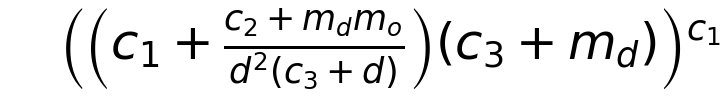

MCMC evolution


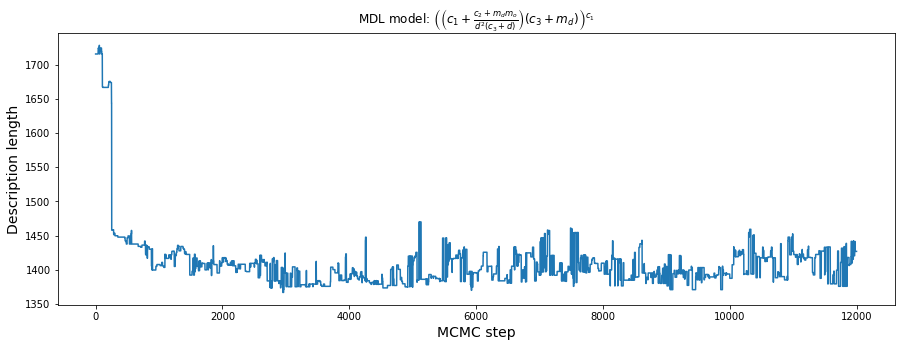

1413.92987151131 log(((((((d ** _a3_) * _a2_) * (((((m_d * d) / ((_a4_ * _a3_) * _a0_)) * (_a4_ + (_a2_ + _a4_))) + _a3_) * _a5_)) / (_a0_ + ((m_o / _a3_) + _a5_))) * (m_o + _a5_)) + _a2_)) {'d0': {'_a0_': -2404522.836484615, '_a2_': 91.86399118838786, '_a3_': -2.5863585463739875, '_a4_': -0.22339481670298153, '_a5_': 7435.007408774808, '_a1_': 1.0}}
1422.77990906977 (((((((m_d + ((_a3_ + _a0_) / _a3_)) / d) * (_a4_ * _a4_)) / (d * d)) * ((d + (((m_d * m_o) * _a3_) / -((_a4_ * d)))) ** 2)) ** log(_a1_)) + (_a5_ * _a1_)) {'d0': {'_a0_': -2.859307975055763e+16, '_a1_': 1.0271966196257758, '_a3_': -652109136533.7888, '_a4_': 5.974582900901923e+17, '_a5_': -6.122162025467066, '_a2_': 1.0}}
1424.49792591667 log(((((((d ** _a3_) * _a2_) * (((((m_d * d) / (((_a2_ * _a0_) * _a3_) * _a0_)) * ((_a4_ / _a2_) * _a5_)) + _a3_) * _a5_)) / (_a0_ + ((m_o / _a3_) + cos(_a4_)))) * (m_o + _a5_)) + _a2_)) {'d0': {'_a0_': -2394733.108866137, '_a2_': 91.85975496893897, '_a3_': -2.586293456881764, '_a4_': 11

1430.37252303844 -(-((((m_d / ((((_a3_ * -(d)) * (m_o ** _a4_)) * ((_a4_ * _a3_) * m_d)) * ((_a5_ * (_a1_ ** _a2_)) ** ((((m_d * m_o) / _a5_) + (d * d)) ** _a2_)))) ** _a0_) * (m_o ** _a4_)))) {'d0': {'_a0_': 0.22639253863304623, '_a1_': 1.2597331837065198e-84, '_a2_': 0.07969176734853273, '_a3_': 0.30693532178614735, '_a4_': -0.03394925957837041, '_a5_': 213370.26460942643}}
1417.37624465943 ((((log((((_a4_ / (_a2_ + m_o)) * (m_d * (m_o + (((m_d ** _a1_) * (_a1_ * (_a0_ + (m_o / (_a3_ ** d))))) ** 2)))) / (_a4_ * d))) / _a5_) * _a2_) ** 2) + (_a1_ * (_a4_ * _a3_))) {'d0': {'_a0_': 14899.790623957628, '_a1_': -0.24802936921907656, '_a2_': 8876187.673841588, '_a3_': 1.2220844028098028, '_a4_': -14.419016799319127, '_a5_': 24969002.569781747}}
1422.88952837196 ((((log((((_a4_ / ((_a4_ + _a5_) + m_o)) * (m_d * (m_o + (((m_d ** _a1_) * (_a1_ * (_a0_ + (m_o / (_a3_ ** d))))) ** 2)))) / (_a4_ * d))) / _a0_) * _a2_) ** 2) + (_a0_ * (_a4_ * _a3_))) {'d0': {'_a0_': 14900.04787791177, '_a1_': -0

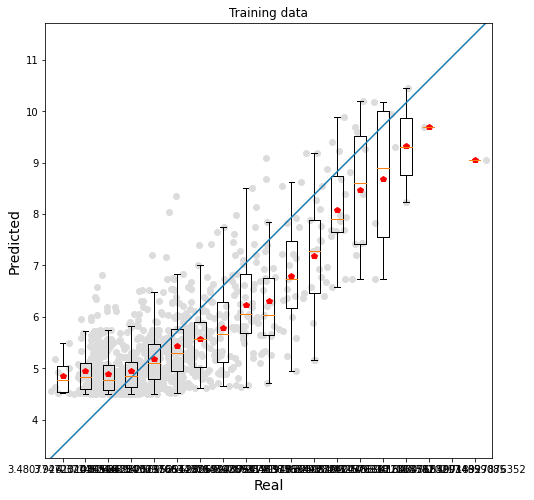

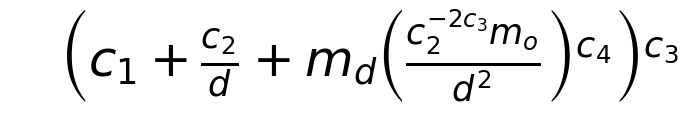

MCMC evolution


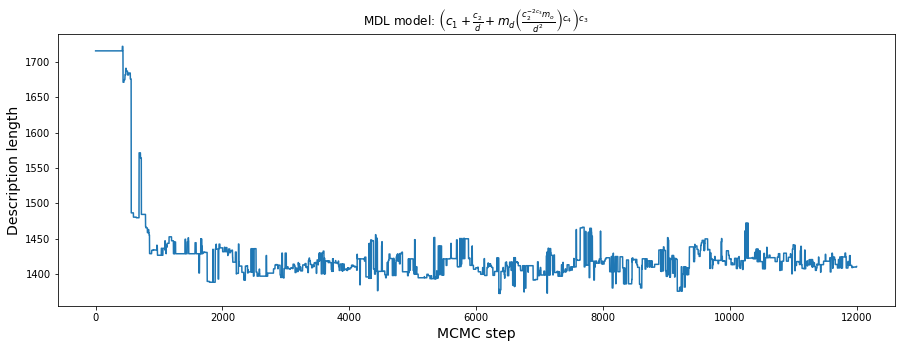

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1400.10100660633 (log((sqrt(((((d ** _a1_) * (((m_d * d) + _a4_) * (m_o + (_a5_ / _a4_)))) / (m_o + _a3_)) * sqrt((_a2_ * -(_a1_))))) + _a2_)) * _a2_) {'d0': {'_a1_': -2.6466522966082375, '_a2_': 3.438421182044337, '_a3_': 8945920.676562734, '_a4_': 37078.10585566207, '_a5_': 285257913.69745713, '_a0_': 1.0}}
1417.87821299786 (sqrt((_a4_ + ((d ** _a3_) * (m_d ** _a5_)))) ** ((m_o + (((((((_a1_ * _a1_) * _a3_) + _a3_) / log(_a1_)) * d) / m_d) * _a3_)) ** -(_a2_))) {'d0': {'_a1_': 40222.04217611199, '_a2_': -0.061298761740514934, '_a3_': -0.38327710243717855, '_a4_': 2.457140790440565, '_a5_': 0.23542722640637548, '_a0_': 1.0}}
1380.32300700937 (((m_d + (_a2_ / d)) * (((_a5_ * _a5_) / d) + (((((_a5_ + (m_o * d)) + _a2_) * m_d) * (d ** _a3_)) ** 2))) ** exp(_a3_)) {'d0': {'_a2_': 1143461.0462874982, '_a3_': -3.1225763921272858, '_a5_': -1163945.2358161176, '_a0_': 1.0, '_a1_': 1.0, '_a4_': 1.0}}
1390.82645325328 (log((sqrt(((((d ** _a1_) * (((m_d * d) + _a5_) * (m_o + _a4_))) / (m_o + _a3

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1406.27317531372 (((m_d + (_a2_ / d)) * (((_a5_ * (_a3_ * _a2_)) / d) + (((((_a5_ + (m_o * d)) + _a2_) * m_d) / (d ** -(((d + (_a4_ * _a2_)) / _a2_)))) ** 2))) ** exp(_a3_)) {'d0': {'_a2_': 483853.17212191544, '_a3_': -3.086809284931365, '_a4_': -3.3038109843793517, '_a5_': -504395.5478604769, '_a0_': 1.0, '_a1_': 1.0}}
1406.28771683665 (((m_d + (_a2_ / d)) * (((_a5_ * (_a3_ * _a2_)) / d) + (((((_a5_ + (m_o * d)) + _a2_) * m_d) / (d ** -(((_a5_ + (_a4_ * _a2_)) / _a2_)))) ** 2))) ** exp(_a3_)) {'d0': {'_a2_': 484485.83551332407, '_a3_': -3.086906908586244, '_a4_': -2.2607159661657255, '_a5_': -505027.9443964047, '_a0_': 1.0, '_a1_': 1.0}}
1393.23827883720 ((((((((((m_o ** _a0_) ** _a2_) * m_d) + _a3_) ** _a2_) / (_a2_ * log((d + _a1_)))) / _a4_) ** 2) * _a2_) + _a1_) {'d0': {'_a0_': 5.408025391452715, '_a1_': 3.7948633114311385, '_a2_': 0.1508792326647266, '_a3_': 13646600.707673555, '_a4_': 10.200991725048157, '_a5_': 1.0}}
1397.14066818553 ((((((_a2_ + (m_o / _a4_)) / d) / ((((_a2_ *

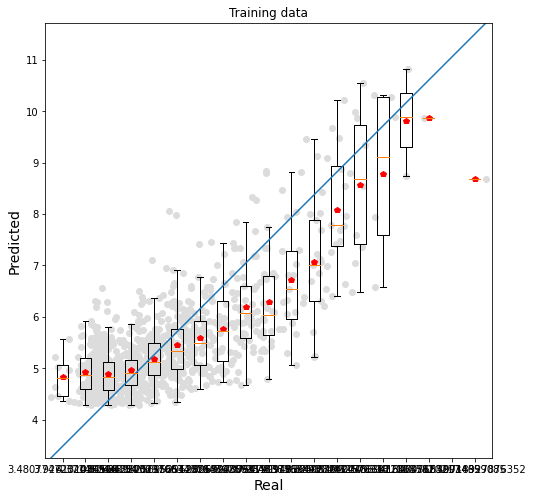

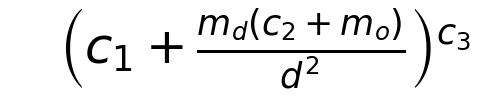

MCMC evolution


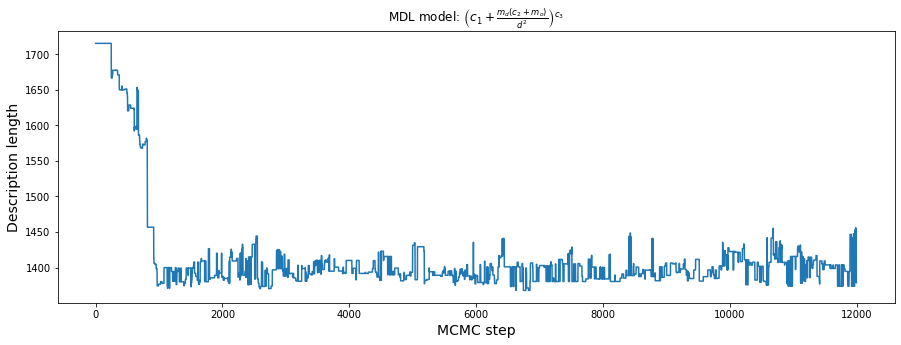

1368.06866220158 ((_a0_ + ((((m_d + _a2_) / d) ** _a3_) * ((_a2_ + (_a2_ + m_o)) / m_d))) ** _a1_) {'d0': {'_a0_': 3006650.0372962058, '_a1_': 0.10111833091903295, '_a2_': 1736.1841900527163, '_a3_': 2.3062532615719804, '_a4_': 1.0, '_a5_': 1.0}}
1374.70076842964 log(((_a5_ * (((((((_a3_ + _a5_) / d) + m_d) / _a4_) * ((m_o + _a0_) * m_d)) + _a3_) / d)) + _a1_)) {'d0': {'_a0_': 5094.339430152264, '_a1_': 82.06143977275943, '_a3_': 1.173635880088503e-06, '_a4_': 6.254430129850296e+21, '_a5_': 585289893.822953, '_a2_': 1.0}}
1374.79022224598 log(((_a5_ * ((((((_a2_ / d) + m_d) / _a4_) * ((m_o + _a5_) * m_d)) + _a3_) / (d / _a2_))) + _a1_)) {'d0': {'_a1_': 82.06148855211997, '_a2_': 585310666.8162262, '_a3_': 2.3035557527500476e-10, '_a4_': 3.1866102805483977e+25, '_a5_': 5094.599938197326, '_a0_': 1.0}}
1391.63627913781 (((((((m_o * ((_a4_ * (m_d + _a4_)) * m_d)) + _a3_) + m_o) / _a2_) / (d * ((d + d) * _a2_))) + _a1_) ** cos(_a2_)) {'d0': {'_a1_': 935771.7276299904, '_a2_': -927129.43588

1386.01201707832 log((((((m_d ** ((_a2_ + _a4_) / _a4_)) * (((m_o / d) + (_a5_ / (_a0_ * m_d))) / d)) * _a1_) + _a4_) + _a5_)) {'d0': {'_a0_': 70.25090641164763, '_a1_': 4.902998126936019e-06, '_a2_': -483414956.51347274, '_a4_': -2013627152.167019, '_a5_': 2013627222.9549954, '_a3_': 1.0}}
1386.01201707832 log((((((m_d ** ((_a2_ + _a4_) / _a4_)) * (((m_o / d) + (_a5_ / (_a0_ * m_d))) / d)) * _a1_) + _a4_) + _a5_)) {'d0': {'_a0_': 70.25090641164763, '_a1_': 4.902998126936019e-06, '_a2_': -483414956.51347274, '_a4_': -2013627152.167019, '_a5_': 2013627222.9549954, '_a3_': 1.0}}
1376.15092875027 log(((_a0_ * ((((((_a1_ / d) + m_d) * _a5_) * (m_o * (_a0_ * m_d))) + _a3_) / d)) + (_a5_ * _a5_))) {'d0': {'_a0_': -1.5152195070849687e-07, '_a1_': 303171784.34166616, '_a3_': -6276321769.488482, '_a5_': 8.875537742388953, '_a2_': 1.0, '_a4_': 1.0}}
1389.45181971183 (((((((_a4_ * ((m_o + _a5_) * _a4_)) * ((m_d ** 2) + (_a0_ / d))) * (_a3_ * (-(m_d) / d))) + _a0_) ** 2) ** _a4_) * _a4_) {'d0': {'

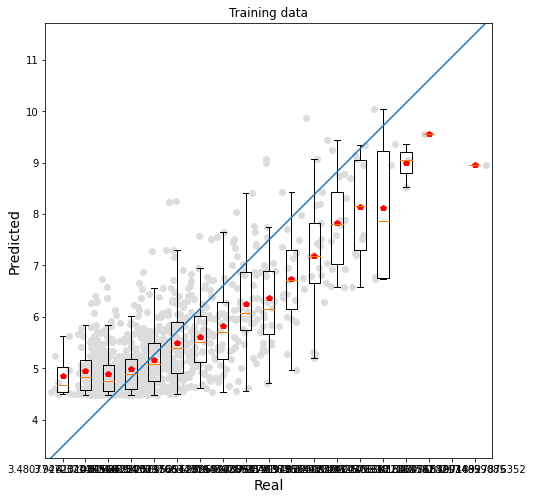

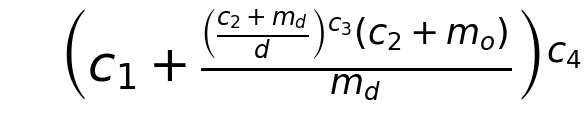

MCMC evolution


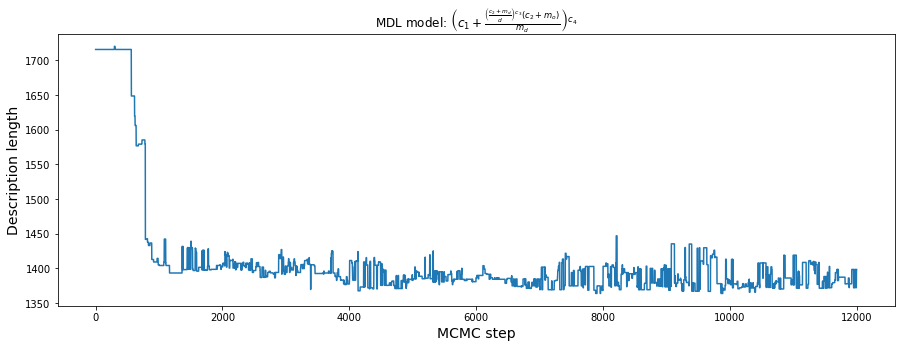

1368.60455615584 log((((sqrt(((m_d * (((_a4_ + (d * m_d)) * m_o) + _a3_)) * _a5_)) / d) ** 2) + _a0_)) {'d0': {'_a0_': 100.32921325439355, '_a3_': 5193909673163.49, '_a4_': 434760202.28446037, '_a5_': 1.1829207038906359e-13, '_a1_': 1.0, '_a2_': 1.0}}
1384.10239277256 log((((((_a4_ + (m_o / _a4_)) / (d * d)) + ((m_d * _a1_) * (_a0_ * m_o))) * (m_d / log((_a1_ * m_o)))) + _a4_)) {'d0': {'_a0_': 2.537407351407419e-86, '_a1_': 2.4982226967647633e+72, '_a4_': 100.87076651090217, '_a2_': 1.0, '_a3_': 1.0, '_a5_': 1.0}}
1377.39654298206 log(-(-(((((((((m_o ** _a4_) * m_d) + _a5_) * (d ** _a3_)) * _a0_) + _a1_) + _a5_) + _a1_)))) {'d0': {'_a0_': 0.0002292656335325024, '_a1_': -5515356.910959126, '_a3_': -1.5838201580782594, '_a4_': 0.7910598432134764, '_a5_': 11030796.926417924, '_a2_': 1.0}}
1395.89272551514 (log((((((((m_d + (_a0_ / -(d))) * (d ** _a5_)) + _a4_) * (m_o * sqrt(m_d))) + (_a2_ / log(d))) ** 2) ** -(_a4_))) ** 2) {'d0': {'_a0_': -142263.83607940245, '_a2_': 227370084.0107185, '

1388.17141801243 log(((((((m_d / _a2_) + _a4_) * _a1_) / d) / _a2_) * ((((d * _a1_) * (d + log((m_d * m_d)))) + (m_o * m_d)) / d))) {'d0': {'_a1_': 1238745.0283191768, '_a2_': 280927441.1520988, '_a4_': 0.012559028949212788, '_a0_': 1.0, '_a3_': 1.0, '_a5_': 1.0}}
1413.29824685864 log((_a3_ + (((_a1_ * _a4_) + (((((m_d * (_a1_ / (_a4_ / _a1_))) * (m_o * (((_a3_ + _a4_) ** 2) / _a4_))) + _a4_) * (log(m_o) ** _a5_)) * (d ** _a5_))) / _a1_))) {'d0': {'_a1_': 0.0004536648572253755, '_a3_': 42.63655075035906, '_a4_': 44.829287564663275, '_a5_': -1.6775881239958694, '_a0_': 1.0, '_a2_': 1.0}}
1385.95086311798 log(((((((m_d / _a2_) + _a4_) * _a2_) / d) / _a2_) * ((((d * _a1_) * (d + log(_a1_))) + (m_o * m_d)) / d))) {'d0': {'_a1_': 1244515.7618006165, '_a2_': 63536668106.604614, '_a4_': 5.9918806091931924e-05, '_a0_': 1.0, '_a3_': 1.0, '_a5_': 1.0}}
1385.95086311362 log(((((((m_d / _a2_) + _a4_) * _a1_) / d) / _a2_) * ((((d * _a1_) * (d + log(_a1_))) + (m_o * m_d)) / d))) {'d0': {'_a1_': 1244

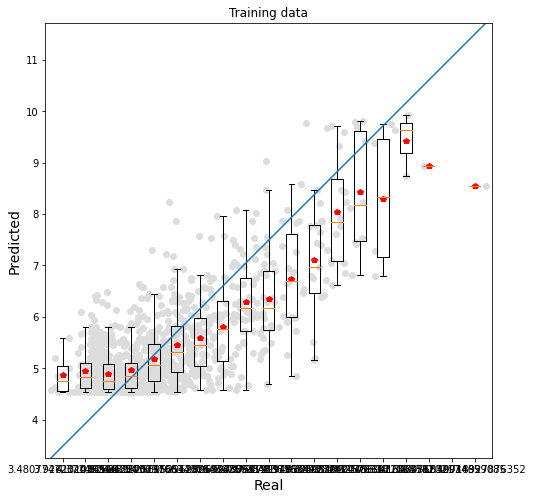

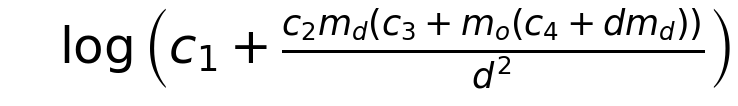

MCMC evolution


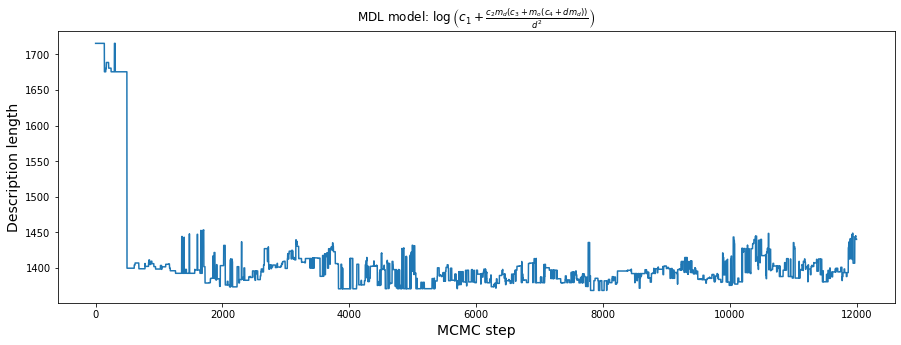

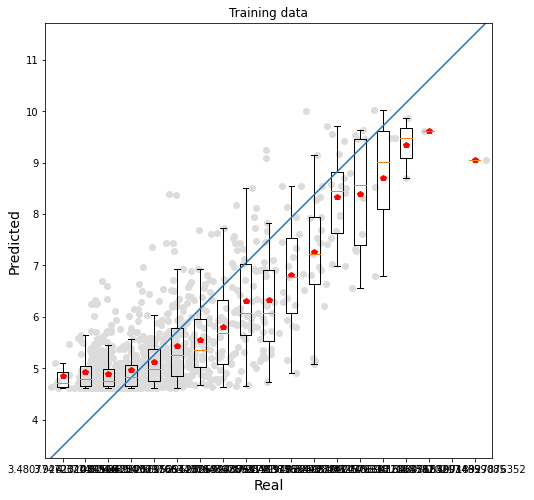

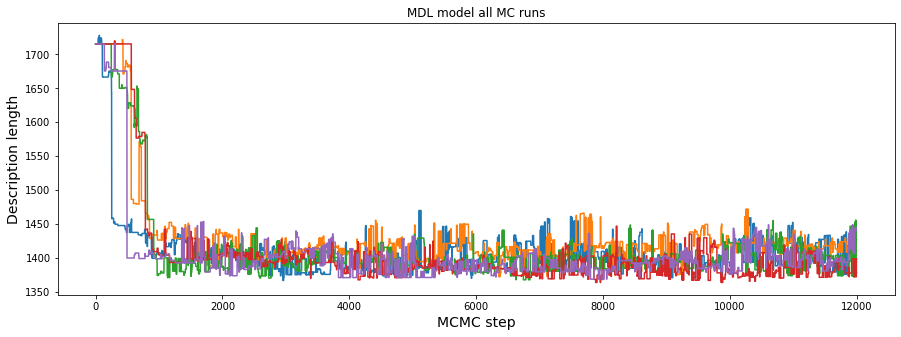

########################################
Lowest mdl for training data: 1363.77869881858
Model: ((_a0_ + ((((m_d + _a2_) / d) ** _a3_) * ((_a2_ + m_o) / m_d))) ** _a1_)
1396.14552275155 (((_a0_ + (_a2_ / _a1_)) * (((m_d * m_o) + abs((d * _a3_))) ** ((_a0_ + ((d / _a4_) ** 2)) ** _a1_))) + (m_d / _a0_)) {'d0': {'_a0_': 316502.1979595191, '_a1_': -0.05845180702288552, '_a2_': 18500.08484535473, '_a3_': 42952894.94066894, '_a4_': 5.0285193545390316e-08, '_a5_': 1.0}}
1450.03051253144 ((cosh(((((_a1_ / (((m_o ** (_a1_ + (_a0_ + _a0_))) + _a2_) ** _a5_)) * (m_d ** 2)) ** _a0_) + (log(((_a5_ * ((sin((_a2_ ** 2)) ** 2) * (d * _a0_))) * _a3_)) / (_a3_ * sqrt((_a0_ + _a1_)))))) * -(_a5_)) + _a3_) {'d0': {'_a0_': 0.15745470892225122, '_a1_': 6.406940854008637e-70, '_a2_': 218.6234288006721, '_a3_': -18.847939877690376, '_a5_': -23.14886643242002, '_a4_': 1.0}}
1399.46801952470 (((((_a0_ / d) + ((m_d / ((((_a0_ + m_o) + _a5_) ** _a2_) * d)) + _a1_)) ** sin(_a5_)) + ((_a3_ * (((-(_a5_) ** 2) ** 2) 

1384.57841744606 ((_a5_ + (((m_d * m_o) + sqrt((d * (_a2_ * d)))) ** (((abs(sin((m_d + _a5_))) ** _a5_) * ((d / (_a1_ * _a0_)) ** 2)) ** _a1_))) + (m_d * _a0_)) {'d0': {'_a0_': 2.8533727784935756e-06, '_a1_': -0.06659930237693179, '_a2_': 618014987067000.6, '_a5_': -0.14412552698609662, '_a3_': 1.0, '_a4_': 1.0}}
1372.27603442875 ((((sqrt(((_a5_ / m_d) + m_o)) / d) * ((m_d + _a2_) / _a3_)) + _a3_) ** sqrt(cos(_a2_))) {'d0': {'_a2_': 5116.030671769324, '_a3_': 355.0807724810198, '_a5_': 2507920287.018186, '_a0_': 1.0, '_a1_': 1.0, '_a4_': 1.0}}
1384.57841744606 ((_a5_ + (((m_d * m_o) + sqrt((d * (_a2_ * d)))) ** (((abs(sin((m_d + _a5_))) ** _a5_) * ((d / (_a1_ * _a0_)) ** 2)) ** _a1_))) + (m_d * _a0_)) {'d0': {'_a0_': 2.8533727784935756e-06, '_a1_': -0.06659930237693179, '_a2_': 618014987067000.6, '_a5_': -0.14412552698609662, '_a3_': 1.0, '_a4_': 1.0}}
1377.24580143461 ((((sqrt(((_a5_ / m_d) + m_o)) / d) * ((m_d + _a2_) / _a3_)) + (d + _a3_)) ** sqrt(cos(_a2_))) {'d0': {'_a2_': 5116.03

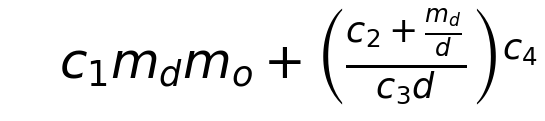

MCMC evolution


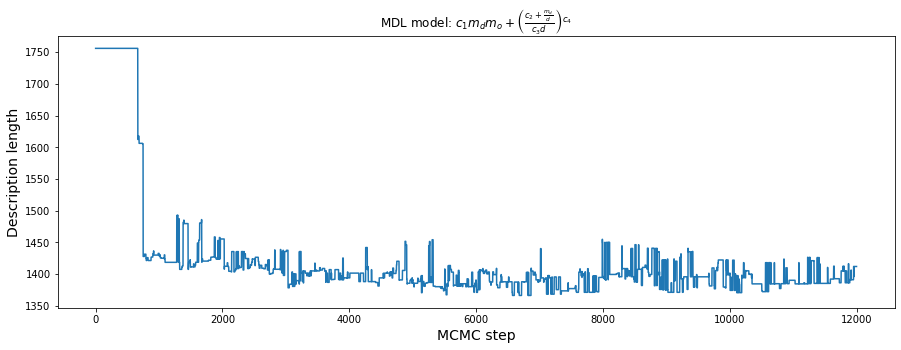

1399.32279851866 log((_a3_ + ((((_a3_ * _a3_) * (((((_a1_ + (m_d / (_a2_ + sqrt((m_o * _a0_))))) * _a1_) * _a4_) * m_o) + ((_a2_ + _a0_) * _a1_))) / d) ** (_a0_ * _a4_)))) {'d0': {'_a0_': 1242.0378538103805, '_a1_': 0.00010238618122645014, '_a2_': -908.9849851140967, '_a3_': 86.28432183620369, '_a4_': 0.0014121525926956897, '_a5_': 1.0}}
1379.73769143442 (((_a3_ + ((m_d + (((m_d * _a5_) * m_o) + _a0_)) / (d * ((_a2_ * (_a4_ ** 2)) ** 2)))) ** _a4_) * _a0_) {'d0': {'_a0_': 78608.50240037337, '_a2_': -730358209321.2185, '_a3_': 8.697059825439128e-19, '_a4_': 0.2384098687189382, '_a5_': 1.6664962028149158e-05, '_a1_': 1.0}}
1379.73769147258 (((_a3_ + ((m_d + (((m_d * (_a5_ ** 2)) * m_o) + _a0_)) / (d * ((_a2_ * _a5_) ** 2)))) ** _a4_) * _a0_) {'d0': {'_a0_': 78607.98565621882, '_a2_': -10171896822076.178, '_a3_': 8.69141843195058e-19, '_a4_': 0.23840625802921267, '_a5_': 0.0040822706653102754, '_a1_': 1.0}}
1425.82850486491 (-(((_a4_ + (((m_o * (d * ((_a3_ ** _a3_) * m_d))) ** (_a1_ + (m_

1432.98527488794 log(((((_a2_ + (((d / (d + (m_o / (_a0_ ** 2)))) * log((m_d * _a0_))) * (_a4_ / ((m_o ** 2) / _a1_)))) * ((((_a5_ * m_d) * (sqrt(m_o) * _a1_)) + (_a0_ / _a4_)) / (d * _a5_))) ** (_a2_ / _a1_)) + _a3_)) {'d0': {'_a0_': 12.822177971623187, '_a1_': 0.004560032525138232, '_a2_': 0.00800369122902213, '_a3_': 85.43262313283651, '_a4_': 314436.71847120306, '_a5_': 1.3352482365649622e-09}}
1404.71498616605 (log(((((log(((((_a3_ + m_d) + (m_o / (_a3_ / ((_a0_ / _a0_) * m_d)))) * _a0_) / d)) + sqrt((_a4_ * (_a3_ + _a3_)))) ** _a4_) / _a5_) + _a4_)) * _a4_) {'d0': {'_a0_': 6.64514675311321e-306, '_a3_': 68720.20600808943, '_a4_': 3.535924474392349, '_a5_': 35.0960310694849, '_a1_': 1.0, '_a2_': 1.0}}
1396.13968627436 ((cos(-((((((((((sqrt(m_o) / _a4_) * (m_d + m_d)) ** sin(_a4_)) + _a1_) ** 2) + m_d) / (_a3_ * d)) + _a0_) ** 3))) + _a5_) * _a3_) {'d0': {'_a0_': -0.06583089793727513, '_a1_': 1955.631036453211, '_a3_': 127307172.33625966, '_a4_': 234.92122961914941, '_a5_': -0.9999

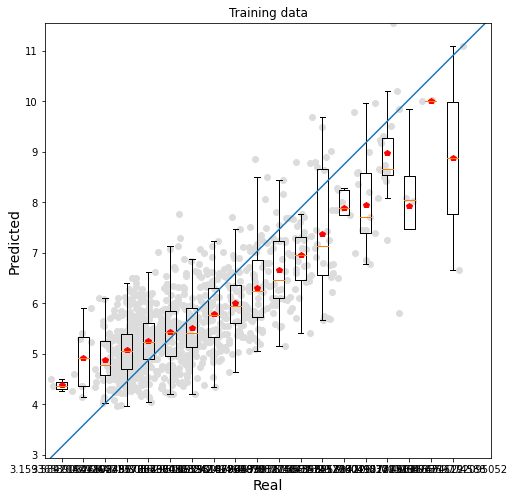

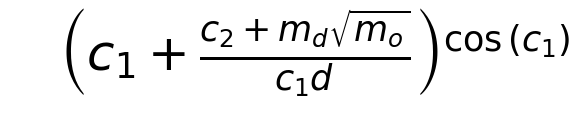

MCMC evolution


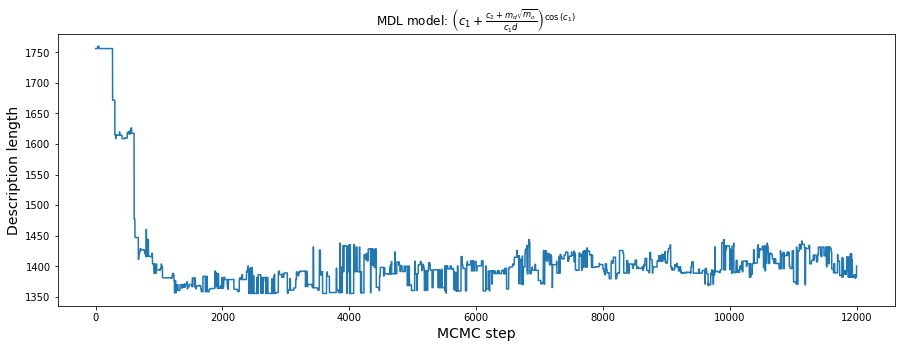

1392.48219301515 (((((log((_a4_ + ((_a5_ + m_d) * ((_a5_ * m_d) * m_o)))) + (log(m_d) / sqrt(d))) + _a5_) + _a0_) / _a5_) * (_a5_ + m_d)) {'d0': {'_a0_': -3531866.2485326743, '_a4_': 1.0715338794293545e+23, '_a5_': 3531816.559295812, '_a1_': 1.0, '_a2_': 1.0, '_a3_': 1.0}}
1409.05444347494 (log(((((_a2_ * m_d) ** (_a1_ ** (_a1_ ** sqrt(d)))) * (((m_d * m_o) + (_a5_ + ((_a3_ * _a0_) + _a0_))) ** 2)) + -(_a0_))) * ((((d + _a0_) * _a0_) * _a5_) * _a3_)) {'d0': {'_a0_': -828.0247636969514, '_a1_': 0.6813046603027625, '_a2_': 4.300424144159101e-23, '_a3_': -9436081.393302884, '_a5_': -1.1678516805097098e-13, '_a4_': 1.0}}
1392.44630980925 (((log((((_a2_ + (((sin((_a5_ * d)) + (_a2_ ** 2)) + m_o) * (m_d + (m_d * _a4_)))) ** _a0_) * d)) * _a1_) ** 2) + _a5_) {'d0': {'_a0_': -0.8399237149989169, '_a1_': -0.5103339787307253, '_a2_': 249.49093362354435, '_a4_': -0.9999999130127447, '_a5_': 4.457732704938143, '_a3_': 1.0}}
1385.47581511854 (((log((((_a2_ + ((((_a0_ * _a1_) * (_a2_ ** 2)) + m_o) *

1394.99144521256 (log(((((_a1_ + ((((_a4_ + m_o) * _a2_) * _a0_) * m_d)) / (d * (m_o + (_a1_ / (_a5_ * _a5_))))) + _a3_) + _a5_)) / (_a0_ * (_a1_ * _a0_))) {'d0': {'_a0_': 7.567563866467763e-05, '_a1_': 84914707.39358515, '_a2_': 444.2549892687788, '_a3_': -3.4854545649439035, '_a4_': 26035.956268324702, '_a5_': 10.664028410971255}}
1446.76719356701 ((-(((d * (((_a5_ * d) * -((((_a0_ * (_a5_ * m_d)) * m_o) + ((_a2_ ** 2) ** m_o)))) * ((d ** _a4_) * (d + (((m_o * _a1_) + _a3_) * (_a0_ + -(_a2_))))))) ** 2)) * (_a3_ + -(sqrt(m_d)))) ** 2) {'d0': {'_a0_': -5.250246161566004e-08, '_a1_': -0.003208627559158202, '_a2_': 0.9999996136580311, '_a3_': -2893.5473593641404, '_a4_': -2.059227336601386, '_a5_': -1.1373056488881026e-05}}
1435.80157030133 ((((((log((-(_a1_) * (_a3_ + ((_a0_ * ((d + ((d + m_o) ** _a0_)) + (m_d / _a4_))) * m_o)))) * (log(m_d) / sqrt((d + (_a1_ ** m_d))))) * _a2_) / (_a0_ * _a1_)) + _a0_) * (_a5_ + m_d)) ** 2) {'d0': {'_a0_': -4.011006009819145e-07, '_a1_': 1.00000422708

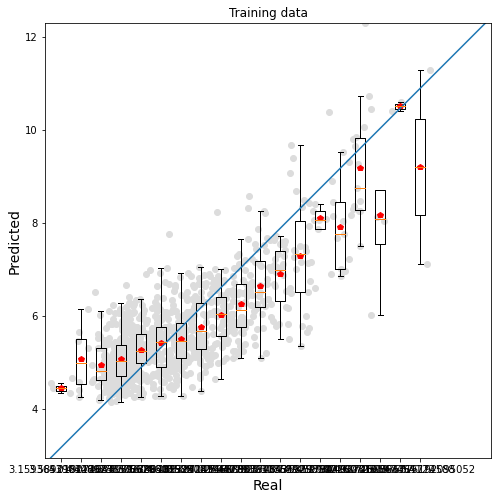

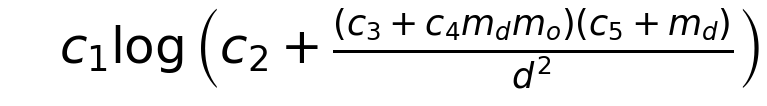

MCMC evolution


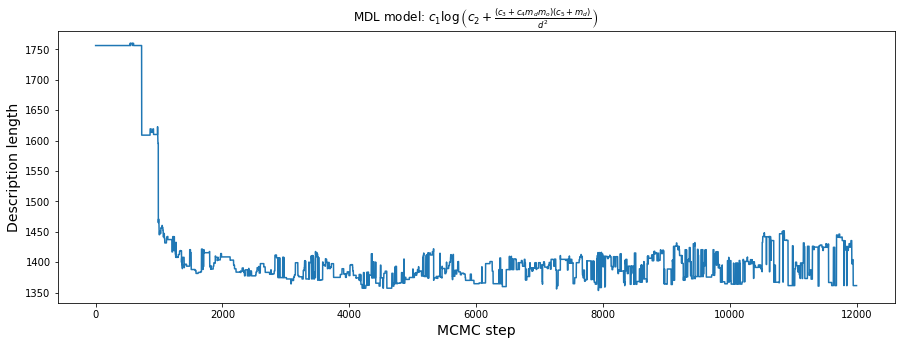

1423.59758713681 exp(exp(((((((_a2_ + m_o) * m_d) ** (((m_o / (_a1_ * (m_o * _a4_))) ** 3) * _a5_)) * _a5_) + ((_a2_ * (_a5_ + (_a5_ * (_a2_ * _a4_)))) / log((_a5_ + d)))) / _a1_))) {'d0': {'_a1_': 345167.6080824145, '_a2_': 61237.471815366924, '_a4_': 7.1697525744433045e-06, '_a5_': 5.978722490145379, '_a0_': 1.0, '_a3_': 1.0}}
1395.91006923942 (((((((_a0_ * (_a5_ * m_d)) * (_a5_ * m_o)) ** (d / log((_a5_ + (d * _a4_))))) ** 2) + (_a4_ ** (_a5_ * (_a0_ * m_d)))) / _a2_) * _a4_) {'d0': {'_a0_': 1.8154470774390341e-06, '_a2_': 3.970057183250247e+60, '_a4_': 1.8462420412303156e+61, '_a5_': 0.0019286465538656658, '_a1_': 1.0, '_a3_': 1.0}}
1403.70540337438 -(log((((-(((_a2_ * _a4_) + ((-(m_d) + (_a2_ / _a3_)) / d))) + -(((m_d * (_a4_ / d)) * m_o))) * (_a2_ ** _a1_)) ** (_a5_ * _a3_)))) {'d0': {'_a1_': -0.33690461103202357, '_a2_': 290915561.5798157, '_a3_': -3756.948494362184, '_a4_': -1.7111099009171168e-05, '_a5_': 0.0005536604939840272, '_a0_': 1.0}}
1382.65294342230 (cos(log((((((_a1_

1401.92062918518 log(((_a3_ ** cos(_a0_)) + -((((((_a5_ / ((_a4_ / -(_a5_)) ** 2)) * d) / m_d) + ((_a5_ + m_o) * _a3_)) / ((((_a0_ / m_d) + _a4_) * d) * d))))) {'d0': {'_a0_': -16580985.88588015, '_a3_': 587.035882166142, '_a4_': 17.541016966287607, '_a5_': 22337.672302919666, '_a1_': 1.0, '_a2_': 1.0}}
1401.92062918518 log(((_a3_ ** cos(_a0_)) + -((((((_a5_ / ((_a4_ / -(_a5_)) ** 2)) * d) / m_d) + ((_a5_ + m_o) * _a3_)) / ((((_a0_ / m_d) + _a4_) * d) * d))))) {'d0': {'_a0_': -16580985.88588015, '_a3_': 587.035882166142, '_a4_': 17.541016966287607, '_a5_': 22337.672302919666, '_a1_': 1.0, '_a2_': 1.0}}
1401.91825135403 log(((_a3_ ** cos(_a4_)) + -((((((_a5_ / ((_a4_ / -(_a5_)) ** 2)) * d) / m_d) + ((_a5_ + m_o) * _a3_)) / ((((_a0_ / m_d) + _a4_) * d) * d))))) {'d0': {'_a0_': -17063175.04362135, '_a3_': 601.6788964084251, '_a4_': 17.996099061870506, '_a5_': 22896.5486048055, '_a1_': 1.0, '_a2_': 1.0}}
1435.37777106733 (sqrt(exp(((((((m_o + _a2_) * m_d) ** (((m_o / (_a0_ * (((m_o + m_o) 

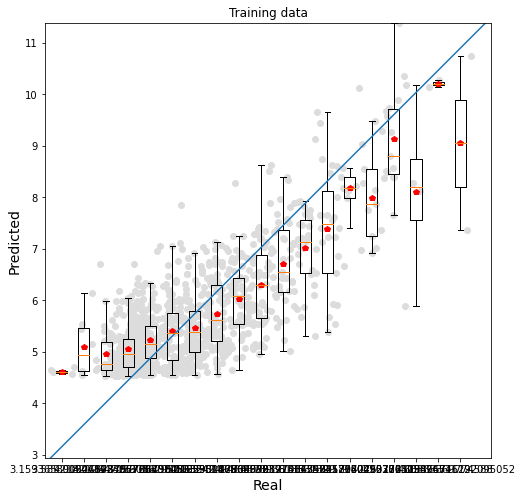

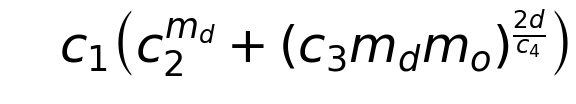

MCMC evolution


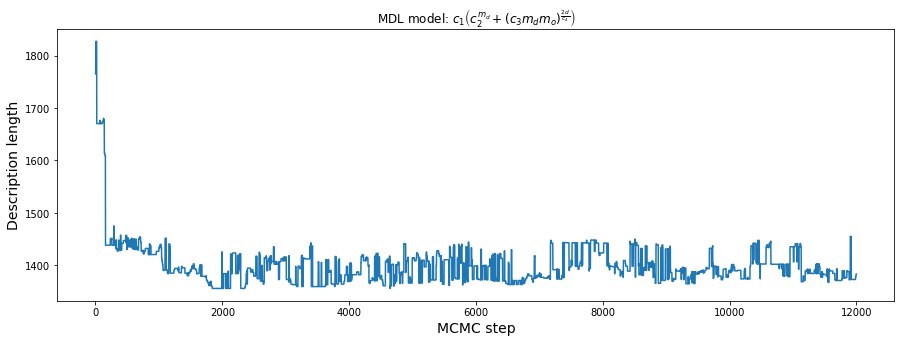

1381.82039156849 log((_a2_ + (((_a5_ / (d * _a2_)) / d) * ((m_d + (_a4_ * (d + _a4_))) * (_a4_ + ((m_o * (_a2_ + (_a5_ * m_d))) * _a1_)))))) {'d0': {'_a1_': 7.493582844683614e-08, '_a2_': 96.65556744115828, '_a4_': 144.35675429757995, '_a5_': 0.7323910642672301, '_a0_': 1.0, '_a3_': 1.0}}
1386.15078525963 log(((((((_a5_ + (_a0_ * log((m_o + _a1_)))) * (m_d + _a2_)) / (d * _a3_)) ** 2) + (_a0_ / log(m_o))) + _a4_)) {'d0': {'_a0_': 1492.5309426835588, '_a1_': 47147.23685383122, '_a2_': 54262.271365556444, '_a3_': -568708.4806675203, '_a4_': -49.92044364860996, '_a5_': -14921.914864545188}}
1406.45080128504 (((((((m_d * (_a0_ * ((m_o + (_a5_ + _a0_)) / _a5_))) ** (((log(_a1_) * d) + _a4_) ** _a4_)) * d) ** 2) * (_a2_ + -(_a5_))) ** (_a1_ + (_a1_ + _a3_))) + _a1_) {'d0': {'_a0_': 2.523778859898457e-07, '_a1_': 4.615134883585378, '_a2_': 1.480251956552175e+35, '_a3_': -9.205838978453935, '_a4_': 0.6361192198487425, '_a5_': 64993.886483484086}}
1403.25093275310 (((((((m_d * (_a0_ * ((m_o + _

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1376.07999850525 log(((((sqrt((_a3_ + (_a2_ * (_a5_ + m_o)))) * (((_a5_ * (m_o ** _a4_)) + m_d) / d)) ** _a1_) + _a0_) + _a5_)) {'d0': {'_a0_': -1138055.6256125136, '_a1_': 1.7741600575968486, '_a2_': 9.27946239552267e-10, '_a3_': -0.00105081605081279, '_a4_': -0.32013034850857397, '_a5_': 1138142.5123825776}}
1393.57467292741 (((((((m_d * ((_a1_ * _a4_) * ((m_o + _a0_) / _a5_))) ** (((d * _a4_) * _a4_) ** _a4_)) / -(cos(m_d))) ** 2) * (_a5_ * d)) ** (_a1_ ** -(_a4_))) + log(_a1_)) {'d0': {'_a0_': 65806.95887360023, '_a1_': 93.92577016317098, '_a4_': 0.6098565174331203, '_a5_': 14965072369946.293, '_a2_': 1.0, '_a3_': 1.0}}
1393.74690916594 (((((((m_d * ((_a1_ * _a4_) * ((m_o + _a0_) / _a5_))) ** (((d * _a4_) * _a4_) ** _a4_)) / -(cos(m_d))) ** 2) * (_a5_ * _a4_)) ** (_a1_ ** -(_a4_))) + log(_a1_)) {'d0': {'_a0_': 66780.0988459567, '_a1_': 94.42378227215167, '_a4_': 0.5921894599360963, '_a5_': 12455380482670.742, '_a2_': 1.0, '_a3_': 1.0}}
1426.64945266508 (((log((((_a4_ + (((((_a1_ **

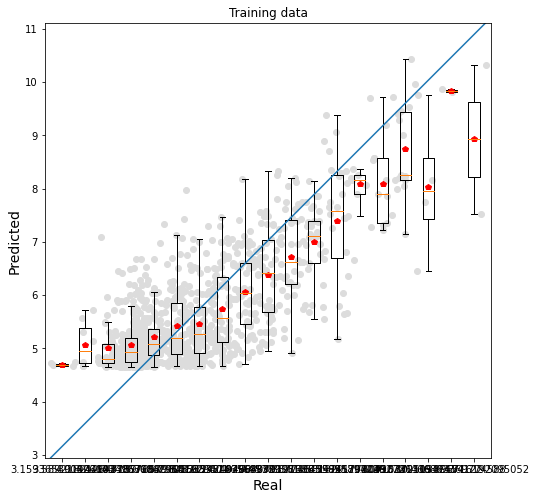

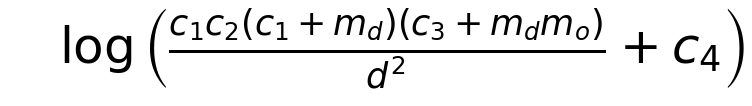

MCMC evolution


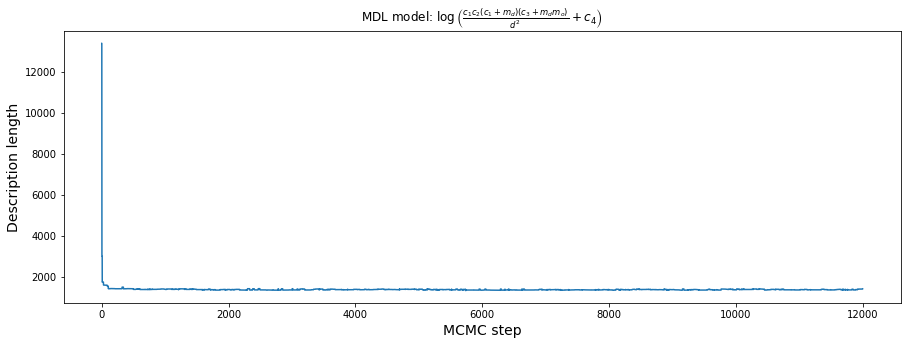

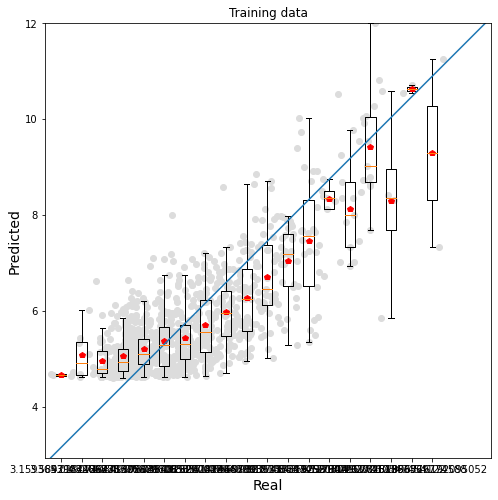

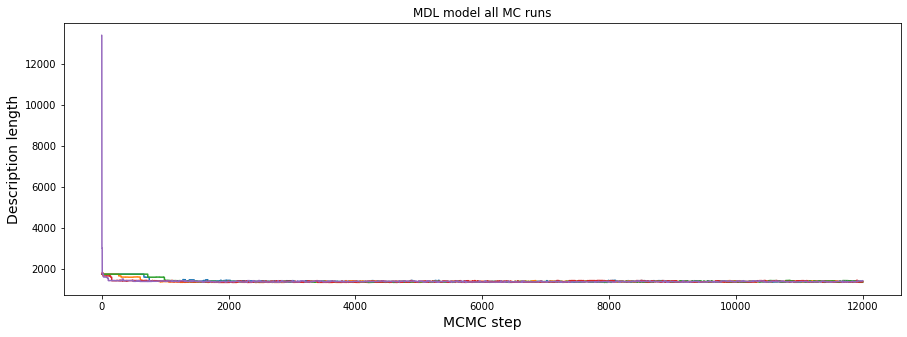

########################################
Lowest mdl for training data: 1353.54401640761
Model: (log(((((_a3_ + m_d) * (((m_d * m_o) * _a4_) + _a2_)) / (d ** 2)) + _a1_)) * _a5_)
1363.78956337500 ((((sqrt(m_o) * (((((m_o / m_o) * m_d) * _a1_) + m_d) ** (_a4_ + (_a4_ ** d)))) + log(m_d)) / d) + -(_a2_)) {'d0': {'_a1_': -0.9999994714888566, '_a2_': -4.566141983765153, '_a4_': 0.6756639009791432, '_a0_': 1.0, '_a3_': 1.0, '_a5_': 1.0}}
1393.94809678521 ((((((d + _a3_) ** _a5_) + (_a5_ / d)) * ((_a3_ / ((((_a1_ / ((_a5_ * ((_a4_ * _a4_) / _a4_)) ** 2)) + m_o) * m_d) ** _a5_)) + _a4_)) ** 2) + (_a3_ * _a2_)) {'d0': {'_a1_': 66493.0326307394, '_a2_': 54059.66629850445, '_a3_': 8.09660484749156e-05, '_a4_': 3.4507093236849165, '_a5_': -0.4642366464601717, '_a0_': 1.0}}
1366.40559467337 ((((sqrt(m_o) * (((((m_o / m_o) * m_d) * (_a5_ * _a4_)) + m_d) ** (_a4_ + (_a4_ ** d)))) + log(m_d)) / d) + _a0_) {'d0': {'_a0_': 4.5665074964120596, '_a4_': 0.6405763144873179, '_a5_': -1.5610935713735141, '_a1

1375.39361840251 ((((sqrt((_a5_ + m_o)) * (((-(m_d) * _a2_) + m_d) ** (_a1_ + (_a4_ ** (_a2_ * d))))) + abs(_a3_)) / d) + (_a3_ * _a4_)) {'d0': {'_a1_': 0.5842379713850323, '_a2_': 0.9999996448454077, '_a3_': 7.000279040366798, '_a4_': 0.6489219191854316, '_a5_': 12837.540591903853, '_a0_': 1.0}}
1369.62693605448 ((((sqrt((_a5_ + m_o)) * (((-((_a2_ * m_d)) * _a2_) + m_d) ** (_a1_ + (_a4_ ** d)))) + _a0_) / d) + (_a3_ * _a1_)) {'d0': {'_a0_': 8.856277726801437, '_a1_': 0.606457521183859, '_a2_': 0.9999997955730634, '_a3_': 7.426979840250138, '_a4_': 0.6904776684611567, '_a5_': 10664.318041402774}}
1367.72243613497 ((((sqrt((_a5_ + m_o)) * (((-((_a2_ * m_d)) * _a2_) + m_d) ** (_a1_ + (_a1_ ** d)))) + _a0_) / d) + (_a3_ * _a0_)) {'d0': {'_a0_': 8.88728566464228, '_a1_': 0.6606748760980539, '_a2_': 0.9999997502255642, '_a3_': 0.5112192044472638, '_a5_': 8352.950484670806, '_a4_': 1.0}}
1371.98482024064 ((((((m_d * m_o) ** ((_a1_ ** 2) + _a2_)) + ((d * _a0_) + (m_d + (m_d * ((m_o + _a5_) * 

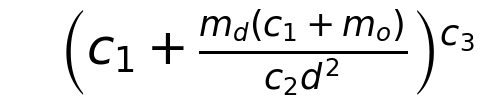

MCMC evolution


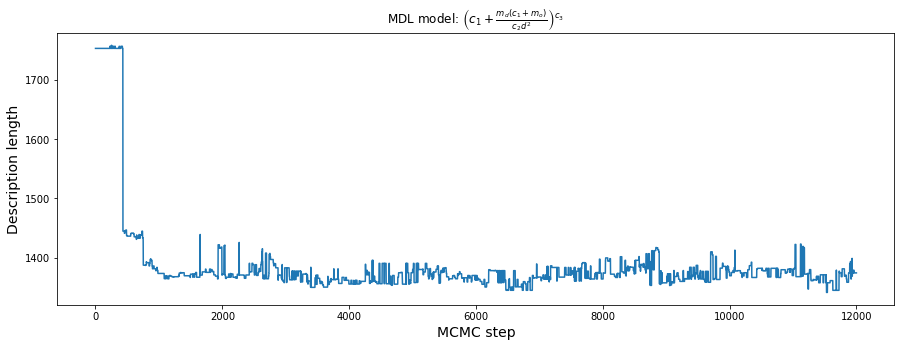

1415.60974879956 sqrt((((_a5_ * (sqrt(m_o) + (((_a3_ + (_a2_ * (_a2_ / m_o))) / _a3_) / _a4_))) * (((_a2_ / d) * (-(-(_a0_)) * exp(_a0_))) * ((_a2_ + m_d) ** (_a2_ / _a1_)))) + _a0_)) {'d0': {'_a0_': 19.757611715730718, '_a1_': 22272.97892744633, '_a2_': 15086.171054102997, '_a3_': -1.0955809053224362e+40, '_a4_': 0.008638979700467642, '_a5_': 4.891225305725688e-18}}
1429.47622015618 ((((m_d ** (_a2_ * (sqrt((sqrt(((_a1_ / _a1_) + d)) + (d / d))) / ((m_d * (m_d * m_o)) ** ((_a1_ + sqrt(_a4_)) ** 2))))) + _a4_) * ((_a0_ * ((sqrt(_a4_) / (d * d)) + abs(_a1_))) ** _a3_)) ** 2) {'d0': {'_a0_': 2.6226762460913133e+33, '_a1_': -0.00019541216290550227, '_a2_': -14.219800401135245, '_a3_': 0.040516300683894745, '_a4_': 0.13441448820912913, '_a5_': 1.0}}
1423.91851889262 ((((m_d ** (_a2_ * (sqrt((sqrt((_a4_ + d)) + (_a5_ / d))) / ((m_d * (m_d * m_o)) ** ((_a1_ + sqrt(_a4_)) ** 2))))) + _a4_) * ((_a0_ * ((sqrt(m_d) / (d * d)) + abs(_a1_))) ** _a3_)) ** 2) {'d0': {'_a0_': 1.2716282072842174e+17, 

1396.53950933551 (((((_a3_ * m_d) ** (_a2_ * (log((d + ((_a2_ ** 2) * _a4_))) / ((m_d * (m_d * m_o)) ** _a4_)))) + _a4_) * (((_a2_ + _a0_) * ((sqrt(m_d) / (d * d)) + _a4_)) ** _a3_)) ** 2) {'d0': {'_a0_': 2.272253437094493e+23, '_a2_': -11.411045543251607, '_a3_': 0.05409445160340858, '_a4_': 0.12999506525306012, '_a1_': 1.0, '_a5_': 1.0}}
1404.04142770272 (((((_a2_ + (((_a4_ * ((_a2_ + m_o) / _a1_)) * m_d) / _a5_)) * _a4_) ** (_a2_ / ((d ** log(_a4_)) ** _a2_))) * (((((_a0_ * _a0_) * m_d) / _a4_) ** (_a5_ * d)) + _a3_)) * _a4_) {'d0': {'_a0_': 0.0012446904611786436, '_a1_': 242876464559.61374, '_a2_': 0.8258409798224107, '_a3_': 2.1880221732273695, '_a4_': 2.037450166836225, '_a5_': 0.018700472739775553}}
1396.55204527683 (((((_a4_ * m_d) ** (_a2_ * (log((d + ((_a2_ ** 2) * _a4_))) / ((m_d * (m_d * m_o)) ** _a4_)))) + _a4_) * (((_a3_ + _a0_) * ((sqrt(m_d) / (d * d)) + _a4_)) ** _a3_)) ** 2) {'d0': {'_a0_': 1.0122603045279928e+24, '_a2_': -10.561039192223532, '_a3_': 0.0526649237393998

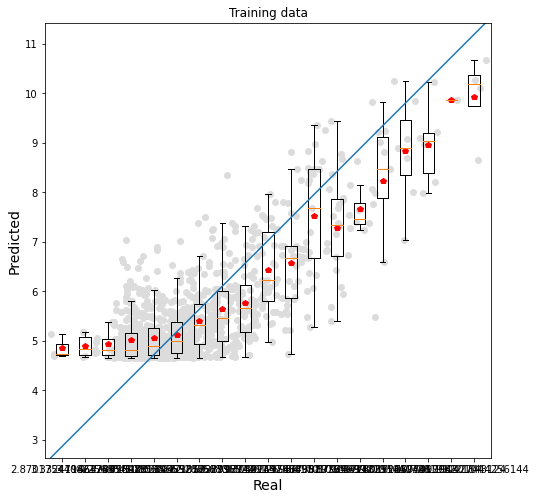

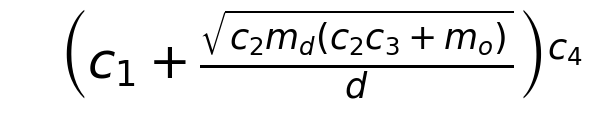

MCMC evolution


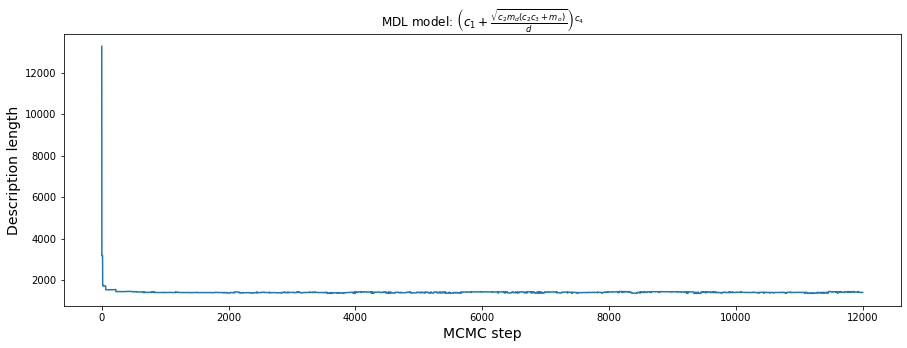

1353.15836575253 ((sqrt((((_a3_ + (_a2_ * m_o)) * _a2_) * (m_d + _a1_))) / ((d + _a4_) / _a2_)) + _a4_) {'d0': {'_a1_': 14152.401280902304, '_a2_': 0.02362929765829891, '_a3_': 1016.2692254154841, '_a4_': 4.36079815490886, '_a0_': 1.0, '_a5_': 1.0}}
1374.33866724653 (((((_a0_ * ((sqrt(m_o) / (d ** _a4_)) / _a1_)) * (m_d ** _a0_)) + (_a4_ ** ((_a3_ * d) * _a4_))) + (_a5_ + _a5_)) / _a3_) {'d0': {'_a0_': 0.708088144698317, '_a1_': 91094.3350473194, '_a3_': 0.37411074114955667, '_a4_': 0.8081395288074452, '_a5_': 0.8499951399592628, '_a2_': 1.0}}
1355.09108737940 ((sqrt((((_a3_ + (_a2_ * m_o)) / _a3_) * (m_d + _a5_))) / ((d + _a4_) * _a2_)) + _a0_) {'d0': {'_a0_': 4.42426858125607, '_a2_': 9.718949688045404, '_a3_': 369557.4726825297, '_a4_': 3.1696189935248023, '_a5_': 11322.599951252663, '_a1_': 1.0}}
1409.69689514018 ((((m_d * (((_a0_ ** 2) * (_a0_ / (((d + (_a2_ + _a5_)) / _a0_) * m_d))) + (m_d * (m_o / (_a1_ * _a0_))))) * ((_a3_ / (_a3_ + d)) ** _a4_)) ** _a2_) + (_a1_ + _a4_)) {'d0'

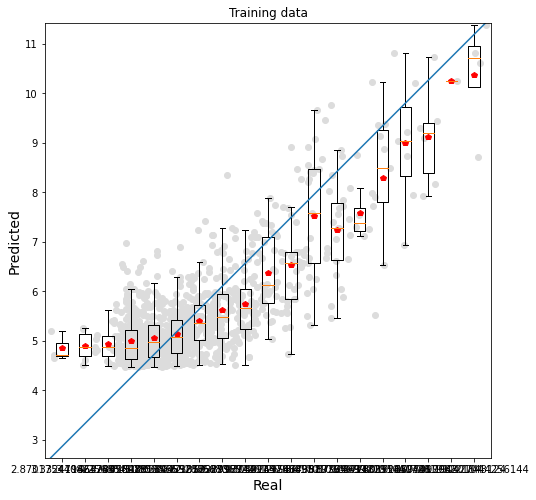

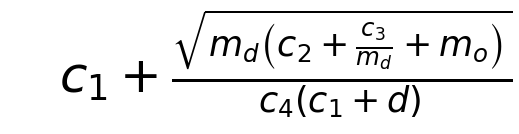

MCMC evolution


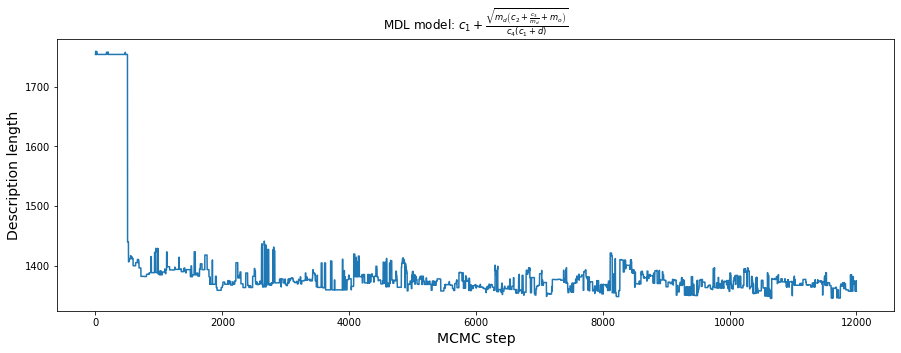

1342.93823435598 (((_a4_ + sqrt((m_d * (m_o + _a4_)))) / (_a5_ * (_a4_ * (_a1_ + d)))) + _a1_) {'d0': {'_a1_': 4.366182231976331, '_a4_': 20480.220530834227, '_a5_': 0.08761328232848647, '_a0_': 1.0, '_a2_': 1.0, '_a3_': 1.0}}
1369.91051422416 sqrt((((((((_a4_ + m_o) * (m_d / (m_o + _a0_))) + (_a3_ + sqrt(((_a3_ + m_o) * m_d)))) / d) + _a4_) / _a0_) * _a5_)) {'d0': {'_a0_': 111707.18094795819, '_a3_': 16365.11490948281, '_a4_': 5200.612499620266, '_a5_': 424.4512825580227, '_a1_': 1.0, '_a2_': 1.0}}
1389.17972370279 sqrt(((_a0_ + ((((((m_o * _a3_) + ((((exp(_a1_) + _a1_) ** 2) ** 2) + _a1_)) * (_a0_ ** 2)) * (_a2_ + (_a5_ + m_d))) ** _a1_) / d)) * _a5_)) {'d0': {'_a0_': 2.2168128636606492e-11, '_a1_': 0.6487816015532987, '_a2_': -887934481721.7247, '_a3_': 0.0010471694621317878, '_a5_': 887934493704.278, '_a4_': 1.0}}
1369.91051422416 sqrt((((((((_a4_ + m_o) * (m_d / (m_o + _a0_))) + (_a3_ + sqrt(((_a3_ + m_o) * m_d)))) / d) + _a4_) / _a0_) * _a5_)) {'d0': {'_a0_': 111707.18094795819, 

1374.48883985133 (sqrt(((((((m_d * (_a4_ / (_a4_ + (_a1_ / m_o)))) + (_a3_ + sqrt(((_a3_ + m_o) * m_d)))) / d) + _a4_) * _a5_) * _a5_)) * _a1_) {'d0': {'_a1_': 477274490.0055658, '_a3_': 17658.106003203564, '_a4_': 5331.303039877515, '_a5_': -1.2757252515894124e-10, '_a0_': 1.0, '_a2_': 1.0}}
1386.91479478173 ((((((_a5_ + (m_d + _a5_)) + _a1_) * (((((_a5_ * _a0_) * d) / (m_d * m_o)) ** cos(_a4_)) + _a0_)) / d) + (_a3_ / (_a5_ + _a5_))) ** _a0_) {'d0': {'_a0_': 0.19401903334117118, '_a1_': -3952679314.5228806, '_a3_': 9475422275215.188, '_a4_': 8.039730904017042e+93, '_a5_': 1976476150.781612, '_a2_': 1.0}}
1387.08622628763 ((((((_a5_ + (m_d + _a5_)) + _a1_) * (((((_a5_ * _a0_) * d) / (m_d * m_o)) ** sin(_a4_)) + _a0_)) / d) + (_a3_ / (_a5_ + _a5_))) ** _a0_) {'d0': {'_a0_': 0.1959000824116172, '_a1_': -4520066906.710856, '_a3_': 10065208578482.988, '_a4_': 8.039730765918263e+93, '_a5_': 2260170393.847821, '_a2_': 1.0}}
1369.22174187559 (((((((m_d / (d * d)) / _a5_) * _a5_) * (m_o + -(_

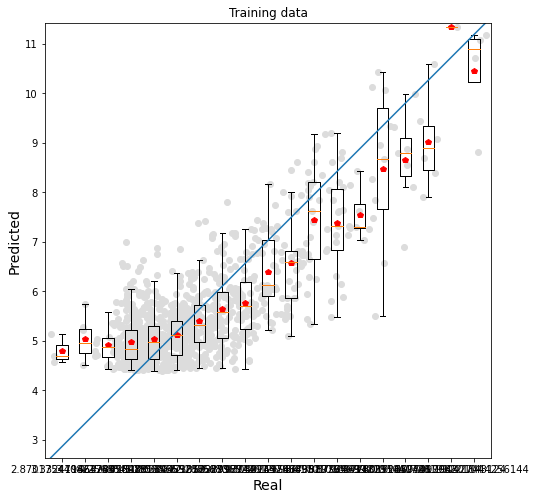

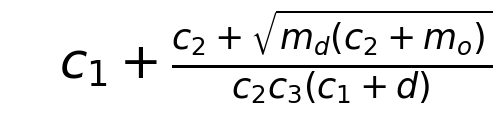

MCMC evolution


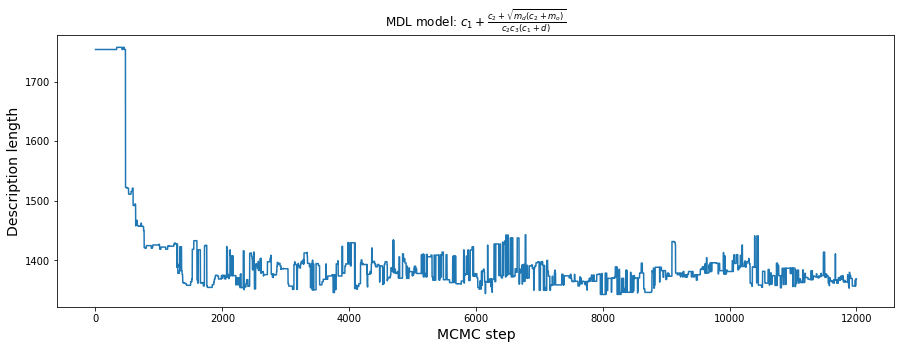

1399.74892326916 ((_a5_ / _a4_) * log((_a3_ + (((_a1_ + (((((m_o * (_a2_ + (sqrt(m_d) ** 2))) * _a4_) + _a4_) * m_o) + m_d)) / d) * ((d / (_a4_ * m_o)) ** _a2_))))) {'d0': {'_a1_': 22532.675244816382, '_a2_': -0.3624318436065454, '_a3_': 5.583644171144073, '_a4_': 2.9780091032076982e-12, '_a5_': 7.961120907179374e-12, '_a0_': 1.0}}
1381.00679370864 ((_a5_ * (((((_a2_ * _a0_) + sqrt(m_d)) * ((sqrt(sqrt((_a3_ + m_o))) ** 2) / (d + _a2_))) * (_a2_ / _a4_)) + _a2_)) * _a2_) {'d0': {'_a0_': 19.54447640693963, '_a2_': 3.196590569851305, '_a3_': 39363.17318661371, '_a4_': 9579.042750840192, '_a5_': 0.43338649720345307, '_a1_': 1.0}}
1379.43732535995 (((((((m_d + _a3_) * (_a4_ + m_o)) / d) / d) + _a0_) / ((_a5_ * _a2_) + (((_a4_ + -(_a0_)) ** 2) / _a0_))) ** _a5_) {'d0': {'_a0_': 2167908.631975243, '_a2_': -12877870.565965092, '_a3_': 3184.661242810004, '_a4_': 22206.92344843214, '_a5_': 0.16489771479922458, '_a1_': 1.0}}
1379.90792192836 ((((m_d ** _a1_) * (_a2_ + (((m_d * _a3_) + _a4_) * ((m

1387.20057281124 ((((((((_a4_ + m_d) ** _a1_) * (((_a0_ * _a3_) / (((_a0_ + (_a1_ * m_o)) ** 2) + (_a1_ * _a0_))) + _a1_)) / d) / d) + _a1_) * _a4_) ** log(_a1_)) {'d0': {'_a0_': 44718923.101915166, '_a1_': 1.1817947994850488, '_a3_': -52791285.13633473, '_a4_': 8582.031183977208, '_a2_': 1.0, '_a5_': 1.0}}
1389.05602966460 (((_a1_ + ((_a5_ / d) ** 2)) ** -(((_a0_ + ((((m_d + _a0_) / (m_o * m_o)) ** _a3_) * ((_a1_ * m_o) * _a2_))) * (_a4_ * _a2_)))) + _a0_) {'d0': {'_a0_': 2.9448009613166195, '_a1_': 6.963739254466904, '_a2_': 0.0004043067031930569, '_a3_': 0.37951379502139765, '_a4_': -113.11378069909874, '_a5_': -228.71241881214917}}
1383.27190087457 ((((((((_a4_ + m_d) ** _a1_) * (((_a0_ * _a3_) / (((_a0_ + (_a1_ + m_o)) ** 2) + _a0_)) + _a1_)) / d) / d) + _a1_) * _a4_) ** log(_a1_)) {'d0': {'_a0_': 37839933.20036627, '_a1_': 1.181794908657976, '_a3_': -44670552.95003582, '_a4_': 8581.99351168578, '_a2_': 1.0, '_a5_': 1.0}}
1388.28760546932 ((_a3_ * -((_a4_ + ((((_a0_ ** -(_a0_)) + 

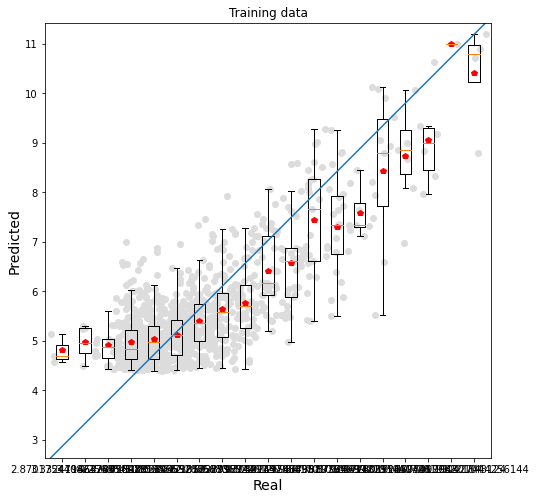

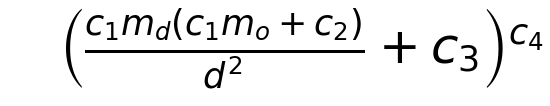

MCMC evolution


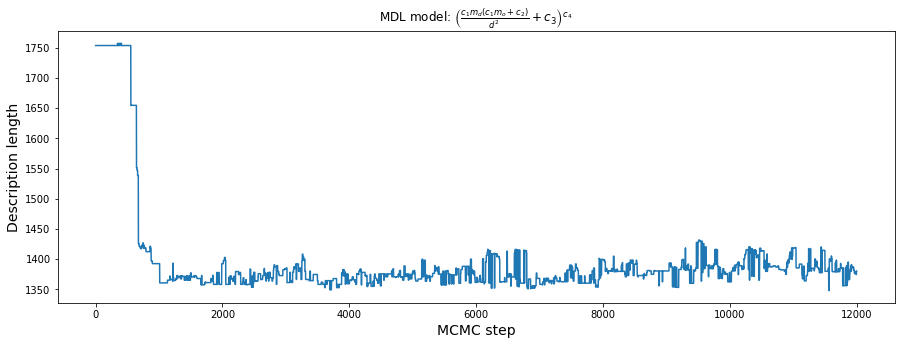

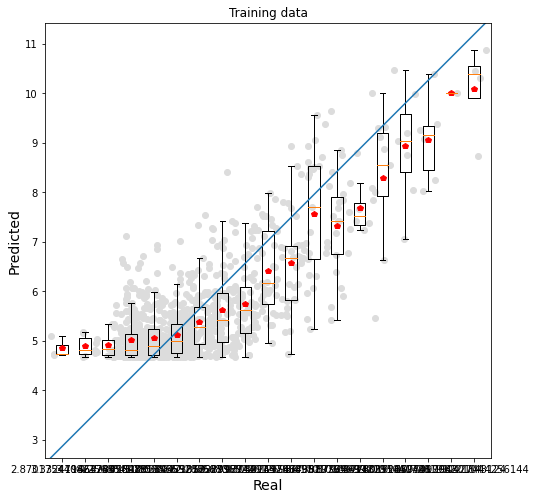

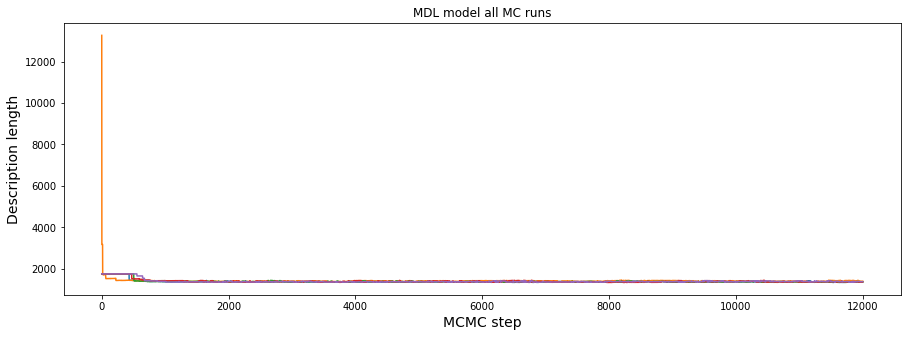

########################################
Lowest mdl for training data: 1341.03979341861
Model: ((((_a2_ + m_o) / (((d ** 2) * _a1_) / m_d)) + _a2_) ** _a4_)
1378.23683582743 ((((((m_o / d) * m_d) + _a1_) ** _a0_) * log(((_a3_ * d) + (_a1_ ** 3)))) + ((d ** _a0_) * _a5_)) {'d0': {'_a0_': 0.0190221606420443, '_a1_': 100962356.73417771, '_a3_': 4.165794876829216e+22, '_a5_': -70.2031632873943, '_a2_': 1.0, '_a4_': 1.0}}
1420.17858127761 (_a4_ + (((m_o / _a0_) + (_a0_ + (_a1_ * m_d))) / sqrt(((((_a4_ + d) * ((d / _a0_) * (_a0_ ** 2))) + m_d) / (_a2_ ** (sqrt(m_d) * ((_a2_ ** (((_a2_ ** 2) * m_o) + _a4_)) * _a0_))))))) {'d0': {'_a0_': 366.19107371991305, '_a1_': 0.02096306078746536, '_a2_': 0.9999842695501145, '_a4_': 3.8776585755179305, '_a3_': 1.0, '_a5_': 1.0}}
1391.49209477650 (((log((_a2_ * (((m_d * (m_o + sqrt(_a5_))) + _a4_) / _a1_))) * ((d / _a1_) ** _a3_)) + _a4_) / _a2_) {'d0': {'_a1_': 2.2767472479685384e+18, '_a2_': 1107726589.8390894, '_a3_': -0.5499885438415012, '_a4_': 394949

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1416.30877869464 log((fac(exp((log((((_a3_ + m_o) * (m_o ** (_a4_ * (m_d / (m_d + _a3_))))) / (_a4_ * d))) * (((_a2_ * _a2_) ** (((_a4_ ** 2) ** m_o) + _a4_)) / _a3_)))) + _a5_)) {'d0': {'_a2_': -210069086.54645747, '_a3_': 88932.03032564576, '_a4_': 0.24885327347920444, '_a5_': 43.34240675037491, '_a0_': 1.0, '_a1_': 1.0}}
1376.53719707436 log(((((_a1_ + ((((m_d * m_o) + _a5_) * (_a5_ * (m_o / m_o))) / d)) ** 2) + m_o) * _a0_)) {'d0': {'_a0_': 1.6022492045712263e-33, '_a1_': 1.6799231863604067e+17, '_a5_': 1709904678.3032174, '_a2_': 1.0, '_a3_': 1.0, '_a4_': 1.0}}
1371.85096955923 log(((((_a1_ + ((((m_d * m_o) + _a5_) * _a5_) / d)) ** 2) + (_a5_ / _a1_)) * _a0_)) {'d0': {'_a0_': 1.6022503623140124e-33, '_a1_': 1.6799220079037517e+17, '_a5_': 1709904762.7712953, '_a2_': 1.0, '_a3_': 1.0, '_a4_': 1.0}}
1413.10684086152 (((((_a5_ * ((_a0_ * m_d) * (_a2_ * (m_o + d)))) + (((d * _a0_) + _a1_) / ((_a1_ ** 2) ** 2))) ** ((((_a5_ / m_d) + _a2_) / d) ** _a5_)) / _a3_) * _a3_) {'d0': {'_a0_': 

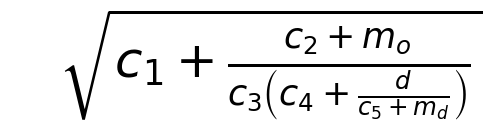

MCMC evolution


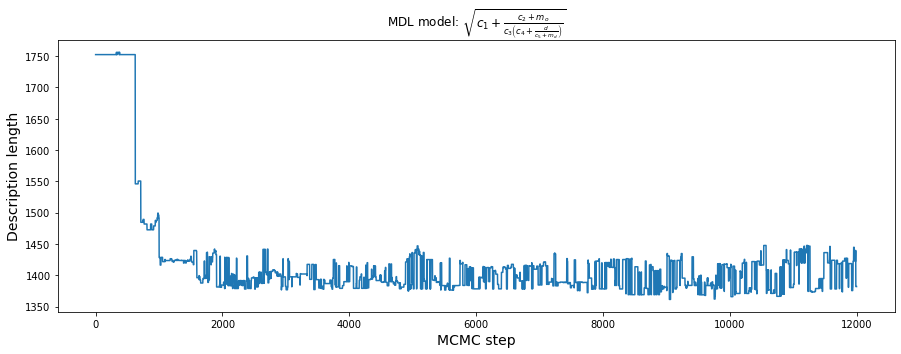

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1404.56874223155 (((((_a1_ + m_d) * ((-(((_a4_ + m_o) + _a5_)) / (((d + sqrt(m_d)) * ((_a2_ + (d ** 2)) * _a0_)) * d)) * _a1_)) + _a1_) + _a4_) ** _a3_) {'d0': {'_a0_': 11.285630876461314, '_a1_': 3831.234766717141, '_a2_': -629900.903885046, '_a3_': 0.28094016210234873, '_a4_': -3697.2163881145084, '_a5_': 43036.48500893204}}
1407.62319142409 -((sqrt(sqrt(((((((_a5_ + m_d) * _a4_) / ((d + _a2_) * ((_a5_ * d) * _a1_))) * (_a3_ * _a4_)) * (m_o + sqrt(_a1_))) + (_a5_ ** 2)))) / _a4_)) {'d0': {'_a1_': 1197138143.7897978, '_a2_': 120.15890977936367, '_a3_': 40493386141573.75, '_a4_': -45.623453536474294, '_a5_': 32750.429808864727, '_a0_': 1.0}}
1373.83307655461 ((_a1_ + ((_a2_ ** log((d + -(_a5_)))) * (((((m_o / _a2_) * _a2_) / _a1_) * m_d) + _a3_))) ** _a2_) {'d0': {'_a1_': 1389.3675539738945, '_a2_': 0.1929158691460685, '_a3_': 448703.7922321316, '_a5_': -2.6344875942316412, '_a0_': 1.0, '_a4_': 1.0}}
1378.16388208533 log(((((((m_d * ((_a2_ / m_d) + (_a1_ * m_o))) * _a5_) / d) / (_a4_ *

1378.53626348115 sqrt(sqrt((((((((_a5_ / m_o) + m_d) / _a3_) / ((d + tan(_a3_)) * d)) ** _a2_) * m_o) + _a1_))) {'d0': {'_a1_': 257.3108462027546, '_a2_': 0.9519823918489052, '_a3_': 1710.584380272085, '_a5_': 1081088313.5908766, '_a0_': 1.0, '_a4_': 1.0}}
1369.23315248117 sqrt(sqrt((((((((_a5_ / m_o) + m_d) / _a3_) / ((d + _a2_) * d)) * _a2_) * m_o) + _a1_))) {'d0': {'_a1_': 258.50610069469633, '_a2_': 111.71457632918188, '_a3_': 120027.34045108002, '_a5_': 1052112349.3193591, '_a0_': 1.0, '_a4_': 1.0}}
1403.46987915426 log((((((((_a4_ * m_d) * (((_a3_ * -(_a1_)) / m_o) + ((_a1_ ** 2) + m_o))) + _a0_) / d) ** ((_a2_ + (_a4_ + _a0_)) + (d * _a3_))) * _a4_) + _a1_)) {'d0': {'_a0_': 81122.20531131806, '_a1_': 63.167177610905696, '_a2_': -81120.51911006974, '_a3_': -0.0005114689084188996, '_a4_': 6.355015811608828e-05, '_a5_': 1.0}}
1408.44753275890 (log(((((m_o / ((d + _a2_) / _a1_)) * (_a1_ * m_d)) * (_a4_ ** (d * _a5_))) + _a2_)) * (((_a5_ / ((_a4_ + d) * -((_a2_ * _a1_)))) * _a2_) * (

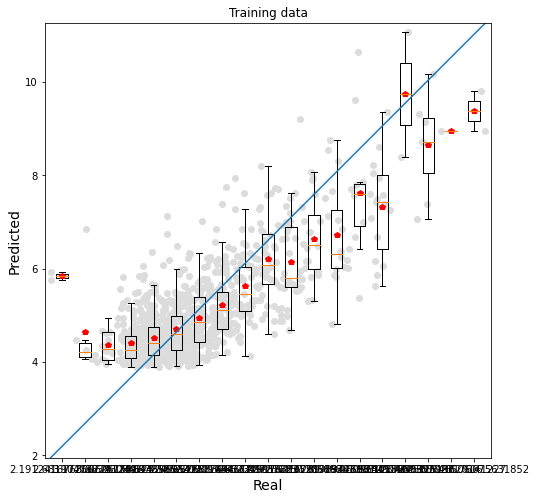

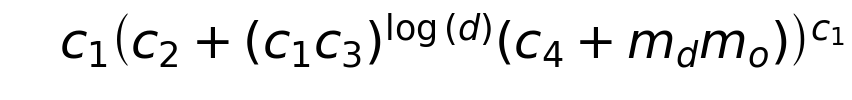

MCMC evolution


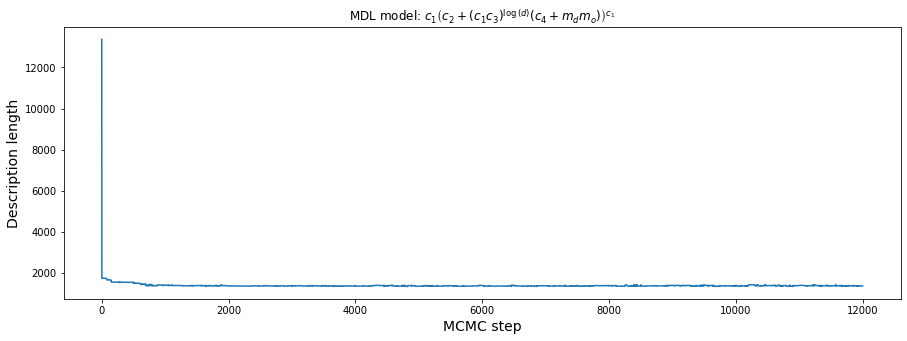

1402.33817910977 (((((-((_a2_ ** 2)) * ((_a3_ + (_a4_ + d)) / (_a3_ * _a1_))) + -((m_d * m_o))) / _a2_) ** 2) ** ((_a1_ + (d * _a1_)) ** log(_a3_))) {'d0': {'_a1_': 126242.6321772742, '_a2_': -1620188.8784832566, '_a3_': 0.864502886652148, '_a4_': 51.72953982164397, '_a0_': 1.0, '_a5_': 1.0}}
1375.45197113608 (((((_a2_ + ((_a2_ + (m_o * (m_d + _a3_))) * (_a3_ / d))) ** _a1_) ** 2) + _a4_) + _a3_) {'d0': {'_a1_': 0.06318423191201453, '_a2_': 1786387879.7952344, '_a3_': 16.384907485495145, '_a4_': -27.269981440616224, '_a0_': 1.0, '_a5_': 1.0}}
1360.13528904286 log(((_a1_ + ((((_a1_ + (m_o * m_d)) * _a0_) / d) ** 2)) + _a3_)) {'d0': {'_a0_': -9.07113228087247e-08, '_a1_': 1809017679.90937, '_a3_': -1809017612.213021, '_a2_': 1.0, '_a4_': 1.0, '_a5_': 1.0}}
1360.13528904286 log(((_a1_ + ((((_a1_ + (m_o * m_d)) * _a0_) / d) ** 2)) + _a3_)) {'d0': {'_a0_': -9.07113228087247e-08, '_a1_': 1809017679.90937, '_a3_': -1809017612.213021, '_a2_': 1.0, '_a4_': 1.0, '_a5_': 1.0}}
1373.53880785431 ((

1401.94694292215 (((exp(((log((((_a2_ + m_d) / ((m_d ** _a3_) * d)) ** _a0_)) * (_a4_ * ((_a1_ * ((_a1_ * _a3_) + m_o)) ** _a3_))) + _a4_)) + _a3_) * _a1_) ** _a3_) {'d0': {'_a0_': -0.00671441931171603, '_a1_': 280652.85402629786, '_a2_': 24454.221943896704, '_a3_': 0.1328262548574449, '_a4_': -11.907916345623718, '_a5_': 1.0}}
1401.94694292215 (((exp(((log((((_a2_ + m_d) / ((m_d ** _a3_) * d)) ** _a0_)) * (_a4_ * ((_a1_ * ((_a1_ * _a3_) + m_o)) ** _a3_))) + _a4_)) + _a3_) * _a1_) ** _a3_) {'d0': {'_a0_': -0.00671441931171603, '_a1_': 280652.85402629786, '_a2_': 24454.221943896704, '_a3_': 0.1328262548574449, '_a4_': -11.907916345623718, '_a5_': 1.0}}
1403.82536201973 (((((exp((((_a5_ / m_o) + _a3_) ** _a4_)) * (((_a3_ ** 2) * d) ** _a4_)) ** _a1_) * ((d + m_d) + (_a0_ / m_d))) + (_a2_ / _a0_)) ** _a3_) {'d0': {'_a0_': 20175458.726812582, '_a1_': 4.157294063106402, '_a2_': 1803756225111.8086, '_a3_': 0.12246370588703512, '_a4_': -0.4802316062266143, '_a5_': 302302.72684608}}
1407.31160

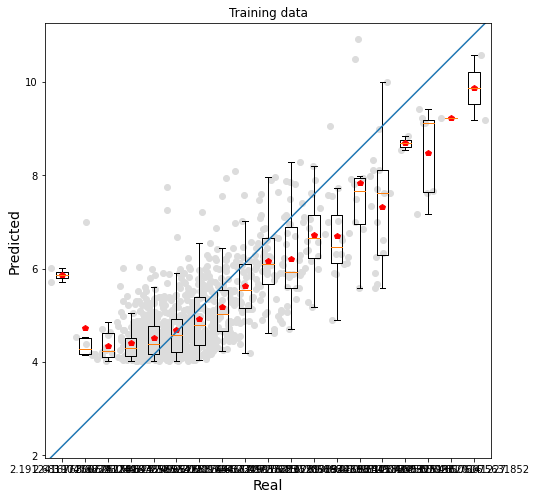

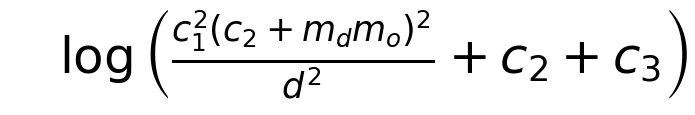

MCMC evolution


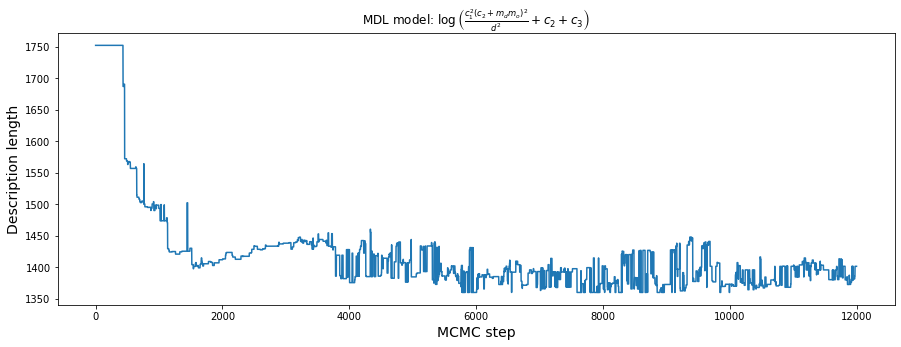

1414.14751021102 ((sin((((_a4_ / (_a1_ * d)) + (((d + (_a0_ / m_d)) + (m_d * _a3_)) / ((d * (_a0_ / m_o)) * (d + _a1_)))) ** cos((-(_a2_) ** 2)))) * _a5_) + ((_a2_ + _a2_) ** 2)) {'d0': {'_a0_': 2.669732914174691e+94, '_a1_': 64.11435707537818, '_a2_': -0.967324956009538, '_a3_': 3.062743507662987e+87, '_a4_': 81.88407745423116, '_a5_': 6.211217700878037}}
1394.77611819830 (((((_a2_ * (_a3_ ** 2)) * d) ** _a5_) * ((((d + (_a3_ ** 2)) * d) * ((_a0_ ** 2) * _a4_)) + (_a0_ + (m_o * (m_d * _a2_))))) ** _a2_) {'d0': {'_a0_': 72082545.5379504, '_a2_': 0.18482832908064947, '_a3_': -16.86722542300051, '_a4_': 3.201505489161015e-12, '_a5_': -1.4814500403641222, '_a1_': 1.0}}
1414.19943279468 ((sin(((((_a5_ ** 2) / (_a1_ * d)) + (((d + (_a0_ / m_d)) + (m_d * _a3_)) / ((d * (_a0_ / m_o)) * (d + _a4_)))) ** cos((_a4_ ** 2)))) * _a5_) + ((_a2_ + _a2_) ** 2)) {'d0': {'_a0_': 7.46249754524953e+106, '_a1_': 29.324103508593087, '_a2_': -0.9678232925856739, '_a3_': 9.377663240801412e+99, '_a4_': 72.5688

1438.28398402632 sqrt(((sqrt(((exp((_a2_ * ((_a3_ + _a1_) * (_a1_ * _a2_)))) ** ((((d * _a5_) + (m_o * _a1_)) ** _a2_) + (_a2_ * (_a4_ / m_o)))) * ((_a2_ / _a5_) + (m_d * m_o)))) + _a4_) + ((_a2_ / d) * _a1_))) {'d0': {'_a1_': -1.5371385759543125e-15, '_a2_': 0.08746717889364446, '_a3_': 7.517326488542135e+18, '_a4_': 13.405956131155818, '_a5_': 1.1328960131981182e-10, '_a0_': 1.0}}
1385.26966292785 (log(((((_a4_ ** 2) + (((_a2_ + d) / _a3_) * _a5_)) + ((m_o * _a1_) * (m_d * (_a1_ / log(d))))) / d)) / _a4_) {'d0': {'_a1_': -0.0006374749017429906, '_a2_': 17.424308884572348, '_a3_': -3.4154092451914667e-131, '_a4_': 0.5651684745882852, '_a5_': -3.0733337168821346e-130, '_a0_': 1.0}}
1400.62694475697 ((log(((((_a4_ ** 2) + (((_a2_ * d) / _a3_) * (sin(_a2_) * _a0_))) + ((m_o * _a1_) * (m_d * (_a1_ / log(d))))) / d)) / _a4_) * _a2_) {'d0': {'_a0_': -3.671709095929311e-119, '_a1_': -0.0006374523827227913, '_a2_': 22.177830185573733, '_a3_': 1.6796520190008617e-119, '_a4_': 12.53402334477939

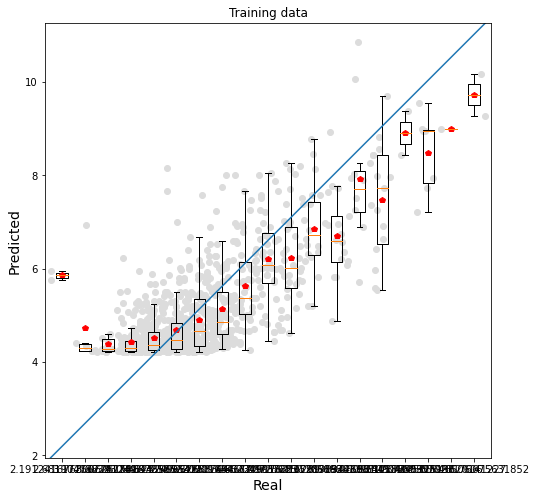

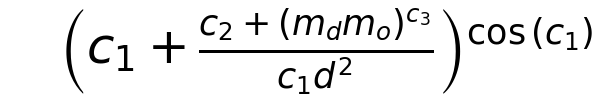

MCMC evolution


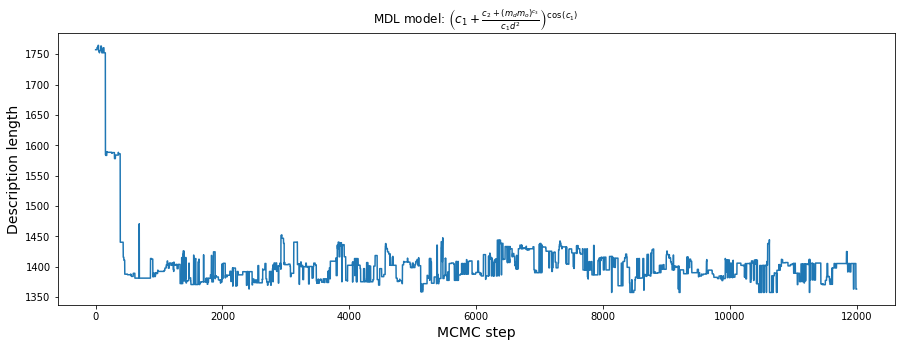

1414.33415197709 (((((d ** _a2_) * (((m_d ** 2) + ((((-(-(m_o)) + _a0_) + m_d) + (_a1_ + (m_o * ((((m_d * _a5_) + d) * _a2_) / _a3_)))) ** 2)) / _a4_)) * _a4_) + _a4_) ** _a0_) {'d0': {'_a0_': 0.09811543150636506, '_a1_': 102695.16525661433, '_a2_': -2.5241637645879846, '_a3_': -1.598611621323415e+187, '_a4_': 1898613.0276883503, '_a5_': 7.235875251079619e+182}}
1368.16737966680 ((((m_d + (m_o * m_d)) + (d * _a5_)) ** cos(((d ** (_a3_ + _a3_)) + _a4_))) / d) {'d0': {'_a3_': -0.01720994220619157, '_a4_': 0.4489939087982003, '_a5_': 78110604.79081169, '_a0_': 1.0, '_a1_': 1.0, '_a2_': 1.0}}
1376.31083954655 log(((((d / _a0_) ** _a3_) * (((m_d + _a1_) / (_a2_ / m_o)) + (_a3_ ** 2))) + _a0_)) {'d0': {'_a0_': 66.83213546069565, '_a1_': 2983.8302248727523, '_a2_': 47533797.44604092, '_a3_': -1.8757679877434053, '_a4_': 1.0, '_a5_': 1.0}}
1376.44630143221 ((_a1_ + (((((m_o ** 2) + _a4_) / _a3_) + (m_o * m_d)) * (_a5_ / (_a5_ * (d ** 2))))) ** _a5_) {'d0': {'_a1_': 150534.88863940747, '_a3_': 

1377.63002281538 (((((cos(d) / m_d) + (m_o * m_d)) + (d * _a5_)) ** cos((((d ** 2) ** _a3_) + _a1_))) / d) {'d0': {'_a1_': 0.4489936410581557, '_a3_': -0.01720991812632744, '_a5_': 78110505.79670838, '_a0_': 1.0, '_a2_': 1.0, '_a4_': 1.0}}
1366.24130279561 (((((_a3_ ** 2) + (m_o * m_d)) + (d * _a2_)) ** cos(((d ** _a3_) + _a1_))) / d) {'d0': {'_a1_': 0.4489936406668948, '_a2_': 78110498.68663296, '_a3_': -0.034419836345530544, '_a0_': 1.0, '_a4_': 1.0, '_a5_': 1.0}}
1362.65467201547 ((((_a3_ + (m_o * m_d)) + (d * _a4_)) ** cos(((d ** _a3_) + _a1_))) / d) {'d0': {'_a1_': 0.44899364085799137, '_a3_': -0.03441983591547144, '_a4_': 78110514.85463205, '_a0_': 1.0, '_a2_': 1.0, '_a5_': 1.0}}
1362.65029390746 ((((_a3_ + (m_o * m_d)) + (d * _a2_)) ** cos(((d ** _a3_) / _a1_))) / d) {'d0': {'_a1_': 0.6911755700424193, '_a2_': 78810122.90291724, '_a3_': -0.02280145801406162, '_a0_': 1.0, '_a4_': 1.0, '_a5_': 1.0}}
1402.97891125807 (((((d ** _a2_) * ((_a1_ * ((_a1_ + (_a3_ + (m_o * ((((m_d * (_a1

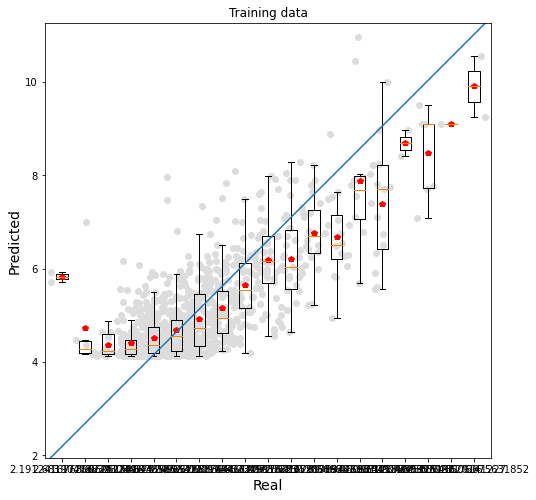

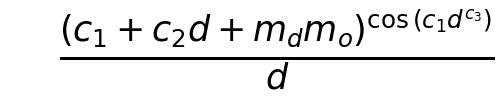

MCMC evolution


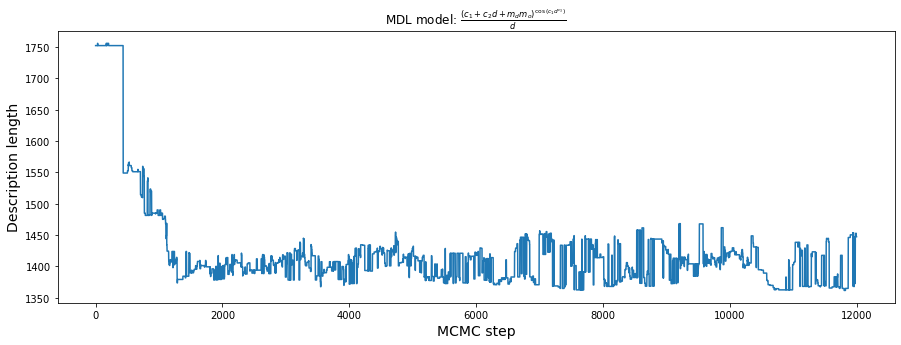

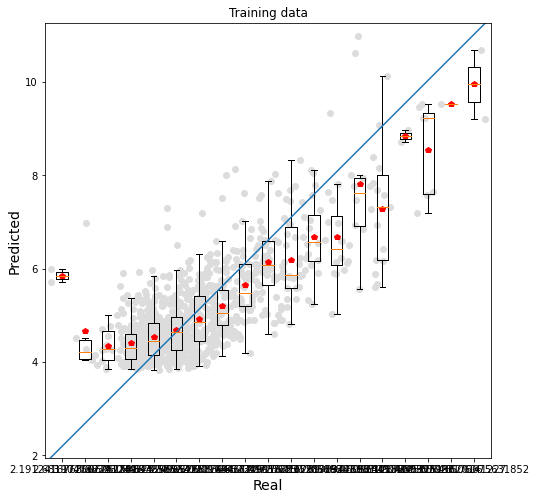

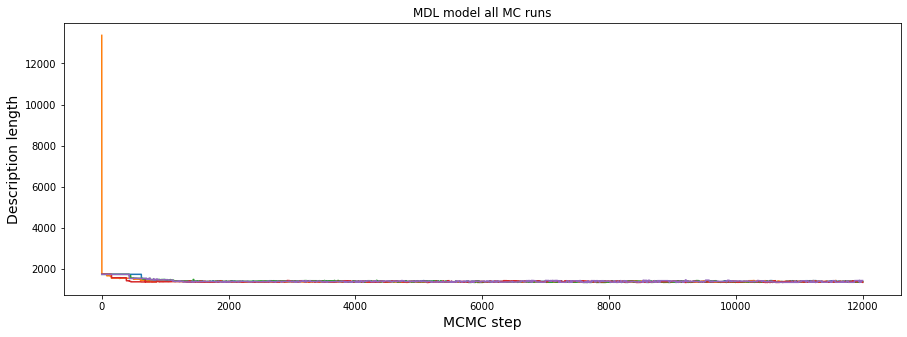

########################################
Lowest mdl for training data: 1357.73342903742
Model: ((((_a5_ + ((m_d * m_o) ** _a4_)) / ((d ** 2) * _a2_)) + _a2_) ** cos(_a2_))
1570.56441393974 (((((_a0_ * ((_a5_ * (log(d) / (_a2_ + _a1_))) ** _a1_)) * (((_a5_ * _a0_) * ((m_d ** 2) * _a5_)) * m_o)) ** _a0_) / d) + _a4_) {'d0': {'_a0_': 0.14086132413522273, '_a1_': 7.6046601848834365, '_a2_': -1.4781258683952746e+36, '_a4_': 4.2855508053759, '_a5_': -1.5972095773620473e+28, '_a3_': 1.0}}
1538.44481815069 (((((_a5_ + m_o) * (m_d / ((d ** 2) * _a3_))) ** 2) ** _a2_) + (_a1_ ** 2)) {'d0': {'_a1_': 1.9794937255556586, '_a2_': 0.12075143735574058, '_a3_': 179433.57949749214, '_a5_': 22984.54128214745, '_a0_': 1.0, '_a4_': 1.0}}
1586.71957320251 ((((_a5_ * (((_a3_ + _a4_) + m_o) * (_a4_ * _a4_))) * (log((((((_a0_ * m_d) + _a4_) ** 2) * -(_a4_)) * -(_a1_))) / (d + _a5_))) * log((_a0_ * d))) + _a3_) {'d0': {'_a0_': 0.8114720111083067, '_a1_': 4.717407404578144e-16, '_a3_': 4.265424339752845, '_a4_':

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1546.57742065084 ((((((_a1_ + (m_o * _a5_)) * ((m_d + _a1_) / ((d * _a2_) + _a2_))) ** 2) ** _a5_) + _a3_) / _a1_) {'d0': {'_a1_': 23752.972893705693, '_a2_': -0.07743291384280775, '_a3_': 93400.84689612163, '_a5_': 0.25830305114404756, '_a0_': 1.0, '_a4_': 1.0}}
1564.87917162638 (((((_a0_ * ((_a5_ * (d / _a2_)) ** _a1_)) * ((m_d + (((m_d * _a1_) ** 2) * _a0_)) * m_o)) ** _a0_) / d) + _a1_) {'d0': {'_a0_': 0.12373286195226921, '_a1_': 4.018250189179671, '_a2_': -1.5378623141029086e+36, '_a5_': -9.010058058529031e+34, '_a3_': 1.0, '_a4_': 1.0}}
1542.20336806139 (((((((_a5_ / _a2_) + m_o) + (_a0_ * _a2_)) / ((d * _a2_) * d)) * m_d) + _a5_) ** _a2_) {'d0': {'_a0_': -263299461.61701372, '_a2_': 0.10297190081597865, '_a5_': 2794162.672971845, '_a1_': 1.0, '_a3_': 1.0, '_a4_': 1.0}}
1566.51682052888 ((_a4_ * _a1_) * (((((_a5_ * (_a1_ + (_a5_ * (m_d * (d * _a0_))))) + _a1_) + _a4_) * _a1_) ** ((_a1_ * (m_o + _a2_)) / (_a0_ + d)))) {'d0': {'_a0_': 6.627605198222497, '_a1_': 1.1778092453701468e

1553.80837340480 (((((_a3_ / _a0_) * (((_a4_ * _a2_) ** 2) + m_o)) * ((((d + _a0_) ** 2) / ((m_d + _a4_) * _a0_)) ** _a2_)) ** 2) + _a0_) {'d0': {'_a0_': 4.121252431380902, '_a2_': -0.1714906691531639, '_a3_': 4.568465256756668e-06, '_a4_': 3899.733671331639, '_a1_': 1.0, '_a5_': 1.0}}
1557.72978899157 (((((_a4_ + m_d) * _a5_) * ((_a4_ + (_a1_ + m_o)) / (d + _a3_))) + ((_a2_ ** 2) * _a5_)) * (_a2_ ** 3)) {'d0': {'_a1_': 81740.24008181767, '_a2_': 43212.744934871735, '_a3_': 9.939928282486637, '_a4_': 71820.44526183807, '_a5_': 2.8990429659589167e-23, '_a0_': 1.0}}

Parallel Tempering rate:84.708%
Parallel Tempering 12 proposed:647
Parallel Tempering 12 rate:86.244%
Run 1
Mdl for training data: 1523.52892093166
Model


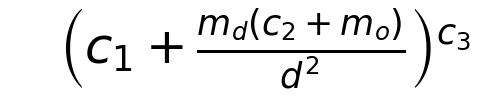

MCMC evolution


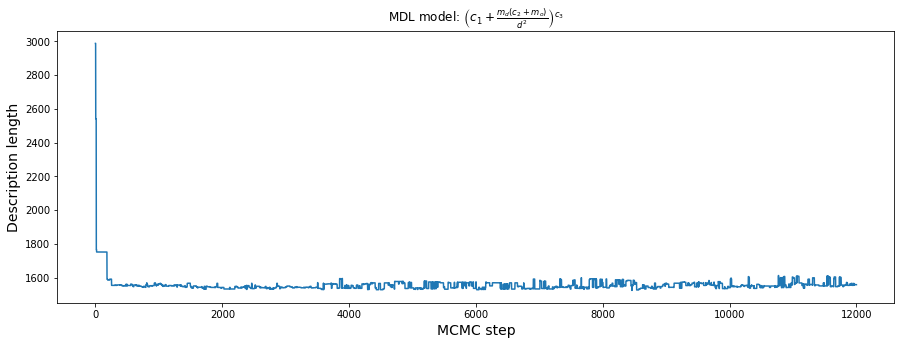

1555.80424765066 ((log(((_a2_ + (((((m_d + _a3_) * _a2_) * (m_o + _a1_)) * _a0_) / d)) * (sin(((_a3_ + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.807511622975188e-09, '_a1_': 67552.14949613342, '_a2_': 0.999982103561453, '_a3_': 19928.996302835843, '_a4_': 1.8047178724665307, '_a5_': 7.176882243248178}}
1555.80424765066 ((log(((_a2_ + (((((m_d + _a3_) * _a2_) * (m_o + _a1_)) * _a0_) / d)) * (sin(((_a3_ + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.807511622975188e-09, '_a1_': 67552.14949613342, '_a2_': 0.999982103561453, '_a3_': 19928.996302835843, '_a4_': 1.8047178724665307, '_a5_': 7.176882243248178}}
1555.80424765066 ((log(((_a2_ + (((((m_d + _a3_) * _a2_) * (m_o + _a1_)) * _a0_) / d)) * (sin(((_a3_ + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.807511622975188e-09, '_a1_': 67552.14949613342, '_a2_': 0.999982103561453, '_a3_': 19928.996302835843, '_a4_': 1.80471787246

1557.79749801847 ((log(((_a2_ + (((((m_d + _a3_) + _a2_) * (m_o + _a1_)) * _a0_) / d)) * (sin((((_a0_ * _a1_) + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.6745480123523593e-09, '_a1_': 67554.84417639853, '_a2_': 1.0000341290748458, '_a3_': 19062.53044093377, '_a4_': 1.8045519145891065, '_a5_': 7.290118734908785}}
1557.79758890837 ((log(((_a2_ + (((((m_d + _a3_) + _a0_) * (m_o + _a1_)) * _a0_) / d)) * (sin((((_a0_ * _a1_) + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.6745480123523593e-09, '_a1_': 67554.84417639853, '_a2_': 1.0000341290748458, '_a3_': 19062.53044093377, '_a4_': 1.8045519145891065, '_a5_': 7.290118734908785}}
1563.45311251380 ((log(((_a2_ + (((((m_d + _a3_) + (_a2_ / m_o)) * (m_o + _a1_)) * _a0_) / d)) * (sin((((_a3_ * _a1_) + (_a2_ * m_d)) * (_a4_ * _a1_))) + _a5_))) / (_a4_ ** 2)) * _a5_) {'d0': {'_a0_': 3.6745480123523593e-09, '_a1_': 67554.84417639853, '_a2_': 1.0000341290748458, '_a3_': 19

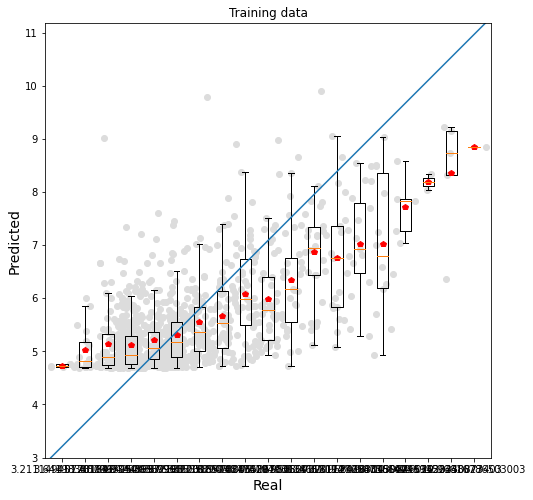

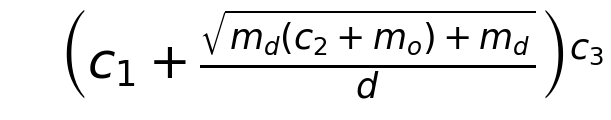

MCMC evolution


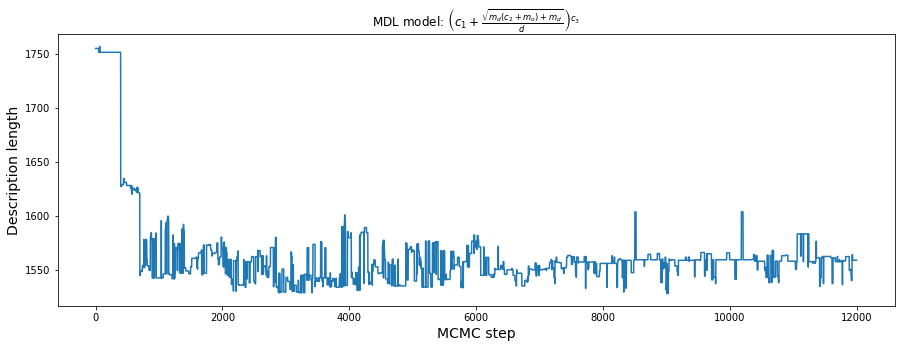

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1549.38695217089 log((_a0_ + (((((((_a2_ ** 2) + m_o) * (_a3_ ** 2)) * m_d) / d) + _a0_) / (d / (d + _a1_))))) {'d0': {'_a0_': 40.47856368492651, '_a1_': 34.325629139509836, '_a2_': 162.9436968347031, '_a3_': 0.0010271543275638777, '_a4_': 1.0, '_a5_': 1.0}}
1542.76209132869 log((((((d * _a1_) * _a1_) ** _a0_) * ((m_d + _a4_) * (m_o + _a5_))) + (_a1_ / _a3_))) {'d0': {'_a0_': -1.5535463836258365, '_a1_': 36.762387505807155, '_a3_': 0.38368064912214794, '_a4_': 5179.501414315867, '_a5_': 37136.895957978806, '_a2_': 1.0}}
1547.17111373118 log((((((d * _a5_) * exp(_a1_)) ** _a0_) * ((m_d + _a4_) * (m_o + _a5_))) + (_a1_ * _a3_))) {'d0': {'_a0_': -1.553548892117243, '_a1_': -3.313431716025661, '_a3_': -28.91723880125052, '_a4_': 5179.471282256274, '_a5_': 37136.89797388252, '_a2_': 1.0}}
1540.74558234563 ((((m_d * (m_d ** _a4_)) * log((d ** (_a1_ / d)))) * ((d + m_o) + _a0_)) + _a5_) {'d0': {'_a0_': 171147.76533422267, '_a1_': 2.2802716725489914e-06, '_a4_': -0.690914865583763, '_a5_': 4.3

1543.61041059239 log(((((d / _a2_) ** _a1_) * (((m_d / _a2_) + (_a4_ * _a0_)) * (m_o + _a4_))) + _a3_)) {'d0': {'_a0_': 85325879.10485557, '_a1_': -1.5535525859671937, '_a2_': 1.6345408616355757e-09, '_a3_': 95.81566196641056, '_a4_': 37136.8703940178, '_a5_': 1.0}}
1559.35203541481 (((((m_d * ((_a4_ / m_d) ** _a5_)) * log((d ** (_a5_ / ((_a5_ + d) / _a5_))))) * (m_o + _a3_)) + _a3_) * (_a0_ ** 2)) {'d0': {'_a0_': 0.004910158368934532, '_a3_': 175900.66702248564, '_a4_': 0.13636255500758732, '_a5_': 0.7069542537236213, '_a1_': 1.0, '_a2_': 1.0}}
1556.63486913229 log((_a0_ + ((_a5_ * _a3_) + (((((m_d + d) + d) / d) / d) * (_a5_ * ((_a0_ ** 2) + m_o)))))) {'d0': {'_a0_': 167.79338275055343, '_a3_': -771520.0170043546, '_a5_': 6.083835456790351e-05, '_a1_': 1.0, '_a2_': 1.0, '_a4_': 1.0}}
1541.42273739928 ((((((_a0_ * (d * (d / m_d))) * _a4_) / (m_o + _a4_)) ** 2) ** _a5_) + _a3_) {'d0': {'_a0_': 7.80500716721929, '_a3_': 3.9183402478921043, '_a4_': 22984.408888010672, '_a5_': -0.12074767

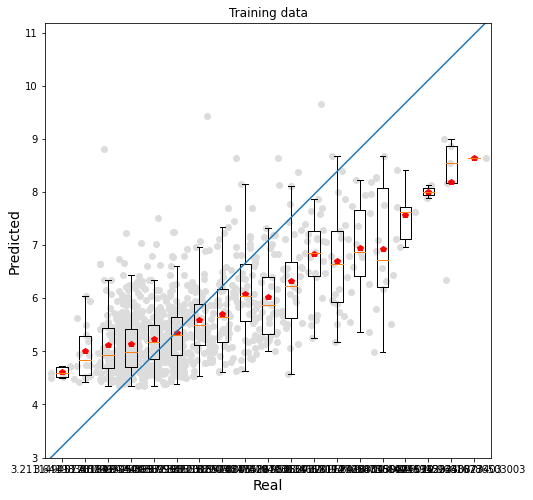

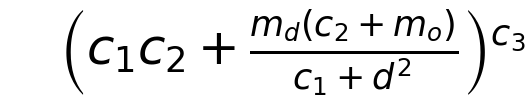

MCMC evolution


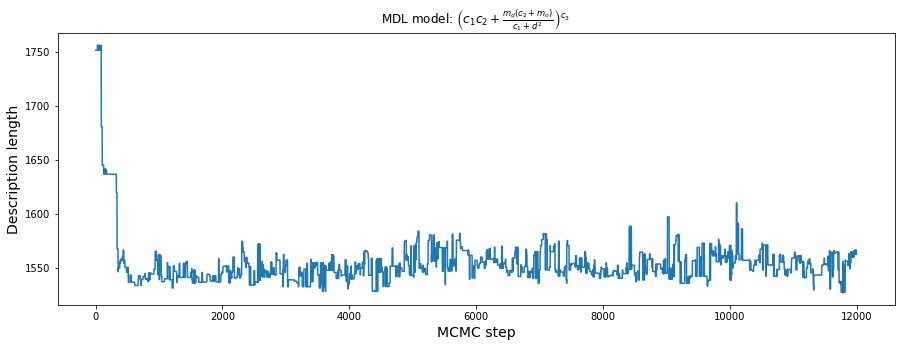

1590.53533925303 log((-(((m_d * -((((exp(_a1_) + ((_a4_ + _a4_) * (d * _a5_))) / (_a4_ + (_a0_ / -(m_d)))) + m_o))) * ((_a3_ + _a3_) ** (d * (_a5_ ** log(d)))))) + (_a4_ ** 2))) {'d0': {'_a0_': 18188.953418601544, '_a1_': 12.559640448146562, '_a3_': 6.6893546743736605e-06, '_a4_': 10.328164145468847, '_a5_': 0.41034093020738416, '_a2_': 1.0}}
1572.28182127990 ((((d + _a1_) ** _a0_) * (((_a5_ * (d + _a0_)) * ((m_o + _a4_) * _a3_)) * ((_a5_ + (d + m_d)) ** _a2_))) + ((_a2_ * -(_a3_)) ** 2)) {'d0': {'_a0_': -1.7480886171341705, '_a1_': -0.14960667056660526, '_a2_': 0.2961074069428186, '_a3_': 6.977932360376615, '_a4_': 173058.63603144296, '_a5_': 5.876160334620959e-07}}
1592.95106163468 log((-(((m_d * -((((exp(_a1_) + ((_a3_ ** 2) * (_a0_ + _a3_))) / (_a4_ + (_a0_ / -(m_d)))) + m_o))) * ((_a3_ + (_a3_ ** 2)) ** (d * (_a5_ ** log(d)))))) + (_a4_ ** 2))) {'d0': {'_a0_': 18189.59373730323, '_a1_': 12.560113485934696, '_a3_': 1.3371134738242615e-05, '_a4_': 10.328503103335892, '_a5_': 0.41033

1532.09226398315 ((((((_a2_ + m_o) + d) * sqrt(m_d)) / (_a5_ * d)) + _a5_) ** _a0_) {'d0': {'_a0_': 0.23234811168374983, '_a2_': 77859.07806331088, '_a5_': 542.3205968266813, '_a1_': 1.0, '_a3_': 1.0, '_a4_': 1.0}}
1569.24064260221 (fac(((((_a2_ * ((-(sqrt(d)) + (_a1_ * _a2_)) * _a4_)) ** 2) + ((_a0_ * m_o) + sqrt((_a0_ * m_d)))) + (_a4_ * _a0_))) * _a4_) {'d0': {'_a0_': 2.397576868860768e-06, '_a1_': 1352.5311359715777, '_a2_': 0.013580617698133679, '_a4_': 5.134359766219907, '_a3_': 1.0, '_a5_': 1.0}}
1537.62274508336 (((((_a4_ + ((d / _a4_) + m_o)) * sqrt(m_d)) / (_a5_ * d)) + _a5_) ** _a0_) {'d0': {'_a0_': 0.23235751892574213, '_a4_': 77853.28143324304, '_a5_': 542.445925914024, '_a1_': 1.0, '_a2_': 1.0, '_a3_': 1.0}}
1542.23940036354 (((((_a4_ + ((m_d / (m_d * d)) + m_o)) * sqrt(m_d)) / (_a5_ * d)) + _a5_) ** _a0_) {'d0': {'_a0_': 0.2323575015327427, '_a4_': 77853.30556338864, '_a5_': 542.4460911759394, '_a1_': 1.0, '_a2_': 1.0, '_a3_': 1.0}}
1577.41745668982 log((-(((m_d * -(((((

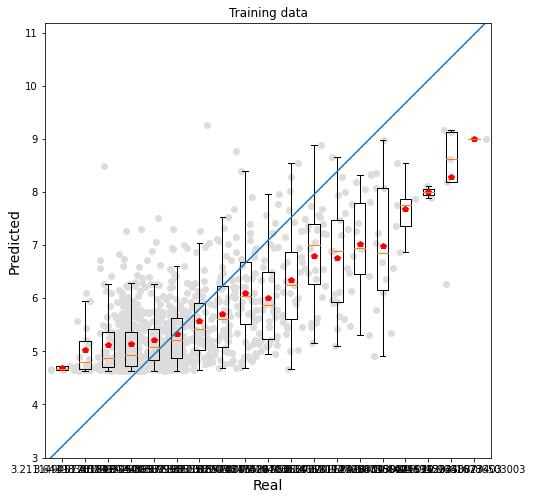

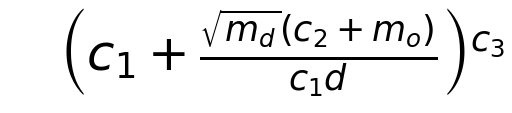

MCMC evolution


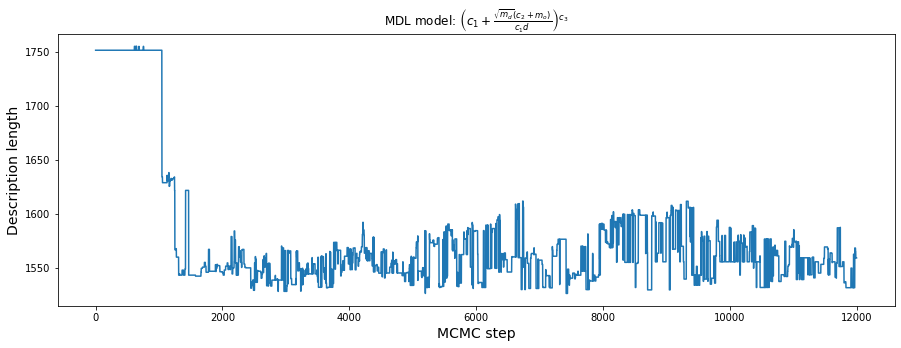

1566.64523103611 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a1_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a3_ * _a0_) / _a2_) / _a2_)) ** sqrt(_a2_)) {'d0': {'_a0_': 219640203616.23343, '_a1_': 6784.829736574179, '_a2_': 78646.84300594855, '_a3_': 0.0002205825212272449, '_a4_': 0.9975419274910384, '_a5_': 0.048793096329174966}}
1566.64523103611 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a1_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a3_ * _a0_) / _a2_) / _a2_)) ** sqrt(_a2_)) {'d0': {'_a0_': 219640203616.23343, '_a1_': 6784.829736574179, '_a2_': 78646.84300594855, '_a3_': 0.0002205825212272449, '_a4_': 0.9975419274910384, '_a5_': 0.048793096329174966}}
1566.64523103611 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a1_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a3_ * _a0_) / _a2_) / _a2_)) ** sqrt(_a2_)) {'d0': {'_a0_': 219640203

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1569.22258309756 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a2_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a0_ + m_d) / _a2_) / (_a2_ + _a2_))) ** sqrt(_a2_)) {'d0': {'_a0_': 96324522.93086722, '_a2_': 78384.18455294365, '_a3_': 1.442664076850558e-05, '_a4_': 0.9975419473930914, '_a5_': 0.048791668334108085, '_a1_': 1.0}}
1569.46254930396 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a2_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a0_ + d) / _a2_) / (_a3_ + _a2_))) ** sqrt(_a2_)) {'d0': {'_a0_': 48452022.453800924, '_a2_': 78650.02896244144, '_a3_': 1.4367945537223804e-05, '_a4_': 0.9975419177688903, '_a5_': 0.048793244470471175, '_a1_': 1.0}}
1569.22184030336 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a2_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a0_ + m_o) / _a2_) / (_a5_ + _a2_))) ** sqrt(_a2_)) {'d0': {'_a0_': 47961305.554341

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1573.97766004315 (((_a4_ ** (((_a5_ ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a2_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + (((_a0_ + m_o) / _a2_) / ((_a3_ * _a3_) + _a2_))) ** sqrt(_a2_)) {'d0': {'_a0_': 47959502.192919, '_a2_': 78203.80961296383, '_a3_': 1.4455017288906048e-05, '_a4_': 0.9975419191069795, '_a5_': 0.04878828599581877, '_a1_': 1.0}}
1576.66516790444 ((((((exp(((d ** (_a0_ * (_a2_ ** m_o))) * -(_a5_))) ** 2) * d) * ((_a4_ + ((m_d * (d * _a4_)) ** _a1_)) * log(_a4_))) ** _a5_) / _a1_) + _a5_) {'d0': {'_a0_': 0.10387492164882103, '_a1_': 0.3038606169159881, '_a2_': 0.9999996451069121, '_a4_': 1178.6350629095602, '_a5_': 4.620750447765842, '_a3_': 1.0}}
1573.53013566211 (((_a4_ ** ((((_a4_ * _a5_) ** 2) + _a4_) ** ((m_d + (m_d + (sqrt((m_o / _a2_)) * ((_a3_ ** ((_a2_ * sin((_a4_ * m_d))) * _a3_)) + _a2_)))) / d))) + ((_a0_ / _a2_) / (_a3_ + (_a2_ * _a4_)))) ** sqrt(_a2_)) {'d0': {'_a0_': 48331975.99055719, '_a2_': 78648.94660165616, '_a3_':

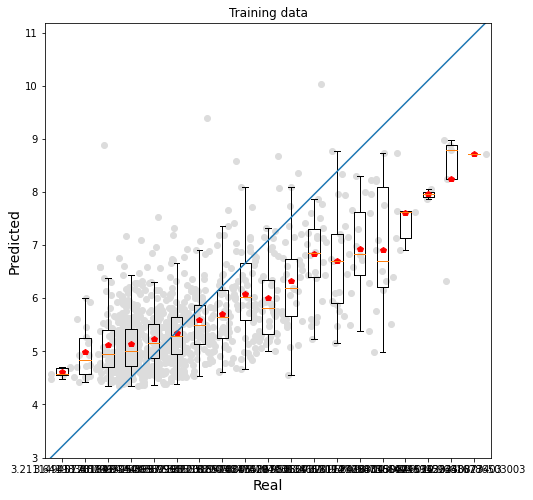

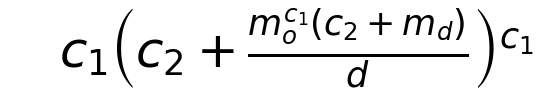

MCMC evolution


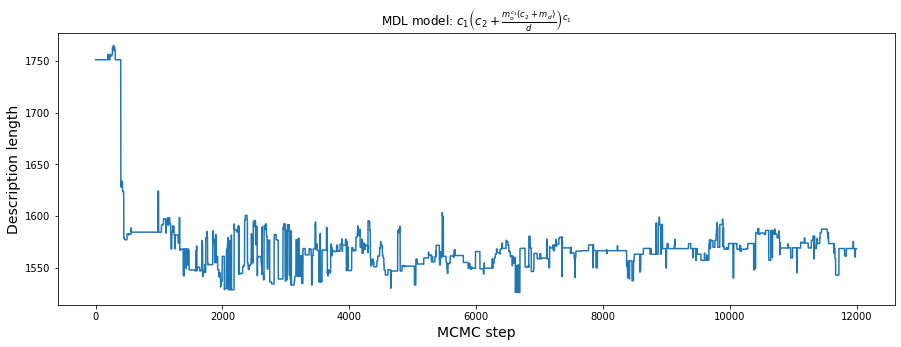

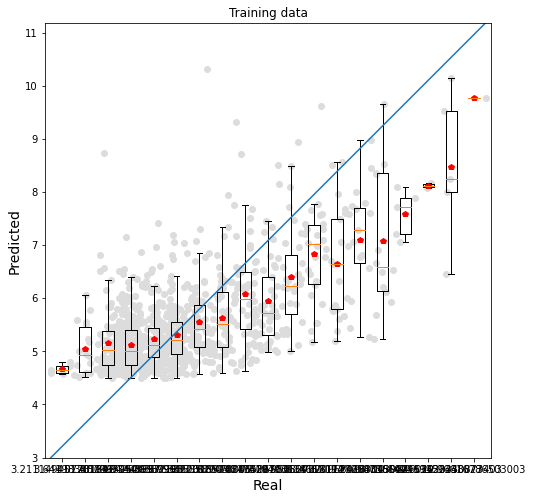

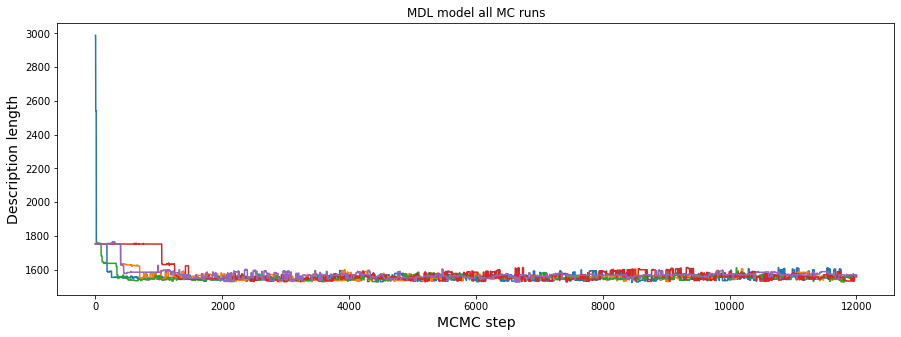

########################################
Lowest mdl for training data: 1523.52892093166
Model: (((((_a3_ + m_o) / (d * d)) * m_d) + _a5_) ** _a2_)


TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

1430.50413407713 log(((-((_a2_ / (m_d * _a1_))) + ((m_o + _a1_) / ((d * _a5_) ** _a4_))) * m_d)) {'d0': {'_a1_': 17809.99111630861, '_a2_': -1397255.2349433783, '_a4_': 2.0059336957503184, '_a5_': 117.00126156883533, '_a0_': 1.0, '_a3_': 1.0}}
1446.37006211433 ((_a0_ + ((((((((_a1_ / m_o) + _a0_) ** 2) * -((m_d * _a0_))) / -(_a1_)) * m_o) / (_a3_ ** 2)) / ((d * d) * _a1_))) ** _a3_) {'d0': {'_a0_': 63630.76143205672, '_a1_': 304114474.7526039, '_a3_': 0.13216995566734915, '_a2_': 1.0, '_a4_': 1.0, '_a5_': 1.0}}
1487.73794861126 (((-(_a5_) + (_a0_ ** ((_a4_ * _a4_) / (_a0_ + d)))) ** ((((_a4_ * (-(((_a5_ * _a3_) * _a2_)) * _a2_)) * m_d) * (((_a2_ + m_o) * _a2_) + _a4_)) ** _a4_)) * _a3_) {'d0': {'_a0_': 18.872694538262444, '_a2_': 19569.08152939256, '_a3_': 3.0111525545993802, '_a4_': 0.1340689707766992, '_a5_': -0.000856867690442975, '_a1_': 1.0}}
1436.47612821246 ((((((m_o * _a0_) ** (_a2_ * d)) + (((m_o * (m_d * (d ** ((_a1_ + _a0_) * (_a0_ ** 2))))) + -(_a3_)) ** _a5_)) * _a2_) / _a

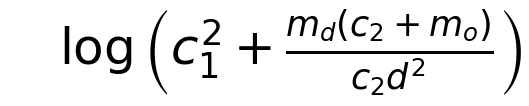

MCMC evolution


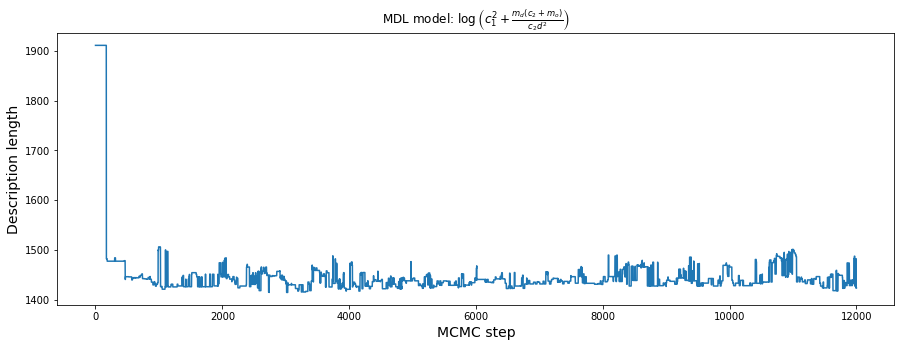

1473.81773143949 (sqrt(sqrt((_a2_ * (_a5_ + ((((d + _a5_) ** log((((m_o * (m_d + _a0_)) ** _a1_) + exp(_a2_)))) * ((m_o + _a5_) / (m_o + ((_a1_ ** d) * _a3_)))) / (d * _a4_)))))) + _a0_) {'d0': {'_a0_': -5.160906755213215, '_a1_': 0.11910530946445502, '_a2_': 2.9677288078328754, '_a3_': 841245.634476803, '_a4_': 7665029.541788729, '_a5_': 2307.4500868424743}}
1473.71063897023 (sqrt(sqrt((_a2_ * (_a5_ + ((((d + _a4_) ** log((((m_o * (m_d / _a2_)) ** _a1_) + exp(_a2_)))) * ((m_o + _a5_) / (m_o + ((_a1_ ** d) * _a3_)))) / (d * _a4_)))))) + _a0_) {'d0': {'_a0_': -4.667354983646911, '_a1_': 0.09490139591935555, '_a2_': 1.7365667584188373, '_a3_': 1338600.0592198179, '_a4_': 1523.3821396107296, '_a5_': 3106.6570525296283}}
1474.00133813889 (sqrt(sqrt((_a2_ + (_a5_ + ((((d + _a5_) ** log((((m_o * (m_d / _a2_)) ** _a1_) + exp(_a2_)))) * ((m_o + _a5_) / (m_o + ((_a1_ ** d) * _a3_)))) / (d * _a5_)))))) + _a0_) {'d0': {'_a0_': -3.4925740033855526, '_a1_': 0.09003826029069179, '_a2_': 1.5922668135

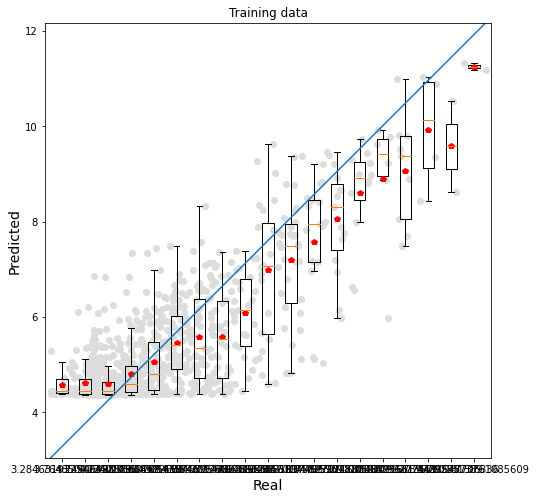

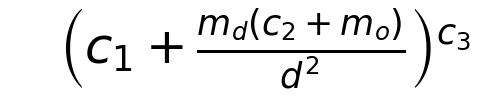

MCMC evolution


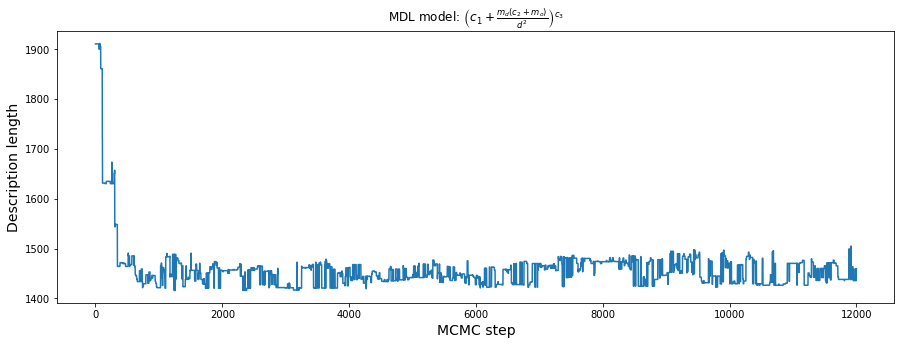

1480.07963549461 ((((((((sqrt(_a0_) * _a1_) * (_a5_ + (_a1_ / (_a4_ + d)))) * log(((m_d * _a4_) * (m_o + (_a1_ / m_o))))) * (_a3_ / _a0_)) * _a3_) ** 2) ** 3) + _a2_) {'d0': {'_a0_': 4.944962205792876e+56, '_a1_': 41891401.34909189, '_a2_': 3.5454853934758, '_a3_': 2669679.363352834, '_a4_': 29.317444625910355, '_a5_': 2722360.557855924}}
1490.55751619665 ((((((((sqrt(_a0_) * _a1_) * (_a5_ + (_a1_ / (_a4_ + d)))) * log(((m_d * _a4_) * (m_o + (_a1_ / m_o))))) * (_a3_ / (_a2_ * _a0_))) * (_a5_ + _a4_)) ** 2) ** 3) + _a2_) {'d0': {'_a0_': 5.168531007285046e+56, '_a1_': 41920781.3266738, '_a2_': 3.5454245310015535, '_a3_': 9468726.24994471, '_a4_': 29.317197609293128, '_a5_': 2724389.22855987}}
1447.64487895864 ((((_a4_ + (((sqrt(m_d) / _a2_) / m_o) * (((_a1_ + ((m_o ** 2) ** _a3_)) / -(d)) * _a1_))) ** _a0_) + _a2_) * (_a3_ * _a1_)) {'d0': {'_a0_': 6.876244499393457e-05, '_a1_': 62243.58009902313, '_a2_': -1.0011491857975232, '_a3_': 0.717405552233535, '_a4_': 68337130.64526229, '_a5_': 1

1450.94734944476 (-(((((_a5_ ** (((sqrt(m_d) * _a0_) / m_o) * (((_a0_ * ((_a5_ + m_o) ** _a3_)) / d) * _a1_))) + _a0_) + _a1_) * (_a4_ / _a1_))) + _a0_) {'d0': {'_a0_': 0.004319560477798615, '_a1_': -1.6241910118638603, '_a3_': 1.4601737587563108, '_a4_': -10.960761561646121, '_a5_': 1951.2297094115186, '_a2_': 1.0}}
1447.52786936474 ((((((((d ** _a2_) / _a1_) * _a0_) ** 2) ** 2) + _a5_) * ((((((_a3_ ** 2) + m_o) + _a0_) * _a1_) * m_d) + d)) ** cos(_a5_)) {'d0': {'_a0_': 5.240743642471118e-07, '_a1_': 1.5714769574969844e-08, '_a2_': -0.48175567699255556, '_a3_': 125.26175120948777, '_a5_': 23.70999599863501, '_a4_': 1.0}}
1492.28898061788 (((((abs(_a1_) / ((d ** 2) * ((_a2_ / _a1_) * _a3_))) + _a5_) ** (_a3_ * ((((_a0_ + m_o) * _a5_) * (m_d + cos((_a5_ ** 2)))) ** _a1_))) + ((_a1_ * cos(_a2_)) * -(((_a2_ + _a0_) * _a0_)))) * _a2_) {'d0': {'_a0_': 21514.849801261178, '_a1_': 0.43325967673598104, '_a2_': -7.853981626396672, '_a3_': -1.749613581021158e-05, '_a5_': 1.1382966620046648, '_a4

In [ ]:
#from memory_profiler import profile
res={}
state_model={}
state_ensemble={}
for key,frame in train_list_sample.items():

    best_model_train, list_ensemble_train = ms.machinescientist(x=train_list_sample[key],
                                                               y=train_list_sample[key]['total_pop_flow'],
                                                               XLABS=XLABS,n_params=params,
                                                               resets=mcmc_resets,
                                                               steps_prod=mcmc_steps,
                                                               log_scale_prediction=log_scale,
                                                               ensemble_avg=mcmc_ens_avg
                                                              )
    state_model[key]=copy(best_model_train)
    state_ensemble[key]=copy(list_ensemble_train)
    gc.collect()
name=f'./data/checkpoints/{fold}_state_model_B_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(state_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
name=f'./data/checkpoints/{fold}_ensemble_model_B_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(state_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)

In [ ]:
del state_model, state_ensemble

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
import gc
gc.collect()